In [1]:
!nvidia-smi

Wed Feb 14 22:32:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P8              21W / 215W |    885MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


40669.275077760496

In [10]:
l = [len(i) for i in x_test]
print(min(l))
print(max(l))
sum(l) / len(l)

20287
70470


40081.71915167095

In [11]:
def process(x, max_len=20000):
    y = []
    for i in x:
        i = i.squeeze()
        if len(i) > max_len:
            offset = max(0, (len(i) - max_len) // 2)
            yy = i[offset:offset+max_len]
        else:
            yy = i
        y.append(yy)
    return np.stack(y, axis=-1).T

In [12]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(process(x_train))[:, None ,:]
    y_train = torch.tensor(y_train, dtype=torch.int64)
    x_test = torch.tensor(process(x_test))[:, None, :]
    y_test = torch.tensor(y_test, dtype=torch.int64)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader, test_loader

In [13]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [14]:
from IConNet.nn.model import M13

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
model_config_path = 'config/model/m13.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M13', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [64, 64], 'kernel_size': [511, 127], 'stride': [4, 4], 'groups': [1, 1], 'window_k': [2, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'conv_type': 'firwin', 'conv_mode': 'conv', 'n_fft': False, 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [31]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (pad): PadRight()
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [18]:
from IConNet.visualizer import visualize_model

In [21]:
visualize_model.count_parameters(model)

525984

In [22]:
visualize_model.count_parameters(model.fe_blocks)

116224

In [20]:
import traceback

In [19]:
n_epoch = 100
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                        | 0.009615384615384616/100 [00:00<1:55:36, 69.37s/it]

Train Epoch: 1 [0/5144 (0%)]	Loss: 1.851899


  0%|▎                                                                        | 0.49038461538461475/100 [00:22<1:11:43, 43.25s/it]

Train Epoch: 1 [3200/5144 (2%)]	Loss: 1.523274


  1%|▊                                                                           | 0.9999999999999976/100 [00:42<56:57, 34.52s/it]


Test Epoch: 1	Accuracy: 574/1556 (37%)



  1%|▊                                                                           | 1.0096153846153821/100 [00:42<59:44, 36.21s/it]

Train Epoch: 2 [0/5144 (0%)]	Loss: 1.608475


  1%|█                                                                         | 1.4903846153846112/100 [01:04<1:10:07, 42.71s/it]

Train Epoch: 2 [3200/5144 (2%)]	Loss: 1.621032


  2%|█▌                                                                           | 1.999999999999994/100 [01:24<58:15, 35.67s/it]


Test Epoch: 2	Accuracy: 530/1556 (34%)



  2%|█▌                                                                         | 2.009615384615379/100 [01:25<1:02:10, 38.07s/it]

Train Epoch: 3 [0/5144 (0%)]	Loss: 1.533862


  2%|█▉                                                                          | 2.49038461538463/100 [01:46<1:10:53, 43.62s/it]

Train Epoch: 3 [3200/5144 (2%)]	Loss: 1.618963


  3%|██▎                                                                         | 3.0000000000000364/100 [02:07<55:47, 34.51s/it]


Test Epoch: 3	Accuracy: 649/1556 (42%)



  3%|██▎                                                                         | 3.0096153846154214/100 [02:07<58:51, 36.41s/it]

Train Epoch: 4 [0/5144 (0%)]	Loss: 1.664283


  3%|██▌                                                                       | 3.4903846153846727/100 [02:28<1:10:35, 43.88s/it]

Train Epoch: 4 [3200/5144 (2%)]	Loss: 1.363026


  4%|███                                                                          | 4.000000000000079/100 [02:49<54:59, 34.37s/it]


Test Epoch: 4	Accuracy: 598/1556 (38%)



  4%|███                                                                          | 4.009615384615464/100 [02:49<58:03, 36.30s/it]

Train Epoch: 5 [0/5144 (0%)]	Loss: 1.555407


  4%|███▎                                                                       | 4.490384615384715/100 [03:11<1:09:48, 43.86s/it]

Train Epoch: 5 [3200/5144 (2%)]	Loss: 1.524128


  5%|███▊                                                                         | 5.000000000000122/100 [03:31<54:44, 34.57s/it]


Test Epoch: 5	Accuracy: 591/1556 (38%)



  5%|███▊                                                                         | 5.009615384615507/100 [03:32<58:06, 36.70s/it]

Train Epoch: 6 [0/5144 (0%)]	Loss: 1.372539


  5%|████                                                                       | 5.490384615384758/100 [03:53<1:09:06, 43.87s/it]

Train Epoch: 6 [3200/5144 (2%)]	Loss: 1.511377


  6%|████▌                                                                        | 6.000000000000164/100 [04:14<54:11, 34.59s/it]


Test Epoch: 6	Accuracy: 635/1556 (41%)



  6%|████▋                                                                        | 6.009615384615549/100 [04:14<57:14, 36.54s/it]

Train Epoch: 7 [0/5144 (0%)]	Loss: 1.392016


  6%|████▊                                                                      | 6.490384615384801/100 [04:36<1:08:28, 43.94s/it]

Train Epoch: 7 [3200/5144 (2%)]	Loss: 1.707753


  7%|█████▍                                                                       | 7.000000000000207/100 [04:57<53:55, 34.79s/it]


Test Epoch: 7	Accuracy: 638/1556 (41%)



  7%|█████▍                                                                       | 7.009615384615592/100 [04:57<57:19, 36.99s/it]

Train Epoch: 8 [0/5144 (0%)]	Loss: 1.388029


  7%|█████▌                                                                     | 7.490384615384843/100 [05:19<1:08:16, 44.29s/it]

Train Epoch: 8 [3200/5144 (2%)]	Loss: 1.367842


  8%|██████▏                                                                      | 8.000000000000249/100 [05:40<52:41, 34.36s/it]


Test Epoch: 8	Accuracy: 656/1556 (42%)



  8%|██████▏                                                                      | 8.009615384615632/100 [05:40<55:24, 36.14s/it]

Train Epoch: 9 [0/5144 (0%)]	Loss: 1.540544


  8%|██████▎                                                                    | 8.490384615384794/100 [06:02<1:06:42, 43.73s/it]

Train Epoch: 9 [3200/5144 (2%)]	Loss: 1.495600


  9%|██████▉                                                                      | 9.000000000000107/100 [06:22<52:04, 34.34s/it]


Test Epoch: 9	Accuracy: 661/1556 (42%)



  9%|███████                                                                       | 9.00961538461549/100 [06:22<54:50, 36.16s/it]

Train Epoch: 10 [0/5144 (0%)]	Loss: 1.259697


  9%|███████                                                                    | 9.490384615384652/100 [06:44<1:05:54, 43.69s/it]

Train Epoch: 10 [3200/5144 (2%)]	Loss: 1.391736


 10%|███████▋                                                                     | 9.999999999999964/100 [07:04<51:25, 34.29s/it]


Test Epoch: 10	Accuracy: 643/1556 (41%)



 10%|███████▌                                                                    | 10.009615384615348/100 [07:05<54:06, 36.07s/it]

Train Epoch: 11 [0/5144 (0%)]	Loss: 1.534245


 10%|███████▊                                                                   | 10.49038461538451/100 [07:26<1:05:13, 43.72s/it]

Train Epoch: 11 [3200/5144 (2%)]	Loss: 1.261246


 11%|████████▎                                                                   | 10.999999999999822/100 [07:47<51:02, 34.41s/it]


Test Epoch: 11	Accuracy: 661/1556 (42%)



 11%|████████▎                                                                   | 11.009615384615206/100 [07:47<53:48, 36.28s/it]

Train Epoch: 12 [0/5144 (0%)]	Loss: 1.371231


 11%|████████▌                                                                 | 11.490384615384368/100 [08:09<1:04:45, 43.90s/it]

Train Epoch: 12 [3200/5144 (2%)]	Loss: 1.467363


 12%|█████████▏                                                                   | 11.99999999999968/100 [08:29<50:25, 34.38s/it]


Test Epoch: 12	Accuracy: 642/1556 (41%)



 12%|█████████▏                                                                  | 12.009615384615064/100 [08:30<53:00, 36.14s/it]

Train Epoch: 13 [0/5144 (0%)]	Loss: 1.474906


 12%|█████████▏                                                                | 12.490384615384226/100 [08:51<1:03:38, 43.63s/it]

Train Epoch: 13 [3200/5144 (2%)]	Loss: 1.426056


 13%|█████████▉                                                                  | 12.999999999999538/100 [09:12<49:45, 34.32s/it]


Test Epoch: 13	Accuracy: 716/1556 (46%)



 13%|█████████▉                                                                  | 13.009615384614921/100 [09:12<52:32, 36.23s/it]

Train Epoch: 14 [0/5144 (0%)]	Loss: 1.462403


 13%|█████████▉                                                                | 13.490384615384084/100 [09:34<1:02:39, 43.46s/it]

Train Epoch: 14 [3200/5144 (2%)]	Loss: 1.347142


 14%|██████████▋                                                                 | 13.999999999999396/100 [09:54<49:12, 34.34s/it]


Test Epoch: 14	Accuracy: 658/1556 (42%)



 14%|██████████▊                                                                  | 14.00961538461478/100 [09:54<51:49, 36.16s/it]

Train Epoch: 15 [0/5144 (0%)]	Loss: 1.324207


 14%|██████████▋                                                               | 14.490384615383942/100 [10:16<1:02:10, 43.63s/it]

Train Epoch: 15 [3200/5144 (2%)]	Loss: 1.631146


 15%|███████████▍                                                                | 14.999999999999254/100 [10:36<48:45, 34.42s/it]


Test Epoch: 15	Accuracy: 673/1556 (43%)



 15%|███████████▍                                                                | 15.009615384614637/100 [10:37<51:13, 36.16s/it]

Train Epoch: 16 [0/5144 (0%)]	Loss: 1.479469


 15%|███████████▊                                                                | 15.4903846153838/100 [10:58<1:01:46, 43.86s/it]

Train Epoch: 16 [3200/5144 (2%)]	Loss: 1.558870


 16%|████████████▏                                                               | 15.999999999999112/100 [11:18<48:04, 34.34s/it]


Test Epoch: 16	Accuracy: 662/1556 (43%)



 16%|████████████▍                                                                 | 16.0096153846145/100 [11:19<50:36, 36.15s/it]

Train Epoch: 17 [0/5144 (0%)]	Loss: 1.516456


 16%|████████████▎                                                              | 16.49038461538384/100 [11:40<1:00:46, 43.67s/it]

Train Epoch: 17 [3200/5144 (2%)]	Loss: 1.353718


 17%|█████████████                                                                | 16.99999999999934/100 [12:01<47:34, 34.40s/it]


Test Epoch: 17	Accuracy: 680/1556 (44%)



 17%|████████████▉                                                               | 17.009615384614726/100 [12:01<50:07, 36.24s/it]

Train Epoch: 18 [0/5144 (0%)]	Loss: 1.163995


 17%|████████████▉                                                             | 17.490384615384066/100 [12:23<1:00:06, 43.71s/it]

Train Epoch: 18 [3200/5144 (2%)]	Loss: 1.394344


 18%|█████████████▋                                                              | 17.999999999999567/100 [12:43<46:59, 34.38s/it]


Test Epoch: 18	Accuracy: 690/1556 (44%)



 18%|█████████████▋                                                              | 18.009615384614953/100 [12:44<49:38, 36.33s/it]

Train Epoch: 19 [0/5144 (0%)]	Loss: 1.427144


 18%|██████████████                                                              | 18.490384615384293/100 [13:05<59:39, 43.92s/it]

Train Epoch: 19 [3200/5144 (2%)]	Loss: 1.224726


 19%|██████████████▍                                                             | 18.999999999999794/100 [13:26<46:27, 34.42s/it]


Test Epoch: 19	Accuracy: 647/1556 (42%)



 19%|██████████████▋                                                              | 19.00961538461518/100 [13:26<48:49, 36.17s/it]

Train Epoch: 20 [0/5144 (0%)]	Loss: 1.347125


 19%|███████████████                                                              | 19.49038461538452/100 [13:47<58:56, 43.93s/it]

Train Epoch: 20 [3200/5144 (2%)]	Loss: 1.299923


 20%|███████████████▍                                                             | 20.00000000000002/100 [14:08<45:47, 34.34s/it]


Test Epoch: 20	Accuracy: 709/1556 (46%)



 20%|███████████████▏                                                            | 20.009615384615408/100 [14:08<48:15, 36.20s/it]

Train Epoch: 21 [0/5144 (0%)]	Loss: 1.499010


 20%|███████████████▌                                                            | 20.490384615384748/100 [14:30<57:58, 43.74s/it]

Train Epoch: 21 [3200/5144 (2%)]	Loss: 1.513931


 21%|████████████████▏                                                            | 21.00000000000025/100 [14:50<45:39, 34.68s/it]


Test Epoch: 21	Accuracy: 718/1556 (46%)



 21%|███████████████▉                                                            | 21.009615384615635/100 [14:51<47:51, 36.35s/it]

Train Epoch: 22 [0/5144 (0%)]	Loss: 1.479192


 21%|████████████████▎                                                           | 21.490384615384976/100 [15:12<57:32, 43.97s/it]

Train Epoch: 22 [3200/5144 (2%)]	Loss: 1.576830


 22%|████████████████▋                                                           | 22.000000000000476/100 [15:33<44:40, 34.36s/it]


Test Epoch: 22	Accuracy: 715/1556 (46%)



 22%|████████████████▋                                                           | 22.009615384615863/100 [15:33<47:01, 36.17s/it]

Train Epoch: 23 [0/5144 (0%)]	Loss: 1.486408


 22%|█████████████████                                                           | 22.490384615385203/100 [15:55<56:43, 43.92s/it]

Train Epoch: 23 [3200/5144 (2%)]	Loss: 1.389419


 23%|█████████████████▍                                                          | 23.000000000000703/100 [16:16<44:33, 34.71s/it]


Test Epoch: 23	Accuracy: 711/1556 (46%)



 23%|█████████████████▋                                                           | 23.00961538461609/100 [16:16<46:57, 36.59s/it]

Train Epoch: 24 [0/5144 (0%)]	Loss: 1.529953


 23%|██████████████████                                                           | 23.49038461538543/100 [16:38<56:13, 44.10s/it]

Train Epoch: 24 [3200/5144 (2%)]	Loss: 1.322491


 24%|██████████████████▍                                                          | 24.00000000000093/100 [16:58<44:02, 34.77s/it]


Test Epoch: 24	Accuracy: 722/1556 (46%)



 24%|██████████████████▏                                                         | 24.009615384616318/100 [16:59<46:08, 36.44s/it]

Train Epoch: 25 [0/5144 (0%)]	Loss: 1.309131


 24%|██████████████████▌                                                         | 24.490384615385658/100 [17:20<55:23, 44.01s/it]

Train Epoch: 25 [3200/5144 (2%)]	Loss: 1.536943


 25%|███████████████████                                                         | 25.000000000001158/100 [17:41<43:20, 34.67s/it]


Test Epoch: 25	Accuracy: 693/1556 (45%)



 25%|███████████████████                                                         | 25.009615384616545/100 [17:41<45:45, 36.62s/it]

Train Epoch: 26 [0/5144 (0%)]	Loss: 1.137599


 25%|███████████████████▎                                                        | 25.490384615385885/100 [18:03<54:46, 44.11s/it]

Train Epoch: 26 [3200/5144 (2%)]	Loss: 1.323104


 26%|███████████████████▊                                                        | 26.000000000001386/100 [18:24<42:49, 34.73s/it]


Test Epoch: 26	Accuracy: 722/1556 (46%)



 26%|███████████████████▊                                                        | 26.009615384616772/100 [18:24<45:07, 36.59s/it]

Train Epoch: 27 [0/5144 (0%)]	Loss: 1.296342


 26%|████████████████████▏                                                       | 26.490384615386112/100 [18:46<54:05, 44.15s/it]

Train Epoch: 27 [3200/5144 (2%)]	Loss: 1.317606


 27%|████████████████████▌                                                       | 27.000000000001613/100 [19:07<42:15, 34.73s/it]


Test Epoch: 27	Accuracy: 677/1556 (44%)



 27%|█████████████████████▎                                                         | 27.009615384617/100 [19:07<44:26, 36.53s/it]

Train Epoch: 28 [0/5144 (0%)]	Loss: 1.066275


 27%|█████████████████████▏                                                       | 27.49038461538634/100 [19:29<53:26, 44.22s/it]

Train Epoch: 28 [3200/5144 (2%)]	Loss: 1.539394


 28%|█████████████████████▌                                                       | 28.00000000000184/100 [19:49<41:31, 34.60s/it]


Test Epoch: 28	Accuracy: 727/1556 (47%)



 28%|█████████████████████▎                                                      | 28.009615384617227/100 [19:50<43:52, 36.57s/it]

Train Epoch: 29 [0/5144 (0%)]	Loss: 1.191994


 28%|█████████████████████▋                                                      | 28.490384615386567/100 [20:11<52:26, 44.00s/it]

Train Epoch: 29 [3200/5144 (2%)]	Loss: 1.387864


 29%|██████████████████████                                                      | 29.000000000002068/100 [20:32<41:02, 34.69s/it]


Test Epoch: 29	Accuracy: 682/1556 (44%)



 29%|██████████████████████                                                      | 29.009615384617454/100 [20:32<43:19, 36.62s/it]

Train Epoch: 30 [0/5144 (0%)]	Loss: 1.569281


 29%|██████████████████████▍                                                     | 29.490384615386795/100 [20:54<51:41, 43.98s/it]

Train Epoch: 30 [3200/5144 (2%)]	Loss: 1.124738


 30%|██████████████████████▊                                                     | 30.000000000002295/100 [21:15<40:47, 34.97s/it]


Test Epoch: 30	Accuracy: 663/1556 (43%)



 30%|██████████████████████▊                                                     | 30.009615384617682/100 [21:15<42:47, 36.69s/it]

Train Epoch: 31 [0/5144 (0%)]	Loss: 1.267276


 30%|███████████████████████▏                                                    | 30.490384615387022/100 [21:37<50:42, 43.77s/it]

Train Epoch: 31 [3200/5144 (2%)]	Loss: 1.160306


 31%|███████████████████████▌                                                    | 31.000000000002522/100 [21:57<39:53, 34.68s/it]


Test Epoch: 31	Accuracy: 679/1556 (44%)



 31%|███████████████████████▉                                                     | 31.00961538461791/100 [21:58<42:01, 36.54s/it]

Train Epoch: 32 [0/5144 (0%)]	Loss: 1.395624


 31%|████████████████████████▏                                                    | 31.49038461538725/100 [22:19<50:01, 43.81s/it]

Train Epoch: 32 [3200/5144 (2%)]	Loss: 1.739749


 32%|████████████████████████▋                                                    | 32.00000000000275/100 [22:40<39:02, 34.45s/it]


Test Epoch: 32	Accuracy: 692/1556 (44%)



 32%|████████████████████████▋                                                    | 32.00961538461814/100 [22:40<40:56, 36.13s/it]

Train Epoch: 33 [0/5144 (0%)]	Loss: 1.304438


 32%|█████████████████████████                                                    | 32.49038461538748/100 [23:02<49:11, 43.73s/it]

Train Epoch: 33 [3200/5144 (2%)]	Loss: 1.310889


 33%|█████████████████████████▍                                                   | 33.00000000000298/100 [23:22<38:26, 34.43s/it]


Test Epoch: 33	Accuracy: 700/1556 (45%)



 33%|█████████████████████████                                                   | 33.009615384618364/100 [23:23<40:30, 36.29s/it]

Train Epoch: 34 [0/5144 (0%)]	Loss: 1.316498


 33%|█████████████████████████▍                                                  | 33.490384615387704/100 [23:44<49:17, 44.47s/it]

Train Epoch: 34 [3200/5144 (2%)]	Loss: 1.345980


 34%|█████████████████████████▊                                                  | 34.000000000003205/100 [24:05<37:51, 34.42s/it]


Test Epoch: 34	Accuracy: 706/1556 (45%)



 34%|██████████████████████████▏                                                  | 34.00961538461859/100 [24:05<40:08, 36.50s/it]

Train Epoch: 35 [0/5144 (0%)]	Loss: 1.197135


 34%|██████████████████████████▌                                                  | 34.49038461538793/100 [24:27<47:48, 43.79s/it]

Train Epoch: 35 [3200/5144 (2%)]	Loss: 1.555522


 35%|██████████████████████████▉                                                  | 35.00000000000343/100 [24:47<37:20, 34.48s/it]


Test Epoch: 35	Accuracy: 698/1556 (45%)



 35%|██████████████████████████▉                                                  | 35.00961538461882/100 [24:47<39:23, 36.36s/it]

Train Epoch: 36 [0/5144 (0%)]	Loss: 1.585373


 35%|███████████████████████████▎                                                 | 35.49038461538816/100 [25:09<47:42, 44.37s/it]

Train Epoch: 36 [3200/5144 (2%)]	Loss: 1.323785


 36%|███████████████████████████▋                                                 | 36.00000000000366/100 [25:30<37:17, 34.96s/it]


Test Epoch: 36	Accuracy: 664/1556 (43%)



 36%|███████████████████████████▎                                                | 36.009615384619046/100 [25:30<39:23, 36.93s/it]

Train Epoch: 37 [0/5144 (0%)]	Loss: 1.286293


 36%|███████████████████████████▋                                                | 36.490384615388386/100 [25:52<46:56, 44.34s/it]

Train Epoch: 37 [3200/5144 (2%)]	Loss: 1.313465


 37%|████████████████████████████▍                                                | 37.00000000000389/100 [26:13<36:47, 35.04s/it]


Test Epoch: 37	Accuracy: 672/1556 (43%)



 37%|████████████████████████████▍                                                | 37.00961538461927/100 [26:13<38:48, 36.96s/it]

Train Epoch: 38 [0/5144 (0%)]	Loss: 1.476907


 37%|████████████████████████████▍                                               | 37.490384615388614/100 [26:35<46:31, 44.66s/it]

Train Epoch: 38 [3200/5144 (2%)]	Loss: 1.365888


 38%|████████████████████████████▉                                               | 38.000000000004114/100 [26:56<36:23, 35.22s/it]


Test Epoch: 38	Accuracy: 694/1556 (45%)



 38%|█████████████████████████████▋                                                | 38.0096153846195/100 [26:56<38:07, 36.91s/it]

Train Epoch: 39 [0/5144 (0%)]	Loss: 1.414297


 38%|█████████████████████████████▋                                               | 38.49038461538884/100 [27:18<44:59, 43.89s/it]

Train Epoch: 39 [3200/5144 (2%)]	Loss: 1.382942


 39%|██████████████████████████████                                               | 39.00000000000434/100 [27:39<34:58, 34.41s/it]


Test Epoch: 39	Accuracy: 699/1556 (45%)



 39%|█████████████████████████████▋                                              | 39.004807692312035/100 [27:39<37:56, 37.32s/it]

Train Epoch: 40 [0/5144 (0%)]	Loss: 1.270726


 39%|██████████████████████████████▍                                              | 39.49038461538907/100 [28:01<44:10, 43.80s/it]

Train Epoch: 40 [3200/5144 (2%)]	Loss: 1.542872


 40%|██████████████████████████████▊                                              | 40.00000000000457/100 [28:21<34:21, 34.36s/it]


Test Epoch: 40	Accuracy: 704/1556 (45%)



 40%|██████████████████████████████▍                                             | 40.009615384619956/100 [28:21<36:11, 36.19s/it]

Train Epoch: 41 [0/5144 (0%)]	Loss: 1.348006


 40%|██████████████████████████████▊                                             | 40.490384615389296/100 [28:43<43:23, 43.75s/it]

Train Epoch: 41 [3200/5144 (2%)]	Loss: 1.645197


 41%|███████████████████████████████▏                                            | 41.000000000004796/100 [29:04<33:48, 34.38s/it]


Test Epoch: 41	Accuracy: 706/1556 (45%)



 41%|███████████████████████████████▌                                             | 41.00961538462018/100 [29:04<35:37, 36.24s/it]

Train Epoch: 42 [0/5144 (0%)]	Loss: 1.393856


 41%|███████████████████████████████▉                                             | 41.49038461538952/100 [29:25<42:52, 43.96s/it]

Train Epoch: 42 [3200/5144 (2%)]	Loss: 1.659771


 42%|████████████████████████████████▎                                            | 42.00000000000502/100 [29:46<33:21, 34.50s/it]


Test Epoch: 42	Accuracy: 697/1556 (45%)



 42%|████████████████████████████████▎                                            | 42.00961538462041/100 [29:46<35:17, 36.51s/it]

Train Epoch: 43 [0/5144 (0%)]	Loss: 1.403902


 42%|████████████████████████████████▋                                            | 42.49038461538975/100 [30:08<42:00, 43.83s/it]

Train Epoch: 43 [3200/5144 (2%)]	Loss: 1.354645


 43%|█████████████████████████████████                                            | 43.00000000000525/100 [30:28<32:44, 34.47s/it]


Test Epoch: 43	Accuracy: 695/1556 (45%)



 43%|█████████████████████████████████                                            | 43.00961538462064/100 [30:29<34:30, 36.33s/it]

Train Epoch: 44 [0/5144 (0%)]	Loss: 1.166343


 43%|█████████████████████████████████▍                                           | 43.49038461538998/100 [30:50<41:10, 43.72s/it]

Train Epoch: 44 [3200/5144 (2%)]	Loss: 1.406587


 44%|█████████████████████████████████▉                                           | 44.00000000000548/100 [31:11<32:05, 34.39s/it]


Test Epoch: 44	Accuracy: 686/1556 (44%)



 44%|█████████████████████████████████▍                                          | 44.009615384620865/100 [31:11<33:49, 36.24s/it]

Train Epoch: 45 [0/5144 (0%)]	Loss: 1.164461


 44%|█████████████████████████████████▊                                          | 44.490384615390205/100 [31:33<40:35, 43.88s/it]

Train Epoch: 45 [3200/5144 (2%)]	Loss: 1.454482


 45%|██████████████████████████████████▏                                         | 45.000000000005706/100 [31:53<31:33, 34.42s/it]


Test Epoch: 45	Accuracy: 689/1556 (44%)



 45%|██████████████████████████████████▋                                          | 45.00961538462109/100 [31:54<33:14, 36.27s/it]

Train Epoch: 46 [0/5144 (0%)]	Loss: 1.636097


 45%|███████████████████████████████████                                          | 45.49038461539043/100 [32:15<40:04, 44.12s/it]

Train Epoch: 46 [3200/5144 (2%)]	Loss: 1.328775


 46%|███████████████████████████████████▍                                         | 46.00000000000593/100 [32:36<31:09, 34.62s/it]


Test Epoch: 46	Accuracy: 634/1556 (41%)



 46%|███████████████████████████████████▍                                         | 46.00961538462132/100 [32:36<32:45, 36.40s/it]

Train Epoch: 47 [0/5144 (0%)]	Loss: 1.714304


 46%|███████████████████████████████████▊                                         | 46.49038461539066/100 [32:58<39:09, 43.91s/it]

Train Epoch: 47 [3200/5144 (2%)]	Loss: 1.260569


 47%|████████████████████████████████████▏                                        | 47.00000000000616/100 [33:18<30:29, 34.52s/it]


Test Epoch: 47	Accuracy: 689/1556 (44%)



 47%|████████████████████████████████████▏                                        | 47.00961538462155/100 [33:19<32:06, 36.36s/it]

Train Epoch: 48 [0/5144 (0%)]	Loss: 1.202113


 47%|████████████████████████████████████▌                                        | 47.49038461539089/100 [33:40<38:13, 43.67s/it]

Train Epoch: 48 [3200/5144 (2%)]	Loss: 1.411327


 48%|████████████████████████████████████▉                                        | 48.00000000000639/100 [34:01<29:47, 34.37s/it]


Test Epoch: 48	Accuracy: 669/1556 (43%)



 48%|████████████████████████████████████▍                                       | 48.009615384621775/100 [34:01<31:17, 36.12s/it]

Train Epoch: 49 [0/5144 (0%)]	Loss: 1.338357


 48%|████████████████████████████████████▊                                       | 48.490384615391115/100 [34:23<37:34, 43.76s/it]

Train Epoch: 49 [3200/5144 (2%)]	Loss: 1.240915


 49%|█████████████████████████████████████▏                                      | 49.000000000006615/100 [34:43<29:17, 34.47s/it]


Test Epoch: 49	Accuracy: 685/1556 (44%)



 49%|██████████████████████████████████████▋                                        | 49.009615384622/100 [34:43<30:50, 36.28s/it]

Train Epoch: 50 [0/5144 (0%)]	Loss: 1.062350


 49%|██████████████████████████████████████                                       | 49.49038461539134/100 [35:05<36:53, 43.83s/it]

Train Epoch: 50 [3200/5144 (2%)]	Loss: 1.447666


 50%|██████████████████████████████████████▌                                      | 50.00000000000684/100 [35:25<28:54, 34.69s/it]


Test Epoch: 50	Accuracy: 663/1556 (43%)



 50%|██████████████████████████████████████▌                                      | 50.00961538462223/100 [35:26<30:17, 36.35s/it]

Train Epoch: 51 [0/5144 (0%)]	Loss: 1.392200


 50%|██████████████████████████████████████▉                                      | 50.49038461539157/100 [35:47<36:05, 43.75s/it]

Train Epoch: 51 [3200/5144 (2%)]	Loss: 1.189561


 51%|███████████████████████████████████████▎                                     | 51.00000000000707/100 [36:08<28:17, 34.63s/it]


Test Epoch: 51	Accuracy: 636/1556 (41%)



 51%|███████████████████████████████████████▎                                     | 51.00961538462246/100 [36:08<29:45, 36.44s/it]

Train Epoch: 52 [0/5144 (0%)]	Loss: 1.274662


 51%|████████████████████████████████████████▏                                     | 51.4903846153918/100 [36:30<35:27, 43.85s/it]

Train Epoch: 52 [3200/5144 (2%)]	Loss: 1.183256


 52%|████████████████████████████████████████▌                                     | 52.0000000000073/100 [36:51<27:33, 34.44s/it]


Test Epoch: 52	Accuracy: 706/1556 (45%)



 52%|███████████████████████████████████████▌                                    | 52.009615384622684/100 [36:51<28:58, 36.23s/it]

Train Epoch: 53 [0/5144 (0%)]	Loss: 1.290261


 52%|███████████████████████████████████████▉                                    | 52.490384615392024/100 [37:13<34:43, 43.86s/it]

Train Epoch: 53 [3200/5144 (2%)]	Loss: 1.178274


 53%|████████████████████████████████████████▎                                   | 53.000000000007525/100 [37:33<26:59, 34.45s/it]


Test Epoch: 53	Accuracy: 686/1556 (44%)



 53%|████████████████████████████████████████▊                                    | 53.00961538462291/100 [37:34<28:25, 36.29s/it]

Train Epoch: 54 [0/5144 (0%)]	Loss: 1.362484


 53%|█████████████████████████████████████████▏                                   | 53.49038461539225/100 [37:55<34:01, 43.90s/it]

Train Epoch: 54 [3200/5144 (2%)]	Loss: 1.202021


 54%|█████████████████████████████████████████▌                                   | 54.00000000000775/100 [38:16<26:28, 34.52s/it]


Test Epoch: 54	Accuracy: 674/1556 (43%)



 54%|█████████████████████████████████████████▌                                   | 54.00961538462314/100 [38:16<27:56, 36.45s/it]

Train Epoch: 55 [0/5144 (0%)]	Loss: 1.277689


 54%|█████████████████████████████████████████▉                                   | 54.49038461539248/100 [38:38<33:21, 43.99s/it]

Train Epoch: 55 [3200/5144 (2%)]	Loss: 1.532224


 55%|██████████████████████████████████████████▎                                  | 55.00000000000798/100 [38:59<26:31, 35.36s/it]


Test Epoch: 55	Accuracy: 690/1556 (44%)



 55%|█████████████████████████████████████████▊                                  | 55.009615384623366/100 [38:59<28:03, 37.42s/it]

Train Epoch: 56 [0/5144 (0%)]	Loss: 1.148231


 55%|██████████████████████████████████████████▏                                 | 55.490384615392706/100 [39:21<32:46, 44.18s/it]

Train Epoch: 56 [3200/5144 (2%)]	Loss: 1.428851


 56%|███████████████████████████████████████████                                  | 56.00000000000821/100 [39:42<25:29, 34.76s/it]


Test Epoch: 56	Accuracy: 676/1556 (43%)



 56%|██████████████████████████████████████████▌                                 | 56.009615384623594/100 [39:42<26:50, 36.61s/it]

Train Epoch: 57 [0/5144 (0%)]	Loss: 1.310215


 56%|██████████████████████████████████████████▉                                 | 56.490384615392934/100 [40:04<32:11, 44.39s/it]

Train Epoch: 57 [3200/5144 (2%)]	Loss: 1.125584


 57%|███████████████████████████████████████████▎                                | 57.000000000008434/100 [40:25<25:04, 34.99s/it]


Test Epoch: 57	Accuracy: 659/1556 (42%)



 57%|███████████████████████████████████████████▉                                 | 57.00961538462382/100 [40:25<26:25, 36.88s/it]

Train Epoch: 58 [0/5144 (0%)]	Loss: 1.018167


 57%|████████████████████████████████████████████▎                                | 57.49038461539316/100 [40:47<31:30, 44.48s/it]

Train Epoch: 58 [3200/5144 (2%)]	Loss: 1.093812


 58%|████████████████████████████████████████████▋                                | 58.00000000000866/100 [41:08<24:32, 35.07s/it]


Test Epoch: 58	Accuracy: 682/1556 (44%)



 58%|████████████████████████████████████████████▋                                | 58.00961538462405/100 [41:08<25:56, 37.06s/it]

Train Epoch: 59 [0/5144 (0%)]	Loss: 1.254343


 58%|█████████████████████████████████████████████                                | 58.49038461539339/100 [41:30<30:24, 43.95s/it]

Train Epoch: 59 [3200/5144 (2%)]	Loss: 1.264050


 59%|█████████████████████████████████████████████▍                               | 59.00000000000889/100 [41:50<23:32, 34.46s/it]


Test Epoch: 59	Accuracy: 699/1556 (45%)



 59%|████████████████████████████████████████████▊                               | 59.009615384624276/100 [41:51<24:47, 36.30s/it]

Train Epoch: 60 [0/5144 (0%)]	Loss: 1.185419


 59%|█████████████████████████████████████████████▏                              | 59.490384615393616/100 [42:12<29:30, 43.70s/it]

Train Epoch: 60 [3200/5144 (2%)]	Loss: 1.187276


 60%|█████████████████████████████████████████████▌                              | 60.000000000009116/100 [42:33<22:57, 34.44s/it]


Test Epoch: 60	Accuracy: 649/1556 (42%)



 60%|██████████████████████████████████████████████▊                               | 60.0096153846245/100 [42:33<24:14, 36.36s/it]

Train Epoch: 61 [0/5144 (0%)]	Loss: 1.130754


 60%|██████████████████████████████████████████████▌                              | 60.49038461539384/100 [42:55<28:49, 43.77s/it]

Train Epoch: 61 [3200/5144 (2%)]	Loss: 1.499229


 61%|██████████████████████████████████████████████▎                             | 61.000000000009344/100 [43:15<22:21, 34.41s/it]


Test Epoch: 61	Accuracy: 711/1556 (46%)



 61%|██████████████████████████████████████████████▉                              | 61.00961538462473/100 [43:16<23:33, 36.26s/it]

Train Epoch: 62 [0/5144 (0%)]	Loss: 1.265783


 61%|███████████████████████████████████████████████▎                             | 61.49038461539407/100 [43:37<28:14, 44.01s/it]

Train Epoch: 62 [3200/5144 (2%)]	Loss: 1.019338


 62%|███████████████████████████████████████████████▋                             | 62.00000000000957/100 [43:58<21:48, 34.44s/it]


Test Epoch: 62	Accuracy: 661/1556 (42%)



 62%|███████████████████████████████████████████████▋                             | 62.00961538462496/100 [43:58<23:03, 36.43s/it]

Train Epoch: 63 [0/5144 (0%)]	Loss: 1.303427


 62%|████████████████████████████████████████████████▋                             | 62.4903846153943/100 [44:20<27:21, 43.75s/it]

Train Epoch: 63 [3200/5144 (2%)]	Loss: 0.972163


 63%|█████████████████████████████████████████████████▏                            | 63.0000000000098/100 [44:40<21:14, 34.44s/it]


Test Epoch: 63	Accuracy: 676/1556 (43%)



 63%|███████████████████████████████████████████████▉                            | 63.009615384625185/100 [44:41<22:21, 36.26s/it]

Train Epoch: 64 [0/5144 (0%)]	Loss: 1.333259


 63%|████████████████████████████████████████████████▎                           | 63.490384615394525/100 [45:02<26:40, 43.84s/it]

Train Epoch: 64 [3200/5144 (2%)]	Loss: 1.515630


 64%|█████████████████████████████████████████████████▎                           | 64.00000000001002/100 [45:23<20:39, 34.44s/it]


Test Epoch: 64	Accuracy: 700/1556 (45%)



 64%|█████████████████████████████████████████████████▉                            | 64.0096153846254/100 [45:23<21:46, 36.29s/it]

Train Epoch: 65 [0/5144 (0%)]	Loss: 1.441606


 64%|█████████████████████████████████████████████████▋                           | 64.49038461539475/100 [45:44<25:53, 43.76s/it]

Train Epoch: 65 [3200/5144 (2%)]	Loss: 1.371100


 65%|██████████████████████████████████████████████████                           | 65.00000000001025/100 [46:05<19:58, 34.25s/it]


Test Epoch: 65	Accuracy: 716/1556 (46%)



 65%|██████████████████████████████████████████████████                           | 65.00961538462563/100 [46:05<21:05, 36.17s/it]

Train Epoch: 66 [0/5144 (0%)]	Loss: 0.980463


 65%|██████████████████████████████████████████████████▍                          | 65.49038461539497/100 [46:27<25:12, 43.83s/it]

Train Epoch: 66 [3200/5144 (2%)]	Loss: 1.286044


 66%|██████████████████████████████████████████████████▊                          | 66.00000000001047/100 [46:47<19:30, 34.42s/it]


Test Epoch: 66	Accuracy: 691/1556 (44%)



 66%|██████████████████████████████████████████████████▊                          | 66.00961538462586/100 [46:48<20:31, 36.24s/it]

Train Epoch: 67 [0/5144 (0%)]	Loss: 1.387964


 66%|███████████████████████████████████████████████████▊                          | 66.4903846153952/100 [47:09<24:28, 43.81s/it]

Train Epoch: 67 [3200/5144 (2%)]	Loss: 1.175284


 67%|████████████████████████████████████████████████████▎                         | 67.0000000000107/100 [47:30<19:00, 34.57s/it]


Test Epoch: 67	Accuracy: 689/1556 (44%)



 67%|███████████████████████████████████████████████████▌                         | 67.00961538462609/100 [47:30<20:00, 36.40s/it]

Train Epoch: 68 [0/5144 (0%)]	Loss: 0.969487


 67%|███████████████████████████████████████████████████▉                         | 67.49038461539543/100 [47:52<23:44, 43.82s/it]

Train Epoch: 68 [3200/5144 (2%)]	Loss: 1.419015


 68%|████████████████████████████████████████████████████▎                        | 68.00000000001093/100 [48:12<18:22, 34.46s/it]


Test Epoch: 68	Accuracy: 704/1556 (45%)



 68%|████████████████████████████████████████████████████▎                        | 68.00961538462631/100 [48:13<19:22, 36.35s/it]

Train Epoch: 69 [0/5144 (0%)]	Loss: 1.253070


 68%|████████████████████████████████████████████████████▋                        | 68.49038461539566/100 [48:34<23:01, 43.85s/it]

Train Epoch: 69 [3200/5144 (2%)]	Loss: 1.160668


 69%|█████████████████████████████████████████████████████▏                       | 69.00000000001116/100 [48:55<17:49, 34.50s/it]


Test Epoch: 69	Accuracy: 667/1556 (43%)



 69%|█████████████████████████████████████████████████████▏                       | 69.00961538462654/100 [48:55<18:44, 36.30s/it]

Train Epoch: 70 [0/5144 (0%)]	Loss: 0.837372


 69%|█████████████████████████████████████████████████████▌                       | 69.49038461539588/100 [49:17<22:19, 43.91s/it]

Train Epoch: 70 [3200/5144 (2%)]	Loss: 1.079380


 70%|█████████████████████████████████████████████████████▉                       | 70.00000000001138/100 [49:37<17:14, 34.48s/it]


Test Epoch: 70	Accuracy: 698/1556 (45%)



 70%|█████████████████████████████████████████████████████▉                       | 70.00961538462677/100 [49:38<18:09, 36.34s/it]

Train Epoch: 71 [0/5144 (0%)]	Loss: 1.062717


 70%|██████████████████████████████████████████████████████▎                      | 70.49038461539611/100 [49:59<22:24, 45.55s/it]

Train Epoch: 71 [3200/5144 (2%)]	Loss: 1.077460


 71%|██████████████████████████████████████████████████████▋                      | 71.00000000001161/100 [50:20<16:37, 34.41s/it]


Test Epoch: 71	Accuracy: 669/1556 (43%)



 71%|████████████████████████████████████████████████████████                       | 71.009615384627/100 [50:20<17:35, 36.39s/it]

Train Epoch: 72 [0/5144 (0%)]	Loss: 1.061637


 71%|███████████████████████████████████████████████████████                      | 71.49038461539634/100 [50:42<20:48, 43.77s/it]

Train Epoch: 72 [3200/5144 (2%)]	Loss: 1.382488


 72%|███████████████████████████████████████████████████████▍                     | 72.00000000001184/100 [51:02<16:08, 34.59s/it]


Test Epoch: 72	Accuracy: 682/1556 (44%)



 72%|███████████████████████████████████████████████████████▍                     | 72.00961538462722/100 [51:03<16:55, 36.29s/it]

Train Epoch: 73 [0/5144 (0%)]	Loss: 1.295432


 72%|███████████████████████████████████████████████████████▊                     | 72.49038461539656/100 [51:24<20:05, 43.81s/it]

Train Epoch: 73 [3200/5144 (2%)]	Loss: 1.193479


 73%|████████████████████████████████████████████████████████▏                    | 73.00000000001207/100 [51:45<15:33, 34.56s/it]


Test Epoch: 73	Accuracy: 675/1556 (43%)



 73%|████████████████████████████████████████████████████████▏                    | 73.00961538462745/100 [51:45<16:19, 36.30s/it]

Train Epoch: 74 [0/5144 (0%)]	Loss: 1.214261


 73%|████████████████████████████████████████████████████████▌                    | 73.49038461539679/100 [52:07<19:29, 44.11s/it]

Train Epoch: 74 [3200/5144 (2%)]	Loss: 1.193646


 74%|████████████████████████████████████████████████████████▉                    | 74.00000000001229/100 [52:27<14:57, 34.53s/it]


Test Epoch: 74	Accuracy: 710/1556 (46%)



 74%|████████████████████████████████████████████████████████▉                    | 74.00961538462768/100 [52:28<15:43, 36.32s/it]

Train Epoch: 75 [0/5144 (0%)]	Loss: 1.088082


 74%|█████████████████████████████████████████████████████████▎                   | 74.49038461539702/100 [52:49<18:37, 43.81s/it]

Train Epoch: 75 [3200/5144 (2%)]	Loss: 1.368065


 75%|█████████████████████████████████████████████████████████▊                   | 75.00000000001252/100 [53:10<14:21, 34.44s/it]


Test Epoch: 75	Accuracy: 708/1556 (46%)



 75%|██████████████████████████████████████████████████████████▌                   | 75.0096153846279/100 [53:10<15:06, 36.25s/it]

Train Epoch: 76 [0/5144 (0%)]	Loss: 1.343694


 75%|██████████████████████████████████████████████████████████▏                  | 75.49038461539725/100 [53:32<17:51, 43.73s/it]

Train Epoch: 76 [3200/5144 (2%)]	Loss: 1.030199


 76%|██████████████████████████████████████████████████████████▌                  | 76.00000000001275/100 [53:52<13:45, 34.39s/it]


Test Epoch: 76	Accuracy: 705/1556 (45%)



 76%|██████████████████████████████████████████████████████████▌                  | 76.00961538462813/100 [53:53<14:30, 36.27s/it]

Train Epoch: 77 [0/5144 (0%)]	Loss: 1.143646


 76%|██████████████████████████████████████████████████████████▉                  | 76.49038461539747/100 [54:14<17:07, 43.70s/it]

Train Epoch: 77 [3200/5144 (2%)]	Loss: 1.140049


 77%|███████████████████████████████████████████████████████████▎                 | 77.00000000001297/100 [54:35<13:14, 34.52s/it]


Test Epoch: 77	Accuracy: 718/1556 (46%)



 77%|███████████████████████████████████████████████████████████▎                 | 77.00961538462836/100 [54:35<13:54, 36.28s/it]

Train Epoch: 78 [0/5144 (0%)]	Loss: 1.004060


 77%|████████████████████████████████████████████████████████████▍                 | 77.4903846153977/100 [54:57<16:27, 43.85s/it]

Train Epoch: 78 [3200/5144 (2%)]	Loss: 1.252147


 78%|████████████████████████████████████████████████████████████▊                 | 78.0000000000132/100 [55:17<12:37, 34.41s/it]


Test Epoch: 78	Accuracy: 676/1556 (43%)



 78%|████████████████████████████████████████████████████████████                 | 78.00961538462859/100 [55:17<13:17, 36.27s/it]

Train Epoch: 79 [0/5144 (0%)]	Loss: 1.082653


 78%|████████████████████████████████████████████████████████████▍                | 78.49038461539793/100 [55:39<15:42, 43.81s/it]

Train Epoch: 79 [3200/5144 (2%)]	Loss: 1.345445


 79%|████████████████████████████████████████████████████████████▊                | 79.00000000001343/100 [56:00<12:07, 34.65s/it]


Test Epoch: 79	Accuracy: 705/1556 (45%)



 79%|████████████████████████████████████████████████████████████▊                | 79.00961538462882/100 [56:00<12:46, 36.51s/it]

Train Epoch: 80 [0/5144 (0%)]	Loss: 1.190762


 79%|█████████████████████████████████████████████████████████████▏               | 79.49038461539816/100 [56:22<15:02, 43.99s/it]

Train Epoch: 80 [3200/5144 (2%)]	Loss: 1.319988


 80%|█████████████████████████████████████████████████████████████▌               | 80.00000000001366/100 [56:42<11:36, 34.81s/it]


Test Epoch: 80	Accuracy: 636/1556 (41%)



 80%|█████████████████████████████████████████████████████████████▌               | 80.00961538462904/100 [56:43<12:11, 36.61s/it]

Train Epoch: 81 [0/5144 (0%)]	Loss: 1.136455


 80%|█████████████████████████████████████████████████████████████▉               | 80.49038461539838/100 [57:04<14:19, 44.04s/it]

Train Epoch: 81 [3200/5144 (2%)]	Loss: 1.066002


 81%|██████████████████████████████████████████████████████████████▎              | 81.00000000001388/100 [57:25<11:02, 34.87s/it]


Test Epoch: 81	Accuracy: 703/1556 (45%)



 81%|██████████████████████████████████████████████████████████████▍              | 81.00961538462927/100 [57:25<11:36, 36.69s/it]

Train Epoch: 82 [0/5144 (0%)]	Loss: 1.114001


 81%|██████████████████████████████████████████████████████████████▋              | 81.49038461539861/100 [57:47<13:36, 44.11s/it]

Train Epoch: 82 [3200/5144 (2%)]	Loss: 0.933657


 82%|███████████████████████████████████████████████████████████████▏             | 82.00000000001411/100 [58:08<10:25, 34.75s/it]


Test Epoch: 82	Accuracy: 686/1556 (44%)



 82%|███████████████████████████████████████████████████████████████▉              | 82.0096153846295/100 [58:08<10:57, 36.57s/it]

Train Epoch: 83 [0/5144 (0%)]	Loss: 1.217224


 82%|███████████████████████████████████████████████████████████████▌             | 82.49038461539884/100 [58:30<12:52, 44.10s/it]

Train Epoch: 83 [3200/5144 (2%)]	Loss: 0.938412


 83%|███████████████████████████████████████████████████████████████▉             | 83.00000000001434/100 [58:51<09:50, 34.73s/it]


Test Epoch: 83	Accuracy: 703/1556 (45%)



 83%|███████████████████████████████████████████████████████████████▉             | 83.00961538462973/100 [58:51<10:20, 36.55s/it]

Train Epoch: 84 [0/5144 (0%)]	Loss: 1.323388


 83%|████████████████████████████████████████████████████████████████▎            | 83.49038461539907/100 [59:13<12:08, 44.15s/it]

Train Epoch: 84 [3200/5144 (2%)]	Loss: 0.793836


 84%|████████████████████████████████████████████████████████████████▋            | 84.00000000001457/100 [59:33<09:16, 34.79s/it]


Test Epoch: 84	Accuracy: 704/1556 (45%)



 84%|████████████████████████████████████████████████████████████████▋            | 84.00961538462995/100 [59:34<09:45, 36.61s/it]

Train Epoch: 85 [0/5144 (0%)]	Loss: 1.007254


 84%|█████████████████████████████████████████████████████████████████▉            | 84.4903846153993/100 [59:55<11:22, 43.98s/it]

Train Epoch: 85 [3200/5144 (2%)]	Loss: 1.113494


 85%|████████████████████████████████████████████████████████████████▌           | 85.0000000000148/100 [1:00:16<08:45, 35.06s/it]


Test Epoch: 85	Accuracy: 687/1556 (44%)



 85%|███████████████████████████████████████████████████████████████▊           | 85.00961538463018/100 [1:00:17<09:09, 36.69s/it]

Train Epoch: 86 [0/5144 (0%)]	Loss: 0.980116


 85%|████████████████████████████████████████████████████████████████           | 85.49038461539952/100 [1:00:38<10:40, 44.14s/it]

Train Epoch: 86 [3200/5144 (2%)]	Loss: 1.296560


 86%|████████████████████████████████████████████████████████████████▌          | 86.00000000001502/100 [1:00:59<08:06, 34.77s/it]


Test Epoch: 86	Accuracy: 714/1556 (46%)



 86%|████████████████████████████████████████████████████████████████▌          | 86.00961538463041/100 [1:00:59<08:31, 36.54s/it]

Train Epoch: 87 [0/5144 (0%)]	Loss: 1.154826


 86%|████████████████████████████████████████████████████████████████▊          | 86.49038461539975/100 [1:01:21<09:54, 44.00s/it]

Train Epoch: 87 [3200/5144 (2%)]	Loss: 1.403065


 87%|█████████████████████████████████████████████████████████████████▎         | 87.00000000001525/100 [1:01:42<07:30, 34.64s/it]


Test Epoch: 87	Accuracy: 664/1556 (43%)



 87%|█████████████████████████████████████████████████████████████████▎         | 87.00961538463064/100 [1:01:42<07:53, 36.44s/it]

Train Epoch: 88 [0/5144 (0%)]	Loss: 0.998044


 87%|█████████████████████████████████████████████████████████████████▌         | 87.49038461539998/100 [1:02:04<09:09, 43.96s/it]

Train Epoch: 88 [3200/5144 (2%)]	Loss: 1.043786


 88%|██████████████████████████████████████████████████████████████████         | 88.00000000001548/100 [1:02:24<06:56, 34.70s/it]


Test Epoch: 88	Accuracy: 651/1556 (42%)



 88%|██████████████████████████████████████████████████████████████████         | 88.00961538463086/100 [1:02:25<07:18, 36.54s/it]

Train Epoch: 89 [0/5144 (0%)]	Loss: 1.150890


 88%|███████████████████████████████████████████████████████████████████▎        | 88.4903846154002/100 [1:02:46<08:28, 44.18s/it]

Train Epoch: 89 [3200/5144 (2%)]	Loss: 1.193761


 89%|███████████████████████████████████████████████████████████████████▋        | 89.0000000000157/100 [1:03:07<06:21, 34.71s/it]


Test Epoch: 89	Accuracy: 726/1556 (47%)



 89%|██████████████████████████████████████████████████████████████████▊        | 89.00961538463109/100 [1:03:07<06:40, 36.48s/it]

Train Epoch: 90 [0/5144 (0%)]	Loss: 1.272414


 89%|███████████████████████████████████████████████████████████████████        | 89.49038461540043/100 [1:03:29<07:42, 44.03s/it]

Train Epoch: 90 [3200/5144 (2%)]	Loss: 1.129969


 90%|███████████████████████████████████████████████████████████████████▌       | 90.00000000001593/100 [1:03:50<05:44, 34.43s/it]


Test Epoch: 90	Accuracy: 718/1556 (46%)



 90%|███████████████████████████████████████████████████████████████████▌       | 90.00961538463132/100 [1:03:50<06:02, 36.26s/it]

Train Epoch: 91 [0/5144 (0%)]	Loss: 1.052078


 90%|███████████████████████████████████████████████████████████████████▊       | 90.49038461540066/100 [1:04:12<06:56, 43.78s/it]

Train Epoch: 91 [3200/5144 (2%)]	Loss: 1.305834


 91%|████████████████████████████████████████████████████████████████████▎      | 91.00000000001616/100 [1:04:32<05:09, 34.38s/it]


Test Epoch: 91	Accuracy: 709/1556 (46%)



 91%|████████████████████████████████████████████████████████████████████▎      | 91.00961538463154/100 [1:04:33<05:26, 36.31s/it]

Train Epoch: 92 [0/5144 (0%)]	Loss: 1.057214


 91%|████████████████████████████████████████████████████████████████████▌      | 91.49038461540088/100 [1:04:54<06:12, 43.77s/it]

Train Epoch: 92 [3200/5144 (2%)]	Loss: 0.826086


 92%|█████████████████████████████████████████████████████████████████████      | 92.00000000001639/100 [1:05:15<04:35, 34.45s/it]


Test Epoch: 92	Accuracy: 687/1556 (44%)



 92%|█████████████████████████████████████████████████████████████████████      | 92.00961538463177/100 [1:05:15<04:50, 36.36s/it]

Train Epoch: 93 [0/5144 (0%)]	Loss: 0.974793


 92%|█████████████████████████████████████████████████████████████████████▎     | 92.49038461540111/100 [1:05:37<05:31, 44.13s/it]

Train Epoch: 93 [3200/5144 (2%)]	Loss: 0.847611


 93%|█████████████████████████████████████████████████████████████████████▊     | 93.00000000001661/100 [1:05:57<04:06, 35.19s/it]


Test Epoch: 93	Accuracy: 711/1556 (46%)



 93%|███████████████████████████████████████████████████████████████████████▌     | 93.009615384632/100 [1:05:58<04:17, 36.81s/it]

Train Epoch: 94 [0/5144 (0%)]	Loss: 1.080147


 93%|██████████████████████████████████████████████████████████████████████     | 93.49038461540134/100 [1:06:19<04:46, 44.08s/it]

Train Epoch: 94 [3200/5144 (2%)]	Loss: 1.014274


 94%|██████████████████████████████████████████████████████████████████████▌    | 94.00000000001684/100 [1:06:40<03:28, 34.77s/it]


Test Epoch: 94	Accuracy: 707/1556 (45%)



 94%|██████████████████████████████████████████████████████████████████████▌    | 94.00961538463223/100 [1:06:40<03:39, 36.62s/it]

Train Epoch: 95 [0/5144 (0%)]	Loss: 0.826701


 94%|██████████████████████████████████████████████████████████████████████▊    | 94.49038461540157/100 [1:07:02<04:04, 44.40s/it]

Train Epoch: 95 [3200/5144 (2%)]	Loss: 0.782624


 95%|███████████████████████████████████████████████████████████████████████▎   | 95.00000000001707/100 [1:07:23<03:06, 37.40s/it]


Test Epoch: 95	Accuracy: 677/1556 (44%)



 95%|███████████████████████████████████████████████████████████████████████▎   | 95.00961538463245/100 [1:07:23<03:09, 38.06s/it]

Train Epoch: 96 [0/5144 (0%)]	Loss: 1.040745


 95%|████████████████████████████████████████████████████████████████████████▌   | 95.4903846154018/100 [1:07:45<03:20, 44.43s/it]

Train Epoch: 96 [3200/5144 (2%)]	Loss: 1.247680


 96%|████████████████████████████████████████████████████████████████████████▉   | 96.0000000000173/100 [1:08:06<02:23, 35.86s/it]


Test Epoch: 96	Accuracy: 692/1556 (44%)



 96%|████████████████████████████████████████████████████████████████████████   | 96.00961538463268/100 [1:08:07<02:28, 37.16s/it]

Train Epoch: 97 [0/5144 (0%)]	Loss: 0.976773


 96%|████████████████████████████████████████████████████████████████████████▎  | 96.49038461540202/100 [1:08:28<02:36, 44.51s/it]

Train Epoch: 97 [3200/5144 (2%)]	Loss: 0.807718


 97%|████████████████████████████████████████████████████████████████████████▊  | 97.00000000001752/100 [1:08:49<01:45, 35.27s/it]


Test Epoch: 97	Accuracy: 671/1556 (43%)



 97%|████████████████████████████████████████████████████████████████████████▊  | 97.00961538463291/100 [1:08:50<01:50, 37.01s/it]

Train Epoch: 98 [0/5144 (0%)]	Loss: 1.016482


 97%|█████████████████████████████████████████████████████████████████████████  | 97.49038461540225/100 [1:09:12<01:51, 44.43s/it]

Train Epoch: 98 [3200/5144 (2%)]	Loss: 1.031939


 98%|█████████████████████████████████████████████████████████████████████████▌ | 98.00000000001775/100 [1:09:32<01:10, 35.06s/it]


Test Epoch: 98	Accuracy: 716/1556 (46%)



 98%|█████████████████████████████████████████████████████████████████████████▌ | 98.00961538463314/100 [1:09:33<01:13, 36.96s/it]

Train Epoch: 99 [0/5144 (0%)]	Loss: 0.737387


 98%|█████████████████████████████████████████████████████████████████████████▊ | 98.49038461540248/100 [1:09:55<01:07, 44.52s/it]

Train Epoch: 99 [3200/5144 (2%)]	Loss: 1.044463


 99%|██████████████████████████████████████████████████████████████████████████▎| 99.00000000001798/100 [1:10:16<00:35, 35.05s/it]


Test Epoch: 99	Accuracy: 688/1556 (44%)



 99%|██████████████████████████████████████████████████████████████████████████▎| 99.00961538463336/100 [1:10:16<00:36, 36.96s/it]

Train Epoch: 100 [0/5144 (0%)]	Loss: 1.136673


 99%|███████████████████████████████████████████████████████████████████████████▌| 99.4903846154027/100 [1:10:38<00:22, 44.75s/it]

Train Epoch: 100 [3200/5144 (2%)]	Loss: 1.062893


100%|██████████████████████████████████████████████████████████████████████████▉| 99.99519230771051/100 [1:10:59<00:00, 34.75s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|███████████████████████████████████████████████████████████████████████████| 100.0000000000182/100 [1:10:59<00:00, 42.59s/it]


Test Epoch: 100	Accuracy: 695/1556 (45%)



In [110]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

In [111]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 624/1556 (0.4010)
F1: 0.40625
UAP: 0.43016552925109863
WAP: 0.40625
UAR: 0.413738489151001
WAR: 0.40625
tensor([[153,   6,  51,   1,   1,  12],
        [110,  37,  19,  75,  13,  10],
        [ 62,   2, 191,   2,   2,   1],
        [ 29,  27,   2, 187,  10,   8],
        [ 56,  23, 106,  41,  34,   1],
        [120,  12,  87,  21,   2,  22]], device='cuda:0')


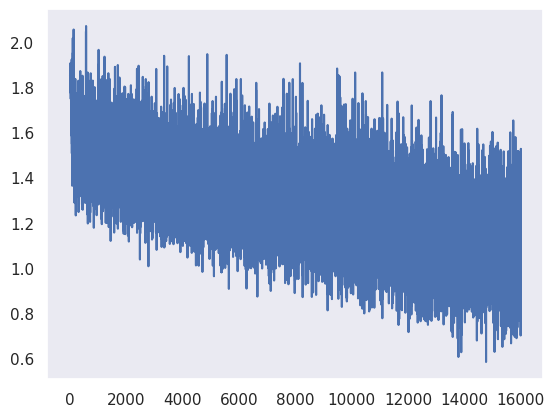

In [22]:
plt.plot(train_losses)

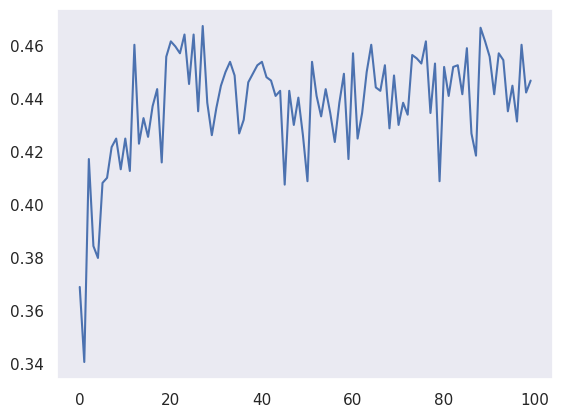

In [23]:
plt.plot(test_accuracy)

In [24]:
model_path = '../cremad_100epochs.pt' 
torch.save(model.state_dict(), model_path)

In [113]:
model2 = model.to('cpu')

In [114]:
model_path = '../cremad_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [30]:
del model
gc.collect()

55

In [32]:
model_path = '../cremad_100epochs.pt' 
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [33]:
model

M13(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (pad): PadRight()
        (layer): FirConvLayer()
        (downsample): DownsampleLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((129,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=129, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [21]:
n_epoch = 1000
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [23]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [24]:
log_interval = 150
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                      | 0.009615384615384616/1000 [00:00<19:25:53, 69.95s/it]

Train Epoch: 1 [0/5144 (0%)]	Loss: 0.885861


  0%|                                                                        | 0.7307692307692293/1000 [00:31<11:39:49, 42.02s/it]

Train Epoch: 1 [4800/5144 (94%)]	Loss: 0.901057


  0%|                                                                         | 0.9999999999999976/1000 [00:41<9:20:03, 33.64s/it]


Test Epoch: 1	Accuracy: 717/1556 (46%)



  0%|                                                                         | 1.0096153846153821/1000 [00:41<9:49:42, 35.42s/it]

Train Epoch: 2 [0/5144 (0%)]	Loss: 1.078452


  0%|                                                                        | 1.7307692307692257/1000 [01:12<11:45:31, 42.40s/it]

Train Epoch: 2 [4800/5144 (94%)]	Loss: 0.917323


  0%|▏                                                                         | 1.999999999999994/1000 [01:22<9:26:14, 34.04s/it]


Test Epoch: 2	Accuracy: 706/1556 (45%)



  0%|▏                                                                         | 2.009615384615379/1000 [01:22<9:54:54, 35.77s/it]

Train Epoch: 3 [0/5144 (0%)]	Loss: 0.857989


  0%|▏                                                                       | 2.7307692307692557/1000 [01:53<11:35:39, 41.85s/it]

Train Epoch: 3 [4800/5144 (94%)]	Loss: 0.777944


  0%|▏                                                                         | 3.004807692307729/1000 [02:03<9:55:32, 35.84s/it]


Test Epoch: 3	Accuracy: 718/1556 (46%)

Train Epoch: 4 [0/5144 (0%)]	Loss: 1.030731


  0%|▎                                                                       | 3.7307692307692983/1000 [02:34<11:34:51, 41.85s/it]

Train Epoch: 4 [4800/5144 (94%)]	Loss: 0.823707


  0%|▎                                                                         | 4.000000000000079/1000 [02:43<9:10:47, 33.18s/it]


Test Epoch: 4	Accuracy: 714/1556 (46%)



  0%|▎                                                                         | 4.009615384615464/1000 [02:44<9:41:48, 35.05s/it]

Train Epoch: 5 [0/5144 (0%)]	Loss: 0.705452


  0%|▎                                                                        | 4.730769230769341/1000 [03:15<11:51:05, 42.87s/it]

Train Epoch: 5 [4800/5144 (94%)]	Loss: 0.894164


  1%|▎                                                                         | 5.000000000000122/1000 [03:25<9:16:43, 33.57s/it]


Test Epoch: 5	Accuracy: 709/1556 (46%)



  1%|▎                                                                         | 5.009615384615507/1000 [03:25<9:49:08, 35.53s/it]

Train Epoch: 6 [0/5144 (0%)]	Loss: 0.828231


  1%|▍                                                                        | 5.730769230769384/1000 [03:57<11:59:37, 43.43s/it]

Train Epoch: 6 [4800/5144 (94%)]	Loss: 0.572349


  1%|▍                                                                         | 6.000000000000164/1000 [04:07<9:23:26, 34.01s/it]


Test Epoch: 6	Accuracy: 708/1556 (46%)



  1%|▍                                                                         | 6.009615384615549/1000 [04:07<9:49:38, 35.59s/it]

Train Epoch: 7 [0/5144 (0%)]	Loss: 0.769515


  1%|▍                                                                        | 6.730769230769426/1000 [04:39<11:55:35, 43.23s/it]

Train Epoch: 7 [4800/5144 (94%)]	Loss: 0.821053


  1%|▌                                                                         | 7.000000000000207/1000 [04:48<9:12:45, 33.40s/it]


Test Epoch: 7	Accuracy: 710/1556 (46%)



  1%|▌                                                                         | 7.009615384615592/1000 [04:49<9:43:00, 35.23s/it]

Train Epoch: 8 [0/5144 (0%)]	Loss: 0.647650


  1%|▌                                                                        | 7.730769230769469/1000 [05:21<11:53:08, 43.12s/it]

Train Epoch: 8 [4800/5144 (94%)]	Loss: 0.977683


  1%|▌                                                                         | 8.000000000000249/1000 [05:30<9:19:14, 33.82s/it]


Test Epoch: 8	Accuracy: 715/1556 (46%)



  1%|▌                                                                         | 8.009615384615632/1000 [05:31<9:47:16, 35.52s/it]

Train Epoch: 9 [0/5144 (0%)]	Loss: 0.900447


  1%|▋                                                                        | 8.730769230769376/1000 [06:03<11:59:31, 43.55s/it]

Train Epoch: 9 [4800/5144 (94%)]	Loss: 0.763886


  1%|▋                                                                         | 9.000000000000107/1000 [06:12<9:20:43, 33.95s/it]


Test Epoch: 9	Accuracy: 713/1556 (46%)



  1%|▋                                                                          | 9.00961538461549/1000 [06:13<9:49:32, 35.69s/it]

Train Epoch: 10 [0/5144 (0%)]	Loss: 0.668818


  1%|▋                                                                        | 9.730769230769234/1000 [06:45<11:57:22, 43.47s/it]

Train Epoch: 10 [4800/5144 (94%)]	Loss: 0.966970


  1%|▋                                                                         | 9.999999999999964/1000 [06:54<9:21:25, 34.03s/it]


Test Epoch: 10	Accuracy: 712/1556 (46%)



  1%|▋                                                                        | 10.009615384615348/1000 [06:55<9:49:17, 35.72s/it]

Train Epoch: 11 [0/5144 (0%)]	Loss: 0.692680


  1%|▊                                                                       | 10.730769230769091/1000 [07:27<11:48:05, 42.95s/it]

Train Epoch: 11 [4800/5144 (94%)]	Loss: 0.684507


  1%|▊                                                                        | 10.999999999999822/1000 [07:36<9:13:25, 33.57s/it]


Test Epoch: 11	Accuracy: 724/1556 (47%)



  1%|▊                                                                        | 11.009615384615206/1000 [07:37<9:55:25, 36.12s/it]

Train Epoch: 12 [0/5144 (0%)]	Loss: 0.823505


  1%|▊                                                                        | 11.73076923076895/1000 [08:09<11:48:10, 42.99s/it]

Train Epoch: 12 [4800/5144 (94%)]	Loss: 0.725212


  1%|▉                                                                         | 11.99999999999968/1000 [08:18<9:12:04, 33.53s/it]


Test Epoch: 12	Accuracy: 713/1556 (46%)



  1%|▉                                                                        | 12.009615384615064/1000 [08:18<9:41:57, 35.34s/it]

Train Epoch: 13 [0/5144 (0%)]	Loss: 0.790221


  1%|▉                                                                       | 12.730769230768807/1000 [08:50<11:45:52, 42.90s/it]

Train Epoch: 13 [4800/5144 (94%)]	Loss: 1.100057


  1%|▉                                                                        | 12.999999999999538/1000 [09:00<9:14:36, 33.72s/it]


Test Epoch: 13	Accuracy: 721/1556 (46%)



  1%|▉                                                                        | 13.009615384614921/1000 [09:00<9:41:45, 35.37s/it]

Train Epoch: 14 [0/5144 (0%)]	Loss: 0.926020


  1%|▉                                                                       | 13.730769230768665/1000 [09:32<11:43:00, 42.77s/it]

Train Epoch: 14 [4800/5144 (94%)]	Loss: 0.747308


  1%|█                                                                        | 13.999999999999396/1000 [09:41<9:14:35, 33.75s/it]


Test Epoch: 14	Accuracy: 716/1556 (46%)



  1%|█                                                                         | 14.00961538461478/1000 [09:42<9:41:12, 35.37s/it]

Train Epoch: 15 [0/5144 (0%)]	Loss: 0.831226


  1%|█                                                                       | 14.730769230768523/1000 [10:13<11:45:27, 42.96s/it]

Train Epoch: 15 [4800/5144 (94%)]	Loss: 0.612544


  1%|█                                                                        | 14.999999999999254/1000 [10:23<9:13:33, 33.72s/it]


Test Epoch: 15	Accuracy: 713/1556 (46%)



  2%|█                                                                        | 15.009615384614637/1000 [10:23<9:39:04, 35.27s/it]

Train Epoch: 16 [0/5144 (0%)]	Loss: 1.010516


  2%|█▏                                                                       | 15.73076923076838/1000 [10:55<11:53:41, 43.51s/it]

Train Epoch: 16 [4800/5144 (94%)]	Loss: 0.778862


  2%|█▏                                                                       | 15.999999999999112/1000 [11:05<9:20:09, 34.16s/it]


Test Epoch: 16	Accuracy: 714/1556 (46%)



  2%|█▏                                                                         | 16.0096153846145/1000 [11:05<9:47:38, 35.83s/it]

Train Epoch: 17 [0/5144 (0%)]	Loss: 0.686735


  2%|█▏                                                                       | 16.73076923076851/1000 [11:37<11:54:41, 43.61s/it]

Train Epoch: 17 [4800/5144 (94%)]	Loss: 0.527792


  2%|█▎                                                                        | 16.99999999999934/1000 [11:47<9:08:37, 33.49s/it]


Test Epoch: 17	Accuracy: 709/1556 (46%)



  2%|█▏                                                                       | 17.009615384614726/1000 [11:47<9:40:07, 35.41s/it]

Train Epoch: 18 [0/5144 (0%)]	Loss: 0.702935


  2%|█▎                                                                      | 17.730769230768736/1000 [12:19<11:40:45, 42.80s/it]

Train Epoch: 18 [4800/5144 (94%)]	Loss: 0.657930


  2%|█▎                                                                       | 17.999999999999567/1000 [12:28<9:06:18, 33.38s/it]


Test Epoch: 18	Accuracy: 714/1556 (46%)



  2%|█▎                                                                       | 18.009615384614953/1000 [12:29<9:35:39, 35.17s/it]

Train Epoch: 19 [0/5144 (0%)]	Loss: 1.029377


  2%|█▎                                                                      | 18.730769230768963/1000 [13:00<11:40:55, 42.86s/it]

Train Epoch: 19 [4800/5144 (94%)]	Loss: 0.939228


  2%|█▍                                                                       | 18.999999999999794/1000 [13:10<9:04:21, 33.29s/it]


Test Epoch: 19	Accuracy: 716/1556 (46%)



  2%|█▍                                                                        | 19.00961538461518/1000 [13:10<9:32:16, 35.00s/it]

Train Epoch: 20 [0/5144 (0%)]	Loss: 0.663018


  2%|█▍                                                                       | 19.73076923076919/1000 [13:42<11:38:17, 42.74s/it]

Train Epoch: 20 [4800/5144 (94%)]	Loss: 0.671578


  2%|█▍                                                                        | 20.00000000000002/1000 [13:51<9:06:11, 33.44s/it]


Test Epoch: 20	Accuracy: 709/1556 (46%)



  2%|█▍                                                                       | 20.009615384615408/1000 [13:52<9:33:57, 35.14s/it]

Train Epoch: 21 [0/5144 (0%)]	Loss: 0.674255


  2%|█▌                                                                       | 20.73076923076942/1000 [14:23<11:39:00, 42.83s/it]

Train Epoch: 21 [4800/5144 (94%)]	Loss: 0.921377


  2%|█▌                                                                        | 21.00000000000025/1000 [14:33<9:05:04, 33.41s/it]


Test Epoch: 21	Accuracy: 714/1556 (46%)



  2%|█▌                                                                       | 21.009615384615635/1000 [14:33<9:33:20, 35.14s/it]

Train Epoch: 22 [0/5144 (0%)]	Loss: 0.746647


  2%|█▌                                                                      | 21.730769230769646/1000 [15:05<11:39:23, 42.90s/it]

Train Epoch: 22 [4800/5144 (94%)]	Loss: 0.791944


  2%|█▌                                                                       | 22.000000000000476/1000 [15:14<9:05:13, 33.45s/it]


Test Epoch: 22	Accuracy: 708/1556 (46%)



  2%|█▌                                                                       | 22.009615384615863/1000 [15:15<9:34:23, 35.24s/it]

Train Epoch: 23 [0/5144 (0%)]	Loss: 0.911572


  2%|█▋                                                                      | 22.730769230769873/1000 [15:46<11:47:37, 43.45s/it]

Train Epoch: 23 [4800/5144 (94%)]	Loss: 0.732371


  2%|█▋                                                                       | 23.000000000000703/1000 [15:56<9:05:40, 33.51s/it]


Test Epoch: 23	Accuracy: 699/1556 (45%)



  2%|█▋                                                                        | 23.00961538461609/1000 [15:56<9:35:22, 35.34s/it]

Train Epoch: 24 [0/5144 (0%)]	Loss: 0.876157


  2%|█▊                                                                        | 23.7307692307701/1000 [16:28<11:37:58, 42.90s/it]

Train Epoch: 24 [4800/5144 (94%)]	Loss: 0.679882


  2%|█▊                                                                        | 24.00000000000093/1000 [16:37<9:07:22, 33.65s/it]


Test Epoch: 24	Accuracy: 710/1556 (46%)



  2%|█▊                                                                       | 24.009615384616318/1000 [16:38<9:32:46, 35.21s/it]

Train Epoch: 25 [0/5144 (0%)]	Loss: 0.806752


  2%|█▊                                                                      | 24.730769230770328/1000 [17:10<11:38:58, 43.00s/it]

Train Epoch: 25 [4800/5144 (94%)]	Loss: 0.612647


  3%|█▊                                                                       | 25.000000000001158/1000 [17:19<9:04:34, 33.51s/it]


Test Epoch: 25	Accuracy: 700/1556 (45%)



  3%|█▊                                                                       | 25.009615384616545/1000 [17:19<9:32:44, 35.25s/it]

Train Epoch: 26 [0/5144 (0%)]	Loss: 0.722109


  3%|█▊                                                                      | 25.730769230770555/1000 [17:51<11:39:55, 43.11s/it]

Train Epoch: 26 [4800/5144 (94%)]	Loss: 0.914774


  3%|█▉                                                                       | 26.000000000001386/1000 [18:01<9:03:44, 33.50s/it]


Test Epoch: 26	Accuracy: 704/1556 (45%)



  3%|█▉                                                                       | 26.009615384616772/1000 [18:01<9:32:23, 35.26s/it]

Train Epoch: 27 [0/5144 (0%)]	Loss: 0.678374


  3%|█▉                                                                      | 26.730769230770782/1000 [18:33<11:59:24, 44.35s/it]

Train Epoch: 27 [4800/5144 (94%)]	Loss: 0.895877


  3%|█▉                                                                       | 27.000000000001613/1000 [18:42<9:12:41, 34.08s/it]


Test Epoch: 27	Accuracy: 705/1556 (45%)



  3%|██                                                                          | 27.009615384617/1000 [18:43<9:42:06, 35.90s/it]

Train Epoch: 28 [0/5144 (0%)]	Loss: 0.967383


  3%|██                                                                       | 27.73076923077101/1000 [19:15<11:42:41, 43.36s/it]

Train Epoch: 28 [4800/5144 (94%)]	Loss: 0.590125


  3%|██                                                                        | 28.00000000000184/1000 [19:25<9:11:18, 34.03s/it]


Test Epoch: 28	Accuracy: 709/1556 (46%)



  3%|██                                                                       | 28.009615384617227/1000 [19:25<9:39:26, 35.77s/it]

Train Epoch: 29 [0/5144 (0%)]	Loss: 0.628140


  3%|██                                                                      | 28.730769230771237/1000 [19:57<11:42:36, 43.40s/it]

Train Epoch: 29 [4800/5144 (94%)]	Loss: 0.749642


  3%|██                                                                       | 29.000000000002068/1000 [20:07<9:10:49, 34.04s/it]


Test Epoch: 29	Accuracy: 700/1556 (45%)



  3%|██                                                                       | 29.009615384617454/1000 [20:07<9:38:47, 35.77s/it]

Train Epoch: 30 [0/5144 (0%)]	Loss: 0.696546


  3%|██▏                                                                     | 29.730769230771465/1000 [20:39<11:42:38, 43.45s/it]

Train Epoch: 30 [4800/5144 (94%)]	Loss: 0.823732


  3%|██▏                                                                      | 30.000000000002295/1000 [20:49<8:59:10, 33.35s/it]


Test Epoch: 30	Accuracy: 701/1556 (45%)



  3%|██▏                                                                      | 30.009615384617682/1000 [20:49<9:28:44, 35.18s/it]

Train Epoch: 31 [0/5144 (0%)]	Loss: 0.491507


  3%|██▏                                                                     | 30.730769230771692/1000 [21:21<11:31:29, 42.81s/it]

Train Epoch: 31 [4800/5144 (94%)]	Loss: 0.854524


  3%|██▎                                                                      | 31.000000000002522/1000 [21:30<9:00:02, 33.44s/it]


Test Epoch: 31	Accuracy: 709/1556 (46%)



  3%|██▎                                                                       | 31.00961538461791/1000 [21:31<9:29:50, 35.28s/it]

Train Epoch: 32 [0/5144 (0%)]	Loss: 0.634527


  3%|██▎                                                                      | 31.73076923077192/1000 [22:02<11:33:11, 42.95s/it]

Train Epoch: 32 [4800/5144 (94%)]	Loss: 0.640661


  3%|██▎                                                                       | 32.00000000000275/1000 [22:12<8:59:09, 33.42s/it]


Test Epoch: 32	Accuracy: 706/1556 (45%)



  3%|██▎                                                                       | 32.00961538461814/1000 [22:12<9:28:53, 35.26s/it]

Train Epoch: 33 [0/5144 (0%)]	Loss: 0.710316


  3%|██▍                                                                      | 32.73076923077215/1000 [22:44<11:30:13, 42.81s/it]

Train Epoch: 33 [4800/5144 (94%)]	Loss: 0.682582


  3%|██▍                                                                       | 33.00000000000298/1000 [22:54<9:03:45, 33.74s/it]


Test Epoch: 33	Accuracy: 694/1556 (45%)



  3%|██▍                                                                      | 33.009615384618364/1000 [22:54<9:32:58, 35.55s/it]

Train Epoch: 34 [0/5144 (0%)]	Loss: 0.879431


  3%|██▍                                                                     | 33.730769230772374/1000 [23:26<11:34:57, 43.15s/it]

Train Epoch: 34 [4800/5144 (94%)]	Loss: 0.979547


  3%|██▍                                                                      | 34.000000000003205/1000 [23:35<9:03:33, 33.76s/it]


Test Epoch: 34	Accuracy: 704/1556 (45%)



  3%|██▌                                                                       | 34.00961538461859/1000 [23:36<9:30:52, 35.46s/it]

Train Epoch: 35 [0/5144 (0%)]	Loss: 0.560639


  3%|██▌                                                                       | 34.7307692307726/1000 [24:08<11:36:33, 43.30s/it]

Train Epoch: 35 [4800/5144 (94%)]	Loss: 0.872718


  4%|██▌                                                                       | 35.00000000000343/1000 [24:17<9:02:18, 33.72s/it]


Test Epoch: 35	Accuracy: 695/1556 (45%)



  4%|██▌                                                                       | 35.00961538461882/1000 [24:18<9:33:05, 35.63s/it]

Train Epoch: 36 [0/5144 (0%)]	Loss: 0.653763


  4%|██▌                                                                      | 35.73076923077283/1000 [24:49<11:32:22, 43.08s/it]

Train Epoch: 36 [4800/5144 (94%)]	Loss: 0.700318


  4%|██▋                                                                       | 36.00000000000366/1000 [24:59<9:00:31, 33.64s/it]


Test Epoch: 36	Accuracy: 707/1556 (45%)



  4%|██▋                                                                      | 36.009615384619046/1000 [24:59<9:31:16, 35.56s/it]

Train Epoch: 37 [0/5144 (0%)]	Loss: 0.678469


  4%|██▋                                                                     | 36.730769230773056/1000 [25:31<11:34:44, 43.27s/it]

Train Epoch: 37 [4800/5144 (94%)]	Loss: 1.021861


  4%|██▋                                                                       | 37.00000000000389/1000 [25:41<9:02:45, 33.82s/it]


Test Epoch: 37	Accuracy: 702/1556 (45%)



  4%|██▋                                                                       | 37.00961538461927/1000 [25:41<9:35:35, 35.86s/it]

Train Epoch: 38 [0/5144 (0%)]	Loss: 0.586868


  4%|██▋                                                                     | 37.730769230773284/1000 [26:13<11:31:12, 43.10s/it]

Train Epoch: 38 [4800/5144 (94%)]	Loss: 0.698016


  4%|██▊                                                                      | 38.000000000004114/1000 [26:23<9:28:50, 35.48s/it]


Test Epoch: 38	Accuracy: 695/1556 (45%)



  4%|██▊                                                                        | 38.0096153846195/1000 [26:23<9:42:05, 36.31s/it]

Train Epoch: 39 [0/5144 (0%)]	Loss: 0.821420


  4%|██▊                                                                      | 38.73076923077351/1000 [26:55<11:26:55, 42.88s/it]

Train Epoch: 39 [4800/5144 (94%)]	Loss: 0.782314


  4%|██▉                                                                       | 39.00000000000434/1000 [27:04<8:55:05, 33.41s/it]


Test Epoch: 39	Accuracy: 696/1556 (45%)



  4%|██▉                                                                       | 39.00961538461973/1000 [27:05<9:21:50, 35.08s/it]

Train Epoch: 40 [0/5144 (0%)]	Loss: 0.796523


  4%|██▉                                                                      | 39.73076923077374/1000 [27:37<11:30:30, 43.14s/it]

Train Epoch: 40 [4800/5144 (94%)]	Loss: 0.736884


  4%|██▉                                                                       | 40.00000000000457/1000 [27:46<9:59:26, 37.46s/it]


Test Epoch: 40	Accuracy: 704/1556 (45%)



  4%|██▉                                                                      | 40.009615384619956/1000 [27:47<9:55:59, 37.25s/it]

Train Epoch: 41 [0/5144 (0%)]	Loss: 0.825904


  4%|██▉                                                                     | 40.730769230773966/1000 [28:18<11:27:26, 43.00s/it]

Train Epoch: 41 [4800/5144 (94%)]	Loss: 0.692458


  4%|██▉                                                                      | 41.000000000004796/1000 [28:28<8:57:34, 33.63s/it]


Test Epoch: 41	Accuracy: 693/1556 (45%)



  4%|███                                                                       | 41.00961538462018/1000 [28:28<9:25:22, 35.37s/it]

Train Epoch: 42 [0/5144 (0%)]	Loss: 0.508654


  4%|███                                                                      | 41.73076923077419/1000 [29:00<11:33:42, 43.43s/it]

Train Epoch: 42 [4800/5144 (94%)]	Loss: 0.914947


  4%|███                                                                       | 42.00000000000502/1000 [29:10<9:03:24, 34.03s/it]


Test Epoch: 42	Accuracy: 690/1556 (44%)



  4%|███                                                                       | 42.00961538462041/1000 [29:10<9:33:44, 35.93s/it]

Train Epoch: 43 [0/5144 (0%)]	Loss: 0.651635


  4%|███                                                                      | 42.73076923077442/1000 [29:42<11:37:44, 43.73s/it]

Train Epoch: 43 [4800/5144 (94%)]	Loss: 0.741881


  4%|███▏                                                                      | 43.00000000000525/1000 [29:52<8:54:18, 33.50s/it]


Test Epoch: 43	Accuracy: 693/1556 (45%)



  4%|███▏                                                                      | 43.00961538462064/1000 [29:52<9:21:33, 35.21s/it]

Train Epoch: 44 [0/5144 (0%)]	Loss: 0.788838


  4%|███▏                                                                     | 43.73076923077465/1000 [30:24<11:25:31, 43.01s/it]

Train Epoch: 44 [4800/5144 (94%)]	Loss: 0.687687


  4%|███▎                                                                      | 44.00000000000548/1000 [30:34<8:56:35, 33.68s/it]


Test Epoch: 44	Accuracy: 678/1556 (44%)



  4%|███▏                                                                     | 44.009615384620865/1000 [30:34<9:24:17, 35.42s/it]

Train Epoch: 45 [0/5144 (0%)]	Loss: 0.594721


  4%|███▏                                                                    | 44.730769230774875/1000 [31:06<11:24:42, 43.01s/it]

Train Epoch: 45 [4800/5144 (94%)]	Loss: 0.479281


  5%|███▎                                                                     | 45.000000000005706/1000 [31:15<8:54:24, 33.58s/it]


Test Epoch: 45	Accuracy: 695/1556 (45%)



  5%|███▎                                                                      | 45.00961538462109/1000 [31:16<9:22:37, 35.35s/it]

Train Epoch: 46 [0/5144 (0%)]	Loss: 0.788545


  5%|███▍                                                                      | 45.7307692307751/1000 [31:48<11:28:29, 43.29s/it]

Train Epoch: 46 [4800/5144 (94%)]	Loss: 0.533014


  5%|███▍                                                                      | 46.00000000000593/1000 [31:57<8:55:49, 33.70s/it]


Test Epoch: 46	Accuracy: 689/1556 (44%)



  5%|███▍                                                                      | 46.00961538462132/1000 [31:57<9:22:54, 35.40s/it]

Train Epoch: 47 [0/5144 (0%)]	Loss: 0.765896


  5%|███▍                                                                     | 46.73076923077533/1000 [32:29<11:27:48, 43.29s/it]

Train Epoch: 47 [4800/5144 (94%)]	Loss: 0.708771


  5%|███▍                                                                      | 47.00000000000616/1000 [32:39<8:56:44, 33.79s/it]


Test Epoch: 47	Accuracy: 695/1556 (45%)



  5%|███▍                                                                      | 47.00961538462155/1000 [32:39<9:23:00, 35.45s/it]

Train Epoch: 48 [0/5144 (0%)]	Loss: 0.495549


  5%|███▍                                                                     | 47.73076923077556/1000 [33:11<11:23:48, 43.08s/it]

Train Epoch: 48 [4800/5144 (94%)]	Loss: 0.884481


  5%|███▌                                                                      | 48.00000000000639/1000 [33:21<8:52:16, 33.55s/it]


Test Epoch: 48	Accuracy: 682/1556 (44%)



  5%|███▌                                                                     | 48.009615384621775/1000 [33:21<9:18:52, 35.22s/it]

Train Epoch: 49 [0/5144 (0%)]	Loss: 0.570537


  5%|███▌                                                                    | 48.730769230775785/1000 [33:53<11:24:16, 43.16s/it]

Train Epoch: 49 [4800/5144 (94%)]	Loss: 0.694388


  5%|███▌                                                                     | 49.000000000006615/1000 [34:02<8:53:54, 33.69s/it]


Test Epoch: 49	Accuracy: 689/1556 (44%)



  5%|███▋                                                                        | 49.009615384622/1000 [34:03<9:23:51, 35.57s/it]

Train Epoch: 50 [0/5144 (0%)]	Loss: 0.535066


  5%|███▋                                                                     | 49.73076923077601/1000 [34:35<11:29:03, 43.51s/it]

Train Epoch: 50 [4800/5144 (94%)]	Loss: 0.574193


  5%|███▋                                                                      | 50.00000000000684/1000 [34:44<8:59:02, 34.05s/it]


Test Epoch: 50	Accuracy: 677/1556 (44%)



  5%|███▋                                                                      | 50.00961538462223/1000 [34:45<9:26:11, 35.76s/it]

Train Epoch: 51 [0/5144 (0%)]	Loss: 0.455228


  5%|███▋                                                                     | 50.73076923077624/1000 [35:17<11:26:54, 43.42s/it]

Train Epoch: 51 [4800/5144 (94%)]	Loss: 0.454192


  5%|███▊                                                                      | 51.00000000000707/1000 [35:27<9:00:35, 34.18s/it]


Test Epoch: 51	Accuracy: 676/1556 (43%)



  5%|███▊                                                                      | 51.00961538462246/1000 [35:27<9:26:39, 35.83s/it]

Train Epoch: 52 [0/5144 (0%)]	Loss: 0.594500


  5%|███▊                                                                     | 51.73076923077647/1000 [35:59<11:28:44, 43.58s/it]

Train Epoch: 52 [4800/5144 (94%)]	Loss: 0.494240


  5%|███▉                                                                       | 52.0000000000073/1000 [36:09<8:58:59, 34.11s/it]


Test Epoch: 52	Accuracy: 684/1556 (44%)



  5%|███▊                                                                     | 52.009615384622684/1000 [36:09<9:25:04, 35.76s/it]

Train Epoch: 53 [0/5144 (0%)]	Loss: 0.543003


  5%|███▊                                                                    | 52.730769230776694/1000 [36:41<11:16:59, 42.88s/it]

Train Epoch: 53 [4800/5144 (94%)]	Loss: 0.437491


  5%|███▊                                                                     | 53.000000000007525/1000 [36:50<8:48:48, 33.50s/it]


Test Epoch: 53	Accuracy: 685/1556 (44%)



  5%|███▉                                                                      | 53.00961538462291/1000 [36:51<9:15:02, 35.17s/it]

Train Epoch: 54 [0/5144 (0%)]	Loss: 0.626553


  5%|███▉                                                                     | 53.73076923077692/1000 [37:23<11:17:47, 42.98s/it]

Train Epoch: 54 [4800/5144 (94%)]	Loss: 0.677040


  5%|███▉                                                                      | 54.00000000000775/1000 [37:32<8:47:43, 33.47s/it]


Test Epoch: 54	Accuracy: 683/1556 (44%)



  5%|███▉                                                                      | 54.00961538462314/1000 [37:32<9:16:11, 35.28s/it]

Train Epoch: 55 [0/5144 (0%)]	Loss: 0.747756


  5%|███▉                                                                     | 54.73076923077715/1000 [38:04<11:23:24, 43.38s/it]

Train Epoch: 55 [4800/5144 (94%)]	Loss: 0.637684


  6%|████                                                                      | 55.00000000000798/1000 [38:14<8:55:44, 34.02s/it]


Test Epoch: 55	Accuracy: 682/1556 (44%)



  6%|████                                                                     | 55.009615384623366/1000 [38:14<9:23:50, 35.80s/it]

Train Epoch: 56 [0/5144 (0%)]	Loss: 0.713118


  6%|████                                                                    | 55.730769230777376/1000 [38:47<11:27:03, 43.66s/it]

Train Epoch: 56 [4800/5144 (94%)]	Loss: 0.840834


  6%|████▏                                                                     | 56.00000000000821/1000 [38:56<9:12:28, 35.12s/it]


Test Epoch: 56	Accuracy: 683/1556 (44%)



  6%|████                                                                     | 56.009615384623594/1000 [38:57<9:34:31, 36.52s/it]

Train Epoch: 57 [0/5144 (0%)]	Loss: 0.497714


  6%|████                                                                    | 56.730769230777604/1000 [39:29<11:25:49, 43.62s/it]

Train Epoch: 57 [4800/5144 (94%)]	Loss: 0.623536


  6%|████▏                                                                    | 57.000000000008434/1000 [39:39<8:52:33, 33.89s/it]


Test Epoch: 57	Accuracy: 684/1556 (44%)



  6%|████▏                                                                     | 57.00961538462382/1000 [39:39<9:17:36, 35.48s/it]

Train Epoch: 58 [0/5144 (0%)]	Loss: 0.683624


  6%|████▏                                                                    | 57.73076923077783/1000 [40:11<11:13:15, 42.87s/it]

Train Epoch: 58 [4800/5144 (94%)]	Loss: 0.432399


  6%|████▎                                                                     | 58.00000000000866/1000 [40:20<8:46:07, 33.51s/it]


Test Epoch: 58	Accuracy: 663/1556 (43%)



  6%|████▎                                                                     | 58.00961538462405/1000 [40:21<9:13:33, 35.26s/it]

Train Epoch: 59 [0/5144 (0%)]	Loss: 0.671958


  6%|████▎                                                                    | 58.73076923077806/1000 [40:52<11:13:45, 42.95s/it]

Train Epoch: 59 [4800/5144 (94%)]	Loss: 0.426856


  6%|████▎                                                                     | 59.00000000000889/1000 [41:02<8:46:36, 33.58s/it]


Test Epoch: 59	Accuracy: 664/1556 (43%)



  6%|████▎                                                                    | 59.009615384624276/1000 [41:02<9:14:05, 35.33s/it]

Train Epoch: 60 [0/5144 (0%)]	Loss: 0.568318


  6%|████▎                                                                   | 59.730769230778286/1000 [41:34<11:12:30, 42.91s/it]

Train Epoch: 60 [4800/5144 (94%)]	Loss: 0.796025


  6%|████▍                                                                    | 60.000000000009116/1000 [41:43<8:44:59, 33.51s/it]


Test Epoch: 60	Accuracy: 677/1556 (44%)



  6%|████▌                                                                      | 60.0096153846245/1000 [41:44<9:12:36, 35.27s/it]

Train Epoch: 61 [0/5144 (0%)]	Loss: 0.509757


  6%|████▍                                                                    | 60.73076923077851/1000 [42:16<11:21:41, 43.55s/it]

Train Epoch: 61 [4800/5144 (94%)]	Loss: 0.554887


  6%|████▍                                                                    | 61.000000000009344/1000 [42:25<8:59:15, 34.46s/it]


Test Epoch: 61	Accuracy: 666/1556 (43%)



  6%|████▌                                                                     | 61.00961538462473/1000 [42:26<9:25:33, 36.14s/it]

Train Epoch: 62 [0/5144 (0%)]	Loss: 0.534402


  6%|████▌                                                                    | 61.73076923077874/1000 [42:58<11:12:11, 42.98s/it]

Train Epoch: 62 [4800/5144 (94%)]	Loss: 0.910257


  6%|████▌                                                                     | 62.00000000000957/1000 [43:07<8:43:58, 33.52s/it]


Test Epoch: 62	Accuracy: 676/1556 (43%)



  6%|████▌                                                                     | 62.00961538462496/1000 [43:08<9:10:38, 35.22s/it]

Train Epoch: 63 [0/5144 (0%)]	Loss: 0.616727


  6%|████▌                                                                    | 62.73076923077897/1000 [43:39<11:26:12, 43.93s/it]

Train Epoch: 63 [4800/5144 (94%)]	Loss: 0.878559


  6%|████▋                                                                      | 63.0000000000098/1000 [43:49<8:55:31, 34.29s/it]


Test Epoch: 63	Accuracy: 675/1556 (43%)



  6%|████▌                                                                    | 63.009615384625185/1000 [43:50<9:24:05, 36.12s/it]

Train Epoch: 64 [0/5144 (0%)]	Loss: 0.685353


  6%|████▌                                                                   | 63.730769230779195/1000 [44:22<11:23:02, 43.77s/it]

Train Epoch: 64 [4800/5144 (94%)]	Loss: 0.497805


  6%|████▋                                                                     | 64.00000000001002/1000 [44:32<8:54:36, 34.27s/it]


Test Epoch: 64	Accuracy: 660/1556 (42%)



  6%|████▊                                                                      | 64.0096153846254/1000 [44:32<9:24:29, 36.19s/it]

Train Epoch: 65 [0/5144 (0%)]	Loss: 0.599961


  6%|████▋                                                                    | 64.73076923077942/1000 [45:04<11:19:57, 43.62s/it]

Train Epoch: 65 [4800/5144 (94%)]	Loss: 0.548224


  7%|████▊                                                                     | 65.00000000001025/1000 [45:14<8:53:59, 34.27s/it]


Test Epoch: 65	Accuracy: 659/1556 (42%)



  7%|████▊                                                                     | 65.00961538462563/1000 [45:14<9:20:22, 35.96s/it]

Train Epoch: 66 [0/5144 (0%)]	Loss: 0.550112


  7%|████▊                                                                    | 65.73076923077964/1000 [45:47<11:20:29, 43.70s/it]

Train Epoch: 66 [4800/5144 (94%)]	Loss: 0.525055


  7%|████▉                                                                     | 66.00000000001047/1000 [45:56<8:55:05, 34.37s/it]


Test Epoch: 66	Accuracy: 672/1556 (43%)



  7%|████▉                                                                     | 66.00961538462586/1000 [45:57<9:22:03, 36.11s/it]

Train Epoch: 67 [0/5144 (0%)]	Loss: 0.449334


  7%|████▊                                                                    | 66.73076923077987/1000 [46:29<11:19:45, 43.70s/it]

Train Epoch: 67 [4800/5144 (94%)]	Loss: 0.470617


  7%|█████                                                                      | 67.0000000000107/1000 [46:39<8:54:56, 34.40s/it]


Test Epoch: 67	Accuracy: 671/1556 (43%)



  7%|████▉                                                                     | 67.00961538462609/1000 [46:39<9:20:53, 36.07s/it]

Train Epoch: 68 [0/5144 (0%)]	Loss: 0.925322


  7%|█████                                                                     | 67.7307692307801/1000 [47:11<11:26:33, 44.19s/it]

Train Epoch: 68 [4800/5144 (94%)]	Loss: 0.629870


  7%|█████                                                                     | 68.00000000001093/1000 [47:21<8:53:03, 34.32s/it]


Test Epoch: 68	Accuracy: 676/1556 (43%)



  7%|█████                                                                     | 68.00961538462631/1000 [47:21<9:20:08, 36.06s/it]

Train Epoch: 69 [0/5144 (0%)]	Loss: 0.344821


  7%|█████                                                                    | 68.73076923078033/1000 [47:54<11:36:26, 44.87s/it]

Train Epoch: 69 [4800/5144 (94%)]	Loss: 0.556628


  7%|█████                                                                     | 69.00000000001116/1000 [48:03<8:53:47, 34.40s/it]


Test Epoch: 69	Accuracy: 678/1556 (44%)



  7%|█████                                                                     | 69.00961538462654/1000 [48:04<9:20:49, 36.14s/it]

Train Epoch: 70 [0/5144 (0%)]	Loss: 0.400197


  7%|█████                                                                    | 69.73076923078055/1000 [48:36<11:09:44, 43.20s/it]

Train Epoch: 70 [4800/5144 (94%)]	Loss: 0.696588


  7%|█████▏                                                                    | 70.00000000001138/1000 [48:46<8:42:34, 33.71s/it]


Test Epoch: 70	Accuracy: 673/1556 (43%)



  7%|█████▏                                                                    | 70.00961538462677/1000 [48:46<9:10:39, 35.53s/it]

Train Epoch: 71 [0/5144 (0%)]	Loss: 0.450243


  7%|█████▏                                                                   | 70.73076923078078/1000 [49:18<11:08:59, 43.19s/it]

Train Epoch: 71 [4800/5144 (94%)]	Loss: 0.728075


  7%|█████▎                                                                    | 71.00000000001161/1000 [49:27<8:49:34, 34.20s/it]


Test Epoch: 71	Accuracy: 669/1556 (43%)



  7%|█████▍                                                                      | 71.009615384627/1000 [49:28<9:15:34, 35.88s/it]

Train Epoch: 72 [0/5144 (0%)]	Loss: 0.913127


  7%|█████▏                                                                   | 71.73076923078101/1000 [50:00<11:12:35, 43.47s/it]

Train Epoch: 72 [4800/5144 (94%)]	Loss: 0.352253


  7%|█████▎                                                                    | 72.00000000001184/1000 [50:10<8:51:40, 34.38s/it]


Test Epoch: 72	Accuracy: 672/1556 (43%)



  7%|█████▎                                                                    | 72.00961538462722/1000 [50:10<9:15:50, 35.94s/it]

Train Epoch: 73 [0/5144 (0%)]	Loss: 0.441384


  7%|█████▎                                                                   | 72.73076923078123/1000 [50:42<11:15:17, 43.70s/it]

Train Epoch: 73 [4800/5144 (94%)]	Loss: 0.552582


  7%|█████▍                                                                    | 73.00000000001207/1000 [50:52<8:47:43, 34.16s/it]


Test Epoch: 73	Accuracy: 665/1556 (43%)



  7%|█████▍                                                                    | 73.00961538462745/1000 [50:52<9:15:08, 35.93s/it]

Train Epoch: 74 [0/5144 (0%)]	Loss: 0.519986


  7%|█████▍                                                                   | 73.73076923078146/1000 [51:25<11:10:00, 43.40s/it]

Train Epoch: 74 [4800/5144 (94%)]	Loss: 0.465238


  7%|█████▍                                                                    | 74.00000000001229/1000 [51:34<8:45:53, 34.07s/it]


Test Epoch: 74	Accuracy: 671/1556 (43%)



  7%|█████▍                                                                    | 74.00961538462768/1000 [51:35<9:13:43, 35.88s/it]

Train Epoch: 75 [0/5144 (0%)]	Loss: 0.428419


  7%|█████▍                                                                   | 74.73076923078169/1000 [52:07<11:10:04, 43.45s/it]

Train Epoch: 75 [4800/5144 (94%)]	Loss: 0.364563


  8%|█████▌                                                                    | 75.00000000001252/1000 [52:16<8:46:10, 34.13s/it]


Test Epoch: 75	Accuracy: 669/1556 (43%)



  8%|█████▋                                                                     | 75.0096153846279/1000 [52:17<9:11:58, 35.80s/it]

Train Epoch: 76 [0/5144 (0%)]	Loss: 0.571252


  8%|█████▌                                                                   | 75.73076923078192/1000 [52:49<11:09:35, 43.47s/it]

Train Epoch: 76 [4800/5144 (94%)]	Loss: 0.407846


  8%|█████▌                                                                    | 76.00000000001275/1000 [52:59<8:48:54, 34.34s/it]


Test Epoch: 76	Accuracy: 677/1556 (44%)



  8%|█████▌                                                                    | 76.00961538462813/1000 [52:59<9:13:29, 35.94s/it]

Train Epoch: 77 [0/5144 (0%)]	Loss: 0.539585


  8%|█████▌                                                                   | 76.73076923078214/1000 [53:31<11:09:39, 43.52s/it]

Train Epoch: 77 [4800/5144 (94%)]	Loss: 0.654554


  8%|█████▋                                                                    | 77.00000000001297/1000 [53:41<8:50:38, 34.49s/it]


Test Epoch: 77	Accuracy: 671/1556 (43%)



  8%|█████▋                                                                    | 77.00961538462836/1000 [53:41<9:16:07, 36.15s/it]

Train Epoch: 78 [0/5144 (0%)]	Loss: 0.482085


  8%|█████▋                                                                   | 77.73076923078237/1000 [54:13<11:09:37, 43.56s/it]

Train Epoch: 78 [4800/5144 (94%)]	Loss: 0.836571


  8%|█████▊                                                                     | 78.0000000000132/1000 [54:23<9:21:43, 36.56s/it]


Test Epoch: 78	Accuracy: 666/1556 (43%)



  8%|█████▊                                                                    | 78.00961538462859/1000 [54:23<9:32:42, 37.27s/it]

Train Epoch: 79 [0/5144 (0%)]	Loss: 0.587553


  8%|█████▊                                                                    | 78.7307692307826/1000 [54:56<11:05:30, 43.34s/it]

Train Epoch: 79 [4800/5144 (94%)]	Loss: 0.446948


  8%|█████▊                                                                    | 79.00000000001343/1000 [55:05<8:34:52, 33.54s/it]


Test Epoch: 79	Accuracy: 662/1556 (43%)



  8%|█████▊                                                                    | 79.00961538462882/1000 [55:05<9:02:20, 35.33s/it]

Train Epoch: 80 [0/5144 (0%)]	Loss: 0.500138


  8%|█████▊                                                                   | 79.73076923078283/1000 [55:37<10:59:57, 43.03s/it]

Train Epoch: 80 [4800/5144 (94%)]	Loss: 0.380731


  8%|█████▉                                                                    | 80.00000000001366/1000 [55:47<8:36:44, 33.70s/it]


Test Epoch: 80	Accuracy: 663/1556 (43%)



  8%|█████▉                                                                    | 80.00961538462904/1000 [55:47<9:03:45, 35.46s/it]

Train Epoch: 81 [0/5144 (0%)]	Loss: 0.315933


  8%|█████▉                                                                   | 80.73076923078305/1000 [56:19<11:03:35, 43.31s/it]

Train Epoch: 81 [4800/5144 (94%)]	Loss: 0.860585


  8%|█████▉                                                                    | 81.00000000001388/1000 [56:29<8:43:23, 34.17s/it]


Test Epoch: 81	Accuracy: 654/1556 (42%)



  8%|█████▉                                                                    | 81.00961538462927/1000 [56:29<9:06:32, 35.68s/it]

Train Epoch: 82 [0/5144 (0%)]	Loss: 0.498818


  8%|█████▉                                                                   | 81.73076923078328/1000 [57:01<11:08:22, 43.67s/it]

Train Epoch: 82 [4800/5144 (94%)]	Loss: 0.463105


  8%|██████                                                                    | 82.00000000001411/1000 [57:11<8:45:18, 34.33s/it]


Test Epoch: 82	Accuracy: 663/1556 (43%)



  8%|██████▏                                                                    | 82.0096153846295/1000 [57:11<9:11:59, 36.08s/it]

Train Epoch: 83 [0/5144 (0%)]	Loss: 0.392446


  8%|██████                                                                   | 82.73076923078351/1000 [57:43<11:10:27, 43.86s/it]

Train Epoch: 83 [4800/5144 (94%)]	Loss: 0.664786


  8%|██████▏                                                                   | 83.00000000001434/1000 [57:53<8:44:07, 34.29s/it]


Test Epoch: 83	Accuracy: 654/1556 (42%)



  8%|██████▏                                                                   | 83.00961538462973/1000 [57:53<9:11:32, 36.09s/it]

Train Epoch: 84 [0/5144 (0%)]	Loss: 0.681672


  8%|██████                                                                   | 83.73076923078374/1000 [58:26<11:09:34, 43.85s/it]

Train Epoch: 84 [4800/5144 (94%)]	Loss: 0.563160


  8%|██████▏                                                                   | 84.00000000001457/1000 [58:35<8:34:41, 33.71s/it]


Test Epoch: 84	Accuracy: 670/1556 (43%)



  8%|██████▏                                                                   | 84.00961538462995/1000 [58:36<9:01:41, 35.48s/it]

Train Epoch: 85 [0/5144 (0%)]	Loss: 0.340611


  8%|██████▏                                                                  | 84.73076923078396/1000 [59:07<10:58:41, 43.18s/it]

Train Epoch: 85 [4800/5144 (94%)]	Loss: 0.613985


  9%|██████▍                                                                    | 85.0000000000148/1000 [59:17<8:36:53, 33.89s/it]


Test Epoch: 85	Accuracy: 656/1556 (42%)



  9%|██████▎                                                                   | 85.00961538463018/1000 [59:17<9:02:31, 35.58s/it]

Train Epoch: 86 [0/5144 (0%)]	Loss: 0.357722


  9%|██████▎                                                                  | 85.73076923078419/1000 [59:49<10:55:27, 43.02s/it]

Train Epoch: 86 [4800/5144 (94%)]	Loss: 0.373320


  9%|██████▎                                                                   | 86.00000000001502/1000 [59:59<8:34:30, 33.77s/it]


Test Epoch: 86	Accuracy: 641/1556 (41%)



  9%|██████▎                                                                   | 86.00961538463041/1000 [59:59<8:59:50, 35.44s/it]

Train Epoch: 87 [0/5144 (0%)]	Loss: 0.255180


  9%|██████▏                                                                | 86.73076923078442/1000 [1:00:31<10:53:13, 42.92s/it]

Train Epoch: 87 [4800/5144 (94%)]	Loss: 0.547956


  9%|██████▎                                                                 | 87.00000000001525/1000 [1:00:40<8:29:28, 33.48s/it]


Test Epoch: 87	Accuracy: 662/1556 (43%)



  9%|██████▎                                                                 | 87.00961538463064/1000 [1:00:41<8:56:44, 35.27s/it]

Train Epoch: 88 [0/5144 (0%)]	Loss: 0.307804


  9%|██████▏                                                                | 87.73076923078465/1000 [1:01:13<10:57:51, 43.27s/it]

Train Epoch: 88 [4800/5144 (94%)]	Loss: 0.485841


  9%|██████▎                                                                 | 88.00000000001548/1000 [1:01:22<8:33:57, 33.81s/it]


Test Epoch: 88	Accuracy: 663/1556 (43%)



  9%|██████▎                                                                 | 88.00961538463086/1000 [1:01:23<8:59:55, 35.52s/it]

Train Epoch: 89 [0/5144 (0%)]	Loss: 0.332267


  9%|██████▎                                                                | 88.73076923078487/1000 [1:01:54<10:56:35, 43.23s/it]

Train Epoch: 89 [4800/5144 (94%)]	Loss: 0.508066


  9%|██████▍                                                                  | 89.0000000000157/1000 [1:02:04<8:31:33, 33.69s/it]


Test Epoch: 89	Accuracy: 660/1556 (42%)



  9%|██████▍                                                                 | 89.00961538463109/1000 [1:02:04<8:57:51, 35.42s/it]

Train Epoch: 90 [0/5144 (0%)]	Loss: 0.311865


  9%|██████▍                                                                 | 89.7307692307851/1000 [1:02:36<10:54:48, 43.16s/it]

Train Epoch: 90 [4800/5144 (94%)]	Loss: 0.449885


  9%|██████▍                                                                 | 90.00000000001593/1000 [1:02:46<8:32:51, 33.81s/it]


Test Epoch: 90	Accuracy: 662/1556 (43%)



  9%|██████▍                                                                 | 90.00961538463132/1000 [1:02:46<8:59:37, 35.58s/it]

Train Epoch: 91 [0/5144 (0%)]	Loss: 0.356672


  9%|██████▍                                                                | 90.73076923078533/1000 [1:03:18<11:01:51, 43.67s/it]

Train Epoch: 91 [4800/5144 (94%)]	Loss: 0.535527


  9%|██████▌                                                                 | 91.00000000001616/1000 [1:03:28<8:38:35, 34.23s/it]


Test Epoch: 91	Accuracy: 660/1556 (42%)



  9%|██████▌                                                                 | 91.00961538463154/1000 [1:03:29<9:09:02, 36.24s/it]

Train Epoch: 92 [0/5144 (0%)]	Loss: 0.374312


  9%|██████▌                                                                | 91.73076923078555/1000 [1:04:01<11:02:53, 43.79s/it]

Train Epoch: 92 [4800/5144 (94%)]	Loss: 0.648819


  9%|██████▌                                                                 | 92.00000000001639/1000 [1:04:11<8:39:07, 34.30s/it]


Test Epoch: 92	Accuracy: 664/1556 (43%)



  9%|██████▌                                                                 | 92.00961538463177/1000 [1:04:11<9:05:17, 36.03s/it]

Train Epoch: 93 [0/5144 (0%)]	Loss: 0.370943


  9%|██████▌                                                                | 92.73076923078578/1000 [1:04:43<11:02:02, 43.78s/it]

Train Epoch: 93 [4800/5144 (94%)]	Loss: 0.501461


  9%|██████▋                                                                 | 93.00000000001661/1000 [1:04:53<8:38:01, 34.27s/it]


Test Epoch: 93	Accuracy: 655/1556 (42%)



  9%|██████▉                                                                   | 93.009615384632/1000 [1:04:53<9:01:49, 35.84s/it]

Train Epoch: 94 [0/5144 (0%)]	Loss: 0.549677


  9%|██████▋                                                                | 93.73076923078601/1000 [1:05:25<10:46:54, 42.83s/it]

Train Epoch: 94 [4800/5144 (94%)]	Loss: 0.470815


  9%|██████▊                                                                 | 94.00000000001684/1000 [1:05:34<8:25:14, 33.46s/it]


Test Epoch: 94	Accuracy: 655/1556 (42%)



  9%|██████▊                                                                 | 94.00961538463223/1000 [1:05:35<8:51:55, 35.23s/it]

Train Epoch: 95 [0/5144 (0%)]	Loss: 0.513124


  9%|██████▋                                                                | 94.73076923078624/1000 [1:06:07<10:46:25, 42.84s/it]

Train Epoch: 95 [4800/5144 (94%)]	Loss: 0.316540


 10%|██████▊                                                                 | 95.00000000001707/1000 [1:06:16<8:24:06, 33.42s/it]


Test Epoch: 95	Accuracy: 641/1556 (41%)



 10%|██████▊                                                                 | 95.00961538463245/1000 [1:06:16<8:50:29, 35.17s/it]

Train Epoch: 96 [0/5144 (0%)]	Loss: 0.570383


 10%|██████▊                                                                | 95.73076923078646/1000 [1:06:48<10:46:16, 42.88s/it]

Train Epoch: 96 [4800/5144 (94%)]	Loss: 0.519345


 10%|███████                                                                  | 96.0000000000173/1000 [1:06:58<8:24:26, 33.48s/it]


Test Epoch: 96	Accuracy: 657/1556 (42%)



 10%|██████▉                                                                 | 96.00961538463268/1000 [1:06:58<8:49:57, 35.18s/it]

Train Epoch: 97 [0/5144 (0%)]	Loss: 0.324822


 10%|██████▊                                                                | 96.73076923078669/1000 [1:07:30<10:49:56, 43.17s/it]

Train Epoch: 97 [4800/5144 (94%)]	Loss: 0.524773


 10%|██████▉                                                                 | 97.00000000001752/1000 [1:07:39<8:28:42, 33.80s/it]


Test Epoch: 97	Accuracy: 648/1556 (42%)



 10%|██████▉                                                                 | 97.00961538463291/1000 [1:07:40<8:59:05, 35.82s/it]

Train Epoch: 98 [0/5144 (0%)]	Loss: 0.794278


 10%|██████▉                                                                | 97.73076923078692/1000 [1:08:11<10:45:22, 42.92s/it]

Train Epoch: 98 [4800/5144 (94%)]	Loss: 0.464192


 10%|███████                                                                 | 98.00000000001775/1000 [1:08:21<8:23:18, 33.48s/it]


Test Epoch: 98	Accuracy: 657/1556 (42%)



 10%|███████                                                                 | 98.00961538463314/1000 [1:08:21<8:49:42, 35.24s/it]

Train Epoch: 99 [0/5144 (0%)]	Loss: 0.300595


 10%|███████                                                                | 98.73076923078715/1000 [1:08:53<10:46:25, 43.03s/it]

Train Epoch: 99 [4800/5144 (94%)]	Loss: 0.549932


 10%|███████▏                                                                | 99.00000000001798/1000 [1:09:02<8:26:31, 33.73s/it]


Test Epoch: 99	Accuracy: 659/1556 (42%)



 10%|███████▏                                                                | 99.00961538463336/1000 [1:09:03<8:53:17, 35.51s/it]

Train Epoch: 100 [0/5144 (0%)]	Loss: 0.370351


 10%|███████                                                                | 99.73076923078737/1000 [1:09:35<10:43:53, 42.91s/it]

Train Epoch: 100 [4800/5144 (94%)]	Loss: 0.505277


 10%|███████▏                                                                | 100.0000000000182/1000 [1:09:44<8:26:45, 33.78s/it]


Test Epoch: 100	Accuracy: 658/1556 (42%)



 10%|███████                                                                | 100.00961538463359/1000 [1:09:44<8:52:21, 35.49s/it]

Train Epoch: 101 [0/5144 (0%)]	Loss: 0.364010


 10%|███████▏                                                               | 100.7307692307876/1000 [1:10:16<10:45:39, 43.08s/it]

Train Epoch: 101 [4800/5144 (94%)]	Loss: 0.483156


 10%|███████▏                                                               | 101.00000000001843/1000 [1:10:26<8:24:56, 33.70s/it]


Test Epoch: 101	Accuracy: 657/1556 (42%)



 10%|███████▏                                                               | 101.00961538463382/1000 [1:10:26<8:51:40, 35.48s/it]

Train Epoch: 102 [0/5144 (0%)]	Loss: 0.270460


 10%|███████                                                               | 101.73076923078783/1000 [1:10:58<10:50:31, 43.45s/it]

Train Epoch: 102 [4800/5144 (94%)]	Loss: 0.568457


 10%|███████▏                                                               | 102.00000000001866/1000 [1:11:08<8:24:09, 33.69s/it]


Test Epoch: 102	Accuracy: 653/1556 (42%)



 10%|███████▏                                                               | 102.00961538463405/1000 [1:11:08<8:48:16, 35.30s/it]

Train Epoch: 103 [0/5144 (0%)]	Loss: 0.441444


 10%|███████▏                                                              | 102.73076923078806/1000 [1:11:40<10:50:41, 43.51s/it]

Train Epoch: 103 [4800/5144 (94%)]	Loss: 0.399627


 10%|███████▎                                                               | 103.00000000001889/1000 [1:11:49<8:51:36, 35.56s/it]


Test Epoch: 103	Accuracy: 654/1556 (42%)



 10%|███████▎                                                               | 103.00961538463427/1000 [1:11:50<9:44:36, 39.10s/it]

Train Epoch: 104 [0/5144 (0%)]	Loss: 0.384723


 10%|███████▎                                                              | 103.73076923078828/1000 [1:12:22<10:44:34, 43.15s/it]

Train Epoch: 104 [4800/5144 (94%)]	Loss: 0.535742


 10%|███████▍                                                               | 104.00000000001911/1000 [1:12:31<8:25:22, 33.84s/it]


Test Epoch: 104	Accuracy: 661/1556 (42%)



 10%|███████▍                                                                | 104.0096153846345/1000 [1:12:32<8:51:19, 35.58s/it]

Train Epoch: 105 [0/5144 (0%)]	Loss: 0.365429


 10%|███████▎                                                              | 104.73076923078851/1000 [1:13:04<10:46:50, 43.35s/it]

Train Epoch: 105 [4800/5144 (94%)]	Loss: 0.484885


 11%|███████▍                                                               | 105.00000000001934/1000 [1:13:13<8:22:51, 33.71s/it]


Test Epoch: 105	Accuracy: 658/1556 (42%)



 11%|███████▍                                                               | 105.00961538463473/1000 [1:13:14<8:49:31, 35.50s/it]

Train Epoch: 106 [0/5144 (0%)]	Loss: 0.409353


 11%|███████▍                                                              | 105.73076923078874/1000 [1:13:45<10:42:03, 43.08s/it]

Train Epoch: 106 [4800/5144 (94%)]	Loss: 0.610574


 11%|███████▌                                                               | 106.00000000001957/1000 [1:13:55<8:24:42, 33.87s/it]


Test Epoch: 106	Accuracy: 664/1556 (43%)



 11%|███████▌                                                               | 106.00961538463496/1000 [1:13:55<8:50:06, 35.58s/it]

Train Epoch: 107 [0/5144 (0%)]	Loss: 0.275876


 11%|███████▍                                                              | 106.73076923078897/1000 [1:14:27<10:15:45, 41.36s/it]

Train Epoch: 107 [4800/5144 (94%)]	Loss: 0.468924


 11%|███████▋                                                                | 107.0000000000198/1000 [1:14:36<8:17:19, 33.41s/it]


Test Epoch: 107	Accuracy: 656/1556 (42%)

Train Epoch: 108 [0/5144 (0%)]	Loss: 0.274949


 11%|███████▌                                                              | 107.73076923078919/1000 [1:15:08<10:19:31, 41.66s/it]

Train Epoch: 108 [4800/5144 (94%)]	Loss: 0.378715


 11%|███████▋                                                               | 108.00480769232772/1000 [1:15:17<8:52:19, 35.81s/it]


Test Epoch: 108	Accuracy: 661/1556 (42%)

Train Epoch: 109 [0/5144 (0%)]	Loss: 0.312826


 11%|███████▌                                                              | 108.73076923078942/1000 [1:15:48<10:14:42, 41.38s/it]

Train Epoch: 109 [4800/5144 (94%)]	Loss: 0.130730


 11%|███████▋                                                               | 109.00000000002025/1000 [1:15:57<8:23:43, 33.92s/it]


Test Epoch: 109	Accuracy: 658/1556 (42%)



 11%|███████▋                                                               | 109.00961538463564/1000 [1:15:58<8:42:29, 35.19s/it]

Train Epoch: 110 [0/5144 (0%)]	Loss: 0.260620


 11%|███████▋                                                              | 109.73076923078965/1000 [1:16:28<10:14:31, 41.42s/it]

Train Epoch: 110 [4800/5144 (94%)]	Loss: 0.424157


 11%|███████▊                                                               | 110.00000000002048/1000 [1:16:37<8:17:37, 33.55s/it]


Test Epoch: 110	Accuracy: 656/1556 (42%)



 11%|███████▊                                                               | 110.00961538463586/1000 [1:16:38<8:43:46, 35.31s/it]

Train Epoch: 111 [0/5144 (0%)]	Loss: 0.273898


 11%|███████▊                                                              | 110.73076923078987/1000 [1:17:10<10:38:09, 43.06s/it]

Train Epoch: 111 [4800/5144 (94%)]	Loss: 0.400245


 11%|███████▉                                                                | 111.0000000000207/1000 [1:17:19<8:17:50, 33.60s/it]


Test Epoch: 111	Accuracy: 654/1556 (42%)



 11%|███████▉                                                               | 111.00961538463609/1000 [1:17:20<8:43:04, 35.30s/it]

Train Epoch: 112 [0/5144 (0%)]	Loss: 0.405284


 11%|███████▉                                                               | 111.7307692307901/1000 [1:17:51<10:36:27, 42.99s/it]

Train Epoch: 112 [4800/5144 (94%)]	Loss: 0.161265


 11%|███████▉                                                               | 112.00000000002093/1000 [1:18:01<8:17:43, 33.63s/it]


Test Epoch: 112	Accuracy: 656/1556 (42%)



 11%|███████▉                                                               | 112.00961538463632/1000 [1:18:01<8:44:48, 35.46s/it]

Train Epoch: 113 [0/5144 (0%)]	Loss: 0.649176


 11%|███████▉                                                              | 112.73076923079033/1000 [1:18:33<10:36:22, 43.03s/it]

Train Epoch: 113 [4800/5144 (94%)]	Loss: 0.340890


 11%|████████                                                               | 113.00000000002116/1000 [1:18:43<8:16:33, 33.59s/it]


Test Epoch: 113	Accuracy: 665/1556 (43%)



 11%|████████                                                               | 113.00961538463655/1000 [1:18:43<8:40:09, 35.19s/it]

Train Epoch: 114 [0/5144 (0%)]	Loss: 0.323373


 11%|███████▉                                                              | 113.73076923079056/1000 [1:19:15<10:35:18, 43.01s/it]

Train Epoch: 114 [4800/5144 (94%)]	Loss: 0.288563


 11%|████████                                                               | 114.00000000002139/1000 [1:19:24<8:17:40, 33.70s/it]


Test Epoch: 114	Accuracy: 650/1556 (42%)



 11%|████████                                                               | 114.00961538463677/1000 [1:19:25<8:42:59, 35.42s/it]

Train Epoch: 115 [0/5144 (0%)]	Loss: 0.472319


 11%|████████                                                              | 114.73076923079078/1000 [1:19:57<10:36:26, 43.14s/it]

Train Epoch: 115 [4800/5144 (94%)]	Loss: 0.443334


 12%|████████▏                                                              | 115.00000000002161/1000 [1:20:06<8:15:20, 33.58s/it]


Test Epoch: 115	Accuracy: 664/1556 (43%)



 12%|████████▍                                                                | 115.009615384637/1000 [1:20:06<8:41:33, 35.36s/it]

Train Epoch: 116 [0/5144 (0%)]	Loss: 0.198266


 12%|████████                                                              | 115.73076923079101/1000 [1:20:38<10:34:10, 43.03s/it]

Train Epoch: 116 [4800/5144 (94%)]	Loss: 0.225652


 12%|████████▏                                                              | 116.00000000002184/1000 [1:20:48<8:14:31, 33.57s/it]


Test Epoch: 116	Accuracy: 670/1556 (43%)



 12%|████████▏                                                              | 116.00961538463723/1000 [1:20:48<8:41:09, 35.37s/it]

Train Epoch: 117 [0/5144 (0%)]	Loss: 0.506678


 12%|████████▏                                                             | 116.73076923079124/1000 [1:21:20<10:32:52, 42.99s/it]

Train Epoch: 117 [4800/5144 (94%)]	Loss: 0.463199


 12%|████████▎                                                              | 117.00000000002207/1000 [1:21:29<8:15:17, 33.66s/it]


Test Epoch: 117	Accuracy: 661/1556 (42%)



 12%|████████▎                                                              | 117.00961538463746/1000 [1:21:30<8:42:03, 35.47s/it]

Train Epoch: 118 [0/5144 (0%)]	Loss: 0.377834


 12%|████████▏                                                             | 117.73076923079147/1000 [1:22:02<10:32:46, 43.03s/it]

Train Epoch: 118 [4800/5144 (94%)]	Loss: 0.525465


 12%|████████▍                                                               | 118.0000000000223/1000 [1:22:11<8:15:09, 33.68s/it]


Test Epoch: 118	Accuracy: 660/1556 (42%)



 12%|████████▍                                                              | 118.00961538463768/1000 [1:22:12<8:41:16, 35.46s/it]

Train Epoch: 119 [0/5144 (0%)]	Loss: 0.273437


 12%|████████▍                                                              | 118.7307692307917/1000 [1:22:43<10:32:11, 43.04s/it]

Train Epoch: 119 [4800/5144 (94%)]	Loss: 0.417794


 12%|████████▍                                                              | 119.00000000002252/1000 [1:22:53<8:20:26, 34.08s/it]


Test Epoch: 119	Accuracy: 668/1556 (43%)



 12%|████████▍                                                              | 119.00961538463791/1000 [1:22:53<8:47:25, 35.92s/it]

Train Epoch: 120 [0/5144 (0%)]	Loss: 0.432292


 12%|████████▍                                                             | 119.73076923079192/1000 [1:23:26<10:38:20, 43.51s/it]

Train Epoch: 120 [4800/5144 (94%)]	Loss: 0.474279


 12%|████████▌                                                              | 120.00000000002275/1000 [1:23:35<8:16:57, 33.88s/it]


Test Epoch: 120	Accuracy: 656/1556 (42%)



 12%|████████▌                                                              | 120.00961538463814/1000 [1:23:35<8:42:58, 35.66s/it]

Train Epoch: 121 [0/5144 (0%)]	Loss: 0.372302


 12%|████████▍                                                             | 120.73076923079215/1000 [1:24:08<10:39:04, 43.61s/it]

Train Epoch: 121 [4800/5144 (94%)]	Loss: 0.433336


 12%|████████▌                                                              | 121.00000000002298/1000 [1:24:17<8:20:41, 34.18s/it]


Test Epoch: 121	Accuracy: 666/1556 (43%)



 12%|████████▌                                                              | 121.00961538463837/1000 [1:24:18<8:47:39, 36.02s/it]

Train Epoch: 122 [0/5144 (0%)]	Loss: 0.336989


 12%|████████▌                                                             | 121.73076923079238/1000 [1:24:50<10:44:19, 44.02s/it]

Train Epoch: 122 [4800/5144 (94%)]	Loss: 0.685159


 12%|████████▊                                                               | 122.0000000000232/1000 [1:25:00<8:24:56, 34.51s/it]


Test Epoch: 122	Accuracy: 651/1556 (42%)



 12%|████████▊                                                               | 122.0096153846386/1000 [1:25:00<8:47:07, 36.02s/it]

Train Epoch: 123 [0/5144 (0%)]	Loss: 0.337066


 12%|████████▋                                                              | 122.7307692307926/1000 [1:25:32<10:32:13, 43.24s/it]

Train Epoch: 123 [4800/5144 (94%)]	Loss: 0.251486


 12%|████████▋                                                              | 123.00000000002343/1000 [1:25:41<8:17:03, 34.01s/it]


Test Epoch: 123	Accuracy: 645/1556 (41%)



 12%|████████▋                                                              | 123.00961538463882/1000 [1:25:42<8:41:23, 35.67s/it]

Train Epoch: 124 [0/5144 (0%)]	Loss: 0.360306


 12%|████████▋                                                             | 123.73076923079283/1000 [1:26:14<10:30:57, 43.20s/it]

Train Epoch: 124 [4800/5144 (94%)]	Loss: 0.301023


 12%|████████▊                                                              | 124.00000000002366/1000 [1:26:23<8:17:19, 34.06s/it]


Test Epoch: 124	Accuracy: 654/1556 (42%)



 12%|████████▊                                                              | 124.00961538463905/1000 [1:26:24<8:41:59, 35.75s/it]

Train Epoch: 125 [0/5144 (0%)]	Loss: 0.541086


 12%|████████▋                                                             | 124.73076923079306/1000 [1:26:56<10:32:12, 43.34s/it]

Train Epoch: 125 [4800/5144 (94%)]	Loss: 0.353210


 13%|████████▉                                                              | 125.00000000002389/1000 [1:27:05<8:13:02, 33.81s/it]


Test Epoch: 125	Accuracy: 663/1556 (43%)



 13%|████████▉                                                              | 125.00961538463928/1000 [1:27:06<8:37:45, 35.50s/it]

Train Epoch: 126 [0/5144 (0%)]	Loss: 0.545185


 13%|████████▊                                                             | 125.73076923079329/1000 [1:27:38<10:30:25, 43.27s/it]

Train Epoch: 126 [4800/5144 (94%)]	Loss: 0.384504


 13%|████████▉                                                              | 126.00000000002412/1000 [1:27:47<8:12:52, 33.84s/it]


Test Epoch: 126	Accuracy: 665/1556 (43%)



 13%|█████████                                                               | 126.0096153846395/1000 [1:27:48<8:40:32, 35.74s/it]

Train Epoch: 127 [0/5144 (0%)]	Loss: 0.369994


 13%|████████▊                                                             | 126.73076923079351/1000 [1:28:20<10:28:46, 43.20s/it]

Train Epoch: 127 [4800/5144 (94%)]	Loss: 0.397566


 13%|█████████                                                              | 127.00000000002434/1000 [1:28:29<8:13:35, 33.92s/it]


Test Epoch: 127	Accuracy: 656/1556 (42%)



 13%|█████████                                                              | 127.00961538463973/1000 [1:28:30<8:39:08, 35.68s/it]

Train Epoch: 128 [0/5144 (0%)]	Loss: 0.588512


 13%|████████▉                                                             | 127.73076923079374/1000 [1:29:02<10:30:30, 43.37s/it]

Train Epoch: 128 [4800/5144 (94%)]	Loss: 0.325780


 13%|█████████                                                              | 128.00000000002456/1000 [1:29:11<8:10:46, 33.77s/it]


Test Epoch: 128	Accuracy: 664/1556 (43%)



 13%|█████████                                                              | 128.00961538463991/1000 [1:29:12<8:38:28, 35.67s/it]

Train Epoch: 129 [0/5144 (0%)]	Loss: 0.287252


 13%|█████████▏                                                             | 128.7307692307918/1000 [1:29:44<10:28:06, 43.26s/it]

Train Epoch: 129 [4800/5144 (94%)]	Loss: 0.235959


 13%|█████████▏                                                             | 129.00000000002183/1000 [1:29:53<8:07:50, 33.61s/it]


Test Epoch: 129	Accuracy: 648/1556 (42%)



 13%|█████████▎                                                              | 129.0096153846372/1000 [1:29:54<8:32:51, 35.33s/it]

Train Epoch: 130 [0/5144 (0%)]	Loss: 0.205247


 13%|█████████                                                             | 129.73076923078906/1000 [1:30:25<11:01:35, 45.61s/it]

Train Epoch: 130 [4800/5144 (94%)]	Loss: 0.259537


 13%|█████████▎                                                              | 130.0000000000191/1000 [1:30:35<8:06:52, 33.58s/it]


Test Epoch: 130	Accuracy: 657/1556 (42%)



 13%|█████████▏                                                             | 130.00961538463446/1000 [1:30:35<8:33:17, 35.40s/it]

Train Epoch: 131 [0/5144 (0%)]	Loss: 0.492609


 13%|█████████▏                                                            | 130.73076923078634/1000 [1:31:07<10:21:59, 42.93s/it]

Train Epoch: 131 [4800/5144 (94%)]	Loss: 0.595535


 13%|█████████▎                                                             | 131.00000000001637/1000 [1:31:17<8:07:58, 33.69s/it]


Test Epoch: 131	Accuracy: 659/1556 (42%)



 13%|█████████▎                                                             | 131.00961538463173/1000 [1:31:17<8:32:57, 35.42s/it]

Train Epoch: 132 [0/5144 (0%)]	Loss: 0.490892


 13%|█████████▎                                                             | 131.7307692307836/1000 [1:31:49<10:23:09, 43.06s/it]

Train Epoch: 132 [4800/5144 (94%)]	Loss: 0.329072


 13%|█████████▎                                                             | 132.00000000001364/1000 [1:31:58<8:06:25, 33.62s/it]


Test Epoch: 132	Accuracy: 649/1556 (42%)



 13%|█████████▋                                                               | 132.009615384629/1000 [1:31:59<8:32:14, 35.41s/it]

Train Epoch: 133 [0/5144 (0%)]	Loss: 0.239749


 13%|█████████▎                                                            | 132.73076923078088/1000 [1:32:30<10:24:09, 43.18s/it]

Train Epoch: 133 [4800/5144 (94%)]	Loss: 0.256233


 13%|█████████▌                                                              | 133.0000000000109/1000 [1:32:40<8:05:20, 33.59s/it]


Test Epoch: 133	Accuracy: 655/1556 (42%)



 13%|█████████▍                                                             | 133.00961538462627/1000 [1:32:40<8:34:42, 35.62s/it]

Train Epoch: 134 [0/5144 (0%)]	Loss: 0.204692


 13%|█████████▎                                                            | 133.73076923077815/1000 [1:33:12<10:20:10, 42.95s/it]

Train Epoch: 134 [4800/5144 (94%)]	Loss: 0.343579


 13%|█████████▌                                                             | 134.00000000000819/1000 [1:33:22<8:05:00, 33.60s/it]


Test Epoch: 134	Accuracy: 668/1556 (43%)



 13%|█████████▌                                                             | 134.00961538462354/1000 [1:33:22<8:28:46, 35.25s/it]

Train Epoch: 135 [0/5144 (0%)]	Loss: 0.345048


 13%|█████████▍                                                            | 134.73076923077542/1000 [1:33:54<10:20:57, 43.06s/it]

Train Epoch: 135 [4800/5144 (94%)]	Loss: 0.455803


 14%|█████████▌                                                             | 135.00000000000546/1000 [1:34:03<8:06:58, 33.78s/it]


Test Epoch: 135	Accuracy: 664/1556 (43%)



 14%|█████████▌                                                             | 135.00961538462082/1000 [1:34:04<8:31:12, 35.46s/it]

Train Epoch: 136 [0/5144 (0%)]	Loss: 0.159294


 14%|█████████▋                                                             | 135.7307692307727/1000 [1:34:35<10:23:14, 43.27s/it]

Train Epoch: 136 [4800/5144 (94%)]	Loss: 0.214789


 14%|█████████▋                                                             | 136.00000000000273/1000 [1:34:45<8:10:31, 34.06s/it]


Test Epoch: 136	Accuracy: 667/1556 (43%)



 14%|█████████▊                                                              | 136.0096153846181/1000 [1:34:45<8:32:19, 35.58s/it]

Train Epoch: 137 [0/5144 (0%)]	Loss: 0.276393


 14%|█████████▌                                                            | 136.73076923076997/1000 [1:35:17<10:17:24, 42.91s/it]

Train Epoch: 137 [4800/5144 (94%)]	Loss: 0.307712


 14%|███████████▌                                                                        | 137.0/1000 [1:35:27<8:04:06, 33.66s/it]


Test Epoch: 137	Accuracy: 663/1556 (43%)



 14%|█████████▋                                                             | 137.00961538461536/1000 [1:35:27<9:14:55, 38.58s/it]

Train Epoch: 138 [0/5144 (0%)]	Loss: 0.237267


 14%|█████████▋                                                            | 137.73076923076724/1000 [1:35:59<10:30:45, 43.89s/it]

Train Epoch: 138 [4800/5144 (94%)]	Loss: 0.130030


 14%|█████████▊                                                             | 137.99999999999727/1000 [1:36:09<8:14:14, 34.40s/it]


Test Epoch: 138	Accuracy: 679/1556 (44%)



 14%|█████████▊                                                             | 138.00961538461263/1000 [1:36:09<8:39:50, 36.18s/it]

Train Epoch: 139 [0/5144 (0%)]	Loss: 0.395253


 14%|█████████▊                                                             | 138.7307692307645/1000 [1:36:42<10:29:38, 43.86s/it]

Train Epoch: 139 [4800/5144 (94%)]	Loss: 0.257803


 14%|█████████▊                                                             | 138.99999999999454/1000 [1:36:51<8:17:13, 34.65s/it]


Test Epoch: 139	Accuracy: 642/1556 (41%)



 14%|██████████                                                              | 139.0096153846099/1000 [1:36:52<8:40:39, 36.28s/it]

Train Epoch: 140 [0/5144 (0%)]	Loss: 0.340645


 14%|█████████▊                                                            | 139.73076923076178/1000 [1:37:24<10:21:01, 43.31s/it]

Train Epoch: 140 [4800/5144 (94%)]	Loss: 0.163944


 14%|█████████▉                                                             | 139.99999999999181/1000 [1:37:34<8:06:23, 33.93s/it]


Test Epoch: 140	Accuracy: 657/1556 (42%)



 14%|█████████▉                                                             | 140.00961538460717/1000 [1:37:34<8:30:37, 35.63s/it]

Train Epoch: 141 [0/5144 (0%)]	Loss: 0.240161


 14%|█████████▊                                                            | 140.73076923075905/1000 [1:38:06<10:19:56, 43.29s/it]

Train Epoch: 141 [4800/5144 (94%)]	Loss: 0.313666


 14%|██████████▏                                                             | 140.9999999999891/1000 [1:38:16<8:05:59, 33.95s/it]


Test Epoch: 141	Accuracy: 667/1556 (43%)



 14%|██████████                                                             | 141.00961538460444/1000 [1:38:16<8:30:41, 35.67s/it]

Train Epoch: 142 [0/5144 (0%)]	Loss: 0.122220


 14%|█████████▉                                                            | 141.73076923075632/1000 [1:38:48<10:24:36, 43.67s/it]

Train Epoch: 142 [4800/5144 (94%)]	Loss: 0.294771


 14%|██████████                                                             | 141.99999999998636/1000 [1:38:58<8:13:13, 34.49s/it]


Test Epoch: 142	Accuracy: 667/1556 (43%)



 14%|██████████                                                             | 142.00961538460172/1000 [1:38:58<8:37:39, 36.20s/it]

Train Epoch: 143 [0/5144 (0%)]	Loss: 0.224365


 14%|██████████▏                                                            | 142.7307692307536/1000 [1:39:30<10:13:44, 42.96s/it]

Train Epoch: 143 [4800/5144 (94%)]	Loss: 0.329793


 14%|██████████▏                                                            | 142.99999999998363/1000 [1:39:40<8:00:05, 33.61s/it]


Test Epoch: 143	Accuracy: 659/1556 (42%)



 14%|██████████▍                                                              | 143.009615384599/1000 [1:39:40<8:25:36, 35.40s/it]

Train Epoch: 144 [0/5144 (0%)]	Loss: 0.209934


 14%|██████████                                                            | 143.73076923075087/1000 [1:40:12<10:17:29, 43.27s/it]

Train Epoch: 144 [4800/5144 (94%)]	Loss: 0.176096


 14%|██████████▎                                                             | 143.9999999999809/1000 [1:40:21<8:01:56, 33.78s/it]


Test Epoch: 144	Accuracy: 662/1556 (43%)



 14%|██████████▏                                                            | 144.00961538459626/1000 [1:40:22<8:27:54, 35.60s/it]

Train Epoch: 145 [0/5144 (0%)]	Loss: 0.296651


 14%|██████████▏                                                           | 144.73076923074814/1000 [1:40:54<10:21:29, 43.60s/it]

Train Epoch: 145 [4800/5144 (94%)]	Loss: 0.366122


 14%|██████████▎                                                            | 144.99999999997817/1000 [1:41:04<8:11:24, 34.48s/it]


Test Epoch: 145	Accuracy: 659/1556 (42%)



 15%|██████████▎                                                            | 145.00961538459353/1000 [1:41:04<8:34:10, 36.08s/it]

Train Epoch: 146 [0/5144 (0%)]	Loss: 0.312505


 15%|██████████▎                                                            | 145.7307692307454/1000 [1:41:36<10:21:01, 43.62s/it]

Train Epoch: 146 [4800/5144 (94%)]	Loss: 0.304466


 15%|██████████▎                                                            | 145.99999999997544/1000 [1:41:46<8:06:44, 34.20s/it]


Test Epoch: 146	Accuracy: 666/1556 (43%)



 15%|██████████▌                                                             | 146.0096153845908/1000 [1:41:46<8:33:18, 36.06s/it]

Train Epoch: 147 [0/5144 (0%)]	Loss: 0.328414


 15%|██████████▎                                                           | 146.73076923074268/1000 [1:42:18<10:19:37, 43.57s/it]

Train Epoch: 147 [4800/5144 (94%)]	Loss: 0.325985


 15%|██████████▍                                                            | 146.99999999997272/1000 [1:42:28<8:06:00, 34.19s/it]


Test Epoch: 147	Accuracy: 654/1556 (42%)



 15%|██████████▍                                                            | 147.00961538458807/1000 [1:42:29<8:31:35, 35.99s/it]

Train Epoch: 148 [0/5144 (0%)]	Loss: 0.066770


 15%|██████████▎                                                           | 147.73076923073995/1000 [1:43:01<10:12:25, 43.12s/it]

Train Epoch: 148 [4800/5144 (94%)]	Loss: 0.531837


 15%|██████████▉                                                               | 147.99999999997/1000 [1:43:10<7:57:54, 33.66s/it]


Test Epoch: 148	Accuracy: 662/1556 (43%)



 15%|██████████▌                                                            | 148.00961538458535/1000 [1:43:11<8:26:06, 35.64s/it]

Train Epoch: 149 [0/5144 (0%)]	Loss: 0.223013


 15%|██████████▍                                                           | 148.73076923073722/1000 [1:43:43<10:12:08, 43.15s/it]

Train Epoch: 149 [4800/5144 (94%)]	Loss: 0.158699


 15%|██████████▌                                                            | 148.99999999996726/1000 [1:43:52<7:56:50, 33.62s/it]


Test Epoch: 149	Accuracy: 651/1556 (42%)



 15%|██████████▌                                                            | 149.00961538458262/1000 [1:43:53<8:23:56, 35.53s/it]

Train Epoch: 150 [0/5144 (0%)]	Loss: 0.380502


 15%|██████████▋                                                            | 149.7307692307345/1000 [1:44:24<10:09:45, 43.03s/it]

Train Epoch: 150 [4800/5144 (94%)]	Loss: 0.126259


 15%|██████████▋                                                            | 149.99999999996453/1000 [1:44:34<7:57:33, 33.71s/it]


Test Epoch: 150	Accuracy: 668/1556 (43%)



 15%|██████████▊                                                             | 150.0096153845799/1000 [1:44:34<8:21:07, 35.37s/it]

Train Epoch: 151 [0/5144 (0%)]	Loss: 0.183533


 15%|██████████▌                                                           | 150.73076923073177/1000 [1:45:06<10:09:50, 43.09s/it]

Train Epoch: 151 [4800/5144 (94%)]	Loss: 0.380385


 15%|██████████▊                                                             | 150.9999999999618/1000 [1:45:16<8:05:14, 34.29s/it]


Test Epoch: 151	Accuracy: 657/1556 (42%)



 15%|██████████▋                                                            | 151.00961538457716/1000 [1:45:16<8:28:38, 35.95s/it]

Train Epoch: 152 [0/5144 (0%)]	Loss: 0.309509


 15%|██████████▌                                                           | 151.73076923072904/1000 [1:45:48<10:16:08, 43.58s/it]

Train Epoch: 152 [4800/5144 (94%)]	Loss: 0.344492


 15%|██████████▊                                                            | 151.99999999995907/1000 [1:45:58<8:02:50, 34.16s/it]


Test Epoch: 152	Accuracy: 654/1556 (42%)



 15%|██████████▊                                                            | 152.00961538457443/1000 [1:45:58<8:28:57, 36.01s/it]

Train Epoch: 153 [0/5144 (0%)]	Loss: 0.266736


 15%|██████████▊                                                            | 152.7307692307263/1000 [1:46:31<10:20:24, 43.93s/it]

Train Epoch: 153 [4800/5144 (94%)]	Loss: 0.368619


 15%|██████████▊                                                            | 152.99999999995634/1000 [1:46:40<8:02:40, 34.19s/it]


Test Epoch: 153	Accuracy: 663/1556 (43%)



 15%|███████████                                                             | 153.0096153845717/1000 [1:46:41<8:32:42, 36.32s/it]

Train Epoch: 154 [0/5144 (0%)]	Loss: 0.188314


 15%|██████████▊                                                           | 153.73076923072358/1000 [1:47:13<10:14:11, 43.55s/it]

Train Epoch: 154 [4800/5144 (94%)]	Loss: 0.291010


 15%|██████████▉                                                            | 153.99999999995362/1000 [1:47:23<8:02:47, 34.24s/it]


Test Epoch: 154	Accuracy: 653/1556 (42%)



 15%|██████████▉                                                            | 154.00961538456897/1000 [1:47:23<8:27:01, 35.96s/it]

Train Epoch: 155 [0/5144 (0%)]	Loss: 0.250304


 15%|██████████▊                                                           | 154.73076923072085/1000 [1:47:55<10:21:52, 44.14s/it]

Train Epoch: 155 [4800/5144 (94%)]	Loss: 0.205813


 15%|███████████▏                                                            | 154.9999999999509/1000 [1:48:05<8:05:17, 34.46s/it]


Test Epoch: 155	Accuracy: 668/1556 (43%)



 16%|███████████                                                            | 155.00961538456625/1000 [1:48:05<8:29:49, 36.20s/it]

Train Epoch: 156 [0/5144 (0%)]	Loss: 0.226106


 16%|██████████▉                                                           | 155.73076923071812/1000 [1:48:38<10:13:47, 43.62s/it]

Train Epoch: 156 [4800/5144 (94%)]	Loss: 0.286442


 16%|███████████                                                            | 155.99999999994816/1000 [1:48:47<8:01:04, 34.20s/it]


Test Epoch: 156	Accuracy: 653/1556 (42%)



 16%|███████████                                                            | 156.00961538456352/1000 [1:48:48<8:27:43, 36.10s/it]

Train Epoch: 157 [0/5144 (0%)]	Loss: 0.137852


 16%|███████████▏                                                           | 156.7307692307154/1000 [1:49:20<10:08:21, 43.29s/it]

Train Epoch: 157 [4800/5144 (94%)]	Loss: 0.243659


 16%|███████████▏                                                           | 156.99999999994543/1000 [1:49:29<7:52:30, 33.63s/it]


Test Epoch: 157	Accuracy: 653/1556 (42%)



 16%|███████████▎                                                            | 157.0096153845608/1000 [1:49:30<8:18:02, 35.45s/it]

Train Epoch: 158 [0/5144 (0%)]	Loss: 0.305978


 16%|███████████                                                           | 157.73076923071267/1000 [1:50:01<10:30:44, 44.93s/it]

Train Epoch: 158 [4800/5144 (94%)]	Loss: 0.203983


 16%|███████████▍                                                            | 157.9999999999427/1000 [1:50:11<7:56:42, 33.97s/it]


Test Epoch: 158	Accuracy: 646/1556 (42%)



 16%|███████████▏                                                           | 158.00961538455806/1000 [1:50:11<8:19:24, 35.59s/it]

Train Epoch: 159 [0/5144 (0%)]	Loss: 0.207030


 16%|███████████                                                           | 158.73076923070994/1000 [1:50:43<10:02:41, 42.98s/it]

Train Epoch: 159 [4800/5144 (94%)]	Loss: 0.173633


 16%|███████████▎                                                           | 158.99999999993997/1000 [1:50:53<7:52:15, 33.69s/it]


Test Epoch: 159	Accuracy: 642/1556 (41%)



 16%|███████████▎                                                           | 159.00961538455533/1000 [1:50:53<8:16:29, 35.42s/it]

Train Epoch: 160 [0/5144 (0%)]	Loss: 0.312605


 16%|███████████▎                                                           | 159.7307692307072/1000 [1:51:25<10:10:04, 43.56s/it]

Train Epoch: 160 [4800/5144 (94%)]	Loss: 0.257659


 16%|███████████▎                                                           | 159.99999999993724/1000 [1:51:35<7:55:14, 33.95s/it]


Test Epoch: 160	Accuracy: 659/1556 (42%)



 16%|███████████▌                                                            | 160.0096153845526/1000 [1:51:35<8:19:45, 35.70s/it]

Train Epoch: 161 [0/5144 (0%)]	Loss: 0.067364


 16%|███████████▎                                                          | 160.73076923070448/1000 [1:52:07<10:10:05, 43.62s/it]

Train Epoch: 161 [4800/5144 (94%)]	Loss: 0.199386


 16%|███████████▍                                                           | 160.99999999993452/1000 [1:52:17<7:58:51, 34.24s/it]


Test Epoch: 161	Accuracy: 649/1556 (42%)



 16%|███████████▍                                                           | 161.00961538454987/1000 [1:52:17<8:24:18, 36.06s/it]

Train Epoch: 162 [0/5144 (0%)]	Loss: 0.204132


 16%|███████████▎                                                          | 161.73076923070175/1000 [1:52:49<10:08:11, 43.53s/it]

Train Epoch: 162 [4800/5144 (94%)]	Loss: 0.144812


 16%|███████████▋                                                            | 161.9999999999318/1000 [1:52:59<7:56:56, 34.15s/it]


Test Epoch: 162	Accuracy: 654/1556 (42%)



 16%|███████████▌                                                           | 162.00961538454715/1000 [1:53:00<8:21:39, 35.92s/it]

Train Epoch: 163 [0/5144 (0%)]	Loss: 0.246120


 16%|███████████▍                                                          | 162.73076923069902/1000 [1:53:32<10:09:17, 43.66s/it]

Train Epoch: 163 [4800/5144 (94%)]	Loss: 0.258921


 16%|███████████▌                                                           | 162.99999999992906/1000 [1:53:41<8:02:37, 34.60s/it]


Test Epoch: 163	Accuracy: 658/1556 (42%)



 16%|███████████▌                                                           | 163.00961538454442/1000 [1:53:42<8:29:43, 36.54s/it]

Train Epoch: 164 [0/5144 (0%)]	Loss: 0.200310


 16%|███████████▌                                                           | 163.7307692306963/1000 [1:54:14<10:11:33, 43.88s/it]

Train Epoch: 164 [4800/5144 (94%)]	Loss: 0.283037


 16%|███████████▋                                                           | 163.99999999992633/1000 [1:54:24<7:59:23, 34.41s/it]


Test Epoch: 164	Accuracy: 660/1556 (42%)



 16%|███████████▊                                                            | 164.0096153845417/1000 [1:54:24<8:18:33, 35.78s/it]

Train Epoch: 165 [0/5144 (0%)]	Loss: 0.205829


 16%|███████████▌                                                          | 164.73076923069357/1000 [1:54:56<10:02:43, 43.30s/it]

Train Epoch: 165 [4800/5144 (94%)]	Loss: 0.292372


 16%|███████████▉                                                            | 164.9999999999236/1000 [1:55:06<7:52:41, 33.97s/it]


Test Epoch: 165	Accuracy: 642/1556 (41%)



 17%|███████████▋                                                           | 165.00961538453896/1000 [1:55:06<8:16:43, 35.69s/it]

Train Epoch: 166 [0/5144 (0%)]	Loss: 0.192027


 17%|███████████▌                                                          | 165.73076923069084/1000 [1:55:38<10:02:30, 43.33s/it]

Train Epoch: 166 [4800/5144 (94%)]	Loss: 0.155138


 17%|███████████▊                                                           | 165.99999999992087/1000 [1:55:48<7:50:10, 33.83s/it]


Test Epoch: 166	Accuracy: 642/1556 (41%)



 17%|███████████▊                                                           | 166.00961538453623/1000 [1:55:48<8:16:58, 35.75s/it]

Train Epoch: 167 [0/5144 (0%)]	Loss: 0.144446


 17%|███████████▊                                                           | 166.7307692306881/1000 [1:56:20<10:00:53, 43.27s/it]

Train Epoch: 167 [4800/5144 (94%)]	Loss: 0.401458


 17%|███████████▊                                                           | 166.99999999991815/1000 [1:56:30<7:50:54, 33.92s/it]


Test Epoch: 167	Accuracy: 653/1556 (42%)



 17%|████████████                                                            | 167.0096153845335/1000 [1:56:30<8:16:53, 35.79s/it]

Train Epoch: 168 [0/5144 (0%)]	Loss: 0.119457


 17%|███████████▋                                                          | 167.73076923068538/1000 [1:57:02<10:02:01, 43.40s/it]

Train Epoch: 168 [4800/5144 (94%)]	Loss: 0.210053


 17%|███████████▉                                                           | 167.99999999991542/1000 [1:57:12<7:51:04, 33.97s/it]


Test Epoch: 168	Accuracy: 659/1556 (42%)



 17%|███████████▉                                                           | 168.00961538453078/1000 [1:57:12<8:15:16, 35.72s/it]

Train Epoch: 169 [0/5144 (0%)]	Loss: 0.289791


 17%|███████████▊                                                          | 168.73076923068265/1000 [1:57:45<10:01:37, 43.43s/it]

Train Epoch: 169 [4800/5144 (94%)]	Loss: 0.187320


 17%|████████████▏                                                           | 168.9999999999127/1000 [1:57:54<7:51:34, 34.05s/it]


Test Epoch: 169	Accuracy: 642/1556 (41%)



 17%|███████████▉                                                           | 169.00961538452805/1000 [1:57:54<8:14:49, 35.73s/it]

Train Epoch: 170 [0/5144 (0%)]	Loss: 0.134480


 17%|████████████                                                           | 169.73076923067993/1000 [1:58:27<9:59:17, 43.31s/it]

Train Epoch: 170 [4800/5144 (94%)]	Loss: 0.112245


 17%|████████████                                                           | 169.99999999990996/1000 [1:58:36<7:50:16, 34.00s/it]


Test Epoch: 170	Accuracy: 641/1556 (41%)



 17%|████████████                                                           | 170.00961538452532/1000 [1:58:36<8:13:09, 35.65s/it]

Train Epoch: 171 [0/5144 (0%)]	Loss: 0.084107


 17%|████████████▎                                                           | 170.7307692306772/1000 [1:59:09<9:57:15, 43.21s/it]

Train Epoch: 171 [4800/5144 (94%)]	Loss: 0.196189


 17%|████████████▏                                                          | 170.99999999990723/1000 [1:59:18<7:48:07, 33.88s/it]


Test Epoch: 171	Accuracy: 639/1556 (41%)



 17%|████████████▎                                                           | 171.0096153845226/1000 [1:59:18<8:12:32, 35.65s/it]

Train Epoch: 172 [0/5144 (0%)]	Loss: 0.142335


 17%|████████████▏                                                          | 171.73076923067447/1000 [1:59:51<9:59:30, 43.43s/it]

Train Epoch: 172 [4800/5144 (94%)]	Loss: 0.156296


 17%|████████████▍                                                           | 171.9999999999045/1000 [2:00:00<7:47:20, 33.86s/it]


Test Epoch: 172	Accuracy: 645/1556 (41%)



 17%|████████████▏                                                          | 172.00961538451986/1000 [2:00:01<8:11:52, 35.64s/it]

Train Epoch: 173 [0/5144 (0%)]	Loss: 0.296745


 17%|████████████▎                                                          | 172.73076923067174/1000 [2:00:33<9:56:45, 43.28s/it]

Train Epoch: 173 [4800/5144 (94%)]	Loss: 0.278868


 17%|████████████▎                                                          | 172.99999999990177/1000 [2:00:42<7:49:03, 34.03s/it]


Test Epoch: 173	Accuracy: 644/1556 (41%)



 17%|████████████▎                                                          | 173.00961538451713/1000 [2:00:43<8:12:40, 35.75s/it]

Train Epoch: 174 [0/5144 (0%)]	Loss: 0.096987


 17%|████████████▋                                                            | 173.730769230669/1000 [2:01:15<9:56:35, 43.32s/it]

Train Epoch: 174 [4800/5144 (94%)]	Loss: 0.228209


 17%|████████████▎                                                          | 173.99999999989905/1000 [2:01:24<7:47:36, 33.97s/it]


Test Epoch: 174	Accuracy: 644/1556 (41%)



 17%|████████████▌                                                           | 174.0096153845144/1000 [2:01:25<8:11:46, 35.72s/it]

Train Epoch: 175 [0/5144 (0%)]	Loss: 0.290781


 17%|████████████▏                                                         | 174.73076923066628/1000 [2:01:57<10:00:29, 43.66s/it]

Train Epoch: 175 [4800/5144 (94%)]	Loss: 0.230345


 17%|████████████▍                                                          | 174.99999999989632/1000 [2:02:06<7:51:04, 34.26s/it]


Test Epoch: 175	Accuracy: 650/1556 (42%)



 18%|████████████▍                                                          | 175.00961538451168/1000 [2:02:07<8:15:05, 36.01s/it]

Train Epoch: 176 [0/5144 (0%)]	Loss: 0.104462


 18%|████████████▍                                                          | 175.73076923066355/1000 [2:02:39<9:55:13, 43.33s/it]

Train Epoch: 176 [4800/5144 (94%)]	Loss: 0.166880


 18%|████████████▋                                                           | 175.9999999998936/1000 [2:02:48<7:46:20, 33.96s/it]


Test Epoch: 176	Accuracy: 659/1556 (42%)



 18%|████████████▍                                                          | 176.00961538450895/1000 [2:02:49<8:09:52, 35.67s/it]

Train Epoch: 177 [0/5144 (0%)]	Loss: 0.194321


 18%|████████████▎                                                         | 176.73076923066083/1000 [2:03:21<10:00:37, 43.77s/it]

Train Epoch: 177 [4800/5144 (94%)]	Loss: 0.299367


 18%|████████████▌                                                          | 176.99999999989086/1000 [2:03:31<7:52:09, 34.42s/it]


Test Epoch: 177	Accuracy: 645/1556 (41%)



 18%|████████████▌                                                          | 177.00961538450622/1000 [2:03:31<8:18:03, 36.31s/it]

Train Epoch: 178 [0/5144 (0%)]	Loss: 0.228459


 18%|████████████▌                                                          | 177.7307692306581/1000 [2:04:04<10:01:36, 43.90s/it]

Train Epoch: 178 [4800/5144 (94%)]	Loss: 0.152601


 18%|████████████▋                                                          | 177.99999999988813/1000 [2:04:13<7:51:11, 34.39s/it]


Test Epoch: 178	Accuracy: 647/1556 (42%)



 18%|████████████▊                                                           | 178.0096153845035/1000 [2:04:14<8:18:23, 36.38s/it]

Train Epoch: 179 [0/5144 (0%)]	Loss: 0.086675


 18%|████████████▌                                                         | 178.73076923065537/1000 [2:04:46<10:02:08, 43.99s/it]

Train Epoch: 179 [4800/5144 (94%)]	Loss: 0.055156


 18%|████████████▉                                                           | 178.9999999998854/1000 [2:04:56<7:52:33, 34.54s/it]


Test Epoch: 179	Accuracy: 641/1556 (41%)



 18%|████████████▋                                                          | 179.00961538450076/1000 [2:04:56<8:15:17, 36.20s/it]

Train Epoch: 180 [0/5144 (0%)]	Loss: 0.096115


 18%|████████████▌                                                         | 179.73076923065264/1000 [2:05:29<10:01:04, 43.97s/it]

Train Epoch: 180 [4800/5144 (94%)]	Loss: 0.358622


 18%|████████████▊                                                          | 179.99999999988268/1000 [2:05:38<7:49:28, 34.35s/it]


Test Epoch: 180	Accuracy: 647/1556 (42%)



 18%|████████████▊                                                          | 180.00961538449803/1000 [2:05:39<8:14:14, 36.16s/it]

Train Epoch: 181 [0/5144 (0%)]	Loss: 0.097262


 18%|█████████████                                                           | 180.7307692306499/1000 [2:06:11<9:57:41, 43.77s/it]

Train Epoch: 181 [4800/5144 (94%)]	Loss: 0.199698


 18%|████████████▊                                                          | 180.99999999987995/1000 [2:06:21<7:49:59, 34.43s/it]


Test Epoch: 181	Accuracy: 649/1556 (42%)



 18%|█████████████                                                           | 181.0096153844953/1000 [2:06:21<8:14:28, 36.23s/it]

Train Epoch: 182 [0/5144 (0%)]	Loss: 0.083201


 18%|████████████▉                                                          | 181.73076923064718/1000 [2:06:54<9:57:15, 43.79s/it]

Train Epoch: 182 [4800/5144 (94%)]	Loss: 0.142277


 18%|████████████▉                                                          | 181.99999999987722/1000 [2:07:03<7:49:38, 34.45s/it]


Test Epoch: 182	Accuracy: 643/1556 (41%)



 18%|████████████▉                                                          | 182.00961538449258/1000 [2:07:04<8:13:30, 36.20s/it]

Train Epoch: 183 [0/5144 (0%)]	Loss: 0.298205


 18%|████████████▊                                                         | 182.73076923064446/1000 [2:07:36<10:04:54, 44.41s/it]

Train Epoch: 183 [4800/5144 (94%)]	Loss: 0.263154


 18%|█████████████▏                                                          | 182.9999999998745/1000 [2:07:46<7:49:13, 34.46s/it]


Test Epoch: 183	Accuracy: 655/1556 (42%)



 18%|████████████▉                                                          | 183.00961538448985/1000 [2:07:46<8:14:34, 36.32s/it]

Train Epoch: 184 [0/5144 (0%)]	Loss: 0.143887


 18%|████████████▊                                                         | 183.72596153833405/1000 [2:08:18<10:56:39, 48.27s/it]

Train Epoch: 184 [4800/5144 (94%)]	Loss: 0.142465


 18%|█████████████                                                          | 183.99999999987176/1000 [2:08:28<7:46:58, 34.34s/it]


Test Epoch: 184	Accuracy: 630/1556 (40%)



 18%|█████████████                                                          | 184.00961538448712/1000 [2:08:29<8:11:59, 36.18s/it]

Train Epoch: 185 [0/5144 (0%)]	Loss: 0.323523


 18%|█████████████▍                                                           | 184.730769230639/1000 [2:09:01<9:55:12, 43.80s/it]

Train Epoch: 185 [4800/5144 (94%)]	Loss: 0.152435


 18%|█████████████▏                                                         | 184.99999999986903/1000 [2:09:11<8:10:17, 36.09s/it]


Test Epoch: 185	Accuracy: 640/1556 (41%)



 19%|█████████████▎                                                          | 185.0096153844844/1000 [2:09:11<8:37:41, 38.11s/it]

Train Epoch: 186 [0/5144 (0%)]	Loss: 0.261378


 19%|█████████████▏                                                         | 185.73076923063627/1000 [2:09:44<9:34:18, 42.32s/it]

Train Epoch: 186 [4800/5144 (94%)]	Loss: 0.079560


 19%|█████████████▍                                                          | 185.9999999998663/1000 [2:09:53<7:38:25, 33.79s/it]


Test Epoch: 186	Accuracy: 638/1556 (41%)



 19%|█████████████▏                                                         | 186.00961538448166/1000 [2:09:53<8:02:25, 35.56s/it]

Train Epoch: 187 [0/5144 (0%)]	Loss: 0.100803


 19%|█████████████▎                                                         | 186.73076923063354/1000 [2:10:24<9:30:12, 42.07s/it]

Train Epoch: 187 [4800/5144 (94%)]	Loss: 0.169414


 19%|█████████████▎                                                         | 186.99999999986358/1000 [2:10:34<7:43:20, 34.20s/it]


Test Epoch: 187	Accuracy: 647/1556 (42%)



 19%|█████████████▎                                                         | 187.00961538447893/1000 [2:10:34<8:03:13, 35.66s/it]

Train Epoch: 188 [0/5144 (0%)]	Loss: 0.287560


 19%|█████████████▌                                                          | 187.7307692306308/1000 [2:11:06<9:30:34, 42.15s/it]

Train Epoch: 188 [4800/5144 (94%)]	Loss: 0.136458


 19%|█████████████▎                                                         | 187.99999999986085/1000 [2:11:15<7:45:29, 34.40s/it]


Test Epoch: 188	Accuracy: 645/1556 (41%)



 19%|█████████████▌                                                          | 188.0096153844762/1000 [2:11:16<8:10:00, 36.21s/it]

Train Epoch: 189 [0/5144 (0%)]	Loss: 0.226841


 19%|█████████████▍                                                         | 188.73076923062808/1000 [2:11:47<9:51:32, 43.75s/it]

Train Epoch: 189 [4800/5144 (94%)]	Loss: 0.207229


 19%|█████████████▍                                                         | 188.99999999985812/1000 [2:11:57<7:38:43, 33.94s/it]


Test Epoch: 189	Accuracy: 640/1556 (41%)



 19%|█████████████▍                                                         | 189.00961538447348/1000 [2:11:57<8:02:27, 35.69s/it]

Train Epoch: 190 [0/5144 (0%)]	Loss: 0.083653


 19%|█████████████▍                                                         | 189.73076923062536/1000 [2:12:29<9:47:42, 43.52s/it]

Train Epoch: 190 [4800/5144 (94%)]	Loss: 0.075187


 19%|█████████████▋                                                          | 189.9999999998554/1000 [2:12:39<7:36:45, 33.83s/it]


Test Epoch: 190	Accuracy: 647/1556 (42%)



 19%|█████████████▍                                                         | 190.00480769216307/1000 [2:12:39<8:16:26, 36.77s/it]

Train Epoch: 191 [0/5144 (0%)]	Loss: 0.236146


 19%|█████████████▌                                                         | 190.73076923062263/1000 [2:13:11<9:47:32, 43.56s/it]

Train Epoch: 191 [4800/5144 (94%)]	Loss: 0.243220


 19%|█████████████▌                                                         | 190.99999999985266/1000 [2:13:21<7:41:46, 34.25s/it]


Test Epoch: 191	Accuracy: 636/1556 (41%)



 19%|█████████████▌                                                         | 191.00961538446802/1000 [2:13:22<8:05:51, 36.03s/it]

Train Epoch: 192 [0/5144 (0%)]	Loss: 0.263352


 19%|█████████████▊                                                          | 191.7307692306199/1000 [2:13:54<9:48:02, 43.65s/it]

Train Epoch: 192 [4800/5144 (94%)]	Loss: 0.256265


 19%|█████████████▋                                                         | 191.99999999984993/1000 [2:14:04<7:42:59, 34.38s/it]


Test Epoch: 192	Accuracy: 642/1556 (41%)



 19%|█████████████▊                                                          | 192.0096153844653/1000 [2:14:04<8:07:18, 36.19s/it]

Train Epoch: 193 [0/5144 (0%)]	Loss: 0.099169


 19%|█████████████▋                                                         | 192.73076923061717/1000 [2:14:36<9:47:13, 43.65s/it]

Train Epoch: 193 [4800/5144 (94%)]	Loss: 0.112109


 19%|█████████████▉                                                          | 192.9999999998472/1000 [2:14:46<7:41:30, 34.31s/it]


Test Epoch: 193	Accuracy: 640/1556 (41%)



 19%|█████████████▋                                                         | 193.00961538446256/1000 [2:14:46<8:05:37, 36.11s/it]

Train Epoch: 194 [0/5144 (0%)]	Loss: 0.123476


 19%|█████████████▊                                                         | 193.73076923061444/1000 [2:15:18<9:37:49, 43.00s/it]

Train Epoch: 194 [4800/5144 (94%)]	Loss: 0.158393


 19%|█████████████▊                                                         | 193.99999999984448/1000 [2:15:28<7:31:59, 33.65s/it]


Test Epoch: 194	Accuracy: 628/1556 (40%)



 19%|█████████████▊                                                         | 194.00961538445983/1000 [2:15:28<7:55:54, 35.43s/it]

Train Epoch: 195 [0/5144 (0%)]	Loss: 0.175127


 19%|██████████████                                                          | 194.7307692306117/1000 [2:16:00<9:42:14, 43.38s/it]

Train Epoch: 195 [4800/5144 (94%)]	Loss: 0.106795


 19%|█████████████▊                                                         | 194.99999999984175/1000 [2:16:10<7:36:25, 34.02s/it]


Test Epoch: 195	Accuracy: 636/1556 (41%)



 20%|██████████████                                                          | 195.0096153844571/1000 [2:16:10<7:59:31, 35.74s/it]

Train Epoch: 196 [0/5144 (0%)]	Loss: 0.148462


 20%|█████████████▉                                                         | 195.73076923060898/1000 [2:16:43<9:47:03, 43.80s/it]

Train Epoch: 196 [4800/5144 (94%)]	Loss: 0.121000


 20%|█████████████▉                                                         | 195.99999999983902/1000 [2:16:52<7:39:51, 34.32s/it]


Test Epoch: 196	Accuracy: 641/1556 (41%)



 20%|█████████████▉                                                         | 196.00961538445438/1000 [2:16:53<8:04:27, 36.15s/it]

Train Epoch: 197 [0/5144 (0%)]	Loss: 0.223723


 20%|█████████████▉                                                         | 196.73076923060626/1000 [2:17:25<9:44:48, 43.68s/it]

Train Epoch: 197 [4800/5144 (94%)]	Loss: 0.224690


 20%|██████████████▏                                                         | 196.9999999998363/1000 [2:17:35<7:40:02, 34.37s/it]


Test Epoch: 197	Accuracy: 645/1556 (41%)



 20%|█████████████▉                                                         | 197.00961538445165/1000 [2:17:35<8:03:12, 36.11s/it]

Train Epoch: 198 [0/5144 (0%)]	Loss: 0.129693


 20%|██████████████                                                         | 197.73076923060353/1000 [2:18:07<9:46:34, 43.87s/it]

Train Epoch: 198 [4800/5144 (94%)]	Loss: 0.105665


 20%|██████████████                                                         | 197.99999999983356/1000 [2:18:17<7:37:34, 34.23s/it]


Test Epoch: 198	Accuracy: 659/1556 (42%)



 20%|██████████████                                                         | 198.00961538444892/1000 [2:18:17<8:00:20, 35.94s/it]

Train Epoch: 199 [0/5144 (0%)]	Loss: 0.137629


 20%|██████████████▎                                                         | 198.7307692306008/1000 [2:18:49<9:42:20, 43.61s/it]

Train Epoch: 199 [4800/5144 (94%)]	Loss: 0.143710


 20%|██████████████▏                                                        | 198.99999999983083/1000 [2:18:59<7:39:03, 34.39s/it]


Test Epoch: 199	Accuracy: 638/1556 (41%)



 20%|██████████████▎                                                         | 199.0096153844462/1000 [2:19:00<8:03:21, 36.21s/it]

Train Epoch: 200 [0/5144 (0%)]	Loss: 0.180022


 20%|██████████████▏                                                        | 199.73076923059807/1000 [2:19:32<9:37:34, 43.30s/it]

Train Epoch: 200 [4800/5144 (94%)]	Loss: 0.302296


 20%|██████████████▍                                                         | 199.9999999998281/1000 [2:19:41<7:34:11, 34.06s/it]


Test Epoch: 200	Accuracy: 656/1556 (42%)



 20%|██████████████▏                                                        | 200.00961538444346/1000 [2:19:42<7:57:34, 35.82s/it]

Train Epoch: 201 [0/5144 (0%)]	Loss: 0.321583


 20%|██████████████▎                                                        | 200.73076923059534/1000 [2:20:14<9:44:27, 43.87s/it]

Train Epoch: 201 [4800/5144 (94%)]	Loss: 0.062094


 20%|██████████████▎                                                        | 200.99999999982538/1000 [2:20:24<7:38:13, 34.41s/it]


Test Epoch: 201	Accuracy: 656/1556 (42%)



 20%|██████████████▎                                                        | 201.00961538444074/1000 [2:20:24<8:01:53, 36.19s/it]

Train Epoch: 202 [0/5144 (0%)]	Loss: 0.087475


 20%|██████████████▌                                                         | 201.7307692305926/1000 [2:20:57<9:43:57, 43.89s/it]

Train Epoch: 202 [4800/5144 (94%)]	Loss: 0.055588


 20%|██████████████▎                                                        | 201.99999999982265/1000 [2:21:06<7:38:58, 34.51s/it]


Test Epoch: 202	Accuracy: 632/1556 (41%)



 20%|██████████████▋                                                          | 202.009615384438/1000 [2:21:07<8:02:11, 36.26s/it]

Train Epoch: 203 [0/5144 (0%)]	Loss: 0.101788


 20%|██████████████▍                                                        | 202.73076923058989/1000 [2:21:39<9:34:55, 43.27s/it]

Train Epoch: 203 [4800/5144 (94%)]	Loss: 0.306590


 20%|██████████████▍                                                        | 202.99999999981992/1000 [2:21:49<7:30:35, 33.92s/it]


Test Epoch: 203	Accuracy: 647/1556 (42%)



 20%|██████████████▍                                                        | 203.00961538443528/1000 [2:21:49<7:53:51, 35.67s/it]

Train Epoch: 204 [0/5144 (0%)]	Loss: 0.155652


 20%|██████████████▍                                                        | 203.73076923058716/1000 [2:22:21<9:34:30, 43.29s/it]

Train Epoch: 204 [4800/5144 (94%)]	Loss: 0.185068


 20%|██████████████▋                                                         | 203.9999999998172/1000 [2:22:31<7:31:18, 34.02s/it]


Test Epoch: 204	Accuracy: 647/1556 (42%)



 20%|██████████████▍                                                        | 204.00961538443255/1000 [2:22:31<7:53:57, 35.73s/it]

Train Epoch: 205 [0/5144 (0%)]	Loss: 0.174220


 20%|██████████████▌                                                        | 204.73076923058443/1000 [2:23:03<9:34:06, 43.31s/it]

Train Epoch: 205 [4800/5144 (94%)]	Loss: 0.069984


 20%|██████████████▌                                                        | 204.99999999981446/1000 [2:23:13<7:31:01, 34.04s/it]


Test Epoch: 205	Accuracy: 648/1556 (42%)



 21%|██████████████▌                                                        | 205.00961538442982/1000 [2:23:13<7:52:50, 35.69s/it]

Train Epoch: 206 [0/5144 (0%)]	Loss: 0.029944


 21%|██████████████▊                                                         | 205.7307692305817/1000 [2:23:45<9:41:53, 43.96s/it]

Train Epoch: 206 [4800/5144 (94%)]	Loss: 0.097917


 21%|██████████████▋                                                        | 205.99999999981173/1000 [2:23:55<7:26:41, 33.76s/it]


Test Epoch: 206	Accuracy: 652/1556 (42%)



 21%|██████████████▊                                                         | 206.0096153844271/1000 [2:23:55<7:57:25, 36.08s/it]

Train Epoch: 207 [0/5144 (0%)]	Loss: 0.209564


 21%|██████████████▋                                                        | 206.73076923057897/1000 [2:24:27<9:32:38, 43.31s/it]

Train Epoch: 207 [4800/5144 (94%)]	Loss: 0.106751


 21%|███████████████                                                          | 206.999999999809/1000 [2:24:37<7:29:02, 33.97s/it]


Test Epoch: 207	Accuracy: 632/1556 (41%)



 21%|██████████████▋                                                        | 207.00961538442436/1000 [2:24:37<7:52:21, 35.74s/it]

Train Epoch: 208 [0/5144 (0%)]	Loss: 0.164793


 21%|██████████████▋                                                        | 207.73076923057624/1000 [2:25:09<9:32:24, 43.35s/it]

Train Epoch: 208 [4800/5144 (94%)]	Loss: 0.109364


 21%|██████████████▊                                                        | 207.99999999980628/1000 [2:25:19<7:27:49, 33.93s/it]


Test Epoch: 208	Accuracy: 632/1556 (41%)



 21%|██████████████▊                                                        | 208.00961538442164/1000 [2:25:19<7:52:33, 35.80s/it]

Train Epoch: 209 [0/5144 (0%)]	Loss: 0.088926


 21%|██████████████▊                                                        | 208.73076923057351/1000 [2:25:51<9:27:23, 43.02s/it]

Train Epoch: 209 [4800/5144 (94%)]	Loss: 0.170820


 21%|██████████████▊                                                        | 208.99999999980355/1000 [2:26:01<7:22:03, 33.53s/it]


Test Epoch: 209	Accuracy: 645/1556 (41%)



 21%|███████████████                                                         | 209.0096153844189/1000 [2:26:01<7:48:04, 35.51s/it]

Train Epoch: 210 [0/5144 (0%)]	Loss: 0.233808


 21%|███████████████                                                         | 209.7307692305708/1000 [2:26:33<9:31:45, 43.41s/it]

Train Epoch: 210 [4800/5144 (94%)]	Loss: 0.137285


 21%|██████████████▉                                                        | 209.99999999980082/1000 [2:26:43<7:37:01, 34.71s/it]


Test Epoch: 210	Accuracy: 643/1556 (41%)



 21%|██████████████▉                                                        | 210.00961538441618/1000 [2:26:43<7:59:40, 36.43s/it]

Train Epoch: 211 [0/5144 (0%)]	Loss: 0.061684


 21%|██████████████▉                                                        | 210.73076923056806/1000 [2:27:16<9:36:41, 43.84s/it]

Train Epoch: 211 [4800/5144 (94%)]	Loss: 0.081860


 21%|███████████████▏                                                        | 210.9999999997981/1000 [2:27:25<7:30:54, 34.29s/it]


Test Epoch: 211	Accuracy: 649/1556 (42%)



 21%|██████████████▉                                                        | 211.00961538441345/1000 [2:27:26<7:50:37, 35.79s/it]

Train Epoch: 212 [0/5144 (0%)]	Loss: 0.164785


 21%|███████████████                                                        | 211.73076923056533/1000 [2:27:58<9:28:17, 43.26s/it]

Train Epoch: 212 [4800/5144 (94%)]	Loss: 0.238602


 21%|███████████████                                                        | 211.99999999979536/1000 [2:28:07<7:54:17, 36.11s/it]


Test Epoch: 212	Accuracy: 631/1556 (41%)



 21%|███████████████                                                        | 212.00961538441072/1000 [2:28:08<8:01:28, 36.66s/it]

Train Epoch: 213 [0/5144 (0%)]	Loss: 0.025816


 21%|███████████████▎                                                        | 212.7307692305626/1000 [2:28:40<9:25:19, 43.09s/it]

Train Epoch: 213 [4800/5144 (94%)]	Loss: 0.138567


 21%|███████████████                                                        | 212.99999999979264/1000 [2:28:49<7:21:27, 33.66s/it]


Test Epoch: 213	Accuracy: 625/1556 (40%)



 21%|███████████████▌                                                         | 213.009615384408/1000 [2:28:49<7:45:10, 35.46s/it]

Train Epoch: 214 [0/5144 (0%)]	Loss: 0.114013


 21%|███████████████▏                                                       | 213.73076923055987/1000 [2:29:21<9:24:02, 43.04s/it]

Train Epoch: 214 [4800/5144 (94%)]	Loss: 0.351954


 21%|███████████████▍                                                        | 213.9999999997899/1000 [2:29:31<7:22:04, 33.75s/it]


Test Epoch: 214	Accuracy: 636/1556 (41%)



 21%|███████████████▏                                                       | 214.00961538440527/1000 [2:29:31<7:47:51, 35.71s/it]

Train Epoch: 215 [0/5144 (0%)]	Loss: 0.153704


 21%|███████████████▏                                                       | 214.73076923055714/1000 [2:30:03<9:25:13, 43.19s/it]

Train Epoch: 215 [4800/5144 (94%)]	Loss: 0.070078


 21%|███████████████▎                                                       | 214.99999999978718/1000 [2:30:13<7:22:53, 33.85s/it]


Test Epoch: 215	Accuracy: 634/1556 (41%)



 22%|███████████████▎                                                       | 215.00961538440254/1000 [2:30:13<7:49:13, 35.86s/it]

Train Epoch: 216 [0/5144 (0%)]	Loss: 0.105237


 22%|███████████████▎                                                       | 215.73076923055442/1000 [2:30:45<9:23:15, 43.09s/it]

Train Epoch: 216 [4800/5144 (94%)]	Loss: 0.166896


 22%|███████████████▎                                                       | 215.99999999978445/1000 [2:30:55<7:19:44, 33.65s/it]


Test Epoch: 216	Accuracy: 643/1556 (41%)



 22%|███████████████▌                                                        | 216.0096153843998/1000 [2:30:55<7:41:53, 35.35s/it]

Train Epoch: 217 [0/5144 (0%)]	Loss: 0.038965


 22%|███████████████▌                                                        | 216.7307692305517/1000 [2:31:27<9:22:33, 43.09s/it]

Train Epoch: 217 [4800/5144 (94%)]	Loss: 0.209390


 22%|███████████████▍                                                       | 216.99999999978172/1000 [2:31:36<7:20:36, 33.76s/it]


Test Epoch: 217	Accuracy: 623/1556 (40%)



 22%|███████████████▍                                                       | 217.00961538439708/1000 [2:31:37<7:42:29, 35.44s/it]

Train Epoch: 218 [0/5144 (0%)]	Loss: 0.047001


 22%|███████████████▍                                                       | 217.73076923054896/1000 [2:32:09<9:23:13, 43.20s/it]

Train Epoch: 218 [4800/5144 (94%)]	Loss: 0.138414


 22%|███████████████▉                                                         | 217.999999999779/1000 [2:32:18<7:19:10, 33.70s/it]


Test Epoch: 218	Accuracy: 647/1556 (42%)



 22%|███████████████▍                                                       | 218.00961538439435/1000 [2:32:19<7:42:01, 35.45s/it]

Train Epoch: 219 [0/5144 (0%)]	Loss: 0.142724


 22%|███████████████▌                                                       | 218.73076923054623/1000 [2:32:51<9:22:14, 43.18s/it]

Train Epoch: 219 [4800/5144 (94%)]	Loss: 0.120537


 22%|███████████████▌                                                       | 218.99999999977626/1000 [2:33:00<7:20:19, 33.83s/it]


Test Epoch: 219	Accuracy: 640/1556 (41%)



 22%|███████████████▌                                                       | 219.00961538439162/1000 [2:33:00<7:42:55, 35.56s/it]

Train Epoch: 220 [0/5144 (0%)]	Loss: 0.052787


 22%|███████████████▊                                                        | 219.7307692305435/1000 [2:33:32<9:21:31, 43.18s/it]

Train Epoch: 220 [4800/5144 (94%)]	Loss: 0.166195


 22%|███████████████▌                                                       | 219.99999999977354/1000 [2:33:42<7:20:03, 33.85s/it]


Test Epoch: 220	Accuracy: 643/1556 (41%)



 22%|███████████████▊                                                        | 220.0096153843889/1000 [2:33:42<7:42:32, 35.58s/it]

Train Epoch: 221 [0/5144 (0%)]	Loss: 0.093066


 22%|███████████████▋                                                       | 220.73076923054077/1000 [2:34:14<9:20:04, 43.12s/it]

Train Epoch: 221 [4800/5144 (94%)]	Loss: 0.243345


 22%|███████████████▉                                                        | 220.9999999997708/1000 [2:34:24<7:20:38, 33.94s/it]


Test Epoch: 221	Accuracy: 648/1556 (42%)



 22%|███████████████▋                                                       | 221.00961538438617/1000 [2:34:24<7:42:22, 35.61s/it]

Train Epoch: 222 [0/5144 (0%)]	Loss: 0.089784


 22%|███████████████▋                                                       | 221.73076923053804/1000 [2:34:56<9:21:38, 43.30s/it]

Train Epoch: 222 [4800/5144 (94%)]	Loss: 0.232340


 22%|███████████████▊                                                       | 221.99999999976808/1000 [2:35:06<7:17:07, 33.71s/it]


Test Epoch: 222	Accuracy: 651/1556 (42%)



 22%|███████████████▊                                                       | 222.00961538438344/1000 [2:35:06<7:41:42, 35.61s/it]

Train Epoch: 223 [0/5144 (0%)]	Loss: 0.097864


 22%|███████████████▊                                                       | 222.73076923053532/1000 [2:35:38<9:17:15, 43.02s/it]

Train Epoch: 223 [4800/5144 (94%)]	Loss: 0.045440


 22%|███████████████▊                                                       | 222.99999999976535/1000 [2:35:47<7:16:59, 33.74s/it]


Test Epoch: 223	Accuracy: 649/1556 (42%)



 22%|████████████████                                                        | 223.0096153843807/1000 [2:35:48<7:39:27, 35.48s/it]

Train Epoch: 224 [0/5144 (0%)]	Loss: 0.072453


 22%|████████████████                                                        | 223.7307692305326/1000 [2:36:20<9:16:52, 43.04s/it]

Train Epoch: 224 [4800/5144 (94%)]	Loss: 0.152188


 22%|███████████████▉                                                       | 223.99999999976262/1000 [2:36:29<7:15:46, 33.69s/it]


Test Epoch: 224	Accuracy: 634/1556 (41%)



 22%|███████████████▉                                                       | 224.00961538437798/1000 [2:36:30<7:37:54, 35.41s/it]

Train Epoch: 225 [0/5144 (0%)]	Loss: 0.038998


 22%|███████████████▉                                                       | 224.73076923052986/1000 [2:37:01<9:15:52, 43.02s/it]

Train Epoch: 225 [4800/5144 (94%)]	Loss: 0.140329


 22%|████████████████▏                                                       | 224.9999999997599/1000 [2:37:11<7:14:39, 33.65s/it]


Test Epoch: 225	Accuracy: 651/1556 (42%)



 23%|███████████████▉                                                       | 225.00961538437525/1000 [2:37:11<7:38:23, 35.49s/it]

Train Epoch: 226 [0/5144 (0%)]	Loss: 0.110567


 23%|████████████████                                                       | 225.73076923052713/1000 [2:37:43<9:15:34, 43.05s/it]

Train Epoch: 226 [4800/5144 (94%)]	Loss: 0.109083


 23%|████████████████                                                       | 225.99999999975716/1000 [2:37:53<7:13:57, 33.64s/it]


Test Epoch: 226	Accuracy: 636/1556 (41%)



 23%|████████████████                                                       | 226.00961538437252/1000 [2:37:53<7:36:47, 35.41s/it]

Train Epoch: 227 [0/5144 (0%)]	Loss: 0.157959


 23%|████████████████▎                                                       | 226.7307692305244/1000 [2:38:25<9:14:52, 43.05s/it]

Train Epoch: 227 [4800/5144 (94%)]	Loss: 0.342589


 23%|████████████████                                                       | 226.99999999975444/1000 [2:38:34<7:14:14, 33.71s/it]


Test Epoch: 227	Accuracy: 623/1556 (40%)



 23%|████████████████▎                                                       | 227.0096153843698/1000 [2:38:35<7:36:11, 35.41s/it]

Train Epoch: 228 [0/5144 (0%)]	Loss: 0.097935


 23%|████████████████▏                                                      | 227.73076923052167/1000 [2:39:07<9:25:30, 43.94s/it]

Train Epoch: 228 [4800/5144 (94%)]	Loss: 0.161694


 23%|████████████████▍                                                       | 227.9999999997517/1000 [2:39:16<7:16:28, 33.92s/it]


Test Epoch: 228	Accuracy: 636/1556 (41%)



 23%|████████████████▏                                                      | 228.00961538436707/1000 [2:39:17<7:37:59, 35.60s/it]

Train Epoch: 229 [0/5144 (0%)]	Loss: 0.038817


 23%|████████████████▏                                                      | 228.73076923051894/1000 [2:39:48<9:14:47, 43.16s/it]

Train Epoch: 229 [4800/5144 (94%)]	Loss: 0.079361


 23%|████████████████▎                                                      | 228.99999999974898/1000 [2:39:58<7:13:07, 33.71s/it]


Test Epoch: 229	Accuracy: 625/1556 (40%)



 23%|████████████████▎                                                      | 229.00961538436434/1000 [2:39:59<7:35:11, 35.42s/it]

Train Epoch: 230 [0/5144 (0%)]	Loss: 0.082953


 23%|████████████████▎                                                      | 229.73076923051622/1000 [2:40:31<9:13:42, 43.13s/it]

Train Epoch: 230 [4800/5144 (94%)]	Loss: 0.202739


 23%|████████████████▎                                                      | 229.99999999974625/1000 [2:40:40<7:11:55, 33.66s/it]


Test Epoch: 230	Accuracy: 628/1556 (40%)



 23%|████████████████▌                                                       | 230.0096153843616/1000 [2:40:40<7:35:38, 35.50s/it]

Train Epoch: 231 [0/5144 (0%)]	Loss: 0.071567


 23%|████████████████▌                                                       | 230.7307692305135/1000 [2:41:12<9:12:08, 43.06s/it]

Train Epoch: 231 [4800/5144 (94%)]	Loss: 0.090571


 23%|████████████████▍                                                      | 230.99999999974352/1000 [2:41:22<7:11:40, 33.68s/it]


Test Epoch: 231	Accuracy: 629/1556 (40%)



 23%|████████████████▍                                                      | 231.00961538435888/1000 [2:41:22<7:35:15, 35.52s/it]

Train Epoch: 232 [0/5144 (0%)]	Loss: 0.028822


 23%|████████████████▍                                                      | 231.73076923051076/1000 [2:41:54<9:12:16, 43.13s/it]

Train Epoch: 232 [4800/5144 (94%)]	Loss: 0.175543


 23%|████████████████▋                                                       | 231.9999999997408/1000 [2:42:04<7:24:20, 34.71s/it]


Test Epoch: 232	Accuracy: 632/1556 (41%)



 23%|████████████████▍                                                      | 232.00961538435615/1000 [2:42:04<7:45:44, 36.39s/it]

Train Epoch: 233 [0/5144 (0%)]	Loss: 0.075121


 23%|████████████████▌                                                      | 232.73076923050803/1000 [2:42:37<9:20:50, 43.86s/it]

Train Epoch: 233 [4800/5144 (94%)]	Loss: 0.147957


 23%|████████████████▌                                                      | 232.99999999973807/1000 [2:42:46<7:12:31, 33.83s/it]


Test Epoch: 233	Accuracy: 656/1556 (42%)



 23%|████████████████▌                                                      | 233.00961538435342/1000 [2:42:47<7:34:09, 35.53s/it]

Train Epoch: 234 [0/5144 (0%)]	Loss: 0.039877


 23%|████████████████▊                                                       | 233.7307692305053/1000 [2:43:19<9:19:40, 43.82s/it]

Train Epoch: 234 [4800/5144 (94%)]	Loss: 0.045751


 23%|████████████████▌                                                      | 233.99999999973534/1000 [2:43:29<8:03:12, 37.85s/it]


Test Epoch: 234	Accuracy: 648/1556 (42%)



 23%|████████████████▊                                                       | 234.0096153843507/1000 [2:43:29<8:04:10, 37.93s/it]

Train Epoch: 235 [0/5144 (0%)]	Loss: 0.064644


 23%|████████████████▋                                                      | 234.73076923050257/1000 [2:44:01<9:19:30, 43.87s/it]

Train Epoch: 235 [4800/5144 (94%)]	Loss: 0.182443


 23%|████████████████▉                                                       | 234.9999999997326/1000 [2:44:11<7:09:06, 33.66s/it]


Test Epoch: 235	Accuracy: 631/1556 (41%)



 24%|████████████████▋                                                      | 235.00961538434797/1000 [2:44:11<7:32:31, 35.49s/it]

Train Epoch: 236 [0/5144 (0%)]	Loss: 0.089602


 24%|████████████████▋                                                      | 235.73076923049985/1000 [2:44:44<9:19:34, 43.93s/it]

Train Epoch: 236 [4800/5144 (94%)]	Loss: 0.045166


 24%|████████████████▊                                                      | 235.99999999972988/1000 [2:44:53<7:15:29, 34.20s/it]


Test Epoch: 236	Accuracy: 633/1556 (41%)



 24%|████████████████▊                                                      | 236.00961538434524/1000 [2:44:54<7:45:06, 36.53s/it]

Train Epoch: 237 [0/5144 (0%)]	Loss: 0.211899


 24%|████████████████▊                                                      | 236.73076923049712/1000 [2:45:26<9:18:37, 43.91s/it]

Train Epoch: 237 [4800/5144 (94%)]	Loss: 0.040428


 24%|████████████████▊                                                      | 236.99999999972715/1000 [2:45:36<7:19:02, 34.53s/it]


Test Epoch: 237	Accuracy: 650/1556 (42%)



 24%|█████████████████                                                       | 237.0096153843425/1000 [2:45:36<7:41:50, 36.32s/it]

Train Epoch: 238 [0/5144 (0%)]	Loss: 0.060475


 24%|█████████████████                                                       | 237.7307692304944/1000 [2:46:09<9:17:31, 43.88s/it]

Train Epoch: 238 [4800/5144 (94%)]	Loss: 0.055982


 24%|████████████████▉                                                      | 237.99999999972442/1000 [2:46:18<7:18:19, 34.51s/it]


Test Epoch: 238	Accuracy: 624/1556 (40%)



 24%|████████████████▉                                                      | 238.00961538433978/1000 [2:46:19<7:39:37, 36.19s/it]

Train Epoch: 239 [0/5144 (0%)]	Loss: 0.066547


 24%|████████████████▉                                                      | 238.73076923049166/1000 [2:46:51<9:16:46, 43.88s/it]

Train Epoch: 239 [4800/5144 (94%)]	Loss: 0.020592


 24%|█████████████████▏                                                      | 238.9999999997217/1000 [2:47:01<7:18:53, 34.60s/it]


Test Epoch: 239	Accuracy: 626/1556 (40%)



 24%|████████████████▉                                                      | 239.00961538433705/1000 [2:47:01<7:41:03, 36.35s/it]

Train Epoch: 240 [0/5144 (0%)]	Loss: 0.033472


 24%|█████████████████                                                      | 239.73076923048893/1000 [2:47:34<9:14:56, 43.80s/it]

Train Epoch: 240 [4800/5144 (94%)]	Loss: 0.039685


 24%|█████████████████                                                      | 239.99999999971897/1000 [2:47:43<7:17:17, 34.52s/it]


Test Epoch: 240	Accuracy: 625/1556 (40%)



 24%|█████████████████                                                      | 240.00961538433432/1000 [2:47:44<7:48:13, 36.97s/it]

Train Epoch: 241 [0/5144 (0%)]	Loss: 0.169857


 24%|█████████████████▎                                                      | 240.7307692304862/1000 [2:48:16<9:15:50, 43.92s/it]

Train Epoch: 241 [4800/5144 (94%)]	Loss: 0.100000


 24%|█████████████████                                                      | 240.99999999971624/1000 [2:48:26<7:17:17, 34.57s/it]


Test Epoch: 241	Accuracy: 638/1556 (41%)



 24%|█████████████████▎                                                      | 241.0096153843316/1000 [2:48:26<7:41:39, 36.49s/it]

Train Epoch: 242 [0/5144 (0%)]	Loss: 0.051371


 24%|█████████████████▏                                                     | 241.73076923048347/1000 [2:48:59<9:16:06, 44.00s/it]

Train Epoch: 242 [4800/5144 (94%)]	Loss: 0.104976


 24%|█████████████████▍                                                      | 241.9999999997135/1000 [2:49:09<7:15:11, 34.45s/it]


Test Epoch: 242	Accuracy: 629/1556 (40%)



 24%|█████████████████▏                                                     | 242.00961538432887/1000 [2:49:09<7:37:29, 36.21s/it]

Train Epoch: 243 [0/5144 (0%)]	Loss: 0.087896


 24%|█████████████████▏                                                     | 242.73076923048075/1000 [2:49:42<9:13:53, 43.89s/it]

Train Epoch: 243 [4800/5144 (94%)]	Loss: 0.130795


 24%|█████████████████▎                                                     | 242.99999999971078/1000 [2:49:51<7:15:13, 34.50s/it]


Test Epoch: 243	Accuracy: 642/1556 (41%)



 24%|█████████████████▎                                                     | 243.00961538432614/1000 [2:49:52<7:36:31, 36.18s/it]

Train Epoch: 244 [0/5144 (0%)]	Loss: 0.054921


 24%|█████████████████▎                                                     | 243.73076923047802/1000 [2:50:24<9:17:00, 44.19s/it]

Train Epoch: 244 [4800/5144 (94%)]	Loss: 0.030946


 24%|█████████████████▎                                                     | 243.99999999970805/1000 [2:50:34<7:13:38, 34.42s/it]


Test Epoch: 244	Accuracy: 637/1556 (41%)



 24%|█████████████████▌                                                      | 244.0096153843234/1000 [2:50:34<7:39:13, 36.45s/it]

Train Epoch: 245 [0/5144 (0%)]	Loss: 0.032809


 24%|█████████████████▌                                                      | 244.7307692304753/1000 [2:51:07<9:13:03, 43.94s/it]

Train Epoch: 245 [4800/5144 (94%)]	Loss: 0.047430


 24%|█████████████████▍                                                     | 244.99999999970532/1000 [2:51:17<7:14:09, 34.50s/it]


Test Epoch: 245	Accuracy: 642/1556 (41%)



 25%|█████████████████▍                                                     | 245.00961538432068/1000 [2:51:17<7:36:04, 36.24s/it]

Train Epoch: 246 [0/5144 (0%)]	Loss: 0.031119


 25%|█████████████████▍                                                     | 245.73076923047256/1000 [2:51:49<9:11:19, 43.86s/it]

Train Epoch: 246 [4800/5144 (94%)]	Loss: 0.028667


 25%|█████████████████▋                                                      | 245.9999999997026/1000 [2:51:59<7:13:52, 34.53s/it]


Test Epoch: 246	Accuracy: 637/1556 (41%)



 25%|█████████████████▍                                                     | 246.00961538431795/1000 [2:51:59<7:35:51, 36.28s/it]

Train Epoch: 247 [0/5144 (0%)]	Loss: 0.022180


 25%|█████████████████▌                                                     | 246.73076923046983/1000 [2:52:32<9:11:12, 43.91s/it]

Train Epoch: 247 [4800/5144 (94%)]	Loss: 0.096687


 25%|█████████████████▌                                                     | 246.99999999969987/1000 [2:52:41<7:11:49, 34.41s/it]


Test Epoch: 247	Accuracy: 653/1556 (42%)



 25%|█████████████████▌                                                     | 247.00961538431523/1000 [2:52:42<7:34:20, 36.20s/it]

Train Epoch: 248 [0/5144 (0%)]	Loss: 0.226090


 25%|█████████████████▊                                                      | 247.7307692304671/1000 [2:53:14<9:10:06, 43.88s/it]

Train Epoch: 248 [4800/5144 (94%)]	Loss: 0.092520


 25%|█████████████████▌                                                     | 247.99999999969714/1000 [2:53:24<7:11:47, 34.45s/it]


Test Epoch: 248	Accuracy: 650/1556 (42%)



 25%|█████████████████▊                                                      | 248.0096153843125/1000 [2:53:24<7:32:37, 36.11s/it]

Train Epoch: 249 [0/5144 (0%)]	Loss: 0.011660


 25%|█████████████████▋                                                     | 248.73076923046438/1000 [2:53:57<9:12:37, 44.14s/it]

Train Epoch: 249 [4800/5144 (94%)]	Loss: 0.018607


 25%|█████████████████▉                                                      | 248.9999999996944/1000 [2:54:06<7:13:22, 34.62s/it]


Test Epoch: 249	Accuracy: 628/1556 (40%)



 25%|█████████████████▋                                                     | 249.00961538430977/1000 [2:54:07<7:36:00, 36.43s/it]

Train Epoch: 250 [0/5144 (0%)]	Loss: 0.109871


 25%|█████████████████▋                                                     | 249.73076923046165/1000 [2:54:39<9:12:18, 44.17s/it]

Train Epoch: 250 [4800/5144 (94%)]	Loss: 0.060681


 25%|█████████████████▋                                                     | 249.99999999969168/1000 [2:54:49<7:01:40, 33.73s/it]


Test Epoch: 250	Accuracy: 634/1556 (41%)



 25%|█████████████████▊                                                     | 250.00961538430704/1000 [2:54:49<7:23:59, 35.52s/it]

Train Epoch: 251 [0/5144 (0%)]	Loss: 0.075251


 25%|█████████████████▊                                                     | 250.73076923045892/1000 [2:55:22<9:07:46, 43.86s/it]

Train Epoch: 251 [4800/5144 (94%)]	Loss: 0.078898


 25%|█████████████████▊                                                     | 250.99999999968895/1000 [2:55:31<7:01:33, 33.77s/it]


Test Epoch: 251	Accuracy: 645/1556 (41%)



 25%|██████████████████                                                      | 251.0096153843043/1000 [2:55:32<7:23:41, 35.54s/it]

Train Epoch: 252 [0/5144 (0%)]	Loss: 0.030700


 25%|██████████████████                                                      | 251.7307692304562/1000 [2:56:04<8:57:07, 43.07s/it]

Train Epoch: 252 [4800/5144 (94%)]	Loss: 0.115378


 25%|█████████████████▉                                                     | 251.99999999968622/1000 [2:56:13<6:59:29, 33.65s/it]


Test Epoch: 252	Accuracy: 642/1556 (41%)



 25%|█████████████████▉                                                     | 252.00961538430158/1000 [2:56:14<7:21:30, 35.42s/it]

Train Epoch: 253 [0/5144 (0%)]	Loss: 0.039484


 25%|█████████████████▉                                                     | 252.73076923045346/1000 [2:56:45<8:57:58, 43.19s/it]

Train Epoch: 253 [4800/5144 (94%)]	Loss: 0.012761


 25%|██████████████████▏                                                     | 252.9999999996835/1000 [2:56:55<7:01:05, 33.82s/it]


Test Epoch: 253	Accuracy: 635/1556 (41%)



 25%|█████████████████▉                                                     | 253.00961538429885/1000 [2:56:55<7:31:02, 36.23s/it]

Train Epoch: 254 [0/5144 (0%)]	Loss: 0.056053


 25%|██████████████████                                                     | 253.73076923045073/1000 [2:57:27<8:57:22, 43.21s/it]

Train Epoch: 254 [4800/5144 (94%)]	Loss: 0.030813


 25%|██████████████████                                                     | 253.99999999968077/1000 [2:57:37<7:04:11, 34.12s/it]


Test Epoch: 254	Accuracy: 635/1556 (41%)



 25%|██████████████████                                                     | 254.00961538429613/1000 [2:57:37<7:24:24, 35.74s/it]

Train Epoch: 255 [0/5144 (0%)]	Loss: 0.030569


 25%|██████████████████▌                                                      | 254.730769230448/1000 [2:58:09<9:01:55, 43.63s/it]

Train Epoch: 255 [4800/5144 (94%)]	Loss: 0.031416


 25%|██████████████████                                                     | 254.99999999967804/1000 [2:58:19<7:07:00, 34.39s/it]


Test Epoch: 255	Accuracy: 642/1556 (41%)



 26%|██████████████████▎                                                     | 255.0096153842934/1000 [2:58:19<7:29:28, 36.20s/it]

Train Epoch: 256 [0/5144 (0%)]	Loss: 0.210970


 26%|██████████████████▏                                                    | 255.73076923044528/1000 [2:58:52<9:01:57, 43.69s/it]

Train Epoch: 256 [4800/5144 (94%)]	Loss: 0.007615


 26%|██████████████████▍                                                     | 255.9999999996753/1000 [2:59:01<6:58:51, 33.78s/it]


Test Epoch: 256	Accuracy: 638/1556 (41%)



 26%|██████████████████▋                                                      | 256.004807691983/1000 [2:59:01<7:35:40, 36.75s/it]

Train Epoch: 257 [0/5144 (0%)]	Loss: 0.199137


 26%|██████████████████▏                                                    | 256.73076923044255/1000 [2:59:34<8:57:20, 43.38s/it]

Train Epoch: 257 [4800/5144 (94%)]	Loss: 0.024460


 26%|██████████████████▌                                                     | 256.9999999996726/1000 [2:59:43<7:03:38, 34.21s/it]


Test Epoch: 257	Accuracy: 639/1556 (41%)



 26%|██████████████████▏                                                    | 257.00961538428794/1000 [2:59:44<7:24:12, 35.87s/it]

Train Epoch: 258 [0/5144 (0%)]	Loss: 0.028964


 26%|██████████████████▌                                                     | 257.7307692304398/1000 [3:00:16<8:56:26, 43.36s/it]

Train Epoch: 258 [4800/5144 (94%)]	Loss: 0.059864


 26%|██████████████████▎                                                    | 257.99999999966985/1000 [3:00:25<7:00:25, 34.00s/it]


Test Epoch: 258	Accuracy: 641/1556 (41%)



 26%|██████████████████▌                                                     | 258.0096153842852/1000 [3:00:26<7:24:40, 35.96s/it]

Train Epoch: 259 [0/5144 (0%)]	Loss: 0.014604


 26%|██████████████████▋                                                     | 258.7307692304371/1000 [3:00:58<8:55:27, 43.34s/it]

Train Epoch: 259 [4800/5144 (94%)]	Loss: 0.201428


 26%|██████████████████▋                                                     | 258.9999999996671/1000 [3:01:07<6:58:56, 33.92s/it]


Test Epoch: 259	Accuracy: 640/1556 (41%)



 26%|██████████████████▋                                                     | 259.0096153842825/1000 [3:01:08<7:21:22, 35.74s/it]

Train Epoch: 260 [0/5144 (0%)]	Loss: 0.025422


 26%|██████████████████▍                                                    | 259.73076923043436/1000 [3:01:40<8:53:01, 43.20s/it]

Train Epoch: 260 [4800/5144 (94%)]	Loss: 0.020982


 26%|██████████████████▋                                                     | 259.9999999996644/1000 [3:01:49<6:58:17, 33.92s/it]


Test Epoch: 260	Accuracy: 644/1556 (41%)



 26%|██████████████████▍                                                    | 260.00961538427975/1000 [3:01:49<7:20:27, 35.71s/it]

Train Epoch: 261 [0/5144 (0%)]	Loss: 0.027900


 26%|██████████████████▌                                                    | 260.73076923043163/1000 [3:02:21<8:52:53, 43.25s/it]

Train Epoch: 261 [4800/5144 (94%)]	Loss: 0.035408


 26%|██████████████████▌                                                    | 260.99999999966167/1000 [3:02:31<7:02:22, 34.29s/it]


Test Epoch: 261	Accuracy: 623/1556 (40%)



 26%|███████████████████                                                      | 261.009615384277/1000 [3:02:32<7:23:35, 36.02s/it]

Train Epoch: 262 [0/5144 (0%)]	Loss: 0.042608


 26%|██████████████████▊                                                     | 261.7307692304289/1000 [3:03:04<8:56:52, 43.63s/it]

Train Epoch: 262 [4800/5144 (94%)]	Loss: 0.024805


 26%|██████████████████▌                                                    | 261.99999999965894/1000 [3:03:14<7:01:50, 34.30s/it]


Test Epoch: 262	Accuracy: 639/1556 (41%)



 26%|██████████████████▊                                                     | 262.0096153842743/1000 [3:03:14<7:24:52, 36.17s/it]

Train Epoch: 263 [0/5144 (0%)]	Loss: 0.011598


 26%|██████████████████▉                                                     | 262.7307692304262/1000 [3:03:46<8:59:52, 43.94s/it]

Train Epoch: 263 [4800/5144 (94%)]	Loss: 0.067015


 26%|██████████████████▉                                                     | 262.9999999996562/1000 [3:03:56<7:06:04, 34.69s/it]


Test Epoch: 263	Accuracy: 635/1556 (41%)



 26%|██████████████████▋                                                    | 263.00961538427157/1000 [3:03:56<7:26:23, 36.34s/it]

Train Epoch: 264 [0/5144 (0%)]	Loss: 0.034005


 26%|██████████████████▋                                                    | 263.73076923042345/1000 [3:04:29<8:58:18, 43.87s/it]

Train Epoch: 264 [4800/5144 (94%)]	Loss: 0.117581


 26%|███████████████████                                                     | 263.9999999996535/1000 [3:04:38<6:59:27, 34.19s/it]


Test Epoch: 264	Accuracy: 626/1556 (40%)



 26%|██████████████████▋                                                    | 264.00961538426884/1000 [3:04:39<7:23:07, 36.13s/it]

Train Epoch: 265 [0/5144 (0%)]	Loss: 0.007611


 26%|███████████████████                                                     | 264.7307692304207/1000 [3:05:11<8:47:30, 43.05s/it]

Train Epoch: 265 [4800/5144 (94%)]	Loss: 0.029518


 26%|██████████████████▊                                                    | 264.99999999965075/1000 [3:05:20<6:51:59, 33.63s/it]


Test Epoch: 265	Accuracy: 654/1556 (42%)



 27%|███████████████████                                                     | 265.0096153842661/1000 [3:05:21<7:15:07, 35.52s/it]

Train Epoch: 266 [0/5144 (0%)]	Loss: 0.056686


 27%|███████████████████▍                                                     | 265.730769230418/1000 [3:05:52<8:50:54, 43.38s/it]

Train Epoch: 266 [4800/5144 (94%)]	Loss: 0.021734


 27%|███████████████████▍                                                     | 265.999999999648/1000 [3:06:02<6:55:14, 33.94s/it]


Test Epoch: 266	Accuracy: 642/1556 (41%)



 27%|███████████████████▏                                                    | 266.0096153842634/1000 [3:06:02<7:17:27, 35.76s/it]

Train Epoch: 267 [0/5144 (0%)]	Loss: 0.024806


 27%|██████████████████▉                                                    | 266.73076923041526/1000 [3:06:35<8:49:26, 43.32s/it]

Train Epoch: 267 [4800/5144 (94%)]	Loss: 0.028341


 27%|███████████████████▏                                                    | 266.9999999996453/1000 [3:06:44<6:54:34, 33.93s/it]


Test Epoch: 267	Accuracy: 640/1556 (41%)



 27%|██████████████████▉                                                    | 267.00961538426066/1000 [3:06:45<7:16:40, 35.74s/it]

Train Epoch: 268 [0/5144 (0%)]	Loss: 0.041174


 27%|███████████████████                                                    | 267.73076923041253/1000 [3:07:16<8:45:42, 43.08s/it]

Train Epoch: 268 [4800/5144 (94%)]	Loss: 0.185804


 27%|███████████████████                                                    | 267.99999999964257/1000 [3:07:26<6:55:24, 34.05s/it]


Test Epoch: 268	Accuracy: 639/1556 (41%)



 27%|███████████████████▎                                                    | 268.0096153842579/1000 [3:07:27<7:17:22, 35.85s/it]

Train Epoch: 269 [0/5144 (0%)]	Loss: 0.011034


 27%|███████████████████▎                                                    | 268.7307692304098/1000 [3:07:58<8:45:24, 43.11s/it]

Train Epoch: 269 [4800/5144 (94%)]	Loss: 0.031563


 27%|███████████████████                                                    | 268.99999999963984/1000 [3:08:08<6:50:34, 33.70s/it]


Test Epoch: 269	Accuracy: 653/1556 (42%)



 27%|███████████████████▎                                                    | 269.0096153842552/1000 [3:08:08<7:11:05, 35.38s/it]

Train Epoch: 270 [0/5144 (0%)]	Loss: 0.068573


 27%|███████████████████▍                                                    | 269.7259615380994/1000 [3:08:40<9:38:31, 47.53s/it]

Train Epoch: 270 [4800/5144 (94%)]	Loss: 0.218022


 27%|███████████████████▍                                                    | 269.9999999996371/1000 [3:08:50<6:52:02, 33.87s/it]


Test Epoch: 270	Accuracy: 634/1556 (41%)



 27%|███████████████████▏                                                   | 270.00961538425247/1000 [3:08:50<7:13:55, 35.67s/it]

Train Epoch: 271 [0/5144 (0%)]	Loss: 0.103235


 27%|███████████████████▏                                                   | 270.73076923040435/1000 [3:09:22<8:46:20, 43.30s/it]

Train Epoch: 271 [4800/5144 (94%)]	Loss: 0.097899


 27%|███████████████████▌                                                    | 270.9999999996344/1000 [3:09:32<6:51:03, 33.83s/it]


Test Epoch: 271	Accuracy: 643/1556 (41%)



 27%|███████████████████▏                                                   | 271.00961538424974/1000 [3:09:32<7:13:32, 35.68s/it]

Train Epoch: 272 [0/5144 (0%)]	Loss: 0.014311


 27%|███████████████████▌                                                    | 271.7307692304016/1000 [3:10:04<8:47:07, 43.43s/it]

Train Epoch: 272 [4800/5144 (94%)]	Loss: 0.012574


 27%|███████████████████▎                                                   | 271.99999999963165/1000 [3:10:14<6:52:34, 34.00s/it]


Test Epoch: 272	Accuracy: 636/1556 (41%)



 27%|███████████████████▊                                                     | 272.009615384247/1000 [3:10:14<7:14:08, 35.78s/it]

Train Epoch: 273 [0/5144 (0%)]	Loss: 0.010583


 27%|███████████████████▋                                                    | 272.7307692303989/1000 [3:10:46<8:46:43, 43.46s/it]

Train Epoch: 273 [4800/5144 (94%)]	Loss: 0.038163


 27%|███████████████████▋                                                    | 272.9999999996289/1000 [3:10:56<6:54:15, 34.19s/it]


Test Epoch: 273	Accuracy: 633/1556 (41%)



 27%|███████████████████▋                                                    | 273.0096153842443/1000 [3:10:56<7:14:40, 35.87s/it]

Train Epoch: 274 [0/5144 (0%)]	Loss: 0.017784


 27%|███████████████████▍                                                   | 273.73076923039616/1000 [3:11:28<8:44:14, 43.31s/it]

Train Epoch: 274 [4800/5144 (94%)]	Loss: 0.055389


 27%|███████████████████▋                                                    | 273.9999999996262/1000 [3:11:38<6:55:00, 34.30s/it]


Test Epoch: 274	Accuracy: 637/1556 (41%)



 27%|███████████████████▍                                                   | 274.00961538424156/1000 [3:11:38<7:14:12, 35.88s/it]

Train Epoch: 275 [0/5144 (0%)]	Loss: 0.016698


 27%|███████████████████▌                                                   | 274.73076923039343/1000 [3:12:10<8:43:26, 43.30s/it]

Train Epoch: 275 [4800/5144 (94%)]	Loss: 0.049597


 27%|███████████████████▌                                                   | 274.99999999962347/1000 [3:12:20<7:44:11, 38.42s/it]


Test Epoch: 275	Accuracy: 648/1556 (42%)



 28%|███████████████████▊                                                    | 275.0096153842388/1000 [3:12:20<7:40:20, 38.10s/it]

Train Epoch: 276 [0/5144 (0%)]	Loss: 0.119468


 28%|███████████████████▊                                                    | 275.7307692303907/1000 [3:12:52<8:40:14, 43.10s/it]

Train Epoch: 276 [4800/5144 (94%)]	Loss: 0.010870


 28%|███████████████████▌                                                   | 275.99999999962074/1000 [3:13:02<6:46:00, 33.65s/it]


Test Epoch: 276	Accuracy: 630/1556 (40%)



 28%|███████████████████▊                                                    | 276.0096153842361/1000 [3:13:02<7:06:42, 35.36s/it]

Train Epoch: 277 [0/5144 (0%)]	Loss: 0.013421


 28%|████████████████████▏                                                    | 276.730769230388/1000 [3:13:34<8:39:15, 43.08s/it]

Train Epoch: 277 [4800/5144 (94%)]	Loss: 0.003938


 28%|████████████████████▏                                                    | 276.999999999618/1000 [3:13:43<6:46:56, 33.77s/it]


Test Epoch: 277	Accuracy: 629/1556 (40%)



 28%|███████████████████▋                                                   | 277.00961538423337/1000 [3:13:44<7:07:41, 35.49s/it]

Train Epoch: 278 [0/5144 (0%)]	Loss: 0.006225


 28%|███████████████████▋                                                   | 277.73076923038525/1000 [3:14:16<8:51:37, 44.16s/it]

Train Epoch: 278 [4800/5144 (94%)]	Loss: 0.022868


 28%|████████████████████                                                    | 277.9999999996153/1000 [3:14:26<6:56:31, 34.61s/it]


Test Epoch: 278	Accuracy: 640/1556 (41%)



 28%|███████████████████▋                                                   | 278.00961538423064/1000 [3:14:26<7:19:05, 36.49s/it]

Train Epoch: 279 [0/5144 (0%)]	Loss: 0.008216


 28%|████████████████████                                                    | 278.7307692303825/1000 [3:14:59<8:41:52, 43.41s/it]

Train Epoch: 279 [4800/5144 (94%)]	Loss: 0.025667


 28%|███████████████████▊                                                   | 278.99999999961256/1000 [3:15:08<6:49:54, 34.11s/it]


Test Epoch: 279	Accuracy: 645/1556 (41%)



 28%|████████████████████                                                    | 279.0096153842279/1000 [3:15:09<7:10:19, 35.81s/it]

Train Epoch: 280 [0/5144 (0%)]	Loss: 0.027639


 28%|████████████████████▏                                                   | 279.7307692303798/1000 [3:15:41<8:38:59, 43.23s/it]

Train Epoch: 280 [4800/5144 (94%)]	Loss: 0.016205


 28%|████████████████████▏                                                   | 279.9999999996098/1000 [3:15:50<6:48:44, 34.06s/it]


Test Epoch: 280	Accuracy: 647/1556 (42%)



 28%|████████████████████▏                                                   | 280.0096153842252/1000 [3:15:51<7:10:07, 35.84s/it]

Train Epoch: 281 [0/5144 (0%)]	Loss: 0.017838


 28%|███████████████████▉                                                   | 280.73076923037706/1000 [3:16:23<8:38:09, 43.22s/it]

Train Epoch: 281 [4800/5144 (94%)]	Loss: 0.015959


 28%|████████████████████▏                                                   | 280.9999999996071/1000 [3:16:32<6:53:34, 34.51s/it]


Test Epoch: 281	Accuracy: 654/1556 (42%)



 28%|███████████████████▉                                                   | 281.00961538422246/1000 [3:16:33<7:14:25, 36.25s/it]

Train Epoch: 282 [0/5144 (0%)]	Loss: 0.023080


 28%|████████████████████                                                   | 281.73076923037434/1000 [3:17:05<8:38:10, 43.29s/it]

Train Epoch: 282 [4800/5144 (94%)]	Loss: 0.026533


 28%|████████████████████                                                   | 281.99999999960437/1000 [3:17:15<6:45:27, 33.88s/it]


Test Epoch: 282	Accuracy: 642/1556 (41%)



 28%|████████████████████▎                                                   | 282.0096153842197/1000 [3:17:15<7:07:22, 35.71s/it]

Train Epoch: 283 [0/5144 (0%)]	Loss: 0.012598


 28%|████████████████████▎                                                   | 282.7307692303716/1000 [3:17:47<8:40:54, 43.57s/it]

Train Epoch: 283 [4800/5144 (94%)]	Loss: 0.027840


 28%|████████████████████                                                   | 282.99999999960164/1000 [3:17:57<6:46:35, 34.02s/it]


Test Epoch: 283	Accuracy: 634/1556 (41%)



 28%|████████████████████▋                                                    | 283.009615384217/1000 [3:17:57<7:07:26, 35.77s/it]

Train Epoch: 284 [0/5144 (0%)]	Loss: 0.013330


 28%|████████████████████▍                                                   | 283.7307692303689/1000 [3:18:29<8:36:52, 43.30s/it]

Train Epoch: 284 [4800/5144 (94%)]	Loss: 0.031971


 28%|████████████████████▍                                                   | 283.9999999995989/1000 [3:18:39<6:49:11, 34.29s/it]


Test Epoch: 284	Accuracy: 643/1556 (41%)



 28%|████████████████████▏                                                  | 284.00961538421427/1000 [3:18:39<7:09:35, 36.00s/it]

Train Epoch: 285 [0/5144 (0%)]	Loss: 0.018602


 28%|████████████████████▏                                                  | 284.73076923036615/1000 [3:19:11<8:40:34, 43.67s/it]

Train Epoch: 285 [4800/5144 (94%)]	Loss: 0.017098


 28%|████████████████████▌                                                   | 284.9999999995962/1000 [3:19:21<6:49:40, 34.38s/it]


Test Epoch: 285	Accuracy: 632/1556 (41%)



 29%|████████████████████▏                                                  | 285.00961538421154/1000 [3:19:21<7:10:41, 36.14s/it]

Train Epoch: 286 [0/5144 (0%)]	Loss: 0.012411


 29%|████████████████████▌                                                   | 285.7307692303634/1000 [3:19:54<8:40:25, 43.72s/it]

Train Epoch: 286 [4800/5144 (94%)]	Loss: 0.031970


 29%|████████████████████▎                                                  | 285.99999999959346/1000 [3:20:03<6:48:08, 34.30s/it]


Test Epoch: 286	Accuracy: 637/1556 (41%)



 29%|████████████████████▌                                                   | 286.0096153842088/1000 [3:20:04<7:10:00, 36.14s/it]

Train Epoch: 287 [0/5144 (0%)]	Loss: 0.009069


 29%|████████████████████▋                                                   | 286.7307692303607/1000 [3:20:36<8:37:00, 43.49s/it]

Train Epoch: 287 [4800/5144 (94%)]	Loss: 0.008852


 29%|████████████████████▋                                                   | 286.9999999995907/1000 [3:20:46<6:42:55, 33.91s/it]


Test Epoch: 287	Accuracy: 639/1556 (41%)



 29%|████████████████████▋                                                   | 287.0096153842061/1000 [3:20:46<7:04:50, 35.75s/it]

Train Epoch: 288 [0/5144 (0%)]	Loss: 0.040435


 29%|████████████████████▍                                                  | 287.73076923035796/1000 [3:21:18<8:51:04, 44.74s/it]

Train Epoch: 288 [4800/5144 (94%)]	Loss: 0.040348


 29%|█████████████████████                                                    | 287.999999999588/1000 [3:21:28<6:43:31, 34.01s/it]


Test Epoch: 288	Accuracy: 639/1556 (41%)



 29%|████████████████████▍                                                  | 288.00961538420336/1000 [3:21:28<7:04:26, 35.77s/it]

Train Epoch: 289 [0/5144 (0%)]	Loss: 0.009497


 29%|████████████████████▍                                                  | 288.73076923035524/1000 [3:22:00<8:34:15, 43.38s/it]

Train Epoch: 289 [4800/5144 (94%)]	Loss: 0.012728


 29%|████████████████████▌                                                  | 288.99999999958527/1000 [3:22:10<6:42:12, 33.94s/it]


Test Epoch: 289	Accuracy: 640/1556 (41%)



 29%|████████████████████▌                                                  | 289.00961538420063/1000 [3:22:10<7:03:23, 35.73s/it]

Train Epoch: 290 [0/5144 (0%)]	Loss: 0.059403


 29%|████████████████████▊                                                   | 289.7307692303525/1000 [3:22:42<8:34:06, 43.43s/it]

Train Epoch: 290 [4800/5144 (94%)]	Loss: 0.017569


 29%|████████████████████▌                                                  | 289.99999999958254/1000 [3:22:52<7:13:34, 36.64s/it]


Test Epoch: 290	Accuracy: 636/1556 (41%)



 29%|████████████████████▉                                                   | 290.0096153841979/1000 [3:22:52<7:19:17, 37.12s/it]

Train Epoch: 291 [0/5144 (0%)]	Loss: 0.007655


 29%|████████████████████▉                                                   | 290.7307692303498/1000 [3:23:24<8:29:11, 43.08s/it]

Train Epoch: 291 [4800/5144 (94%)]	Loss: 0.039493


 29%|████████████████████▉                                                   | 290.9999999995798/1000 [3:23:34<6:47:14, 34.46s/it]


Test Epoch: 291	Accuracy: 639/1556 (41%)



 29%|████████████████████▉                                                   | 291.0096153841952/1000 [3:23:34<7:08:06, 36.23s/it]

Train Epoch: 292 [0/5144 (0%)]	Loss: 0.012609


 29%|████████████████████▋                                                  | 291.73076923034705/1000 [3:24:07<8:34:34, 43.59s/it]

Train Epoch: 292 [4800/5144 (94%)]	Loss: 0.024972


 29%|█████████████████████                                                   | 291.9999999995771/1000 [3:24:16<6:40:04, 33.90s/it]


Test Epoch: 292	Accuracy: 649/1556 (42%)



 29%|████████████████████▋                                                  | 292.00961538419244/1000 [3:24:16<7:00:53, 35.67s/it]

Train Epoch: 293 [0/5144 (0%)]	Loss: 0.031901


 29%|█████████████████████                                                   | 292.7307692303443/1000 [3:24:48<8:29:00, 43.18s/it]

Train Epoch: 293 [4800/5144 (94%)]	Loss: 0.012808


 29%|████████████████████▊                                                  | 292.99999999957436/1000 [3:24:58<6:38:47, 33.84s/it]


Test Epoch: 293	Accuracy: 630/1556 (40%)



 29%|█████████████████████                                                   | 293.0096153841897/1000 [3:24:58<7:37:09, 38.80s/it]

Train Epoch: 294 [0/5144 (0%)]	Loss: 0.038700


 29%|█████████████████████▏                                                  | 293.7307692303416/1000 [3:25:30<8:27:25, 43.11s/it]

Train Epoch: 294 [4800/5144 (94%)]	Loss: 0.019135


 29%|█████████████████████▏                                                  | 293.9999999995716/1000 [3:25:40<6:35:10, 33.58s/it]


Test Epoch: 294	Accuracy: 640/1556 (41%)



 29%|█████████████████████▍                                                   | 294.009615384187/1000 [3:25:40<6:56:34, 35.40s/it]

Train Epoch: 295 [0/5144 (0%)]	Loss: 0.013411


 29%|████████████████████▉                                                  | 294.73076923033886/1000 [3:26:12<8:34:53, 43.80s/it]

Train Epoch: 295 [4800/5144 (94%)]	Loss: 0.033751


 29%|█████████████████████▏                                                  | 294.9999999995689/1000 [3:26:22<6:45:51, 34.54s/it]


Test Epoch: 295	Accuracy: 640/1556 (41%)



 30%|████████████████████▉                                                  | 295.00961538418426/1000 [3:26:23<7:07:12, 36.36s/it]

Train Epoch: 296 [0/5144 (0%)]	Loss: 0.028347


 30%|████████████████████▉                                                  | 295.73076923033614/1000 [3:26:55<8:34:23, 43.82s/it]

Train Epoch: 296 [4800/5144 (94%)]	Loss: 0.005783


 30%|█████████████████████                                                  | 295.99999999956617/1000 [3:27:05<6:44:57, 34.51s/it]


Test Epoch: 296	Accuracy: 634/1556 (41%)



 30%|█████████████████████                                                  | 296.00961538418153/1000 [3:27:05<7:04:43, 36.20s/it]

Train Epoch: 297 [0/5144 (0%)]	Loss: 0.061569


 30%|█████████████████████▎                                                  | 296.7307692303334/1000 [3:27:37<8:25:56, 43.16s/it]

Train Epoch: 297 [4800/5144 (94%)]	Loss: 0.049533


 30%|█████████████████████                                                  | 296.99999999956344/1000 [3:27:47<6:40:29, 34.18s/it]


Test Epoch: 297	Accuracy: 635/1556 (41%)



 30%|█████████████████████▍                                                  | 297.0096153841788/1000 [3:27:47<7:01:59, 36.02s/it]

Train Epoch: 298 [0/5144 (0%)]	Loss: 0.011757


 30%|█████████████████████▍                                                  | 297.7307692303307/1000 [3:28:19<8:24:10, 43.08s/it]

Train Epoch: 298 [4800/5144 (94%)]	Loss: 0.008310


 30%|█████████████████████▍                                                  | 297.9999999995607/1000 [3:28:29<6:33:51, 33.66s/it]


Test Epoch: 298	Accuracy: 645/1556 (41%)



 30%|█████████████████████▍                                                  | 298.0096153841761/1000 [3:28:29<6:55:36, 35.52s/it]

Train Epoch: 299 [0/5144 (0%)]	Loss: 0.004401


 30%|█████████████████████▏                                                 | 298.73076923032795/1000 [3:29:01<8:24:01, 43.12s/it]

Train Epoch: 299 [4800/5144 (94%)]	Loss: 0.042976


 30%|█████████████████████▊                                                   | 298.999999999558/1000 [3:29:10<6:34:17, 33.75s/it]


Test Epoch: 299	Accuracy: 638/1556 (41%)



 30%|█████████████████████▏                                                 | 299.00961538417334/1000 [3:29:11<6:55:22, 35.55s/it]

Train Epoch: 300 [0/5144 (0%)]	Loss: 0.011623


 30%|█████████████████████▌                                                  | 299.7307692303252/1000 [3:29:43<8:31:50, 43.86s/it]

Train Epoch: 300 [4800/5144 (94%)]	Loss: 0.021473


 30%|█████████████████████▎                                                 | 299.99999999955526/1000 [3:29:52<6:34:42, 33.83s/it]


Test Epoch: 300	Accuracy: 641/1556 (41%)



 30%|█████████████████████▌                                                  | 300.0096153841706/1000 [3:29:53<6:55:41, 35.63s/it]

Train Epoch: 301 [0/5144 (0%)]	Loss: 0.021109


 30%|█████████████████████▋                                                  | 300.7307692303225/1000 [3:30:24<8:21:26, 43.03s/it]

Train Epoch: 301 [4800/5144 (94%)]	Loss: 0.016050


 30%|█████████████████████▎                                                 | 300.99999999955253/1000 [3:30:34<6:30:42, 33.54s/it]


Test Epoch: 301	Accuracy: 639/1556 (41%)



 30%|█████████████████████▋                                                  | 301.0096153841679/1000 [3:30:34<6:53:14, 35.47s/it]

Train Epoch: 302 [0/5144 (0%)]	Loss: 0.004097


 30%|█████████████████████▍                                                 | 301.73076923031977/1000 [3:31:06<8:30:12, 43.84s/it]

Train Epoch: 302 [4800/5144 (94%)]	Loss: 0.012913


 30%|█████████████████████▋                                                  | 301.9999999995498/1000 [3:31:16<6:39:28, 34.34s/it]


Test Epoch: 302	Accuracy: 643/1556 (41%)



 30%|█████████████████████▍                                                 | 302.00961538416516/1000 [3:31:16<7:00:57, 36.19s/it]

Train Epoch: 303 [0/5144 (0%)]	Loss: 0.014192


 30%|█████████████████████▍                                                 | 302.73076923031704/1000 [3:31:49<8:29:22, 43.83s/it]

Train Epoch: 303 [4800/5144 (94%)]	Loss: 0.006017


 30%|█████████████████████▊                                                  | 302.9999999995471/1000 [3:31:59<6:41:15, 34.54s/it]


Test Epoch: 303	Accuracy: 637/1556 (41%)



 30%|█████████████████████▌                                                 | 303.00961538416243/1000 [3:31:59<7:00:26, 36.19s/it]

Train Epoch: 304 [0/5144 (0%)]	Loss: 0.016221


 30%|█████████████████████▊                                                  | 303.7307692303143/1000 [3:32:31<8:30:31, 43.99s/it]

Train Epoch: 304 [4800/5144 (94%)]	Loss: 0.024010


 30%|█████████████████████▌                                                 | 303.99999999954434/1000 [3:32:41<6:40:05, 34.49s/it]


Test Epoch: 304	Accuracy: 647/1556 (42%)



 30%|█████████████████████▉                                                  | 304.0096153841597/1000 [3:32:41<7:02:17, 36.40s/it]

Train Epoch: 305 [0/5144 (0%)]	Loss: 0.006620


 30%|█████████████████████▉                                                  | 304.7307692303116/1000 [3:33:14<8:21:27, 43.28s/it]

Train Epoch: 305 [4800/5144 (94%)]	Loss: 0.014612


 30%|█████████████████████▉                                                  | 304.9999999995416/1000 [3:33:23<6:32:18, 33.87s/it]


Test Epoch: 305	Accuracy: 637/1556 (41%)



 31%|██████████████████████▎                                                  | 305.009615384157/1000 [3:33:24<6:53:32, 35.70s/it]

Train Epoch: 306 [0/5144 (0%)]	Loss: 0.004896


 31%|█████████████████████▋                                                 | 305.73076923030885/1000 [3:33:56<8:25:02, 43.65s/it]

Train Epoch: 306 [4800/5144 (94%)]	Loss: 0.013908


 31%|██████████████████████                                                  | 305.9999999995389/1000 [3:34:05<6:34:06, 34.07s/it]


Test Epoch: 306	Accuracy: 635/1556 (41%)



 31%|█████████████████████▋                                                 | 306.00961538415424/1000 [3:34:06<6:54:08, 35.81s/it]

Train Epoch: 307 [0/5144 (0%)]	Loss: 0.004039


 31%|██████████████████████                                                  | 306.7307692303061/1000 [3:34:38<8:21:03, 43.36s/it]

Train Epoch: 307 [4800/5144 (94%)]	Loss: 0.005783


 31%|█████████████████████▊                                                 | 306.99999999953616/1000 [3:34:47<6:33:34, 34.08s/it]


Test Epoch: 307	Accuracy: 640/1556 (41%)



 31%|██████████████████████                                                  | 307.0096153841515/1000 [3:34:48<6:52:54, 35.75s/it]

Train Epoch: 308 [0/5144 (0%)]	Loss: 0.005509


 31%|██████████████████████▏                                                 | 307.7307692303034/1000 [3:35:20<8:19:54, 43.33s/it]

Train Epoch: 308 [4800/5144 (94%)]	Loss: 0.001905


 31%|█████████████████████▊                                                 | 307.99999999953343/1000 [3:35:29<6:32:47, 34.06s/it]


Test Epoch: 308	Accuracy: 642/1556 (41%)



 31%|██████████████████████▏                                                 | 308.0096153841488/1000 [3:35:30<6:53:19, 35.84s/it]

Train Epoch: 309 [0/5144 (0%)]	Loss: 0.016347


 31%|█████████████████████▉                                                 | 308.73076923030067/1000 [3:36:02<8:20:23, 43.43s/it]

Train Epoch: 309 [4800/5144 (94%)]	Loss: 0.009426


 31%|██████████████████████▏                                                 | 308.9999999995307/1000 [3:36:11<6:33:16, 34.15s/it]


Test Epoch: 309	Accuracy: 636/1556 (41%)



 31%|█████████████████████▉                                                 | 309.00961538414606/1000 [3:36:12<6:52:29, 35.82s/it]

Train Epoch: 310 [0/5144 (0%)]	Loss: 0.011249


 31%|█████████████████████▉                                                 | 309.73076923029794/1000 [3:36:44<8:17:36, 43.25s/it]

Train Epoch: 310 [4800/5144 (94%)]	Loss: 0.006347


 31%|██████████████████████▋                                                  | 309.999999999528/1000 [3:36:53<6:29:58, 33.91s/it]


Test Epoch: 310	Accuracy: 624/1556 (40%)



 31%|██████████████████████                                                 | 310.00961538414333/1000 [3:36:54<6:50:32, 35.70s/it]

Train Epoch: 311 [0/5144 (0%)]	Loss: 0.013729


 31%|██████████████████████▎                                                 | 310.7307692302952/1000 [3:37:26<8:19:04, 43.44s/it]

Train Epoch: 311 [4800/5144 (94%)]	Loss: 0.064826


 31%|██████████████████████                                                 | 310.99999999952524/1000 [3:37:36<6:30:08, 33.97s/it]


Test Epoch: 311	Accuracy: 642/1556 (41%)



 31%|██████████████████████▍                                                 | 311.0096153841406/1000 [3:37:36<7:29:59, 39.19s/it]

Train Epoch: 312 [0/5144 (0%)]	Loss: 0.010559


 31%|██████████████████████▍                                                 | 311.7307692302925/1000 [3:38:08<8:19:30, 43.54s/it]

Train Epoch: 312 [4800/5144 (94%)]	Loss: 0.024590


 31%|██████████████████████▍                                                 | 311.9999999995225/1000 [3:38:18<6:30:09, 34.03s/it]


Test Epoch: 312	Accuracy: 639/1556 (41%)



 31%|██████████████████████▍                                                 | 312.0096153841379/1000 [3:38:18<6:52:19, 35.96s/it]

Train Epoch: 313 [0/5144 (0%)]	Loss: 0.006982


 31%|██████████████████████▏                                                | 312.73076923028975/1000 [3:38:50<8:17:03, 43.39s/it]

Train Epoch: 313 [4800/5144 (94%)]	Loss: 0.006753


 31%|██████████████████████▌                                                 | 312.9999999995198/1000 [3:39:00<6:31:30, 34.19s/it]


Test Epoch: 313	Accuracy: 640/1556 (41%)



 31%|██████████████████████▏                                                | 313.00961538413515/1000 [3:39:00<6:50:35, 35.86s/it]

Train Epoch: 314 [0/5144 (0%)]	Loss: 0.030664


 31%|██████████████████████▉                                                  | 313.730769230287/1000 [3:39:32<8:15:51, 43.35s/it]

Train Epoch: 314 [4800/5144 (94%)]	Loss: 0.065174


 31%|██████████████████████▎                                                | 313.99999999951706/1000 [3:39:42<6:29:46, 34.09s/it]


Test Epoch: 314	Accuracy: 629/1556 (40%)



 31%|██████████████████████▌                                                 | 314.0096153841324/1000 [3:39:42<6:58:19, 36.59s/it]

Train Epoch: 315 [0/5144 (0%)]	Loss: 0.077582


 31%|██████████████████████▋                                                 | 314.7307692302843/1000 [3:40:14<8:13:56, 43.25s/it]

Train Epoch: 315 [4800/5144 (94%)]	Loss: 0.077148


 31%|██████████████████████▎                                                | 314.99999999951433/1000 [3:40:24<6:27:54, 33.98s/it]


Test Epoch: 315	Accuracy: 629/1556 (40%)



 32%|██████████████████████▋                                                 | 315.0096153841297/1000 [3:40:24<6:47:54, 35.73s/it]

Train Epoch: 316 [0/5144 (0%)]	Loss: 0.002640


 32%|██████████████████████▍                                                | 315.73076923028157/1000 [3:40:56<8:13:08, 43.24s/it]

Train Epoch: 316 [4800/5144 (94%)]	Loss: 0.010109


 32%|██████████████████████▊                                                 | 315.9999999995116/1000 [3:41:06<6:28:00, 34.04s/it]


Test Epoch: 316	Accuracy: 633/1556 (41%)



 32%|██████████████████████▍                                                | 316.00961538412696/1000 [3:41:06<6:46:44, 35.68s/it]

Train Epoch: 317 [0/5144 (0%)]	Loss: 0.024524


 32%|██████████████████████▍                                                | 316.73076923027884/1000 [3:41:38<8:15:23, 43.50s/it]

Train Epoch: 317 [4800/5144 (94%)]	Loss: 0.089361


 32%|██████████████████████▊                                                 | 316.9999999995089/1000 [3:41:48<6:32:40, 34.50s/it]


Test Epoch: 317	Accuracy: 640/1556 (41%)



 32%|██████████████████████▌                                                | 317.00961538412423/1000 [3:41:48<6:49:58, 36.02s/it]

Train Epoch: 318 [0/5144 (0%)]	Loss: 0.008348


 32%|██████████████████████▉                                                 | 317.7307692302761/1000 [3:42:21<8:13:55, 43.44s/it]

Train Epoch: 318 [4800/5144 (94%)]	Loss: 0.026015


 32%|██████████████████████▌                                                | 317.99999999950614/1000 [3:42:30<6:26:07, 33.97s/it]


Test Epoch: 318	Accuracy: 625/1556 (40%)



 32%|██████████████████████▉                                                 | 318.0096153841215/1000 [3:42:31<6:51:15, 36.18s/it]

Train Epoch: 319 [0/5144 (0%)]	Loss: 0.044620


 32%|██████████████████████▉                                                 | 318.7307692302734/1000 [3:43:02<8:10:05, 43.16s/it]

Train Epoch: 319 [4800/5144 (94%)]	Loss: 0.056989


 32%|██████████████████████▉                                                 | 318.9999999995034/1000 [3:43:12<6:21:52, 33.65s/it]


Test Epoch: 319	Accuracy: 630/1556 (40%)



 32%|██████████████████████▉                                                 | 319.0096153841188/1000 [3:43:12<6:42:35, 35.47s/it]

Train Epoch: 320 [0/5144 (0%)]	Loss: 0.006378


 32%|██████████████████████▋                                                | 319.73076923027065/1000 [3:43:44<8:08:27, 43.08s/it]

Train Epoch: 320 [4800/5144 (94%)]	Loss: 0.006610


 32%|███████████████████████                                                 | 319.9999999995007/1000 [3:43:54<6:24:52, 33.96s/it]


Test Epoch: 320	Accuracy: 634/1556 (41%)



 32%|██████████████████████▋                                                | 320.00961538411605/1000 [3:43:54<6:44:36, 35.70s/it]

Train Epoch: 321 [0/5144 (0%)]	Loss: 0.005385


 32%|███████████████████████                                                 | 320.7307692302679/1000 [3:44:26<8:09:04, 43.20s/it]

Train Epoch: 321 [4800/5144 (94%)]	Loss: 0.001116


 32%|██████████████████████▊                                                | 320.99999999949796/1000 [3:44:36<6:21:29, 33.71s/it]


Test Epoch: 321	Accuracy: 634/1556 (41%)



 32%|███████████████████████                                                 | 321.0096153841133/1000 [3:44:36<6:40:48, 35.42s/it]

Train Epoch: 322 [0/5144 (0%)]	Loss: 0.003600


 32%|███████████████████████▏                                                | 321.7307692302652/1000 [3:45:08<8:08:57, 43.25s/it]

Train Epoch: 322 [4800/5144 (94%)]	Loss: 0.048449


 32%|██████████████████████▊                                                | 321.99999999949523/1000 [3:45:18<6:27:08, 34.26s/it]


Test Epoch: 322	Accuracy: 639/1556 (41%)



 32%|███████████████████████▏                                                | 322.0096153841106/1000 [3:45:18<6:46:03, 35.94s/it]

Train Epoch: 323 [0/5144 (0%)]	Loss: 0.044344


 32%|██████████████████████▉                                                | 322.73076923026247/1000 [3:45:50<8:09:35, 43.37s/it]

Train Epoch: 323 [4800/5144 (94%)]	Loss: 0.002468


 32%|███████████████████████▎                                                | 322.9999999994925/1000 [3:46:00<6:21:39, 33.82s/it]


Test Epoch: 323	Accuracy: 636/1556 (41%)



 32%|██████████████████████▉                                                | 323.00961538410786/1000 [3:46:00<6:40:45, 35.52s/it]

Train Epoch: 324 [0/5144 (0%)]	Loss: 0.006037


 32%|██████████████████████▉                                                | 323.73076923025974/1000 [3:46:32<8:07:16, 43.23s/it]

Train Epoch: 324 [4800/5144 (94%)]	Loss: 0.170472


 32%|███████████████████████▎                                                | 323.9999999994898/1000 [3:46:41<6:20:00, 33.73s/it]


Test Epoch: 324	Accuracy: 631/1556 (41%)



 32%|███████████████████████                                                | 324.00961538410513/1000 [3:46:42<6:40:53, 35.58s/it]

Train Epoch: 325 [0/5144 (0%)]	Loss: 0.013369


 32%|███████████████████████▋                                                 | 324.730769230257/1000 [3:47:14<8:11:55, 43.71s/it]

Train Epoch: 325 [4800/5144 (94%)]	Loss: 0.003397


 32%|███████████████████████                                                | 324.99999999948704/1000 [3:47:24<6:18:27, 33.64s/it]


Test Epoch: 325	Accuracy: 629/1556 (40%)



 33%|███████████████████████▍                                                | 325.0096153841024/1000 [3:47:24<6:38:57, 35.46s/it]

Train Epoch: 326 [0/5144 (0%)]	Loss: 0.010049


 33%|███████████████████████▍                                                | 325.7307692302543/1000 [3:47:56<8:05:07, 43.17s/it]

Train Epoch: 326 [4800/5144 (94%)]	Loss: 0.001797


 33%|███████████████████████▍                                                | 325.9999999994843/1000 [3:48:05<6:20:11, 33.85s/it]


Test Epoch: 326	Accuracy: 641/1556 (41%)



 33%|███████████████████████▍                                                | 326.0096153840997/1000 [3:48:06<6:38:31, 35.48s/it]

Train Epoch: 327 [0/5144 (0%)]	Loss: 0.004005


 33%|███████████████████████▏                                               | 326.73076923025155/1000 [3:48:38<8:03:51, 43.12s/it]

Train Epoch: 327 [4800/5144 (94%)]	Loss: 0.021103


 33%|███████████████████████▌                                                | 326.9999999994816/1000 [3:48:47<6:19:44, 33.85s/it]


Test Epoch: 327	Accuracy: 629/1556 (40%)



 33%|███████████████████████▏                                               | 327.00961538409695/1000 [3:48:48<6:39:55, 35.65s/it]

Train Epoch: 328 [0/5144 (0%)]	Loss: 0.004652


 33%|███████████████████████▌                                                | 327.7307692302488/1000 [3:49:20<8:02:39, 43.08s/it]

Train Epoch: 328 [4800/5144 (94%)]	Loss: 0.004406


 33%|███████████████████████▎                                               | 327.99999999947886/1000 [3:49:29<6:18:11, 33.77s/it]


Test Epoch: 328	Accuracy: 629/1556 (40%)



 33%|███████████████████████▌                                                | 328.0096153840942/1000 [3:49:29<6:38:08, 35.55s/it]

Train Epoch: 329 [0/5144 (0%)]	Loss: 0.009664


 33%|███████████████████████▋                                                | 328.7307692302461/1000 [3:50:01<8:02:33, 43.13s/it]

Train Epoch: 329 [4800/5144 (94%)]	Loss: 0.058263


 33%|███████████████████████▎                                               | 328.99999999947613/1000 [3:50:11<6:18:45, 33.87s/it]


Test Epoch: 329	Accuracy: 635/1556 (41%)



 33%|███████████████████████▋                                                | 329.0096153840915/1000 [3:50:11<6:41:04, 35.86s/it]

Train Epoch: 330 [0/5144 (0%)]	Loss: 0.004358


 33%|███████████████████████▍                                               | 329.73076923024337/1000 [3:50:43<8:02:00, 43.15s/it]

Train Epoch: 330 [4800/5144 (94%)]	Loss: 0.010197


 33%|███████████████████████▊                                                | 329.9999999994734/1000 [3:50:53<6:17:12, 33.78s/it]


Test Epoch: 330	Accuracy: 625/1556 (40%)



 33%|███████████████████████▍                                               | 330.00961538408876/1000 [3:50:53<6:36:04, 35.47s/it]

Train Epoch: 331 [0/5144 (0%)]	Loss: 0.003634


 33%|███████████████████████▍                                               | 330.73076923024064/1000 [3:51:25<8:01:06, 43.13s/it]

Train Epoch: 331 [4800/5144 (94%)]	Loss: 0.008342


 33%|███████████████████████▊                                                | 330.9999999994707/1000 [3:51:35<6:16:52, 33.80s/it]


Test Epoch: 331	Accuracy: 635/1556 (41%)



 33%|███████████████████████▌                                               | 331.00961538408603/1000 [3:51:35<6:36:48, 35.59s/it]

Train Epoch: 332 [0/5144 (0%)]	Loss: 0.016696


 33%|███████████████████████▉                                                | 331.7307692302379/1000 [3:52:07<7:59:55, 43.09s/it]

Train Epoch: 332 [4800/5144 (94%)]	Loss: 0.003106


 33%|███████████████████████▌                                               | 331.99999999946795/1000 [3:52:16<6:16:20, 33.80s/it]


Test Epoch: 332	Accuracy: 632/1556 (41%)



 33%|███████████████████████▉                                                | 332.0096153840833/1000 [3:52:17<6:36:16, 35.59s/it]

Train Epoch: 333 [0/5144 (0%)]	Loss: 0.011944


 33%|███████████████████████▉                                                | 332.7307692302352/1000 [3:52:49<8:01:52, 43.33s/it]

Train Epoch: 333 [4800/5144 (94%)]	Loss: 0.009379


 33%|███████████████████████▉                                                | 332.9999999994652/1000 [3:52:58<6:18:00, 34.00s/it]


Test Epoch: 333	Accuracy: 637/1556 (41%)



 33%|███████████████████████▉                                                | 333.0096153840806/1000 [3:52:59<6:38:03, 35.81s/it]

Train Epoch: 334 [0/5144 (0%)]	Loss: 0.014113


 33%|███████████████████████▋                                               | 333.73076923023245/1000 [3:53:30<7:58:54, 43.13s/it]

Train Epoch: 334 [4800/5144 (94%)]	Loss: 0.003894


 33%|████████████████████████                                                | 333.9999999994625/1000 [3:53:40<6:13:28, 33.65s/it]


Test Epoch: 334	Accuracy: 640/1556 (41%)



 33%|███████████████████████▋                                               | 334.00961538407785/1000 [3:53:40<6:32:42, 35.38s/it]

Train Epoch: 335 [0/5144 (0%)]	Loss: 0.004195


 33%|████████████████████████                                                | 334.7307692302297/1000 [3:54:12<7:59:56, 43.29s/it]

Train Epoch: 335 [4800/5144 (94%)]	Loss: 0.004217


 33%|███████████████████████▊                                               | 334.99999999945976/1000 [3:54:22<6:16:17, 33.95s/it]


Test Epoch: 335	Accuracy: 630/1556 (40%)



 34%|████████████████████████                                                | 335.0096153840751/1000 [3:54:22<6:36:18, 35.76s/it]

Train Epoch: 336 [0/5144 (0%)]	Loss: 0.002323


 34%|████████████████████████▌                                                | 335.730769230227/1000 [3:54:54<7:59:24, 43.30s/it]

Train Epoch: 336 [4800/5144 (94%)]	Loss: 0.004917


 34%|███████████████████████▊                                               | 335.99999999945703/1000 [3:55:04<6:16:07, 33.99s/it]


Test Epoch: 336	Accuracy: 636/1556 (41%)



 34%|████████████████████████▏                                               | 336.0096153840724/1000 [3:55:04<6:35:48, 35.77s/it]

Train Epoch: 337 [0/5144 (0%)]	Loss: 0.003168


 34%|███████████████████████▉                                               | 336.73076923022427/1000 [3:55:36<7:59:08, 43.34s/it]

Train Epoch: 337 [4800/5144 (94%)]	Loss: 0.005391


 34%|████████████████████████▎                                               | 336.9999999994543/1000 [3:55:46<6:14:17, 33.87s/it]


Test Epoch: 337	Accuracy: 643/1556 (41%)



 34%|███████████████████████▉                                               | 337.00961538406966/1000 [3:55:46<6:34:02, 35.66s/it]

Train Epoch: 338 [0/5144 (0%)]	Loss: 0.009799


 34%|███████████████████████▉                                               | 337.73076923022154/1000 [3:56:18<8:00:18, 43.51s/it]

Train Epoch: 338 [4800/5144 (94%)]	Loss: 0.021054


 34%|████████████████████████▎                                               | 337.9999999994516/1000 [3:56:28<6:13:28, 33.85s/it]


Test Epoch: 338	Accuracy: 637/1556 (41%)



 34%|███████████████████████▉                                               | 338.00961538406693/1000 [3:56:28<6:36:14, 35.91s/it]

Train Epoch: 339 [0/5144 (0%)]	Loss: 0.018083


 34%|████████████████████████▍                                               | 338.7307692302188/1000 [3:57:00<7:55:00, 43.10s/it]

Train Epoch: 339 [4800/5144 (94%)]	Loss: 0.001108


 34%|████████████████████████                                               | 338.99999999944885/1000 [3:57:10<6:12:03, 33.77s/it]


Test Epoch: 339	Accuracy: 631/1556 (41%)



 34%|████████████████████████▍                                               | 339.0096153840642/1000 [3:57:10<6:31:20, 35.52s/it]

Train Epoch: 340 [0/5144 (0%)]	Loss: 0.007780


 34%|████████████████████████▍                                               | 339.7307692302161/1000 [3:57:42<8:23:22, 45.74s/it]

Train Epoch: 340 [4800/5144 (94%)]	Loss: 0.008012


 34%|████████████████████████▍                                               | 339.9999999994461/1000 [3:57:52<6:48:02, 37.09s/it]


Test Epoch: 340	Accuracy: 625/1556 (40%)



 34%|████████████████████████▍                                               | 340.0096153840615/1000 [3:57:52<6:49:23, 37.22s/it]

Train Epoch: 341 [0/5144 (0%)]	Loss: 0.011380


 34%|████████████████████████▏                                              | 340.73076923021335/1000 [3:58:24<7:53:25, 43.09s/it]

Train Epoch: 341 [4800/5144 (94%)]	Loss: 0.001174


 34%|████████████████████████▌                                               | 340.9999999994434/1000 [3:58:34<6:14:19, 34.08s/it]


Test Epoch: 341	Accuracy: 634/1556 (41%)



 34%|████████████████████████▏                                              | 341.00961538405875/1000 [3:58:34<6:32:18, 35.72s/it]

Train Epoch: 342 [0/5144 (0%)]	Loss: 0.001278


 34%|████████████████████████▌                                               | 341.7307692302106/1000 [3:59:06<7:53:15, 43.14s/it]

Train Epoch: 342 [4800/5144 (94%)]	Loss: 0.000810


 34%|████████████████████████▎                                              | 341.99999999944066/1000 [3:59:16<6:10:58, 33.83s/it]


Test Epoch: 342	Accuracy: 634/1556 (41%)



 34%|████████████████████████▉                                                | 342.009615384056/1000 [3:59:16<6:30:15, 35.59s/it]

Train Epoch: 343 [0/5144 (0%)]	Loss: 0.003096


 34%|████████████████████████▋                                               | 342.7307692302079/1000 [3:59:48<7:53:13, 43.20s/it]

Train Epoch: 343 [4800/5144 (94%)]	Loss: 0.003088


 34%|████████████████████████▎                                              | 342.99999999943793/1000 [3:59:57<6:10:18, 33.82s/it]


Test Epoch: 343	Accuracy: 638/1556 (41%)



 34%|████████████████████████▋                                               | 343.0096153840533/1000 [3:59:58<6:31:19, 35.74s/it]

Train Epoch: 344 [0/5144 (0%)]	Loss: 0.016487


 34%|████████████████████████▍                                              | 343.73076923020517/1000 [4:00:30<7:53:06, 43.25s/it]

Train Epoch: 344 [4800/5144 (94%)]	Loss: 0.006220


 34%|████████████████████████▊                                               | 343.9999999994352/1000 [4:00:39<6:11:17, 33.96s/it]


Test Epoch: 344	Accuracy: 633/1556 (41%)



 34%|████████████████████████▊                                               | 344.0048076917429/1000 [4:00:39<6:42:34, 36.82s/it]

Train Epoch: 345 [0/5144 (0%)]	Loss: 0.003446


 34%|████████████████████████▍                                              | 344.73076923020244/1000 [4:01:12<7:52:03, 43.22s/it]

Train Epoch: 345 [4800/5144 (94%)]	Loss: 0.003410


 34%|████████████████████████▊                                               | 344.9999999994325/1000 [4:01:21<6:06:48, 33.60s/it]


Test Epoch: 345	Accuracy: 648/1556 (42%)



 35%|████████████████████████▍                                              | 345.00961538404783/1000 [4:01:21<6:27:19, 35.48s/it]

Train Epoch: 346 [0/5144 (0%)]	Loss: 0.001051


 35%|████████████████████████▉                                               | 345.7307692301997/1000 [4:01:53<7:50:34, 43.15s/it]

Train Epoch: 346 [4800/5144 (94%)]	Loss: 0.000903


 35%|████████████████████████▌                                              | 345.99999999942975/1000 [4:02:03<6:07:52, 33.75s/it]


Test Epoch: 346	Accuracy: 623/1556 (40%)



 35%|████████████████████████▉                                               | 346.0096153840451/1000 [4:02:03<6:28:10, 35.61s/it]

Train Epoch: 347 [0/5144 (0%)]	Loss: 0.010766


 35%|█████████████████████████▎                                               | 346.730769230197/1000 [4:02:35<7:49:53, 43.16s/it]

Train Epoch: 347 [4800/5144 (94%)]	Loss: 0.000722


 35%|█████████████████████████▎                                               | 346.999999999427/1000 [4:02:45<6:07:10, 33.74s/it]


Test Epoch: 347	Accuracy: 640/1556 (41%)



 35%|████████████████████████▉                                               | 347.0096153840424/1000 [4:02:45<6:26:49, 35.54s/it]

Train Epoch: 348 [0/5144 (0%)]	Loss: 0.001008


 35%|████████████████████████▋                                              | 347.73076923019426/1000 [4:03:17<7:48:11, 43.07s/it]

Train Epoch: 348 [4800/5144 (94%)]	Loss: 0.000620


 35%|█████████████████████████                                               | 347.9999999994243/1000 [4:03:27<6:06:43, 33.75s/it]


Test Epoch: 348	Accuracy: 631/1556 (41%)



 35%|████████████████████████▋                                              | 348.00961538403965/1000 [4:03:27<6:26:06, 35.53s/it]

Train Epoch: 349 [0/5144 (0%)]	Loss: 0.000774


 35%|█████████████████████████                                               | 348.7307692301915/1000 [4:03:59<7:52:16, 43.51s/it]

Train Epoch: 349 [4800/5144 (94%)]	Loss: 0.002891


 35%|████████████████████████▊                                              | 348.99999999942156/1000 [4:04:08<6:06:25, 33.77s/it]


Test Epoch: 349	Accuracy: 637/1556 (41%)



 35%|█████████████████████████▏                                              | 349.0096153840369/1000 [4:04:09<6:30:43, 36.01s/it]

Train Epoch: 350 [0/5144 (0%)]	Loss: 0.006597


 35%|█████████████████████████▏                                              | 349.7307692301888/1000 [4:04:41<7:47:08, 43.10s/it]

Train Epoch: 350 [4800/5144 (94%)]	Loss: 0.001745


 35%|████████████████████████▊                                              | 349.99999999941883/1000 [4:04:50<6:05:38, 33.75s/it]


Test Epoch: 350	Accuracy: 631/1556 (41%)



 35%|█████████████████████████▏                                              | 350.0096153840342/1000 [4:04:51<6:25:11, 35.56s/it]

Train Epoch: 351 [0/5144 (0%)]	Loss: 0.001401


 35%|████████████████████████▉                                              | 350.73076923018607/1000 [4:05:23<7:47:37, 43.21s/it]

Train Epoch: 351 [4800/5144 (94%)]	Loss: 0.007291


 35%|█████████████████████████▎                                              | 350.9999999994161/1000 [4:05:32<6:04:06, 33.66s/it]


Test Epoch: 351	Accuracy: 642/1556 (41%)



 35%|████████████████████████▉                                              | 351.00961538403146/1000 [4:05:33<6:23:19, 35.44s/it]

Train Epoch: 352 [0/5144 (0%)]	Loss: 0.002355


 35%|████████████████████████▉                                              | 351.73076923018334/1000 [4:06:04<7:46:18, 43.16s/it]

Train Epoch: 352 [4800/5144 (94%)]	Loss: 0.008560


 35%|█████████████████████████▎                                              | 351.9999999994134/1000 [4:06:14<6:03:52, 33.69s/it]


Test Epoch: 352	Accuracy: 632/1556 (41%)



 35%|████████████████████████▉                                              | 352.00961538402873/1000 [4:06:14<6:23:52, 35.54s/it]

Train Epoch: 353 [0/5144 (0%)]	Loss: 0.001704


 35%|█████████████████████████▍                                              | 352.7307692301806/1000 [4:06:46<7:45:22, 43.14s/it]

Train Epoch: 353 [4800/5144 (94%)]	Loss: 0.005924


 35%|█████████████████████████                                              | 352.99999999941065/1000 [4:06:56<6:06:35, 34.00s/it]


Test Epoch: 353	Accuracy: 631/1556 (41%)



 35%|█████████████████████████▊                                               | 353.009615384026/1000 [4:06:56<6:24:39, 35.67s/it]

Train Epoch: 354 [0/5144 (0%)]	Loss: 0.002910


 35%|█████████████████████████▍                                              | 353.7307692301779/1000 [4:07:28<7:45:53, 43.25s/it]

Train Epoch: 354 [4800/5144 (94%)]	Loss: 0.019649


 35%|█████████████████████████▍                                              | 353.9999999994079/1000 [4:07:38<6:03:21, 33.75s/it]


Test Epoch: 354	Accuracy: 632/1556 (41%)



 35%|█████████████████████████▍                                              | 354.0096153840233/1000 [4:07:38<6:25:00, 35.76s/it]

Train Epoch: 355 [0/5144 (0%)]	Loss: 0.002977


 35%|█████████████████████████▏                                             | 354.73076923017516/1000 [4:08:10<7:44:19, 43.18s/it]

Train Epoch: 355 [4800/5144 (94%)]	Loss: 0.008106


 35%|█████████████████████████▌                                              | 354.9999999994052/1000 [4:08:20<6:04:38, 33.92s/it]


Test Epoch: 355	Accuracy: 629/1556 (40%)



 36%|█████████████████████████▏                                             | 355.00961538402055/1000 [4:08:20<6:21:25, 35.48s/it]

Train Epoch: 356 [0/5144 (0%)]	Loss: 0.001405


 36%|█████████████████████████▌                                              | 355.7307692301724/1000 [4:08:52<7:57:22, 44.46s/it]

Train Epoch: 356 [4800/5144 (94%)]	Loss: 0.051760


 36%|█████████████████████████▎                                             | 355.99999999940246/1000 [4:09:02<6:10:47, 34.55s/it]


Test Epoch: 356	Accuracy: 639/1556 (41%)



 36%|█████████████████████████▋                                              | 356.0096153840178/1000 [4:09:02<6:30:43, 36.40s/it]

Train Epoch: 357 [0/5144 (0%)]	Loss: 0.001329


 36%|█████████████████████████▋                                              | 356.7307692301697/1000 [4:09:35<7:51:26, 43.97s/it]

Train Epoch: 357 [4800/5144 (94%)]	Loss: 0.132438


 36%|█████████████████████████▎                                             | 356.99999999939973/1000 [4:09:44<6:03:43, 33.94s/it]


Test Epoch: 357	Accuracy: 636/1556 (41%)



 36%|█████████████████████████▋                                              | 357.0096153840151/1000 [4:09:45<6:23:03, 35.74s/it]

Train Epoch: 358 [0/5144 (0%)]	Loss: 0.006858


 36%|█████████████████████████▍                                             | 357.73076923016697/1000 [4:10:17<7:43:54, 43.34s/it]

Train Epoch: 358 [4800/5144 (94%)]	Loss: 0.003052


 36%|██████████████████████████▏                                              | 357.999999999397/1000 [4:10:26<6:04:12, 34.04s/it]


Test Epoch: 358	Accuracy: 653/1556 (42%)



 36%|█████████████████████████▍                                             | 358.00961538401236/1000 [4:10:27<6:22:33, 35.75s/it]

Train Epoch: 359 [0/5144 (0%)]	Loss: 0.002219


 36%|█████████████████████████▍                                             | 358.73076923016424/1000 [4:10:59<7:43:04, 43.33s/it]

Train Epoch: 359 [4800/5144 (94%)]	Loss: 0.005006


 36%|█████████████████████████▊                                              | 358.9999999993943/1000 [4:11:08<6:02:22, 33.92s/it]


Test Epoch: 359	Accuracy: 628/1556 (40%)



 36%|█████████████████████████▍                                             | 359.00961538400963/1000 [4:11:09<6:21:40, 35.73s/it]

Train Epoch: 360 [0/5144 (0%)]	Loss: 0.000513


 36%|█████████████████████████▉                                              | 359.7307692301615/1000 [4:11:41<7:42:04, 43.30s/it]

Train Epoch: 360 [4800/5144 (94%)]	Loss: 0.002838


 36%|█████████████████████████▌                                             | 359.99999999939155/1000 [4:11:50<6:57:43, 39.16s/it]


Test Epoch: 360	Accuracy: 633/1556 (41%)



 36%|█████████████████████████▉                                              | 360.0096153840069/1000 [4:11:51<6:51:03, 38.54s/it]

Train Epoch: 361 [0/5144 (0%)]	Loss: 0.002780


 36%|█████████████████████████▉                                              | 360.7307692301588/1000 [4:12:23<7:48:20, 43.96s/it]

Train Epoch: 361 [4800/5144 (94%)]	Loss: 0.001560


 36%|█████████████████████████▉                                              | 360.9999999993888/1000 [4:12:33<6:08:24, 34.59s/it]


Test Epoch: 361	Accuracy: 637/1556 (41%)



 36%|█████████████████████████▉                                              | 361.0096153840042/1000 [4:12:33<6:28:03, 36.44s/it]

Train Epoch: 362 [0/5144 (0%)]	Loss: 0.000916


 36%|█████████████████████████▋                                             | 361.73076923015606/1000 [4:13:06<7:47:32, 43.95s/it]

Train Epoch: 362 [4800/5144 (94%)]	Loss: 0.005142


 36%|██████████████████████████                                              | 361.9999999993861/1000 [4:13:15<6:06:54, 34.51s/it]


Test Epoch: 362	Accuracy: 629/1556 (40%)



 36%|█████████████████████████▋                                             | 362.00961538400145/1000 [4:13:16<6:26:37, 36.36s/it]

Train Epoch: 363 [0/5144 (0%)]	Loss: 0.002617


 36%|██████████████████████████                                              | 362.7307692301533/1000 [4:13:48<7:46:43, 43.94s/it]

Train Epoch: 363 [4800/5144 (94%)]	Loss: 0.026700


 36%|█████████████████████████▊                                             | 362.99999999938336/1000 [4:13:58<6:06:30, 34.52s/it]


Test Epoch: 363	Accuracy: 634/1556 (41%)



 36%|██████████████████████████▏                                             | 363.0096153839987/1000 [4:13:58<6:27:16, 36.48s/it]

Train Epoch: 364 [0/5144 (0%)]	Loss: 0.003629


 36%|██████████████████████████▏                                             | 363.7307692301506/1000 [4:14:31<7:47:31, 44.09s/it]

Train Epoch: 364 [4800/5144 (94%)]	Loss: 0.008202


 36%|█████████████████████████▊                                             | 363.99999999938063/1000 [4:14:41<6:07:34, 34.68s/it]


Test Epoch: 364	Accuracy: 639/1556 (41%)



 36%|██████████████████████████▌                                              | 364.009615383996/1000 [4:14:41<6:26:09, 36.43s/it]

Train Epoch: 365 [0/5144 (0%)]	Loss: 0.001073


 36%|█████████████████████████▉                                             | 364.73076923014787/1000 [4:15:14<7:45:39, 43.98s/it]

Train Epoch: 365 [4800/5144 (94%)]	Loss: 0.014671


 36%|██████████████████████████▎                                             | 364.9999999993779/1000 [4:15:23<6:06:55, 34.67s/it]


Test Epoch: 365	Accuracy: 619/1556 (40%)



 37%|█████████████████████████▉                                             | 365.00961538399326/1000 [4:15:24<6:25:36, 36.44s/it]

Train Epoch: 366 [0/5144 (0%)]	Loss: 0.007652


 37%|█████████████████████████▉                                             | 365.73076923014514/1000 [4:15:56<7:46:09, 44.10s/it]

Train Epoch: 366 [4800/5144 (94%)]	Loss: 0.005700


 37%|██████████████████████████▎                                             | 365.9999999993752/1000 [4:16:06<6:05:19, 34.57s/it]


Test Epoch: 366	Accuracy: 626/1556 (40%)



 37%|█████████████████████████▉                                             | 366.00961538399054/1000 [4:16:06<6:23:50, 36.33s/it]

Train Epoch: 367 [0/5144 (0%)]	Loss: 0.001397


 37%|██████████████████████████▍                                             | 366.7307692301424/1000 [4:16:39<7:43:55, 43.96s/it]

Train Epoch: 367 [4800/5144 (94%)]	Loss: 0.002284


 37%|██████████████████████████                                             | 366.99999999937245/1000 [4:16:49<6:04:55, 34.59s/it]


Test Epoch: 367	Accuracy: 642/1556 (41%)



 37%|██████████████████████████▍                                             | 367.0096153839878/1000 [4:16:49<6:24:25, 36.44s/it]

Train Epoch: 368 [0/5144 (0%)]	Loss: 0.001337


 37%|██████████████████████████▍                                             | 367.7307692301397/1000 [4:17:21<7:43:36, 43.99s/it]

Train Epoch: 368 [4800/5144 (94%)]	Loss: 0.001502


 37%|██████████████████████████▍                                             | 367.9999999993697/1000 [4:17:31<6:06:39, 34.81s/it]


Test Epoch: 368	Accuracy: 633/1556 (41%)



 37%|██████████████████████████▍                                             | 368.0096153839851/1000 [4:17:32<6:24:57, 36.55s/it]

Train Epoch: 369 [0/5144 (0%)]	Loss: 0.001947


 37%|██████████████████████████▏                                            | 368.73076923013696/1000 [4:18:04<7:42:23, 43.95s/it]

Train Epoch: 369 [4800/5144 (94%)]	Loss: 0.009891


 37%|██████████████████████████▉                                              | 368.999999999367/1000 [4:18:14<6:03:55, 34.60s/it]


Test Epoch: 369	Accuracy: 643/1556 (41%)



 37%|██████████████████████████▏                                            | 369.00961538398235/1000 [4:18:14<6:22:39, 36.39s/it]

Train Epoch: 370 [0/5144 (0%)]	Loss: 0.003974


 37%|██████████████████████████▎                                            | 369.73076923013423/1000 [4:18:47<7:41:39, 43.95s/it]

Train Epoch: 370 [4800/5144 (94%)]	Loss: 0.002840


 37%|██████████████████████████▎                                            | 369.99999999936426/1000 [4:18:57<6:03:02, 34.58s/it]


Test Epoch: 370	Accuracy: 632/1556 (41%)



 37%|██████████████████████████▋                                             | 370.0096153839796/1000 [4:18:57<6:23:57, 36.57s/it]

Train Epoch: 371 [0/5144 (0%)]	Loss: 0.000919


 37%|██████████████████████████▋                                             | 370.7307692301315/1000 [4:19:29<7:33:13, 43.21s/it]

Train Epoch: 371 [4800/5144 (94%)]	Loss: 0.004420


 37%|██████████████████████████▎                                            | 370.99999999936153/1000 [4:19:39<5:53:06, 33.68s/it]


Test Epoch: 371	Accuracy: 637/1556 (41%)



 37%|██████████████████████████▋                                             | 371.0096153839769/1000 [4:19:39<6:12:10, 35.50s/it]

Train Epoch: 372 [0/5144 (0%)]	Loss: 0.001486


 37%|██████████████████████████▊                                             | 371.7307692301288/1000 [4:20:11<7:47:12, 44.62s/it]

Train Epoch: 372 [4800/5144 (94%)]	Loss: 0.001591


 37%|██████████████████████████▊                                             | 371.9999999993588/1000 [4:20:20<5:55:32, 33.97s/it]


Test Epoch: 372	Accuracy: 640/1556 (41%)



 37%|██████████████████████████▍                                            | 372.00961538397416/1000 [4:20:21<6:12:55, 35.63s/it]

Train Epoch: 373 [0/5144 (0%)]	Loss: 0.000671


 37%|██████████████████████████▍                                            | 372.73076923012604/1000 [4:20:53<7:31:35, 43.20s/it]

Train Epoch: 373 [4800/5144 (94%)]	Loss: 0.007350


 37%|██████████████████████████▊                                             | 372.9999999993561/1000 [4:21:02<5:52:42, 33.75s/it]


Test Epoch: 373	Accuracy: 635/1556 (41%)



 37%|██████████████████████████▍                                            | 373.00961538397144/1000 [4:21:03<6:11:43, 35.57s/it]

Train Epoch: 374 [0/5144 (0%)]	Loss: 0.005689


 37%|██████████████████████████▉                                             | 373.7307692301233/1000 [4:21:35<7:38:06, 43.89s/it]

Train Epoch: 374 [4800/5144 (94%)]	Loss: 0.000661


 37%|██████████████████████████▌                                            | 373.99999999935335/1000 [4:21:45<5:58:32, 34.37s/it]


Test Epoch: 374	Accuracy: 638/1556 (41%)



 37%|██████████████████████████▉                                             | 374.0096153839687/1000 [4:21:45<6:16:51, 36.12s/it]

Train Epoch: 375 [0/5144 (0%)]	Loss: 0.001434


 37%|██████████████████████████▉                                             | 374.7307692301206/1000 [4:22:17<7:29:42, 43.15s/it]

Train Epoch: 375 [4800/5144 (94%)]	Loss: 0.002210


 37%|██████████████████████████▉                                             | 374.9999999993506/1000 [4:22:27<5:52:16, 33.82s/it]


Test Epoch: 375	Accuracy: 627/1556 (40%)



 38%|███████████████████████████▍                                             | 375.009615383966/1000 [4:22:27<6:10:47, 35.60s/it]

Train Epoch: 376 [0/5144 (0%)]	Loss: 0.003699


 38%|██████████████████████████▋                                            | 375.73076923011786/1000 [4:22:59<7:29:05, 43.16s/it]

Train Epoch: 376 [4800/5144 (94%)]	Loss: 0.004729


 38%|███████████████████████████                                             | 375.9999999993479/1000 [4:23:09<5:53:05, 33.95s/it]


Test Epoch: 376	Accuracy: 631/1556 (41%)



 38%|██████████████████████████▋                                            | 376.00961538396325/1000 [4:23:09<6:09:47, 35.56s/it]

Train Epoch: 377 [0/5144 (0%)]	Loss: 0.001293


 38%|██████████████████████████▋                                            | 376.73076923011513/1000 [4:23:41<7:29:21, 43.26s/it]

Train Epoch: 377 [4800/5144 (94%)]	Loss: 0.034845


 38%|██████████████████████████▊                                            | 376.99999999934516/1000 [4:23:50<5:56:08, 34.30s/it]


Test Epoch: 377	Accuracy: 631/1556 (41%)



 38%|███████████████████████████▏                                            | 377.0096153839605/1000 [4:23:51<6:17:14, 36.33s/it]

Train Epoch: 378 [0/5144 (0%)]	Loss: 0.001277


 38%|███████████████████████████▏                                            | 377.7307692301124/1000 [4:24:23<7:27:32, 43.15s/it]

Train Epoch: 378 [4800/5144 (94%)]	Loss: 0.008830


 38%|██████████████████████████▊                                            | 377.99999999934244/1000 [4:24:32<5:50:54, 33.85s/it]


Test Epoch: 378	Accuracy: 631/1556 (41%)



 38%|███████████████████████████▏                                            | 378.0096153839578/1000 [4:24:33<6:08:39, 35.56s/it]

Train Epoch: 379 [0/5144 (0%)]	Loss: 0.000868


 38%|███████████████████████████▎                                            | 378.7307692301097/1000 [4:25:05<7:27:41, 43.24s/it]

Train Epoch: 379 [4800/5144 (94%)]	Loss: 0.001700


 38%|███████████████████████████▎                                            | 378.9999999993397/1000 [4:25:14<5:56:27, 34.44s/it]


Test Epoch: 379	Accuracy: 635/1556 (41%)



 38%|██████████████████████████▉                                            | 379.00961538395507/1000 [4:25:15<6:14:36, 36.19s/it]

Train Epoch: 380 [0/5144 (0%)]	Loss: 0.002209


 38%|██████████████████████████▉                                            | 379.73076923010694/1000 [4:25:47<7:33:25, 43.86s/it]

Train Epoch: 380 [4800/5144 (94%)]	Loss: 0.040025


 38%|███████████████████████████▋                                             | 379.999999999337/1000 [4:25:57<5:55:32, 34.41s/it]


Test Epoch: 380	Accuracy: 629/1556 (40%)



 38%|██████████████████████████▉                                            | 380.00961538395234/1000 [4:25:57<6:14:15, 36.22s/it]

Train Epoch: 381 [0/5144 (0%)]	Loss: 0.001397


 38%|███████████████████████████▍                                            | 380.7307692301042/1000 [4:26:30<7:34:38, 44.05s/it]

Train Epoch: 381 [4800/5144 (94%)]	Loss: 0.001232


 38%|███████████████████████████                                            | 380.99999999933425/1000 [4:26:39<5:55:50, 34.49s/it]


Test Epoch: 381	Accuracy: 634/1556 (41%)



 38%|███████████████████████████▍                                            | 381.0096153839496/1000 [4:26:40<6:13:54, 36.24s/it]

Train Epoch: 382 [0/5144 (0%)]	Loss: 0.002571


 38%|███████████████████████████▍                                            | 381.7307692301015/1000 [4:27:12<7:25:00, 43.19s/it]

Train Epoch: 382 [4800/5144 (94%)]	Loss: 0.002754


 38%|███████████████████████████▌                                            | 381.9999999993315/1000 [4:27:21<5:47:20, 33.72s/it]


Test Epoch: 382	Accuracy: 622/1556 (40%)



 38%|███████████████████████████▌                                            | 382.0096153839469/1000 [4:27:22<6:06:28, 35.58s/it]

Train Epoch: 383 [0/5144 (0%)]	Loss: 0.000576


 38%|███████████████████████████▏                                           | 382.73076923009876/1000 [4:27:54<7:26:18, 43.38s/it]

Train Epoch: 383 [4800/5144 (94%)]	Loss: 0.012533


 38%|███████████████████████████▌                                            | 382.9999999993288/1000 [4:28:03<5:46:50, 33.73s/it]


Test Epoch: 383	Accuracy: 626/1556 (40%)



 38%|███████████████████████████▏                                           | 383.00961538394415/1000 [4:28:03<6:05:25, 35.54s/it]

Train Epoch: 384 [0/5144 (0%)]	Loss: 0.015970


 38%|███████████████████████████▏                                           | 383.73076923009603/1000 [4:28:35<7:22:38, 43.10s/it]

Train Epoch: 384 [4800/5144 (94%)]	Loss: 0.003855


 38%|███████████████████████████▎                                           | 383.99999999932606/1000 [4:28:45<5:46:30, 33.75s/it]


Test Epoch: 384	Accuracy: 622/1556 (40%)



 38%|███████████████████████████▋                                            | 384.0096153839414/1000 [4:28:45<6:04:48, 35.53s/it]

Train Epoch: 385 [0/5144 (0%)]	Loss: 0.005542


 38%|███████████████████████████▋                                            | 384.7307692300933/1000 [4:29:17<7:22:39, 43.17s/it]

Train Epoch: 385 [4800/5144 (94%)]	Loss: 0.010920


 38%|███████████████████████████▎                                           | 384.99999999932334/1000 [4:29:27<5:45:52, 33.74s/it]


Test Epoch: 385	Accuracy: 631/1556 (41%)



 39%|███████████████████████████▋                                            | 385.0096153839387/1000 [4:29:27<6:05:06, 35.62s/it]

Train Epoch: 386 [0/5144 (0%)]	Loss: 0.000345


 39%|███████████████████████████▊                                            | 385.7307692300906/1000 [4:29:59<7:24:28, 43.41s/it]

Train Epoch: 386 [4800/5144 (94%)]	Loss: 0.009364


 39%|███████████████████████████▊                                            | 385.9999999993206/1000 [4:30:09<5:46:17, 33.84s/it]


Test Epoch: 386	Accuracy: 626/1556 (40%)



 39%|███████████████████████████▍                                           | 386.00961538393597/1000 [4:30:09<6:05:35, 35.73s/it]

Train Epoch: 387 [0/5144 (0%)]	Loss: 0.000363


 39%|███████████████████████████▍                                           | 386.73076923008784/1000 [4:30:41<7:39:10, 44.92s/it]

Train Epoch: 387 [4800/5144 (94%)]	Loss: 0.005720


 39%|███████████████████████████▊                                            | 386.9999999993179/1000 [4:30:51<5:51:00, 34.36s/it]


Test Epoch: 387	Accuracy: 630/1556 (40%)



 39%|███████████████████████████▍                                           | 387.00961538393324/1000 [4:30:51<6:08:02, 36.02s/it]

Train Epoch: 388 [0/5144 (0%)]	Loss: 0.003167


 39%|███████████████████████████▉                                            | 387.7307692300851/1000 [4:31:24<7:29:13, 44.02s/it]

Train Epoch: 388 [4800/5144 (94%)]	Loss: 0.000572


 39%|███████████████████████████▌                                           | 387.99999999931515/1000 [4:31:33<5:46:08, 33.94s/it]


Test Epoch: 388	Accuracy: 627/1556 (40%)



 39%|███████████████████████████▉                                            | 388.0096153839305/1000 [4:31:34<6:03:18, 35.62s/it]

Train Epoch: 389 [0/5144 (0%)]	Loss: 0.002183


 39%|███████████████████████████▉                                            | 388.7307692300824/1000 [4:32:06<7:22:11, 43.40s/it]

Train Epoch: 389 [4800/5144 (94%)]	Loss: 0.002715


 39%|████████████████████████████                                            | 388.9999999993124/1000 [4:32:15<5:43:22, 33.72s/it]


Test Epoch: 389	Accuracy: 642/1556 (41%)



 39%|████████████████████████████                                            | 389.0096153839278/1000 [4:32:16<6:02:25, 35.59s/it]

Train Epoch: 390 [0/5144 (0%)]	Loss: 0.000816


 39%|███████████████████████████▋                                           | 389.73076923007966/1000 [4:32:48<7:18:46, 43.14s/it]

Train Epoch: 390 [4800/5144 (94%)]	Loss: 0.001477


 39%|████████████████████████████                                            | 389.9999999993097/1000 [4:32:57<5:45:59, 34.03s/it]


Test Epoch: 390	Accuracy: 649/1556 (42%)



 39%|███████████████████████████▋                                           | 390.00961538392505/1000 [4:32:58<6:04:54, 35.89s/it]

Train Epoch: 391 [0/5144 (0%)]	Loss: 0.008023


 39%|███████████████████████████▋                                           | 390.73076923007693/1000 [4:33:30<7:21:53, 43.52s/it]

Train Epoch: 391 [4800/5144 (94%)]	Loss: 0.003344


 39%|███████████████████████████▊                                           | 390.99999999930697/1000 [4:33:39<5:44:37, 33.95s/it]


Test Epoch: 391	Accuracy: 633/1556 (41%)



 39%|███████████████████████████▊                                           | 391.00480769161464/1000 [4:33:40<6:13:50, 36.83s/it]

Train Epoch: 392 [0/5144 (0%)]	Loss: 0.005081


 39%|████████████████████████████▏                                           | 391.7307692300742/1000 [4:34:12<7:25:47, 43.97s/it]

Train Epoch: 392 [4800/5144 (94%)]	Loss: 0.000892


 39%|███████████████████████████▊                                           | 391.99999999930424/1000 [4:34:22<5:51:25, 34.68s/it]


Test Epoch: 392	Accuracy: 623/1556 (40%)



 39%|████████████████████████████▏                                           | 392.0096153839196/1000 [4:34:22<6:09:45, 36.49s/it]

Train Epoch: 393 [0/5144 (0%)]	Loss: 0.000306


 39%|████████████████████████████▎                                           | 392.7307692300715/1000 [4:34:55<7:25:34, 44.02s/it]

Train Epoch: 393 [4800/5144 (94%)]	Loss: 0.013885


 39%|████████████████████████████▎                                           | 392.9999999993015/1000 [4:35:05<5:50:46, 34.67s/it]


Test Epoch: 393	Accuracy: 631/1556 (41%)



 39%|███████████████████████████▉                                           | 393.00961538391687/1000 [4:35:05<6:07:41, 36.35s/it]

Train Epoch: 394 [0/5144 (0%)]	Loss: 0.000860


 39%|███████████████████████████▉                                           | 393.73076923006874/1000 [4:35:38<7:24:28, 43.99s/it]

Train Epoch: 394 [4800/5144 (94%)]	Loss: 0.000323


 39%|████████████████████████████▎                                           | 393.9999999992988/1000 [4:35:47<5:49:05, 34.56s/it]


Test Epoch: 394	Accuracy: 637/1556 (41%)



 39%|███████████████████████████▉                                           | 394.00961538391414/1000 [4:35:48<6:07:22, 36.37s/it]

Train Epoch: 395 [0/5144 (0%)]	Loss: 0.065350


 39%|████████████████████████████▊                                            | 394.730769230066/1000 [4:36:20<7:23:55, 44.01s/it]

Train Epoch: 395 [4800/5144 (94%)]	Loss: 0.003937


 39%|████████████████████████████                                           | 394.99999999929605/1000 [4:36:30<5:48:47, 34.59s/it]


Test Epoch: 395	Accuracy: 638/1556 (41%)



 40%|████████████████████████████▍                                           | 395.0096153839114/1000 [4:36:30<6:08:24, 36.54s/it]

Train Epoch: 396 [0/5144 (0%)]	Loss: 0.008457


 40%|████████████████████████████▍                                           | 395.7307692300633/1000 [4:37:03<7:22:35, 43.95s/it]

Train Epoch: 396 [4800/5144 (94%)]	Loss: 0.001591


 40%|████████████████████████████▌                                           | 395.9999999992933/1000 [4:37:13<5:48:35, 34.63s/it]


Test Epoch: 396	Accuracy: 639/1556 (41%)



 40%|████████████████████████████▌                                           | 396.0096153839087/1000 [4:37:13<6:06:07, 36.37s/it]

Train Epoch: 397 [0/5144 (0%)]	Loss: 0.005647


 40%|████████████████████████████▏                                          | 396.73076923006056/1000 [4:37:46<7:21:56, 43.96s/it]

Train Epoch: 397 [4800/5144 (94%)]	Loss: 0.000510


 40%|████████████████████████████▌                                           | 396.9999999992906/1000 [4:37:55<5:53:14, 35.15s/it]


Test Epoch: 397	Accuracy: 634/1556 (41%)



 40%|████████████████████████████▏                                          | 397.00961538390595/1000 [4:37:56<6:11:03, 36.92s/it]

Train Epoch: 398 [0/5144 (0%)]	Loss: 0.000095


 40%|████████████████████████████▏                                          | 397.73076923005783/1000 [4:38:28<7:22:03, 44.04s/it]

Train Epoch: 398 [4800/5144 (94%)]	Loss: 0.004108


 40%|████████████████████████████▎                                          | 397.99999999928787/1000 [4:38:38<5:45:52, 34.47s/it]


Test Epoch: 398	Accuracy: 639/1556 (41%)



 40%|████████████████████████████▋                                           | 398.0096153839032/1000 [4:38:38<6:04:44, 36.35s/it]

Train Epoch: 399 [0/5144 (0%)]	Loss: 0.005121


 40%|████████████████████████████▋                                           | 398.7307692300551/1000 [4:39:11<7:20:49, 43.99s/it]

Train Epoch: 399 [4800/5144 (94%)]	Loss: 0.008942


 40%|████████████████████████████▎                                          | 398.99999999928514/1000 [4:39:21<5:45:29, 34.49s/it]


Test Epoch: 399	Accuracy: 626/1556 (40%)



 40%|████████████████████████████▋                                           | 399.0096153839005/1000 [4:39:21<6:03:26, 36.28s/it]

Train Epoch: 400 [0/5144 (0%)]	Loss: 0.002822


 40%|████████████████████████████▊                                           | 399.7307692300524/1000 [4:39:54<7:21:11, 44.10s/it]

Train Epoch: 400 [4800/5144 (94%)]	Loss: 0.001422


 40%|████████████████████████████▊                                           | 399.9999999992824/1000 [4:40:03<5:37:59, 33.80s/it]


Test Epoch: 400	Accuracy: 629/1556 (40%)



 40%|████████████████████████████▍                                          | 400.00961538389777/1000 [4:40:04<5:56:00, 35.60s/it]

Train Epoch: 401 [0/5144 (0%)]	Loss: 0.006529


 40%|████████████████████████████▍                                          | 400.73076923004965/1000 [4:40:36<7:11:08, 43.17s/it]

Train Epoch: 401 [4800/5144 (94%)]	Loss: 0.174000


 40%|████████████████████████████▊                                           | 400.9999999992797/1000 [4:40:45<5:36:52, 33.74s/it]


Test Epoch: 401	Accuracy: 639/1556 (41%)



 40%|████████████████████████████▍                                          | 401.00961538389504/1000 [4:40:45<5:54:39, 35.53s/it]

Train Epoch: 402 [0/5144 (0%)]	Loss: 0.001124


 40%|████████████████████████████▉                                           | 401.7307692300469/1000 [4:41:17<7:28:47, 45.01s/it]

Train Epoch: 402 [4800/5144 (94%)]	Loss: 0.006568


 40%|████████████████████████████▌                                          | 401.99999999927695/1000 [4:41:27<5:36:56, 33.81s/it]


Test Epoch: 402	Accuracy: 642/1556 (41%)



 40%|████████████████████████████▉                                           | 402.0096153838923/1000 [4:41:27<5:54:19, 35.55s/it]

Train Epoch: 403 [0/5144 (0%)]	Loss: 0.009905


 40%|████████████████████████████▉                                           | 402.7307692300442/1000 [4:41:59<7:09:54, 43.19s/it]

Train Epoch: 403 [4800/5144 (94%)]	Loss: 0.016972


 40%|█████████████████████████████                                           | 402.9999999992742/1000 [4:42:09<5:36:19, 33.80s/it]


Test Epoch: 403	Accuracy: 634/1556 (41%)



 40%|█████████████████████████████                                           | 403.0096153838896/1000 [4:42:09<5:53:30, 35.53s/it]

Train Epoch: 404 [0/5144 (0%)]	Loss: 0.087466


 40%|████████████████████████████▋                                          | 403.73076923004146/1000 [4:42:41<7:09:45, 43.24s/it]

Train Epoch: 404 [4800/5144 (94%)]	Loss: 0.009249


 40%|█████████████████████████████                                           | 403.9999999992715/1000 [4:42:51<5:36:18, 33.86s/it]


Test Epoch: 404	Accuracy: 652/1556 (42%)



 40%|████████████████████████████▋                                          | 404.00961538388685/1000 [4:42:51<5:53:34, 35.59s/it]

Train Epoch: 405 [0/5144 (0%)]	Loss: 0.003307


 40%|████████████████████████████▋                                          | 404.73076923003873/1000 [4:43:23<7:17:45, 44.12s/it]

Train Epoch: 405 [4800/5144 (94%)]	Loss: 0.002744


 40%|████████████████████████████▊                                          | 404.99999999926877/1000 [4:43:33<5:36:45, 33.96s/it]


Test Epoch: 405	Accuracy: 635/1556 (41%)



 41%|█████████████████████████████▏                                          | 405.0096153838841/1000 [4:43:33<5:55:44, 35.87s/it]

Train Epoch: 406 [0/5144 (0%)]	Loss: 0.001008


 41%|█████████████████████████████▌                                           | 405.730769230036/1000 [4:44:05<7:08:00, 43.21s/it]

Train Epoch: 406 [4800/5144 (94%)]	Loss: 0.005081


 41%|████████████████████████████▊                                          | 405.99999999926604/1000 [4:44:15<5:34:59, 33.84s/it]


Test Epoch: 406	Accuracy: 628/1556 (40%)



 41%|█████████████████████████████▏                                          | 406.0096153838814/1000 [4:44:15<5:52:47, 35.64s/it]

Train Epoch: 407 [0/5144 (0%)]	Loss: 0.003098


 41%|█████████████████████████████▎                                          | 406.7307692300333/1000 [4:44:48<7:12:36, 43.75s/it]

Train Epoch: 407 [4800/5144 (94%)]	Loss: 0.000783


 41%|█████████████████████████████▎                                          | 406.9999999992633/1000 [4:44:57<5:35:41, 33.96s/it]


Test Epoch: 407	Accuracy: 623/1556 (40%)



 41%|████████████████████████████▉                                          | 407.00961538387867/1000 [4:44:58<5:53:52, 35.81s/it]

Train Epoch: 408 [0/5144 (0%)]	Loss: 0.000280


 41%|████████████████████████████▉                                          | 407.73076923003055/1000 [4:45:30<7:06:35, 43.22s/it]

Train Epoch: 408 [4800/5144 (94%)]	Loss: 0.001232


 41%|█████████████████████████████▍                                          | 407.9999999992606/1000 [4:45:39<5:36:42, 34.13s/it]


Test Epoch: 408	Accuracy: 627/1556 (40%)



 41%|████████████████████████████▉                                          | 408.00961538387594/1000 [4:45:40<5:53:17, 35.81s/it]

Train Epoch: 409 [0/5144 (0%)]	Loss: 0.001140


 41%|█████████████████████████████▍                                          | 408.7307692300278/1000 [4:46:12<7:05:16, 43.16s/it]

Train Epoch: 409 [4800/5144 (94%)]	Loss: 0.002536


 41%|█████████████████████████████                                          | 408.99999999925785/1000 [4:46:21<5:34:00, 33.91s/it]


Test Epoch: 409	Accuracy: 620/1556 (40%)



 41%|█████████████████████████████▍                                          | 409.0096153838732/1000 [4:46:22<5:50:46, 35.61s/it]

Train Epoch: 410 [0/5144 (0%)]	Loss: 0.002568


 41%|█████████████████████████████▌                                          | 409.7307692300251/1000 [4:46:54<7:05:35, 43.26s/it]

Train Epoch: 410 [4800/5144 (94%)]	Loss: 0.007550


 41%|█████████████████████████████▌                                          | 409.9999999992551/1000 [4:47:03<5:32:15, 33.79s/it]


Test Epoch: 410	Accuracy: 638/1556 (41%)



 41%|█████████████████████████████▌                                          | 410.0096153838705/1000 [4:47:04<5:49:38, 35.56s/it]

Train Epoch: 411 [0/5144 (0%)]	Loss: 0.000155


 41%|█████████████████████████████▏                                         | 410.73076923002236/1000 [4:47:36<7:04:29, 43.22s/it]

Train Epoch: 411 [4800/5144 (94%)]	Loss: 0.000346


 41%|█████████████████████████████▌                                          | 410.9999999992524/1000 [4:47:45<5:31:35, 33.78s/it]


Test Epoch: 411	Accuracy: 636/1556 (41%)



 41%|█████████████████████████████▏                                         | 411.00961538386775/1000 [4:47:45<5:49:34, 35.61s/it]

Train Epoch: 412 [0/5144 (0%)]	Loss: 0.000822


 41%|█████████████████████████████▏                                         | 411.73076923001963/1000 [4:48:17<7:04:22, 43.28s/it]

Train Epoch: 412 [4800/5144 (94%)]	Loss: 0.001148


 41%|█████████████████████████████▎                                         | 411.99999999924967/1000 [4:48:27<5:31:41, 33.85s/it]


Test Epoch: 412	Accuracy: 628/1556 (40%)



 41%|██████████████████████████████                                           | 412.009615383865/1000 [4:48:27<5:49:24, 35.66s/it]

Train Epoch: 413 [0/5144 (0%)]	Loss: 0.000881


 41%|█████████████████████████████▋                                          | 412.7307692300169/1000 [4:48:59<7:04:10, 43.34s/it]

Train Epoch: 413 [4800/5144 (94%)]	Loss: 0.001001


 41%|█████████████████████████████▎                                         | 412.99999999924694/1000 [4:49:09<5:31:08, 33.85s/it]


Test Epoch: 413	Accuracy: 645/1556 (41%)



 41%|█████████████████████████████▋                                          | 413.0096153838623/1000 [4:49:09<5:49:52, 35.76s/it]

Train Epoch: 414 [0/5144 (0%)]	Loss: 0.000427


 41%|█████████████████████████████▊                                          | 413.7307692300142/1000 [4:49:41<7:02:33, 43.25s/it]

Train Epoch: 414 [4800/5144 (94%)]	Loss: 0.000408


 41%|█████████████████████████████▊                                          | 413.9999999992442/1000 [4:49:51<5:31:11, 33.91s/it]


Test Epoch: 414	Accuracy: 639/1556 (41%)



 41%|█████████████████████████████▍                                         | 414.00961538385957/1000 [4:49:51<5:47:55, 35.62s/it]

Train Epoch: 415 [0/5144 (0%)]	Loss: 0.000400


 41%|█████████████████████████████▍                                         | 414.73076923001145/1000 [4:50:23<7:01:59, 43.26s/it]

Train Epoch: 415 [4800/5144 (94%)]	Loss: 0.000198


 41%|█████████████████████████████▉                                          | 414.9999999992415/1000 [4:50:33<5:30:44, 33.92s/it]


Test Epoch: 415	Accuracy: 639/1556 (41%)



 42%|█████████████████████████████▍                                         | 415.00961538385684/1000 [4:50:33<5:47:30, 35.64s/it]

Train Epoch: 416 [0/5144 (0%)]	Loss: 0.000497


 42%|█████████████████████████████▉                                          | 415.7307692300087/1000 [4:51:05<6:59:51, 43.12s/it]

Train Epoch: 416 [4800/5144 (94%)]	Loss: 0.000198


 42%|█████████████████████████████▌                                         | 415.99999999923875/1000 [4:51:15<5:29:25, 33.84s/it]


Test Epoch: 416	Accuracy: 635/1556 (41%)



 42%|█████████████████████████████▉                                          | 416.0096153838541/1000 [4:51:15<5:45:40, 35.51s/it]

Train Epoch: 417 [0/5144 (0%)]	Loss: 0.000242


 42%|██████████████████████████████▍                                          | 416.730769230006/1000 [4:51:47<6:59:41, 43.17s/it]

Train Epoch: 417 [4800/5144 (94%)]	Loss: 0.000772


 42%|██████████████████████████████▍                                          | 416.999999999236/1000 [4:51:57<5:29:26, 33.90s/it]


Test Epoch: 417	Accuracy: 635/1556 (41%)



 42%|██████████████████████████████                                          | 417.0096153838514/1000 [4:51:57<5:45:43, 35.58s/it]

Train Epoch: 418 [0/5144 (0%)]	Loss: 0.000177


 42%|█████████████████████████████▋                                         | 417.73076923000326/1000 [4:52:29<6:58:51, 43.16s/it]

Train Epoch: 418 [4800/5144 (94%)]	Loss: 0.000544


 42%|██████████████████████████████                                          | 417.9999999992333/1000 [4:52:38<5:28:16, 33.84s/it]


Test Epoch: 418	Accuracy: 620/1556 (40%)



 42%|█████████████████████████████▋                                         | 418.00961538384865/1000 [4:52:39<5:45:08, 35.58s/it]

Train Epoch: 419 [0/5144 (0%)]	Loss: 0.006369


 42%|█████████████████████████████▋                                         | 418.73076923000053/1000 [4:53:11<6:58:39, 43.22s/it]

Train Epoch: 419 [4800/5144 (94%)]	Loss: 0.098818


 42%|█████████████████████████████▋                                         | 418.99999999923057/1000 [4:53:20<5:27:41, 33.84s/it]


Test Epoch: 419	Accuracy: 629/1556 (40%)



 42%|██████████████████████████████▏                                         | 419.0096153838459/1000 [4:53:21<5:45:07, 35.64s/it]

Train Epoch: 420 [0/5144 (0%)]	Loss: 0.005809


 42%|██████████████████████████████▏                                         | 419.7307692299978/1000 [4:53:53<7:04:19, 43.88s/it]

Train Epoch: 420 [4800/5144 (94%)]	Loss: 0.012046


 42%|█████████████████████████████▊                                         | 419.99999999922784/1000 [4:54:02<5:26:58, 33.82s/it]


Test Epoch: 420	Accuracy: 614/1556 (39%)



 42%|██████████████████████████████▏                                         | 420.0096153838432/1000 [4:54:03<5:47:08, 35.91s/it]

Train Epoch: 421 [0/5144 (0%)]	Loss: 0.017051


 42%|██████████████████████████████▎                                         | 420.7307692299951/1000 [4:54:35<6:57:05, 43.20s/it]

Train Epoch: 421 [4800/5144 (94%)]	Loss: 0.040890


 42%|██████████████████████████████▎                                         | 420.9999999992251/1000 [4:54:44<5:27:21, 33.92s/it]


Test Epoch: 421	Accuracy: 641/1556 (41%)



 42%|█████████████████████████████▉                                         | 421.00961538384047/1000 [4:54:44<5:44:33, 35.71s/it]

Train Epoch: 422 [0/5144 (0%)]	Loss: 0.015319


 42%|█████████████████████████████▉                                         | 421.73076922999235/1000 [4:55:17<6:58:10, 43.39s/it]

Train Epoch: 422 [4800/5144 (94%)]	Loss: 0.000477


 42%|██████████████████████████████▍                                         | 421.9999999992224/1000 [4:55:26<5:29:03, 34.16s/it]


Test Epoch: 422	Accuracy: 636/1556 (41%)



 42%|█████████████████████████████▉                                         | 422.00961538383774/1000 [4:55:27<5:45:48, 35.90s/it]

Train Epoch: 423 [0/5144 (0%)]	Loss: 0.002992


 42%|██████████████████████████████▍                                         | 422.7307692299896/1000 [4:55:59<6:58:30, 43.50s/it]

Train Epoch: 423 [4800/5144 (94%)]	Loss: 0.010730


 42%|██████████████████████████████                                         | 422.99999999921965/1000 [4:56:08<5:26:14, 33.93s/it]


Test Epoch: 423	Accuracy: 641/1556 (41%)



 42%|██████████████████████████████▉                                          | 423.009615383835/1000 [4:56:09<5:44:31, 35.83s/it]

Train Epoch: 424 [0/5144 (0%)]	Loss: 0.000554


 42%|██████████████████████████████▌                                         | 423.7307692299869/1000 [4:56:41<6:58:33, 43.58s/it]

Train Epoch: 424 [4800/5144 (94%)]	Loss: 0.034345


 42%|██████████████████████████████▌                                         | 423.9999999992169/1000 [4:56:50<5:28:53, 34.26s/it]


Test Epoch: 424	Accuracy: 644/1556 (41%)



 42%|██████████████████████████████▌                                         | 424.0096153838323/1000 [4:56:51<5:46:22, 36.08s/it]

Train Epoch: 425 [0/5144 (0%)]	Loss: 0.001188


 42%|██████████████████████████████▏                                        | 424.73076922998416/1000 [4:57:23<6:58:14, 43.62s/it]

Train Epoch: 425 [4800/5144 (94%)]	Loss: 0.002915


 42%|██████████████████████████████▌                                         | 424.9999999992142/1000 [4:57:32<5:23:46, 33.79s/it]


Test Epoch: 425	Accuracy: 645/1556 (41%)



 43%|██████████████████████████████▏                                        | 425.00961538382955/1000 [4:57:33<5:41:13, 35.61s/it]

Train Epoch: 426 [0/5144 (0%)]	Loss: 0.000500


 43%|██████████████████████████████▏                                        | 425.73076922998143/1000 [4:58:05<6:53:51, 43.24s/it]

Train Epoch: 426 [4800/5144 (94%)]	Loss: 0.000276


 43%|██████████████████████████████▏                                        | 425.99999999921147/1000 [4:58:14<5:24:00, 33.87s/it]


Test Epoch: 426	Accuracy: 643/1556 (41%)



 43%|██████████████████████████████▋                                         | 426.0096153838268/1000 [4:58:15<5:41:22, 35.68s/it]

Train Epoch: 427 [0/5144 (0%)]	Loss: 0.004655


 43%|██████████████████████████████▋                                         | 426.7307692299787/1000 [4:58:47<6:52:53, 43.21s/it]

Train Epoch: 427 [4800/5144 (94%)]	Loss: 0.000287


 43%|██████████████████████████████▎                                        | 426.99999999920874/1000 [4:58:56<5:27:27, 34.29s/it]


Test Epoch: 427	Accuracy: 622/1556 (40%)



 43%|██████████████████████████████▋                                         | 427.0096153838241/1000 [4:58:57<5:53:20, 37.00s/it]

Train Epoch: 428 [0/5144 (0%)]	Loss: 0.001618


 43%|███████████████████████████████▏                                         | 427.730769229976/1000 [4:59:29<6:51:17, 43.12s/it]

Train Epoch: 428 [4800/5144 (94%)]	Loss: 0.000970


 43%|███████████████████████████████▏                                         | 427.999999999206/1000 [4:59:38<5:22:35, 33.84s/it]


Test Epoch: 428	Accuracy: 621/1556 (40%)



 43%|██████████████████████████████▍                                        | 428.00961538382137/1000 [4:59:38<5:39:07, 35.57s/it]

Train Epoch: 429 [0/5144 (0%)]	Loss: 0.000193


 43%|██████████████████████████████▍                                        | 428.73076922997325/1000 [5:00:10<6:51:23, 43.21s/it]

Train Epoch: 429 [4800/5144 (94%)]	Loss: 0.000182


 43%|██████████████████████████████▉                                         | 428.9999999992033/1000 [5:00:20<5:21:30, 33.78s/it]


Test Epoch: 429	Accuracy: 636/1556 (41%)



 43%|██████████████████████████████▍                                        | 429.00961538381864/1000 [5:00:20<5:38:09, 35.53s/it]

Train Epoch: 430 [0/5144 (0%)]	Loss: 0.006056


 43%|██████████████████████████████▉                                         | 429.7307692299705/1000 [5:00:52<6:51:37, 43.31s/it]

Train Epoch: 430 [4800/5144 (94%)]	Loss: 0.001241


 43%|██████████████████████████████▌                                        | 429.99999999920055/1000 [5:01:02<5:20:41, 33.76s/it]


Test Epoch: 430	Accuracy: 620/1556 (40%)



 43%|██████████████████████████████▉                                         | 430.0096153838159/1000 [5:01:02<5:37:53, 35.57s/it]

Train Epoch: 431 [0/5144 (0%)]	Loss: 0.000302


 43%|███████████████████████████████                                         | 430.7307692299678/1000 [5:01:34<6:50:20, 43.25s/it]

Train Epoch: 431 [4800/5144 (94%)]	Loss: 0.003916


 43%|███████████████████████████████                                         | 430.9999999991978/1000 [5:01:44<5:20:52, 33.84s/it]


Test Epoch: 431	Accuracy: 628/1556 (40%)



 43%|███████████████████████████████                                         | 431.0096153838132/1000 [5:01:44<5:38:51, 35.73s/it]

Train Epoch: 432 [0/5144 (0%)]	Loss: 0.000263


 43%|██████████████████████████████▋                                        | 431.73076922996506/1000 [5:02:16<6:49:57, 43.28s/it]

Train Epoch: 432 [4800/5144 (94%)]	Loss: 0.000261


 43%|███████████████████████████████                                         | 431.9999999991951/1000 [5:02:26<5:21:27, 33.96s/it]


Test Epoch: 432	Accuracy: 624/1556 (40%)



 43%|██████████████████████████████▋                                        | 432.00961538381046/1000 [5:02:26<5:37:34, 35.66s/it]

Train Epoch: 433 [0/5144 (0%)]	Loss: 0.000356


 43%|██████████████████████████████▋                                        | 432.73076922996233/1000 [5:02:58<6:48:14, 43.18s/it]

Train Epoch: 433 [4800/5144 (94%)]	Loss: 0.001071


 43%|██████████████████████████████▋                                        | 432.99999999919237/1000 [5:03:08<5:20:27, 33.91s/it]


Test Epoch: 433	Accuracy: 627/1556 (40%)



 43%|███████████████████████████████▏                                        | 433.0096153838077/1000 [5:03:08<5:36:42, 35.63s/it]

Train Epoch: 434 [0/5144 (0%)]	Loss: 0.000294


 43%|███████████████████████████████▏                                        | 433.7307692299596/1000 [5:03:40<6:47:28, 43.18s/it]

Train Epoch: 434 [4800/5144 (94%)]	Loss: 0.002091


 43%|██████████████████████████████▊                                        | 433.99999999918964/1000 [5:03:50<5:25:27, 34.50s/it]


Test Epoch: 434	Accuracy: 629/1556 (40%)



 43%|███████████████████████████████▋                                         | 434.009615383805/1000 [5:03:50<5:38:43, 35.91s/it]

Train Epoch: 435 [0/5144 (0%)]	Loss: 0.054623


 43%|███████████████████████████████▎                                        | 434.7307692299569/1000 [5:04:22<6:47:10, 43.22s/it]

Train Epoch: 435 [4800/5144 (94%)]	Loss: 0.000372


 43%|███████████████████████████████▎                                        | 434.9999999991869/1000 [5:04:31<5:18:36, 33.83s/it]


Test Epoch: 435	Accuracy: 633/1556 (41%)



 44%|██████████████████████████████▉                                        | 435.00961538380227/1000 [5:04:32<5:35:06, 35.59s/it]

Train Epoch: 436 [0/5144 (0%)]	Loss: 0.001106


 44%|██████████████████████████████▉                                        | 435.73076922995415/1000 [5:05:04<6:46:37, 43.24s/it]

Train Epoch: 436 [4800/5144 (94%)]	Loss: 0.000745


 44%|███████████████████████████████▍                                        | 435.9999999991842/1000 [5:05:13<5:18:21, 33.87s/it]


Test Epoch: 436	Accuracy: 639/1556 (41%)



 44%|██████████████████████████████▉                                        | 436.00961538379954/1000 [5:05:14<5:37:24, 35.90s/it]

Train Epoch: 437 [0/5144 (0%)]	Loss: 0.000168


 44%|███████████████████████████████▍                                        | 436.7307692299514/1000 [5:05:46<6:47:34, 43.42s/it]

Train Epoch: 437 [4800/5144 (94%)]	Loss: 0.000607


 44%|███████████████████████████████                                        | 436.99999999918145/1000 [5:05:55<5:27:18, 34.88s/it]


Test Epoch: 437	Accuracy: 625/1556 (40%)



 44%|███████████████████████████████▍                                        | 437.0096153837968/1000 [5:05:56<5:40:41, 36.31s/it]

Train Epoch: 438 [0/5144 (0%)]	Loss: 0.000807


 44%|███████████████████████████████▌                                        | 437.7307692299487/1000 [5:06:28<6:44:43, 43.19s/it]

Train Epoch: 438 [4800/5144 (94%)]	Loss: 0.000229


 44%|███████████████████████████████▌                                        | 437.9999999991787/1000 [5:06:37<5:16:55, 33.84s/it]


Test Epoch: 438	Accuracy: 628/1556 (40%)



 44%|███████████████████████████████▌                                        | 438.0096153837941/1000 [5:06:38<5:34:18, 35.69s/it]

Train Epoch: 439 [0/5144 (0%)]	Loss: 0.000589


 44%|███████████████████████████████▏                                       | 438.73076922994596/1000 [5:07:10<6:44:58, 43.29s/it]

Train Epoch: 439 [4800/5144 (94%)]	Loss: 0.001546


 44%|████████████████████████████████                                         | 438.999999999176/1000 [5:07:19<5:18:21, 34.05s/it]


Test Epoch: 439	Accuracy: 627/1556 (40%)



 44%|███████████████████████████████▏                                       | 439.00961538379136/1000 [5:07:20<5:34:56, 35.82s/it]

Train Epoch: 440 [0/5144 (0%)]	Loss: 0.006084


 44%|███████████████████████████████▏                                       | 439.73076922994323/1000 [5:07:52<6:44:27, 43.31s/it]

Train Epoch: 440 [4800/5144 (94%)]	Loss: 0.000929


 44%|███████████████████████████████▏                                       | 439.99999999917327/1000 [5:08:01<5:16:34, 33.92s/it]


Test Epoch: 440	Accuracy: 638/1556 (41%)



 44%|███████████████████████████████▋                                        | 440.0096153837886/1000 [5:08:02<5:33:38, 35.75s/it]

Train Epoch: 441 [0/5144 (0%)]	Loss: 0.008867


 44%|███████████████████████████████▋                                        | 440.7307692299405/1000 [5:08:34<6:42:31, 43.18s/it]

Train Epoch: 441 [4800/5144 (94%)]	Loss: 0.001441


 44%|███████████████████████████████▎                                       | 440.99999999917054/1000 [5:08:43<5:15:08, 33.83s/it]


Test Epoch: 441	Accuracy: 636/1556 (41%)



 44%|███████████████████████████████▊                                        | 441.0096153837859/1000 [5:08:44<5:31:38, 35.60s/it]

Train Epoch: 442 [0/5144 (0%)]	Loss: 0.002015


 44%|███████████████████████████████▊                                        | 441.7307692299378/1000 [5:09:16<6:42:10, 43.22s/it]

Train Epoch: 442 [4800/5144 (94%)]	Loss: 0.000809


 44%|███████████████████████████████▊                                        | 441.9999999991678/1000 [5:09:25<5:15:57, 33.97s/it]


Test Epoch: 442	Accuracy: 625/1556 (40%)



 44%|███████████████████████████████▍                                       | 442.00961538378317/1000 [5:09:26<5:32:15, 35.73s/it]

Train Epoch: 443 [0/5144 (0%)]	Loss: 0.004894


 44%|███████████████████████████████▍                                       | 442.73076922993505/1000 [5:09:58<6:43:29, 43.44s/it]

Train Epoch: 443 [4800/5144 (94%)]	Loss: 0.001635


 44%|███████████████████████████████▉                                        | 442.9999999991651/1000 [5:10:07<5:14:22, 33.86s/it]


Test Epoch: 443	Accuracy: 626/1556 (40%)



 44%|███████████████████████████████▍                                       | 443.00961538378044/1000 [5:10:08<5:31:26, 35.70s/it]

Train Epoch: 444 [0/5144 (0%)]	Loss: 0.005968


 44%|███████████████████████████████▉                                        | 443.7307692299323/1000 [5:10:40<6:40:37, 43.21s/it]

Train Epoch: 444 [4800/5144 (94%)]	Loss: 0.005659


 44%|███████████████████████████████▌                                       | 443.99999999916236/1000 [5:10:49<5:13:58, 33.88s/it]


Test Epoch: 444	Accuracy: 627/1556 (40%)



 44%|███████████████████████████████▉                                        | 444.0096153837777/1000 [5:10:50<5:31:26, 35.77s/it]

Train Epoch: 445 [0/5144 (0%)]	Loss: 0.002325


 44%|████████████████████████████████                                        | 444.7307692299296/1000 [5:11:22<6:46:44, 43.95s/it]

Train Epoch: 445 [4800/5144 (94%)]	Loss: 0.001497


 44%|████████████████████████████████                                        | 444.9999999991596/1000 [5:11:31<5:14:35, 34.01s/it]


Test Epoch: 445	Accuracy: 617/1556 (40%)



 45%|████████████████████████████████▍                                        | 445.009615383775/1000 [5:11:32<5:31:22, 35.83s/it]

Train Epoch: 446 [0/5144 (0%)]	Loss: 0.003870


 45%|███████████████████████████████▋                                       | 445.73076922992686/1000 [5:12:04<6:41:35, 43.47s/it]

Train Epoch: 446 [4800/5144 (94%)]	Loss: 0.001805


 45%|████████████████████████████████                                        | 445.9999999991569/1000 [5:12:13<5:15:24, 34.16s/it]


Test Epoch: 446	Accuracy: 631/1556 (41%)



 45%|███████████████████████████████▋                                       | 446.00961538377226/1000 [5:12:14<5:32:10, 35.98s/it]

Train Epoch: 447 [0/5144 (0%)]	Loss: 0.006661


 45%|███████████████████████████████▋                                       | 446.73076922992414/1000 [5:12:46<6:40:40, 43.45s/it]

Train Epoch: 447 [4800/5144 (94%)]	Loss: 0.000614


 45%|███████████████████████████████▋                                       | 446.99999999915417/1000 [5:12:55<5:16:33, 34.35s/it]


Test Epoch: 447	Accuracy: 629/1556 (40%)



 45%|████████████████████████████████▏                                       | 447.0096153837695/1000 [5:12:56<5:30:51, 35.90s/it]

Train Epoch: 448 [0/5144 (0%)]	Loss: 0.001729


 45%|████████████████████████████████▏                                       | 447.7307692299214/1000 [5:13:28<6:37:49, 43.22s/it]

Train Epoch: 448 [4800/5144 (94%)]	Loss: 0.000613


 45%|███████████████████████████████▊                                       | 447.99999999915144/1000 [5:13:38<5:18:08, 34.58s/it]


Test Epoch: 448	Accuracy: 628/1556 (40%)



 45%|████████████████████████████████▎                                       | 448.0096153837668/1000 [5:13:38<5:33:45, 36.28s/it]

Train Epoch: 449 [0/5144 (0%)]	Loss: 0.001410


 45%|████████████████████████████████▎                                       | 448.7307692299187/1000 [5:14:10<6:43:22, 43.90s/it]

Train Epoch: 449 [4800/5144 (94%)]	Loss: 0.000497


 45%|████████████████████████████████▎                                       | 448.9999999991487/1000 [5:14:20<5:22:06, 35.08s/it]


Test Epoch: 449	Accuracy: 628/1556 (40%)



 45%|███████████████████████████████▉                                       | 449.00961538376407/1000 [5:14:20<5:56:44, 38.85s/it]

Train Epoch: 450 [0/5144 (0%)]	Loss: 0.000689


 45%|███████████████████████████████▉                                       | 449.73076922991595/1000 [5:14:52<6:36:34, 43.24s/it]

Train Epoch: 450 [4800/5144 (94%)]	Loss: 0.000049


 45%|████████████████████████████████▊                                        | 449.999999999146/1000 [5:15:02<5:10:23, 33.86s/it]


Test Epoch: 450	Accuracy: 634/1556 (41%)



 45%|███████████████████████████████▉                                       | 450.00961538376134/1000 [5:15:02<5:25:52, 35.55s/it]

Train Epoch: 451 [0/5144 (0%)]	Loss: 0.000245


 45%|████████████████████████████████▍                                       | 450.7307692299132/1000 [5:15:34<6:36:26, 43.31s/it]

Train Epoch: 451 [4800/5144 (94%)]	Loss: 0.000852


 45%|████████████████████████████████                                       | 450.99999999914326/1000 [5:15:44<5:09:49, 33.86s/it]


Test Epoch: 451	Accuracy: 635/1556 (41%)



 45%|████████████████████████████████▍                                       | 451.0096153837586/1000 [5:15:44<5:25:56, 35.62s/it]

Train Epoch: 452 [0/5144 (0%)]	Loss: 0.000745


 45%|████████████████████████████████▌                                       | 451.7307692299105/1000 [5:16:16<6:35:34, 43.29s/it]

Train Epoch: 452 [4800/5144 (94%)]	Loss: 0.000653


 45%|████████████████████████████████▌                                       | 451.9999999991405/1000 [5:16:26<5:13:07, 34.28s/it]


Test Epoch: 452	Accuracy: 636/1556 (41%)



 45%|████████████████████████████████▌                                       | 452.0096153837559/1000 [5:16:26<5:27:03, 35.81s/it]

Train Epoch: 453 [0/5144 (0%)]	Loss: 0.000298


 45%|████████████████████████████████▏                                      | 452.73076922990776/1000 [5:16:58<6:35:05, 43.32s/it]

Train Epoch: 453 [4800/5144 (94%)]	Loss: 0.005890


 45%|████████████████████████████████▌                                       | 452.9999999991378/1000 [5:17:08<5:11:19, 34.15s/it]


Test Epoch: 453	Accuracy: 638/1556 (41%)



 45%|████████████████████████████████▏                                      | 453.00961538375316/1000 [5:17:08<5:26:47, 35.85s/it]

Train Epoch: 454 [0/5144 (0%)]	Loss: 0.000487


 45%|████████████████████████████████▏                                      | 453.73076922990504/1000 [5:17:40<6:34:40, 43.35s/it]

Train Epoch: 454 [4800/5144 (94%)]	Loss: 0.070063


 45%|████████████████████████████████▏                                      | 453.99999999913507/1000 [5:17:50<5:08:30, 33.90s/it]


Test Epoch: 454	Accuracy: 639/1556 (41%)



 45%|████████████████████████████████▏                                      | 454.00961538375043/1000 [5:17:50<5:26:01, 35.83s/it]

Train Epoch: 455 [0/5144 (0%)]	Loss: 0.000837


 45%|████████████████████████████████▋                                       | 454.7307692299023/1000 [5:18:22<6:32:10, 43.15s/it]

Train Epoch: 455 [4800/5144 (94%)]	Loss: 0.002096


 45%|████████████████████████████████▎                                      | 454.99999999913234/1000 [5:18:32<5:15:15, 34.71s/it]


Test Epoch: 455	Accuracy: 628/1556 (40%)



 46%|████████████████████████████████▊                                       | 455.0096153837477/1000 [5:18:32<5:30:56, 36.43s/it]

Train Epoch: 456 [0/5144 (0%)]	Loss: 0.006866


 46%|████████████████████████████████▊                                       | 455.7307692298996/1000 [5:19:05<6:33:39, 43.40s/it]

Train Epoch: 456 [4800/5144 (94%)]	Loss: 0.001196


 46%|████████████████████████████████▊                                       | 455.9999999991296/1000 [5:19:14<5:06:31, 33.81s/it]


Test Epoch: 456	Accuracy: 608/1556 (39%)



 46%|█████████████████████████████████▎                                       | 456.009615383745/1000 [5:19:15<5:22:43, 35.59s/it]

Train Epoch: 457 [0/5144 (0%)]	Loss: 0.001996


 46%|████████████████████████████████▍                                      | 456.73076922989685/1000 [5:19:47<6:39:12, 44.09s/it]

Train Epoch: 457 [4800/5144 (94%)]	Loss: 0.002557


 46%|████████████████████████████████▉                                       | 456.9999999991269/1000 [5:19:57<5:08:06, 34.04s/it]


Test Epoch: 457	Accuracy: 636/1556 (41%)



 46%|████████████████████████████████▍                                      | 457.00961538374224/1000 [5:19:57<5:24:47, 35.89s/it]

Train Epoch: 458 [0/5144 (0%)]	Loss: 0.000334


 46%|████████████████████████████████▉                                       | 457.7307692298941/1000 [5:20:29<6:31:04, 43.27s/it]

Train Epoch: 458 [4800/5144 (94%)]	Loss: 0.037773


 46%|████████████████████████████████▌                                      | 457.99999999912416/1000 [5:20:38<5:06:18, 33.91s/it]


Test Epoch: 458	Accuracy: 632/1556 (41%)



 46%|████████████████████████████████▉                                       | 458.0096153837395/1000 [5:20:39<5:22:23, 35.69s/it]

Train Epoch: 459 [0/5144 (0%)]	Loss: 0.000986


 46%|█████████████████████████████████                                       | 458.7259615375837/1000 [5:21:11<7:13:08, 48.01s/it]

Train Epoch: 459 [4800/5144 (94%)]	Loss: 0.005242


 46%|█████████████████████████████████                                       | 458.9999999991214/1000 [5:21:20<5:06:44, 34.02s/it]


Test Epoch: 459	Accuracy: 627/1556 (40%)



 46%|█████████████████████████████████                                       | 459.0096153837368/1000 [5:21:21<5:22:56, 35.82s/it]

Train Epoch: 460 [0/5144 (0%)]	Loss: 0.000498


 46%|████████████████████████████████▋                                      | 459.73076922988866/1000 [5:21:53<6:31:11, 43.44s/it]

Train Epoch: 460 [4800/5144 (94%)]	Loss: 0.002086


 46%|█████████████████████████████████                                       | 459.9999999991187/1000 [5:22:03<5:12:03, 34.67s/it]


Test Epoch: 460	Accuracy: 626/1556 (40%)



 46%|████████████████████████████████▋                                      | 460.00961538373406/1000 [5:22:03<5:27:49, 36.42s/it]

Train Epoch: 461 [0/5144 (0%)]	Loss: 0.005337


 46%|████████████████████████████████▋                                      | 460.73076922988594/1000 [5:22:35<6:34:33, 43.90s/it]

Train Epoch: 461 [4800/5144 (94%)]	Loss: 0.000768


 46%|████████████████████████████████▋                                      | 460.99999999911597/1000 [5:22:45<5:12:35, 34.80s/it]


Test Epoch: 461	Accuracy: 631/1556 (41%)



 46%|████████████████████████████████▋                                      | 461.00961538373133/1000 [5:22:46<5:28:11, 36.53s/it]

Train Epoch: 462 [0/5144 (0%)]	Loss: 0.000657


 46%|█████████████████████████████████▏                                      | 461.7307692298832/1000 [5:23:18<6:34:41, 43.99s/it]

Train Epoch: 462 [4800/5144 (94%)]	Loss: 0.000599


 46%|████████████████████████████████▊                                      | 461.99999999911324/1000 [5:23:28<5:10:35, 34.64s/it]


Test Epoch: 462	Accuracy: 622/1556 (40%)



 46%|█████████████████████████████████▎                                      | 462.0048076914209/1000 [5:23:28<5:36:54, 37.57s/it]

Train Epoch: 463 [0/5144 (0%)]	Loss: 0.000787


 46%|█████████████████████████████████▎                                      | 462.7307692298805/1000 [5:24:01<6:30:17, 43.59s/it]

Train Epoch: 463 [4800/5144 (94%)]	Loss: 0.010754


 46%|█████████████████████████████████▎                                      | 462.9999999991105/1000 [5:24:11<5:04:31, 34.02s/it]


Test Epoch: 463	Accuracy: 632/1556 (41%)



 46%|█████████████████████████████████▎                                      | 463.0096153837259/1000 [5:24:11<5:21:05, 35.88s/it]

Train Epoch: 464 [0/5144 (0%)]	Loss: 0.000262


 46%|████████████████████████████████▉                                      | 463.73076922987775/1000 [5:24:43<6:34:56, 44.19s/it]

Train Epoch: 464 [4800/5144 (94%)]	Loss: 0.001008


 46%|█████████████████████████████████▍                                      | 463.9999999991078/1000 [5:24:53<5:08:39, 34.55s/it]


Test Epoch: 464	Accuracy: 637/1556 (41%)



 46%|████████████████████████████████▉                                      | 464.00961538372314/1000 [5:24:53<5:25:33, 36.44s/it]

Train Epoch: 465 [0/5144 (0%)]	Loss: 0.000292


 46%|█████████████████████████████████▉                                       | 464.730769229875/1000 [5:25:26<6:27:56, 43.49s/it]

Train Epoch: 465 [4800/5144 (94%)]	Loss: 0.000593


 46%|█████████████████████████████████                                      | 464.99999999910506/1000 [5:25:35<5:03:07, 34.00s/it]


Test Epoch: 465	Accuracy: 633/1556 (41%)



 47%|█████████████████████████████████▍                                      | 465.0096153837204/1000 [5:25:36<5:19:52, 35.87s/it]

Train Epoch: 466 [0/5144 (0%)]	Loss: 0.000194


 47%|█████████████████████████████████▌                                      | 465.7307692298723/1000 [5:26:08<6:25:45, 43.32s/it]

Train Epoch: 466 [4800/5144 (94%)]	Loss: 0.000773


 47%|█████████████████████████████████                                      | 465.99999999910233/1000 [5:26:17<5:02:11, 33.95s/it]


Test Epoch: 466	Accuracy: 634/1556 (41%)



 47%|█████████████████████████████████▌                                      | 466.0096153837177/1000 [5:26:18<5:17:38, 35.69s/it]

Train Epoch: 467 [0/5144 (0%)]	Loss: 0.001766


 47%|█████████████████████████████████▏                                     | 466.73076922986957/1000 [5:26:50<6:24:07, 43.22s/it]

Train Epoch: 467 [4800/5144 (94%)]	Loss: 0.000100


 47%|█████████████████████████████████▌                                      | 466.9999999990996/1000 [5:26:59<5:00:13, 33.80s/it]


Test Epoch: 467	Accuracy: 640/1556 (41%)



 47%|█████████████████████████████████▏                                     | 467.00961538371496/1000 [5:27:00<5:18:23, 35.84s/it]

Train Epoch: 468 [0/5144 (0%)]	Loss: 0.000557


 47%|█████████████████████████████████▏                                     | 467.73076922986684/1000 [5:27:31<6:23:12, 43.20s/it]

Train Epoch: 468 [4800/5144 (94%)]	Loss: 0.005959


 47%|█████████████████████████████████▋                                      | 467.9999999990969/1000 [5:27:41<5:00:30, 33.89s/it]


Test Epoch: 468	Accuracy: 616/1556 (40%)



 47%|█████████████████████████████████▏                                     | 468.00961538371223/1000 [5:27:41<5:16:22, 35.68s/it]

Train Epoch: 469 [0/5144 (0%)]	Loss: 0.000045


 47%|█████████████████████████████████▋                                      | 468.7307692298641/1000 [5:28:13<6:22:29, 43.20s/it]

Train Epoch: 469 [4800/5144 (94%)]	Loss: 0.000671


 47%|█████████████████████████████████▎                                     | 468.99999999909414/1000 [5:28:23<4:59:26, 33.84s/it]


Test Epoch: 469	Accuracy: 642/1556 (41%)



 47%|█████████████████████████████████▊                                      | 469.0096153837095/1000 [5:28:23<5:15:00, 35.59s/it]

Train Epoch: 470 [0/5144 (0%)]	Loss: 0.154346


 47%|█████████████████████████████████▊                                      | 469.7307692298614/1000 [5:28:55<6:28:03, 43.91s/it]

Train Epoch: 470 [4800/5144 (94%)]	Loss: 0.002021


 47%|█████████████████████████████████▊                                      | 469.9999999990914/1000 [5:29:05<4:58:45, 33.82s/it]


Test Epoch: 470	Accuracy: 635/1556 (41%)



 47%|█████████████████████████████████▊                                      | 470.0096153837068/1000 [5:29:05<5:15:03, 35.67s/it]

Train Epoch: 471 [0/5144 (0%)]	Loss: 0.000912


 47%|█████████████████████████████████▍                                     | 470.73076922985865/1000 [5:29:37<6:22:28, 43.36s/it]

Train Epoch: 471 [4800/5144 (94%)]	Loss: 0.000479


 47%|█████████████████████████████████▉                                      | 470.9999999990887/1000 [5:29:47<4:58:28, 33.85s/it]


Test Epoch: 471	Accuracy: 614/1556 (39%)



 47%|█████████████████████████████████▍                                     | 471.00961538370404/1000 [5:29:47<5:14:31, 35.67s/it]

Train Epoch: 472 [0/5144 (0%)]	Loss: 0.002881


 47%|█████████████████████████████████▉                                      | 471.7307692298559/1000 [5:30:19<6:44:55, 45.99s/it]

Train Epoch: 472 [4800/5144 (94%)]	Loss: 0.000724


 47%|█████████████████████████████████▌                                     | 471.99999999908596/1000 [5:30:29<4:57:27, 33.80s/it]


Test Epoch: 472	Accuracy: 625/1556 (40%)



 47%|█████████████████████████████████▉                                      | 472.0096153837013/1000 [5:30:29<5:13:18, 35.60s/it]

Train Epoch: 473 [0/5144 (0%)]	Loss: 0.000713


 47%|██████████████████████████████████                                      | 472.7307692298532/1000 [5:31:01<6:21:25, 43.40s/it]

Train Epoch: 473 [4800/5144 (94%)]	Loss: 0.000326


 47%|█████████████████████████████████▌                                     | 472.99999999908323/1000 [5:31:11<4:58:11, 33.95s/it]


Test Epoch: 473	Accuracy: 630/1556 (40%)



 47%|██████████████████████████████████                                      | 473.0096153836986/1000 [5:31:11<5:13:30, 35.70s/it]

Train Epoch: 474 [0/5144 (0%)]	Loss: 0.003095


 47%|█████████████████████████████████▋                                     | 473.73076922985047/1000 [5:31:43<6:20:58, 43.43s/it]

Train Epoch: 474 [4800/5144 (94%)]	Loss: 0.000854


 47%|██████████████████████████████████▏                                     | 473.9999999990805/1000 [5:31:53<4:58:08, 34.01s/it]


Test Epoch: 474	Accuracy: 637/1556 (41%)



 47%|█████████████████████████████████▋                                     | 474.00961538369586/1000 [5:31:54<5:13:52, 35.80s/it]

Train Epoch: 475 [0/5144 (0%)]	Loss: 0.000221


 47%|█████████████████████████████████▋                                     | 474.73076922984774/1000 [5:32:26<6:22:08, 43.65s/it]

Train Epoch: 475 [4800/5144 (94%)]	Loss: 0.000206


 47%|██████████████████████████████████▏                                     | 474.9999999990778/1000 [5:32:35<5:04:41, 34.82s/it]


Test Epoch: 475	Accuracy: 637/1556 (41%)



 48%|█████████████████████████████████▋                                     | 475.00961538369313/1000 [5:32:36<5:15:57, 36.11s/it]

Train Epoch: 476 [0/5144 (0%)]	Loss: 0.000188


 48%|██████████████████████████████████▋                                      | 475.730769229845/1000 [5:33:08<6:19:00, 43.38s/it]

Train Epoch: 476 [4800/5144 (94%)]	Loss: 0.000689


 48%|█████████████████████████████████▊                                     | 475.99999999907504/1000 [5:33:17<5:00:37, 34.42s/it]


Test Epoch: 476	Accuracy: 624/1556 (40%)



 48%|██████████████████████████████████▎                                     | 476.0096153836904/1000 [5:33:18<5:16:46, 36.27s/it]

Train Epoch: 477 [0/5144 (0%)]	Loss: 0.000413


 48%|██████████████████████████████████▎                                     | 476.7307692298423/1000 [5:33:50<6:22:06, 43.81s/it]

Train Epoch: 477 [4800/5144 (94%)]	Loss: 0.000737


 48%|██████████████████████████████████▎                                     | 476.9999999990723/1000 [5:34:00<4:57:09, 34.09s/it]


Test Epoch: 477	Accuracy: 632/1556 (41%)



 48%|██████████████████████████████████▎                                     | 477.0096153836877/1000 [5:34:00<5:13:07, 35.92s/it]

Train Epoch: 478 [0/5144 (0%)]	Loss: 0.000987


 48%|█████████████████████████████████▉                                     | 477.73076922983955/1000 [5:34:33<6:18:23, 43.47s/it]

Train Epoch: 478 [4800/5144 (94%)]	Loss: 0.000353


 48%|██████████████████████████████████▍                                     | 477.9999999990696/1000 [5:34:42<4:56:13, 34.05s/it]


Test Epoch: 478	Accuracy: 631/1556 (41%)



 48%|█████████████████████████████████▉                                     | 478.00961538368495/1000 [5:34:43<5:21:07, 36.91s/it]

Train Epoch: 479 [0/5144 (0%)]	Loss: 0.017229


 48%|██████████████████████████████████▍                                     | 478.7307692298368/1000 [5:35:15<6:17:26, 43.44s/it]

Train Epoch: 479 [4800/5144 (94%)]	Loss: 0.001553


 48%|██████████████████████████████████                                     | 478.99999999906686/1000 [5:35:24<4:55:13, 34.00s/it]


Test Epoch: 479	Accuracy: 634/1556 (41%)



 48%|██████████████████████████████████▍                                     | 479.0096153836822/1000 [5:35:25<5:10:55, 35.81s/it]

Train Epoch: 480 [0/5144 (0%)]	Loss: 0.001213


 48%|██████████████████████████████████▌                                     | 479.7307692298341/1000 [5:35:57<6:23:29, 44.23s/it]

Train Epoch: 480 [4800/5144 (94%)]	Loss: 0.008425


 48%|██████████████████████████████████                                     | 479.99999999906413/1000 [5:36:06<4:56:28, 34.21s/it]


Test Epoch: 480	Accuracy: 633/1556 (41%)



 48%|██████████████████████████████████▌                                     | 480.0096153836795/1000 [5:36:07<5:11:16, 35.92s/it]

Train Epoch: 481 [0/5144 (0%)]	Loss: 0.018064


 48%|██████████████████████████████████▏                                    | 480.73076922983137/1000 [5:36:39<6:15:10, 43.35s/it]

Train Epoch: 481 [4800/5144 (94%)]	Loss: 0.002424


 48%|██████████████████████████████████▋                                     | 480.9999999990614/1000 [5:36:49<4:54:26, 34.04s/it]


Test Epoch: 481	Accuracy: 638/1556 (41%)



 48%|██████████████████████████████████▏                                    | 481.00961538367676/1000 [5:36:49<5:08:31, 35.67s/it]

Train Epoch: 482 [0/5144 (0%)]	Loss: 0.002355


 48%|██████████████████████████████████▏                                    | 481.73076922982864/1000 [5:37:21<6:14:36, 43.37s/it]

Train Epoch: 482 [4800/5144 (94%)]	Loss: 0.001570


 48%|██████████████████████████████████▋                                     | 481.9999999990587/1000 [5:37:31<4:54:18, 34.09s/it]


Test Epoch: 482	Accuracy: 623/1556 (40%)



 48%|██████████████████████████████████▏                                    | 482.00961538367403/1000 [5:37:31<5:08:53, 35.78s/it]

Train Epoch: 483 [0/5144 (0%)]	Loss: 0.055726


 48%|██████████████████████████████████▊                                     | 482.7307692298259/1000 [5:38:03<6:12:29, 43.21s/it]

Train Epoch: 483 [4800/5144 (94%)]	Loss: 0.003257


 48%|██████████████████████████████████▎                                    | 482.99999999905594/1000 [5:38:13<4:52:13, 33.91s/it]


Test Epoch: 483	Accuracy: 642/1556 (41%)



 48%|██████████████████████████████████▊                                     | 483.0096153836713/1000 [5:38:13<5:07:08, 35.65s/it]

Train Epoch: 484 [0/5144 (0%)]	Loss: 0.001577


 48%|██████████████████████████████████▊                                     | 483.7307692298232/1000 [5:38:45<6:11:46, 43.21s/it]

Train Epoch: 484 [4800/5144 (94%)]	Loss: 0.029237


 48%|██████████████████████████████████▊                                     | 483.9999999990532/1000 [5:38:55<4:50:33, 33.79s/it]


Test Epoch: 484	Accuracy: 620/1556 (40%)



 48%|██████████████████████████████████▊                                     | 484.0096153836686/1000 [5:38:55<5:06:11, 35.60s/it]

Train Epoch: 485 [0/5144 (0%)]	Loss: 0.001270


 48%|██████████████████████████████████▍                                    | 484.73076922982045/1000 [5:39:27<6:18:37, 44.09s/it]

Train Epoch: 485 [4800/5144 (94%)]	Loss: 0.000532


 48%|██████████████████████████████████▉                                     | 484.9999999990505/1000 [5:39:37<4:56:45, 34.57s/it]


Test Epoch: 485	Accuracy: 615/1556 (40%)



 49%|██████████████████████████████████▍                                    | 485.00961538366585/1000 [5:39:38<5:11:46, 36.32s/it]

Train Epoch: 486 [0/5144 (0%)]	Loss: 0.000553


 49%|██████████████████████████████████▉                                     | 485.7307692298177/1000 [5:40:10<6:15:49, 43.85s/it]

Train Epoch: 486 [4800/5144 (94%)]	Loss: 0.001097


 49%|██████████████████████████████████▌                                    | 485.99999999904776/1000 [5:40:20<4:56:04, 34.56s/it]


Test Epoch: 486	Accuracy: 630/1556 (40%)



 49%|██████████████████████████████████▉                                     | 486.0096153836631/1000 [5:40:20<5:11:23, 36.35s/it]

Train Epoch: 487 [0/5144 (0%)]	Loss: 0.000087


 49%|███████████████████████████████████▌                                     | 486.730769229815/1000 [5:40:52<6:15:49, 43.93s/it]

Train Epoch: 487 [4800/5144 (94%)]	Loss: 0.002065


 49%|██████████████████████████████████▌                                    | 486.99999999904503/1000 [5:41:02<4:52:03, 34.16s/it]


Test Epoch: 487	Accuracy: 634/1556 (41%)



 49%|███████████████████████████████████                                     | 487.0096153836604/1000 [5:41:03<5:06:09, 35.81s/it]

Train Epoch: 488 [0/5144 (0%)]	Loss: 0.000816


 49%|██████████████████████████████████▋                                    | 487.73076922981227/1000 [5:41:35<6:10:42, 43.42s/it]

Train Epoch: 488 [4800/5144 (94%)]	Loss: 0.005755


 49%|███████████████████████████████████▏                                    | 487.9999999990423/1000 [5:41:44<4:51:37, 34.18s/it]


Test Epoch: 488	Accuracy: 628/1556 (40%)



 49%|██████████████████████████████████▋                                    | 488.00961538365766/1000 [5:41:45<5:05:46, 35.83s/it]

Train Epoch: 489 [0/5144 (0%)]	Loss: 0.000220


 49%|██████████████████████████████████▋                                    | 488.73076922980954/1000 [5:42:17<6:09:50, 43.40s/it]

Train Epoch: 489 [4800/5144 (94%)]	Loss: 0.003377


 49%|███████████████████████████████████▏                                    | 488.9999999990396/1000 [5:42:26<4:49:44, 34.02s/it]


Test Epoch: 489	Accuracy: 612/1556 (39%)



 49%|██████████████████████████████████▋                                    | 489.00961538365493/1000 [5:42:27<5:36:16, 39.49s/it]

Train Epoch: 490 [0/5144 (0%)]	Loss: 0.003258


 49%|███████████████████████████████████▎                                    | 489.7307692298068/1000 [5:42:59<6:09:20, 43.43s/it]

Train Epoch: 490 [4800/5144 (94%)]	Loss: 0.007386


 49%|██████████████████████████████████▊                                    | 489.99999999903685/1000 [5:43:08<4:49:17, 34.03s/it]


Test Epoch: 490	Accuracy: 628/1556 (40%)



 49%|███████████████████████████████████▎                                    | 490.0096153836522/1000 [5:43:09<5:03:41, 35.73s/it]

Train Epoch: 491 [0/5144 (0%)]	Loss: 0.002885


 49%|███████████████████████████████████▎                                    | 490.7307692298041/1000 [5:43:41<6:08:33, 43.42s/it]

Train Epoch: 491 [4800/5144 (94%)]	Loss: 0.001172


 49%|███████████████████████████████████▎                                    | 490.9999999990341/1000 [5:43:51<4:49:04, 34.08s/it]


Test Epoch: 491	Accuracy: 645/1556 (41%)



 49%|███████████████████████████████████▎                                    | 491.0096153836495/1000 [5:43:51<5:04:04, 35.84s/it]

Train Epoch: 492 [0/5144 (0%)]	Loss: 0.001402


 49%|██████████████████████████████████▉                                    | 491.73076922980135/1000 [5:44:23<6:08:11, 43.46s/it]

Train Epoch: 492 [4800/5144 (94%)]	Loss: 0.000715


 49%|███████████████████████████████████▍                                    | 491.9999999990314/1000 [5:44:33<4:48:35, 34.09s/it]


Test Epoch: 492	Accuracy: 638/1556 (41%)



 49%|██████████████████████████████████▉                                    | 492.00961538364675/1000 [5:44:33<5:04:10, 35.93s/it]

Train Epoch: 493 [0/5144 (0%)]	Loss: 0.000011


 49%|███████████████████████████████████▍                                    | 492.7307692297986/1000 [5:45:05<6:06:47, 43.38s/it]

Train Epoch: 493 [4800/5144 (94%)]	Loss: 0.000404


 49%|███████████████████████████████████                                    | 492.99999999902866/1000 [5:45:15<4:47:59, 34.08s/it]


Test Epoch: 493	Accuracy: 649/1556 (42%)



 49%|███████████████████████████████████▉                                     | 493.009615383644/1000 [5:45:15<5:02:45, 35.83s/it]

Train Epoch: 494 [0/5144 (0%)]	Loss: 0.000313


 49%|███████████████████████████████████▌                                    | 493.7307692297959/1000 [5:45:47<6:07:55, 43.60s/it]

Train Epoch: 494 [4800/5144 (94%)]	Loss: 0.000244


 49%|███████████████████████████████████                                    | 493.99999999902593/1000 [5:45:57<4:50:24, 34.44s/it]


Test Epoch: 494	Accuracy: 650/1556 (42%)



 49%|███████████████████████████████████▌                                    | 494.0096153836413/1000 [5:45:57<5:05:48, 36.26s/it]

Train Epoch: 495 [0/5144 (0%)]	Loss: 0.000302


 49%|███████████████████████████████████▏                                   | 494.73076922979317/1000 [5:46:30<6:06:26, 43.51s/it]

Train Epoch: 495 [4800/5144 (94%)]	Loss: 0.000183


 49%|███████████████████████████████████▋                                    | 494.9999999990232/1000 [5:46:39<4:46:24, 34.03s/it]


Test Epoch: 495	Accuracy: 645/1556 (41%)



 50%|███████████████████████████████████▏                                   | 495.00961538363856/1000 [5:46:40<5:00:46, 35.74s/it]

Train Epoch: 496 [0/5144 (0%)]	Loss: 0.000109


 50%|███████████████████████████████████▏                                   | 495.73076922979044/1000 [5:47:12<6:09:39, 43.98s/it]

Train Epoch: 496 [4800/5144 (94%)]	Loss: 0.000037


 50%|███████████████████████████████████▋                                    | 495.9999999990205/1000 [5:47:22<4:51:49, 34.74s/it]


Test Epoch: 496	Accuracy: 629/1556 (40%)



 50%|███████████████████████████████████▏                                   | 496.00961538363583/1000 [5:47:22<5:07:21, 36.59s/it]

Train Epoch: 497 [0/5144 (0%)]	Loss: 0.000355


 50%|███████████████████████████████████▊                                    | 496.7307692297877/1000 [5:47:54<6:03:28, 43.33s/it]

Train Epoch: 497 [4800/5144 (94%)]	Loss: 0.000291


 50%|███████████████████████████████████▎                                   | 496.99999999901775/1000 [5:48:04<4:43:53, 33.86s/it]


Test Epoch: 497	Accuracy: 647/1556 (42%)



 50%|███████████████████████████████████▊                                    | 497.0096153836331/1000 [5:48:04<4:57:46, 35.52s/it]

Train Epoch: 498 [0/5144 (0%)]	Loss: 0.000070


 50%|████████████████████████████████████▎                                    | 497.730769229785/1000 [5:48:36<6:01:57, 43.24s/it]

Train Epoch: 498 [4800/5144 (94%)]	Loss: 0.001138


 50%|████████████████████████████████████▎                                    | 497.999999999015/1000 [5:48:46<4:44:30, 34.00s/it]


Test Epoch: 498	Accuracy: 622/1556 (40%)



 50%|███████████████████████████████████▊                                    | 498.0096153836304/1000 [5:48:46<4:59:11, 35.76s/it]

Train Epoch: 499 [0/5144 (0%)]	Loss: 0.000489


 50%|███████████████████████████████████▍                                   | 498.73076922978225/1000 [5:49:18<6:01:39, 43.29s/it]

Train Epoch: 499 [4800/5144 (94%)]	Loss: 0.000437


 50%|███████████████████████████████████▉                                    | 498.9999999990123/1000 [5:49:28<4:44:41, 34.10s/it]


Test Epoch: 499	Accuracy: 617/1556 (40%)



 50%|███████████████████████████████████▍                                   | 499.00961538362765/1000 [5:49:28<4:59:50, 35.91s/it]

Train Epoch: 500 [0/5144 (0%)]	Loss: 0.000524


 50%|███████████████████████████████████▉                                    | 499.7307692297795/1000 [5:50:01<6:03:11, 43.56s/it]

Train Epoch: 500 [4800/5144 (94%)]	Loss: 0.000328


 50%|███████████████████████████████████▍                                   | 499.99999999900956/1000 [5:50:10<4:43:22, 34.00s/it]


Test Epoch: 500	Accuracy: 629/1556 (40%)



 50%|████████████████████████████████████                                    | 500.0096153836249/1000 [5:50:11<4:58:09, 35.78s/it]

Train Epoch: 501 [0/5144 (0%)]	Loss: 0.025888


 50%|████████████████████████████████████                                    | 500.7307692297768/1000 [5:50:43<6:02:17, 43.54s/it]

Train Epoch: 501 [4800/5144 (94%)]	Loss: 0.003708


 50%|███████████████████████████████████▌                                   | 500.99999999900683/1000 [5:50:52<5:20:01, 38.48s/it]


Test Epoch: 501	Accuracy: 627/1556 (40%)



 50%|████████████████████████████████████                                    | 501.0096153836222/1000 [5:50:53<5:21:24, 38.65s/it]

Train Epoch: 502 [0/5144 (0%)]	Loss: 0.001219


 50%|███████████████████████████████████▌                                   | 501.73076922977407/1000 [5:51:25<5:58:48, 43.21s/it]

Train Epoch: 502 [4800/5144 (94%)]	Loss: 0.715888


 50%|████████████████████████████████████▏                                   | 501.9999999990041/1000 [5:51:34<4:42:24, 34.02s/it]


Test Epoch: 502	Accuracy: 630/1556 (40%)



 50%|███████████████████████████████████▋                                   | 502.00961538361946/1000 [5:51:35<4:56:48, 35.76s/it]

Train Epoch: 503 [0/5144 (0%)]	Loss: 0.000486


 50%|███████████████████████████████████▋                                   | 502.73076922977134/1000 [5:52:07<5:57:43, 43.16s/it]

Train Epoch: 503 [4800/5144 (94%)]	Loss: 0.000556


 50%|████████████████████████████████████▏                                   | 502.9999999990014/1000 [5:52:16<4:40:52, 33.91s/it]


Test Epoch: 503	Accuracy: 640/1556 (41%)



 50%|███████████████████████████████████▋                                   | 503.00961538361673/1000 [5:52:17<4:55:21, 35.66s/it]

Train Epoch: 504 [0/5144 (0%)]	Loss: 0.001563


 50%|████████████████████████████████████▎                                   | 503.7307692297686/1000 [5:52:49<5:58:18, 43.32s/it]

Train Epoch: 504 [4800/5144 (94%)]	Loss: 0.000690


 50%|███████████████████████████████████▊                                   | 503.99999999899865/1000 [5:52:58<4:42:34, 34.18s/it]


Test Epoch: 504	Accuracy: 621/1556 (40%)



 50%|████████████████████████████████████▊                                    | 504.009615383614/1000 [5:52:59<4:57:26, 35.98s/it]

Train Epoch: 505 [0/5144 (0%)]	Loss: 0.000053


 50%|████████████████████████████████████▎                                   | 504.7307692297659/1000 [5:53:31<5:58:19, 43.41s/it]

Train Epoch: 505 [4800/5144 (94%)]	Loss: 0.000143


 50%|████████████████████████████████████▎                                   | 504.9999999989959/1000 [5:53:40<4:40:01, 33.94s/it]


Test Epoch: 505	Accuracy: 627/1556 (40%)



 51%|████████████████████████████████████▎                                   | 505.0096153836113/1000 [5:53:41<4:54:44, 35.73s/it]

Train Epoch: 506 [0/5144 (0%)]	Loss: 0.000417


 51%|███████████████████████████████████▉                                   | 505.73076922976315/1000 [5:54:13<5:57:43, 43.42s/it]

Train Epoch: 506 [4800/5144 (94%)]	Loss: 0.000661


 51%|████████████████████████████████████▍                                   | 505.9999999989932/1000 [5:54:22<4:40:19, 34.05s/it]


Test Epoch: 506	Accuracy: 627/1556 (40%)



 51%|███████████████████████████████████▉                                   | 506.00961538360855/1000 [5:54:23<4:55:29, 35.89s/it]

Train Epoch: 507 [0/5144 (0%)]	Loss: 0.000159


 51%|████████████████████████████████████▍                                   | 506.7307692297604/1000 [5:54:55<5:57:57, 43.54s/it]

Train Epoch: 507 [4800/5144 (94%)]	Loss: 0.000241


 51%|███████████████████████████████████▉                                   | 506.99999999899046/1000 [5:55:05<4:40:39, 34.16s/it]


Test Epoch: 507	Accuracy: 631/1556 (41%)



 51%|████████████████████████████████████▌                                   | 507.0096153836058/1000 [5:55:05<4:55:26, 35.96s/it]

Train Epoch: 508 [0/5144 (0%)]	Loss: 0.000422


 51%|████████████████████████████████████▌                                   | 507.7307692297577/1000 [5:55:37<5:57:16, 43.55s/it]

Train Epoch: 508 [4800/5144 (94%)]	Loss: 0.000714


 51%|████████████████████████████████████                                   | 507.99999999898773/1000 [5:55:47<4:40:08, 34.16s/it]


Test Epoch: 508	Accuracy: 625/1556 (40%)



 51%|████████████████████████████████████▌                                   | 508.0096153836031/1000 [5:55:47<4:55:00, 35.98s/it]

Train Epoch: 509 [0/5144 (0%)]	Loss: 0.000081


 51%|████████████████████████████████████                                   | 508.73076922975497/1000 [5:56:19<5:56:29, 43.54s/it]

Train Epoch: 509 [4800/5144 (94%)]	Loss: 0.000030


 51%|█████████████████████████████████████▏                                   | 508.999999998985/1000 [5:56:29<4:40:45, 34.31s/it]


Test Epoch: 509	Accuracy: 633/1556 (41%)



 51%|████████████████████████████████████▏                                  | 509.00961538360036/1000 [5:56:29<4:54:25, 35.98s/it]

Train Epoch: 510 [0/5144 (0%)]	Loss: 0.000060


 51%|████████████████████████████████████▏                                  | 509.73076922975224/1000 [5:57:02<5:58:49, 43.91s/it]

Train Epoch: 510 [4800/5144 (94%)]	Loss: 0.000086


 51%|████████████████████████████████████▋                                   | 509.9999999989823/1000 [5:57:11<4:40:07, 34.30s/it]


Test Epoch: 510	Accuracy: 632/1556 (41%)



 51%|████████████████████████████████████▏                                  | 510.00961538359763/1000 [5:57:12<4:54:38, 36.08s/it]

Train Epoch: 511 [0/5144 (0%)]	Loss: 0.000471


 51%|████████████████████████████████████▊                                   | 510.7307692297495/1000 [5:57:44<5:54:47, 43.51s/it]

Train Epoch: 511 [4800/5144 (94%)]	Loss: 0.000379


 51%|████████████████████████████████████▎                                  | 510.99999999897955/1000 [5:57:53<4:40:28, 34.41s/it]


Test Epoch: 511	Accuracy: 620/1556 (40%)



 51%|████████████████████████████████████▊                                   | 511.0096153835949/1000 [5:57:54<4:55:27, 36.25s/it]

Train Epoch: 512 [0/5144 (0%)]	Loss: 0.000044


 51%|████████████████████████████████████▊                                   | 511.7307692297468/1000 [5:58:26<5:57:06, 43.88s/it]

Train Epoch: 512 [4800/5144 (94%)]	Loss: 0.055978


 51%|████████████████████████████████████▊                                   | 511.9999999989768/1000 [5:58:36<4:36:53, 34.04s/it]


Test Epoch: 512	Accuracy: 628/1556 (40%)



 51%|████████████████████████████████████▊                                   | 512.0096153835923/1000 [5:58:36<4:51:40, 35.86s/it]

Train Epoch: 513 [0/5144 (0%)]	Loss: 0.001602


 51%|████████████████████████████████████▉                                   | 512.7307692297527/1000 [5:59:09<5:53:59, 43.59s/it]

Train Epoch: 513 [4800/5144 (94%)]	Loss: 0.026983


 51%|████████████████████████████████████▉                                   | 512.9999999989859/1000 [5:59:18<4:40:25, 34.55s/it]


Test Epoch: 513	Accuracy: 640/1556 (41%)



 51%|████████████████████████████████████▉                                   | 513.0096153836014/1000 [5:59:19<4:55:20, 36.39s/it]

Train Epoch: 514 [0/5144 (0%)]	Loss: 0.088779


 51%|████████████████████████████████████▉                                   | 513.7307692297618/1000 [5:59:51<5:55:24, 43.85s/it]

Train Epoch: 514 [4800/5144 (94%)]	Loss: 0.000775


 51%|█████████████████████████████████████▌                                   | 513.999999998995/1000 [6:00:01<4:43:05, 34.95s/it]


Test Epoch: 514	Accuracy: 609/1556 (39%)



 51%|█████████████████████████████████████                                   | 514.0096153836105/1000 [6:00:01<4:55:43, 36.51s/it]

Train Epoch: 515 [0/5144 (0%)]	Loss: 0.003799


 51%|█████████████████████████████████████                                   | 514.7307692297709/1000 [6:00:33<5:54:58, 43.89s/it]

Train Epoch: 515 [4800/5144 (94%)]	Loss: 0.006111


 51%|█████████████████████████████████████                                   | 514.9999999990041/1000 [6:00:43<4:40:25, 34.69s/it]


Test Epoch: 515	Accuracy: 622/1556 (40%)



 52%|█████████████████████████████████████                                   | 515.0096153836196/1000 [6:00:44<4:54:37, 36.45s/it]

Train Epoch: 516 [0/5144 (0%)]	Loss: 0.001557


 52%|██████████████████████████████████████▏                                   | 515.73076922978/1000 [6:01:16<5:53:24, 43.79s/it]

Train Epoch: 516 [4800/5144 (94%)]	Loss: 0.000789


 52%|█████████████████████████████████████▏                                  | 515.9999999990132/1000 [6:01:26<4:39:21, 34.63s/it]


Test Epoch: 516	Accuracy: 633/1556 (41%)



 52%|█████████████████████████████████████▏                                  | 516.0096153836287/1000 [6:01:26<4:53:00, 36.32s/it]

Train Epoch: 517 [0/5144 (0%)]	Loss: 0.000087


 52%|█████████████████████████████████████▏                                  | 516.7307692297891/1000 [6:01:59<5:59:37, 44.65s/it]

Train Epoch: 517 [4800/5144 (94%)]	Loss: 0.001867


 52%|█████████████████████████████████████▏                                  | 516.9999999990223/1000 [6:02:08<4:32:20, 33.83s/it]


Test Epoch: 517	Accuracy: 627/1556 (40%)



 52%|█████████████████████████████████████▏                                  | 517.0096153836378/1000 [6:02:09<4:49:00, 35.90s/it]

Train Epoch: 518 [0/5144 (0%)]	Loss: 0.000056


 52%|█████████████████████████████████████▎                                  | 517.7307692297982/1000 [6:02:41<6:00:56, 44.91s/it]

Train Epoch: 518 [4800/5144 (94%)]	Loss: 0.000258


 52%|█████████████████████████████████████▎                                  | 517.9999999990314/1000 [6:02:51<4:32:34, 33.93s/it]


Test Epoch: 518	Accuracy: 636/1556 (41%)



 52%|█████████████████████████████████████▎                                  | 518.0096153836469/1000 [6:02:51<4:47:06, 35.74s/it]

Train Epoch: 519 [0/5144 (0%)]	Loss: 0.004109


 52%|█████████████████████████████████████▎                                  | 518.7307692298073/1000 [6:03:23<5:48:10, 43.41s/it]

Train Epoch: 519 [4800/5144 (94%)]	Loss: 0.001047


 52%|█████████████████████████████████████▎                                  | 518.9999999990405/1000 [6:03:33<4:31:41, 33.89s/it]


Test Epoch: 519	Accuracy: 630/1556 (40%)



 52%|█████████████████████████████████████▉                                   | 519.009615383656/1000 [6:03:33<4:46:50, 35.78s/it]

Train Epoch: 520 [0/5144 (0%)]	Loss: 0.000282


 52%|█████████████████████████████████████▍                                  | 519.7307692298164/1000 [6:04:05<5:45:44, 43.19s/it]

Train Epoch: 520 [4800/5144 (94%)]	Loss: 0.003844


 52%|█████████████████████████████████████▍                                  | 519.9999999990496/1000 [6:04:15<4:30:54, 33.86s/it]


Test Epoch: 520	Accuracy: 635/1556 (41%)



 52%|█████████████████████████████████████▉                                   | 520.009615383665/1000 [6:04:15<4:45:28, 35.69s/it]

Train Epoch: 521 [0/5144 (0%)]	Loss: 0.000055


 52%|█████████████████████████████████████▍                                  | 520.7307692298255/1000 [6:04:47<5:45:05, 43.20s/it]

Train Epoch: 521 [4800/5144 (94%)]	Loss: 0.002706


 52%|█████████████████████████████████████▌                                  | 520.9999999990587/1000 [6:04:56<4:30:28, 33.88s/it]


Test Epoch: 521	Accuracy: 622/1556 (40%)



 52%|█████████████████████████████████████▌                                  | 521.0096153836741/1000 [6:04:57<4:45:19, 35.74s/it]

Train Epoch: 522 [0/5144 (0%)]	Loss: 0.000336


 52%|█████████████████████████████████████▌                                  | 521.7307692298346/1000 [6:05:29<5:45:14, 43.31s/it]

Train Epoch: 522 [4800/5144 (94%)]	Loss: 0.000297


 52%|█████████████████████████████████████▌                                  | 521.9999999990678/1000 [6:05:38<4:30:18, 33.93s/it]


Test Epoch: 522	Accuracy: 639/1556 (41%)



 52%|█████████████████████████████████████▌                                  | 522.0096153836832/1000 [6:05:39<4:43:59, 35.65s/it]

Train Epoch: 523 [0/5144 (0%)]	Loss: 0.000325


 52%|█████████████████████████████████████▋                                  | 522.7307692298436/1000 [6:06:11<5:45:12, 43.40s/it]

Train Epoch: 523 [4800/5144 (94%)]	Loss: 0.002219


 52%|█████████████████████████████████████▋                                  | 522.9999999990769/1000 [6:06:20<4:29:51, 33.94s/it]


Test Epoch: 523	Accuracy: 636/1556 (41%)



 52%|█████████████████████████████████████▋                                  | 523.0096153836923/1000 [6:06:21<4:43:35, 35.67s/it]

Train Epoch: 524 [0/5144 (0%)]	Loss: 0.000093


 52%|█████████████████████████████████████▋                                  | 523.7307692298527/1000 [6:06:53<5:43:19, 43.25s/it]

Train Epoch: 524 [4800/5144 (94%)]	Loss: 0.000539


 52%|██████████████████████████████████████▎                                  | 523.999999999086/1000 [6:07:02<4:29:00, 33.91s/it]


Test Epoch: 524	Accuracy: 627/1556 (40%)



 52%|█████████████████████████████████████▋                                  | 524.0096153837014/1000 [6:07:03<4:43:45, 35.77s/it]

Train Epoch: 525 [0/5144 (0%)]	Loss: 0.004327


 52%|█████████████████████████████████████▊                                  | 524.7307692298618/1000 [6:07:35<5:42:35, 43.25s/it]

Train Epoch: 525 [4800/5144 (94%)]	Loss: 0.007545


 52%|██████████████████████████████████████▎                                  | 524.999999999095/1000 [6:07:44<4:27:29, 33.79s/it]


Test Epoch: 525	Accuracy: 620/1556 (40%)



 53%|█████████████████████████████████████▊                                  | 525.0096153837105/1000 [6:07:45<4:41:17, 35.53s/it]

Train Epoch: 526 [0/5144 (0%)]	Loss: 0.001606


 53%|█████████████████████████████████████▊                                  | 525.7307692298709/1000 [6:08:17<5:43:55, 43.51s/it]

Train Epoch: 526 [4800/5144 (94%)]	Loss: 0.000035


 53%|█████████████████████████████████████▊                                  | 525.9999999991041/1000 [6:08:27<4:30:35, 34.25s/it]


Test Epoch: 526	Accuracy: 636/1556 (41%)



 53%|█████████████████████████████████████▊                                  | 526.0096153837196/1000 [6:08:27<4:44:22, 36.00s/it]

Train Epoch: 527 [0/5144 (0%)]	Loss: 0.002658


 53%|██████████████████████████████████████▉                                   | 526.73076922988/1000 [6:08:59<5:43:14, 43.52s/it]

Train Epoch: 527 [4800/5144 (94%)]	Loss: 0.005614


 53%|█████████████████████████████████████▉                                  | 526.9999999991132/1000 [6:09:09<4:26:46, 33.84s/it]


Test Epoch: 527	Accuracy: 619/1556 (40%)



 53%|█████████████████████████████████████▉                                  | 527.0096153837287/1000 [6:09:09<4:41:24, 35.70s/it]

Train Epoch: 528 [0/5144 (0%)]	Loss: 0.017830


 53%|█████████████████████████████████████▉                                  | 527.7307692298891/1000 [6:09:41<5:40:35, 43.27s/it]

Train Epoch: 528 [4800/5144 (94%)]	Loss: 0.000120


 53%|██████████████████████████████████████                                  | 527.9999999991223/1000 [6:09:51<4:26:06, 33.83s/it]


Test Epoch: 528	Accuracy: 607/1556 (39%)



 53%|██████████████████████████████████████                                  | 528.0096153837378/1000 [6:09:51<4:39:55, 35.59s/it]

Train Epoch: 529 [0/5144 (0%)]	Loss: 0.000907


 53%|██████████████████████████████████████                                  | 528.7307692298982/1000 [6:10:23<5:40:48, 43.39s/it]

Train Epoch: 529 [4800/5144 (94%)]	Loss: 0.013826


 53%|██████████████████████████████████████                                  | 528.9999999991314/1000 [6:10:33<4:25:37, 33.84s/it]


Test Epoch: 529	Accuracy: 622/1556 (40%)



 53%|██████████████████████████████████████                                  | 529.0096153837469/1000 [6:10:33<4:40:06, 35.68s/it]

Train Epoch: 530 [0/5144 (0%)]	Loss: 0.000190


 53%|██████████████████████████████████████▏                                 | 529.7307692299073/1000 [6:11:05<5:39:08, 43.27s/it]

Train Epoch: 530 [4800/5144 (94%)]	Loss: 0.000452


 53%|██████████████████████████████████████▏                                 | 529.9999999991405/1000 [6:11:15<4:26:02, 33.96s/it]


Test Epoch: 530	Accuracy: 621/1556 (40%)



 53%|██████████████████████████████████████▋                                  | 530.009615383756/1000 [6:11:15<4:39:33, 35.69s/it]

Train Epoch: 531 [0/5144 (0%)]	Loss: 0.001885


 53%|██████████████████████████████████████▏                                 | 530.7307692299164/1000 [6:11:47<5:38:43, 43.31s/it]

Train Epoch: 531 [4800/5144 (94%)]	Loss: 0.004121


 53%|██████████████████████████████████████▏                                 | 530.9999999991496/1000 [6:11:57<4:25:23, 33.95s/it]


Test Epoch: 531	Accuracy: 621/1556 (40%)



 53%|██████████████████████████████████████▏                                 | 531.0096153837651/1000 [6:11:57<4:39:00, 35.69s/it]

Train Epoch: 532 [0/5144 (0%)]	Loss: 0.001153


 53%|██████████████████████████████████████▎                                 | 531.7307692299255/1000 [6:12:29<5:40:00, 43.57s/it]

Train Epoch: 532 [4800/5144 (94%)]	Loss: 0.001621


 53%|██████████████████████████████████████▎                                 | 531.9999999991587/1000 [6:12:39<4:26:08, 34.12s/it]


Test Epoch: 532	Accuracy: 625/1556 (40%)



 53%|██████████████████████████████████████▎                                 | 532.0096153837742/1000 [6:12:39<4:40:36, 35.98s/it]

Train Epoch: 533 [0/5144 (0%)]	Loss: 0.000524


 53%|██████████████████████████████████████▎                                 | 532.7307692299346/1000 [6:13:12<5:39:06, 43.54s/it]

Train Epoch: 533 [4800/5144 (94%)]	Loss: 0.000139


 53%|██████████████████████████████████████▍                                 | 532.9999999991678/1000 [6:13:21<4:25:04, 34.06s/it]


Test Epoch: 533	Accuracy: 624/1556 (40%)



 53%|██████████████████████████████████████▍                                 | 533.0096153837833/1000 [6:13:22<4:39:04, 35.86s/it]

Train Epoch: 534 [0/5144 (0%)]	Loss: 0.000267


 53%|██████████████████████████████████████▍                                 | 533.7307692299437/1000 [6:13:54<5:40:58, 43.88s/it]

Train Epoch: 534 [4800/5144 (94%)]	Loss: 0.000538


 53%|██████████████████████████████████████▍                                 | 533.9999999991769/1000 [6:14:04<4:28:45, 34.60s/it]


Test Epoch: 534	Accuracy: 615/1556 (40%)



 53%|██████████████████████████████████████▍                                 | 534.0096153837924/1000 [6:14:04<4:42:32, 36.38s/it]

Train Epoch: 535 [0/5144 (0%)]	Loss: 0.012449


 53%|██████████████████████████████████████▌                                 | 534.7307692299528/1000 [6:14:37<5:40:37, 43.93s/it]

Train Epoch: 535 [4800/5144 (94%)]	Loss: 0.000147


 53%|███████████████████████████████████████                                  | 534.999999999186/1000 [6:14:46<4:27:16, 34.49s/it]


Test Epoch: 535	Accuracy: 622/1556 (40%)



 54%|██████████████████████████████████████▌                                 | 535.0096153838015/1000 [6:14:47<4:41:38, 36.34s/it]

Train Epoch: 536 [0/5144 (0%)]	Loss: 0.007309


 54%|██████████████████████████████████████▌                                 | 535.7307692299619/1000 [6:15:19<5:35:00, 43.30s/it]

Train Epoch: 536 [4800/5144 (94%)]	Loss: 0.000677


 54%|██████████████████████████████████████▌                                 | 535.9999999991951/1000 [6:15:29<4:27:15, 34.56s/it]


Test Epoch: 536	Accuracy: 622/1556 (40%)



 54%|██████████████████████████████████████▌                                 | 536.0096153838106/1000 [6:15:29<4:40:25, 36.26s/it]

Train Epoch: 537 [0/5144 (0%)]	Loss: 0.000476


 54%|███████████████████████████████████████▏                                 | 536.730769229971/1000 [6:16:01<5:40:50, 44.14s/it]

Train Epoch: 537 [4800/5144 (94%)]	Loss: 0.000670


 54%|██████████████████████████████████████▋                                 | 536.9999999992042/1000 [6:16:11<4:23:49, 34.19s/it]


Test Epoch: 537	Accuracy: 637/1556 (41%)



 54%|██████████████████████████████████████▋                                 | 537.0096153838197/1000 [6:16:12<4:37:29, 35.96s/it]

Train Epoch: 538 [0/5144 (0%)]	Loss: 0.000197


 54%|██████████████████████████████████████▋                                 | 537.7307692299801/1000 [6:16:44<5:36:01, 43.61s/it]

Train Epoch: 538 [4800/5144 (94%)]	Loss: 0.000909


 54%|██████████████████████████████████████▋                                 | 537.9999999992133/1000 [6:16:53<4:24:29, 34.35s/it]


Test Epoch: 538	Accuracy: 619/1556 (40%)



 54%|██████████████████████████████████████▋                                 | 538.0096153838288/1000 [6:16:54<4:37:23, 36.02s/it]

Train Epoch: 539 [0/5144 (0%)]	Loss: 0.000221


 54%|██████████████████████████████████████▊                                 | 538.7307692299892/1000 [6:17:26<5:35:34, 43.65s/it]

Train Epoch: 539 [4800/5144 (94%)]	Loss: 0.002489


 54%|██████████████████████████████████████▊                                 | 538.9999999992224/1000 [6:17:36<4:24:00, 34.36s/it]


Test Epoch: 539	Accuracy: 632/1556 (41%)



 54%|██████████████████████████████████████▊                                 | 539.0096153838379/1000 [6:17:36<4:37:05, 36.06s/it]

Train Epoch: 540 [0/5144 (0%)]	Loss: 0.000026


 54%|██████████████████████████████████████▊                                 | 539.7307692299983/1000 [6:18:08<5:34:33, 43.61s/it]

Train Epoch: 540 [4800/5144 (94%)]	Loss: 0.000062


 54%|██████████████████████████████████████▉                                 | 539.9999999992315/1000 [6:18:18<4:22:01, 34.18s/it]


Test Epoch: 540	Accuracy: 639/1556 (41%)



 54%|███████████████████████████████████████▍                                 | 540.009615383847/1000 [6:18:18<4:35:58, 36.00s/it]

Train Epoch: 541 [0/5144 (0%)]	Loss: 0.000065


 54%|██████████████████████████████████████▉                                 | 540.7307692300074/1000 [6:18:50<5:33:07, 43.52s/it]

Train Epoch: 541 [4800/5144 (94%)]	Loss: 0.000133


 54%|██████████████████████████████████████▉                                 | 540.9999999992406/1000 [6:19:00<4:19:18, 33.90s/it]


Test Epoch: 541	Accuracy: 640/1556 (41%)



 54%|███████████████████████████████████████▍                                 | 541.009615383856/1000 [6:19:00<4:34:15, 35.85s/it]

Train Epoch: 542 [0/5144 (0%)]	Loss: 0.000104


 54%|███████████████████████████████████████                                 | 541.7307692300164/1000 [6:19:32<5:31:07, 43.35s/it]

Train Epoch: 542 [4800/5144 (94%)]	Loss: 0.000045


 54%|███████████████████████████████████████                                 | 541.9999999992497/1000 [6:19:42<4:19:40, 34.02s/it]


Test Epoch: 542	Accuracy: 646/1556 (42%)



 54%|███████████████████████████████████████                                 | 542.0096153838651/1000 [6:19:42<4:39:14, 36.58s/it]

Train Epoch: 543 [0/5144 (0%)]	Loss: 0.000107


 54%|███████████████████████████████████████                                 | 542.7307692300255/1000 [6:20:15<5:31:59, 43.56s/it]

Train Epoch: 543 [4800/5144 (94%)]	Loss: 0.000801


 54%|███████████████████████████████████████                                 | 542.9999999992588/1000 [6:20:24<4:19:17, 34.04s/it]


Test Epoch: 543	Accuracy: 634/1556 (41%)



 54%|███████████████████████████████████████                                 | 543.0096153838742/1000 [6:20:25<4:33:15, 35.88s/it]

Train Epoch: 544 [0/5144 (0%)]	Loss: 0.000164


 54%|███████████████████████████████████████▏                                | 543.7307692300346/1000 [6:20:57<5:30:56, 43.52s/it]

Train Epoch: 544 [4800/5144 (94%)]	Loss: 0.000497


 54%|███████████████████████████████████████▏                                | 543.9999999992679/1000 [6:21:06<4:18:28, 34.01s/it]


Test Epoch: 544	Accuracy: 629/1556 (40%)



 54%|███████████████████████████████████████▏                                | 544.0096153838833/1000 [6:21:07<4:32:11, 35.82s/it]

Train Epoch: 545 [0/5144 (0%)]	Loss: 0.000817


 54%|███████████████████████████████████████▏                                | 544.7307692300437/1000 [6:21:39<5:32:37, 43.84s/it]

Train Epoch: 545 [4800/5144 (94%)]	Loss: 0.000807


 54%|███████████████████████████████████████▊                                 | 544.999999999277/1000 [6:21:49<4:19:30, 34.22s/it]


Test Epoch: 545	Accuracy: 623/1556 (40%)



 55%|███████████████████████████████████████▏                                | 545.0096153838924/1000 [6:21:49<4:32:38, 35.95s/it]

Train Epoch: 546 [0/5144 (0%)]	Loss: 0.001906


 55%|███████████████████████████████████████▎                                | 545.7307692300528/1000 [6:22:21<5:29:58, 43.58s/it]

Train Epoch: 546 [4800/5144 (94%)]	Loss: 0.000610


 55%|███████████████████████████████████████▊                                 | 545.999999999286/1000 [6:22:31<4:20:24, 34.41s/it]


Test Epoch: 546	Accuracy: 643/1556 (41%)



 55%|███████████████████████████████████████▎                                | 546.0096153839015/1000 [6:22:31<4:34:45, 36.31s/it]

Train Epoch: 547 [0/5144 (0%)]	Loss: 0.005426


 55%|███████████████████████████████████████▎                                | 546.7307692300619/1000 [6:23:04<5:29:28, 43.61s/it]

Train Epoch: 547 [4800/5144 (94%)]	Loss: 0.000793


 55%|███████████████████████████████████████▍                                | 546.9999999992951/1000 [6:23:13<4:18:59, 34.30s/it]


Test Epoch: 547	Accuracy: 626/1556 (40%)



 55%|███████████████████████████████████████▍                                | 547.0096153839106/1000 [6:23:14<4:31:45, 36.00s/it]

Train Epoch: 548 [0/5144 (0%)]	Loss: 0.002997


 55%|███████████████████████████████████████▉                                 | 547.730769230071/1000 [6:23:46<5:42:21, 45.42s/it]

Train Epoch: 548 [4800/5144 (94%)]	Loss: 0.001173


 55%|███████████████████████████████████████▍                                | 547.9999999993042/1000 [6:23:56<4:21:04, 34.66s/it]


Test Epoch: 548	Accuracy: 642/1556 (41%)



 55%|███████████████████████████████████████▍                                | 548.0096153839197/1000 [6:23:56<4:33:28, 36.30s/it]

Train Epoch: 549 [0/5144 (0%)]	Loss: 0.001896


 55%|███████████████████████████████████████▌                                | 548.7307692300801/1000 [6:24:28<5:27:45, 43.58s/it]

Train Epoch: 549 [4800/5144 (94%)]	Loss: 0.000574


 55%|███████████████████████████████████████▌                                | 548.9999999993133/1000 [6:24:38<4:16:39, 34.15s/it]


Test Epoch: 549	Accuracy: 632/1556 (41%)



 55%|███████████████████████████████████████▌                                | 549.0096153839288/1000 [6:24:38<4:30:22, 35.97s/it]

Train Epoch: 550 [0/5144 (0%)]	Loss: 0.000610


 55%|███████████████████████████████████████▌                                | 549.7307692300892/1000 [6:25:11<5:29:22, 43.89s/it]

Train Epoch: 550 [4800/5144 (94%)]	Loss: 0.000068


 55%|███████████████████████████████████████▌                                | 549.9999999993224/1000 [6:25:20<4:19:04, 34.54s/it]


Test Epoch: 550	Accuracy: 624/1556 (40%)



 55%|███████████████████████████████████████▌                                | 550.0096153839379/1000 [6:25:21<4:32:20, 36.31s/it]

Train Epoch: 551 [0/5144 (0%)]	Loss: 0.001053


 55%|███████████████████████████████████████▋                                | 550.7307692300983/1000 [6:25:53<5:28:17, 43.84s/it]

Train Epoch: 551 [4800/5144 (94%)]	Loss: 0.003076


 55%|███████████████████████████████████████▋                                | 550.9999999993315/1000 [6:26:03<4:18:30, 34.54s/it]


Test Epoch: 551	Accuracy: 628/1556 (40%)



 55%|████████████████████████████████████████▏                                | 551.009615383947/1000 [6:26:03<4:29:24, 36.00s/it]

Train Epoch: 552 [0/5144 (0%)]	Loss: 0.000472


 55%|███████████████████████████████████████▋                                | 551.7307692301074/1000 [6:26:35<5:23:50, 43.35s/it]

Train Epoch: 552 [4800/5144 (94%)]	Loss: 0.000346


 55%|███████████████████████████████████████▋                                | 551.9999999993406/1000 [6:26:45<4:13:53, 34.00s/it]


Test Epoch: 552	Accuracy: 633/1556 (41%)



 55%|███████████████████████████████████████▋                                | 552.0096153839561/1000 [6:26:45<4:26:53, 35.75s/it]

Train Epoch: 553 [0/5144 (0%)]	Loss: 0.000256


 55%|███████████████████████████████████████▊                                | 552.7307692301165/1000 [6:27:17<5:22:57, 43.33s/it]

Train Epoch: 553 [4800/5144 (94%)]	Loss: 0.000082


 55%|███████████████████████████████████████▊                                | 552.9999999993497/1000 [6:27:27<4:13:06, 33.98s/it]


Test Epoch: 553	Accuracy: 636/1556 (41%)



 55%|███████████████████████████████████████▊                                | 553.0096153839652/1000 [6:27:27<4:27:22, 35.89s/it]

Train Epoch: 554 [0/5144 (0%)]	Loss: 0.005117


 55%|███████████████████████████████████████▊                                | 553.7307692301256/1000 [6:27:59<5:22:37, 43.38s/it]

Train Epoch: 554 [4800/5144 (94%)]	Loss: 0.000070


 55%|███████████████████████████████████████▉                                | 553.9999999993588/1000 [6:28:09<4:12:08, 33.92s/it]


Test Epoch: 554	Accuracy: 655/1556 (42%)



 55%|███████████████████████████████████████▉                                | 554.0096153839743/1000 [6:28:09<4:27:33, 36.00s/it]

Train Epoch: 555 [0/5144 (0%)]	Loss: 0.001120


 55%|███████████████████████████████████████▉                                | 554.7307692301347/1000 [6:28:41<5:23:50, 43.64s/it]

Train Epoch: 555 [4800/5144 (94%)]	Loss: 0.005825


 55%|███████████████████████████████████████▉                                | 554.9999999993679/1000 [6:28:51<4:11:14, 33.88s/it]


Test Epoch: 555	Accuracy: 636/1556 (41%)



 56%|███████████████████████████████████████▉                                | 555.0096153839834/1000 [6:28:51<4:27:55, 36.12s/it]

Train Epoch: 556 [0/5144 (0%)]	Loss: 0.000878


 56%|████████████████████████████████████████                                | 555.7307692301438/1000 [6:29:23<5:20:15, 43.25s/it]

Train Epoch: 556 [4800/5144 (94%)]	Loss: 0.000204


 56%|████████████████████████████████████████▌                                | 555.999999999377/1000 [6:29:33<4:11:00, 33.92s/it]


Test Epoch: 556	Accuracy: 637/1556 (41%)



 56%|████████████████████████████████████████                                | 556.0096153839925/1000 [6:29:33<4:24:17, 35.72s/it]

Train Epoch: 557 [0/5144 (0%)]	Loss: 0.000448


 56%|████████████████████████████████████████                                | 556.7307692301529/1000 [6:30:05<5:21:15, 43.49s/it]

Train Epoch: 557 [4800/5144 (94%)]	Loss: 0.001022


 56%|████████████████████████████████████████                                | 556.9999999993861/1000 [6:30:15<4:10:32, 33.93s/it]


Test Epoch: 557	Accuracy: 626/1556 (40%)



 56%|████████████████████████████████████████                                | 557.0096153840016/1000 [6:30:15<4:23:32, 35.69s/it]

Train Epoch: 558 [0/5144 (0%)]	Loss: 0.000236


 56%|████████████████████████████████████████▋                                | 557.730769230162/1000 [6:30:48<5:22:11, 43.71s/it]

Train Epoch: 558 [4800/5144 (94%)]	Loss: 0.000512


 56%|████████████████████████████████████████▏                               | 557.9999999993952/1000 [6:30:57<4:09:52, 33.92s/it]


Test Epoch: 558	Accuracy: 633/1556 (41%)



 56%|████████████████████████████████████████▏                               | 558.0096153840107/1000 [6:30:57<4:23:11, 35.73s/it]

Train Epoch: 559 [0/5144 (0%)]	Loss: 0.000727


 56%|████████████████████████████████████████▏                               | 558.7307692301711/1000 [6:31:29<5:18:16, 43.28s/it]

Train Epoch: 559 [4800/5144 (94%)]	Loss: 0.000329


 56%|████████████████████████████████████████▏                               | 558.9999999994043/1000 [6:31:39<4:09:13, 33.91s/it]


Test Epoch: 559	Accuracy: 633/1556 (41%)



 56%|████████████████████████████████████████▏                               | 559.0096153840198/1000 [6:31:39<4:22:26, 35.71s/it]

Train Epoch: 560 [0/5144 (0%)]	Loss: 0.000195


 56%|████████████████████████████████████████▎                               | 559.7307692301802/1000 [6:32:12<5:32:10, 45.27s/it]

Train Epoch: 560 [4800/5144 (94%)]	Loss: 0.001096


 56%|████████████████████████████████████████▎                               | 559.9999999994134/1000 [6:32:21<4:14:28, 34.70s/it]


Test Epoch: 560	Accuracy: 654/1556 (42%)



 56%|████████████████████████████████████████▎                               | 560.0096153840288/1000 [6:32:22<4:29:16, 36.72s/it]

Train Epoch: 561 [0/5144 (0%)]	Loss: 0.000135


 56%|████████████████████████████████████████▎                               | 560.7307692301893/1000 [6:32:54<5:22:36, 44.07s/it]

Train Epoch: 561 [4800/5144 (94%)]	Loss: 0.000373


 56%|████████████████████████████████████████▍                               | 560.9999999994225/1000 [6:33:04<4:14:56, 34.84s/it]


Test Epoch: 561	Accuracy: 626/1556 (40%)



 56%|████████████████████████████████████████▍                               | 561.0096153840379/1000 [6:33:05<4:27:28, 36.56s/it]

Train Epoch: 562 [0/5144 (0%)]	Loss: 0.010319


 56%|████████████████████████████████████████▍                               | 561.7307692301983/1000 [6:33:37<5:18:03, 43.54s/it]

Train Epoch: 562 [4800/5144 (94%)]	Loss: 0.005062


 56%|████████████████████████████████████████▍                               | 561.9999999994316/1000 [6:33:47<4:10:12, 34.27s/it]


Test Epoch: 562	Accuracy: 631/1556 (41%)



 56%|█████████████████████████████████████████                                | 562.009615384047/1000 [6:33:47<4:22:06, 35.91s/it]

Train Epoch: 563 [0/5144 (0%)]	Loss: 0.002533


 56%|████████████████████████████████████████▌                               | 562.7307692302074/1000 [6:34:19<5:17:07, 43.51s/it]

Train Epoch: 563 [4800/5144 (94%)]	Loss: 0.000193


 56%|████████████████████████████████████████▌                               | 562.9999999994407/1000 [6:34:29<4:29:44, 37.03s/it]


Test Epoch: 563	Accuracy: 629/1556 (40%)



 56%|████████████████████████████████████████▌                               | 563.0096153840561/1000 [6:34:29<4:33:57, 37.62s/it]

Train Epoch: 564 [0/5144 (0%)]	Loss: 0.000287


 56%|████████████████████████████████████████▌                               | 563.7307692302165/1000 [6:35:02<5:22:32, 44.36s/it]

Train Epoch: 564 [4800/5144 (94%)]	Loss: 0.001864


 56%|████████████████████████████████████████▌                               | 563.9999999994498/1000 [6:35:12<4:12:21, 34.73s/it]


Test Epoch: 564	Accuracy: 619/1556 (40%)



 56%|████████████████████████████████████████▌                               | 564.0096153840652/1000 [6:35:12<4:25:46, 36.58s/it]

Train Epoch: 565 [0/5144 (0%)]	Loss: 0.001475


 56%|████████████████████████████████████████▋                               | 564.7307692302256/1000 [6:35:44<5:15:56, 43.55s/it]

Train Epoch: 565 [4800/5144 (94%)]	Loss: 0.000887


 56%|████████████████████████████████████████▋                               | 564.9999999994589/1000 [6:35:54<4:08:39, 34.30s/it]


Test Epoch: 565	Accuracy: 654/1556 (42%)



 57%|████████████████████████████████████████▋                               | 565.0096153840743/1000 [6:35:54<4:21:36, 36.08s/it]

Train Epoch: 566 [0/5144 (0%)]	Loss: 0.001091


 57%|████████████████████████████████████████▋                               | 565.7307692302347/1000 [6:36:26<5:14:32, 43.46s/it]

Train Epoch: 566 [4800/5144 (94%)]	Loss: 0.000834


 57%|█████████████████████████████████████████▎                               | 565.999999999468/1000 [6:36:36<4:05:07, 33.89s/it]


Test Epoch: 566	Accuracy: 622/1556 (40%)



 57%|████████████████████████████████████████▊                               | 566.0096153840834/1000 [6:36:36<4:18:10, 35.69s/it]

Train Epoch: 567 [0/5144 (0%)]	Loss: 0.005866


 57%|████████████████████████████████████████▊                               | 566.7307692302438/1000 [6:37:08<5:12:53, 43.33s/it]

Train Epoch: 567 [4800/5144 (94%)]	Loss: 0.110802


 57%|█████████████████████████████████████████▍                               | 566.999999999477/1000 [6:37:18<4:05:34, 34.03s/it]


Test Epoch: 567	Accuracy: 641/1556 (41%)



 57%|████████████████████████████████████████▊                               | 567.0096153840925/1000 [6:37:18<4:18:04, 35.76s/it]

Train Epoch: 568 [0/5144 (0%)]	Loss: 0.000508


 57%|████████████████████████████████████████▉                               | 567.7307692302529/1000 [6:37:51<5:17:29, 44.07s/it]

Train Epoch: 568 [4800/5144 (94%)]	Loss: 0.000345


 57%|████████████████████████████████████████▉                               | 567.9999999994861/1000 [6:38:00<4:09:24, 34.64s/it]


Test Epoch: 568	Accuracy: 635/1556 (41%)



 57%|████████████████████████████████████████▉                               | 568.0096153841016/1000 [6:38:01<4:22:45, 36.49s/it]

Train Epoch: 569 [0/5144 (0%)]	Loss: 0.000020


 57%|█████████████████████████████████████████▌                               | 568.730769230262/1000 [6:38:33<5:17:56, 44.23s/it]

Train Epoch: 569 [4800/5144 (94%)]	Loss: 0.001723


 57%|████████████████████████████████████████▉                               | 568.9999999994952/1000 [6:38:43<4:09:23, 34.72s/it]


Test Epoch: 569	Accuracy: 625/1556 (40%)



 57%|████████████████████████████████████████▉                               | 569.0096153841107/1000 [6:38:44<4:22:46, 36.58s/it]

Train Epoch: 570 [0/5144 (0%)]	Loss: 0.000373


 57%|█████████████████████████████████████████                               | 569.7307692302711/1000 [6:39:16<5:10:56, 43.36s/it]

Train Epoch: 570 [4800/5144 (94%)]	Loss: 0.000262


 57%|█████████████████████████████████████████                               | 569.9999999995043/1000 [6:39:26<4:04:27, 34.11s/it]


Test Epoch: 570	Accuracy: 642/1556 (41%)



 57%|█████████████████████████████████████████                               | 570.0096153841198/1000 [6:39:26<4:17:06, 35.88s/it]

Train Epoch: 571 [0/5144 (0%)]	Loss: 0.000418


 57%|█████████████████████████████████████████                               | 570.7307692302802/1000 [6:39:58<5:10:15, 43.37s/it]

Train Epoch: 571 [4800/5144 (94%)]	Loss: 0.000133


 57%|█████████████████████████████████████████                               | 570.9999999995134/1000 [6:40:08<4:04:10, 34.15s/it]


Test Epoch: 571	Accuracy: 631/1556 (41%)



 57%|█████████████████████████████████████████                               | 571.0096153841289/1000 [6:40:08<4:15:57, 35.80s/it]

Train Epoch: 572 [0/5144 (0%)]	Loss: 0.000074


 57%|█████████████████████████████████████████▏                              | 571.7307692302893/1000 [6:40:40<5:09:03, 43.30s/it]

Train Epoch: 572 [4800/5144 (94%)]	Loss: 0.000114


 57%|█████████████████████████████████████████▏                              | 571.9999999995225/1000 [6:40:50<4:02:15, 33.96s/it]


Test Epoch: 572	Accuracy: 644/1556 (41%)



 57%|█████████████████████████████████████████▊                               | 572.009615384138/1000 [6:40:50<4:14:57, 35.74s/it]

Train Epoch: 573 [0/5144 (0%)]	Loss: 0.000898


 57%|█████████████████████████████████████████▏                              | 572.7307692302984/1000 [6:41:22<5:08:02, 43.26s/it]

Train Epoch: 573 [4800/5144 (94%)]	Loss: 0.004142


 57%|█████████████████████████████████████████▎                              | 572.9999999995316/1000 [6:41:32<4:01:18, 33.91s/it]


Test Epoch: 573	Accuracy: 625/1556 (40%)



 57%|█████████████████████████████████████████▎                              | 573.0096153841471/1000 [6:41:32<4:13:14, 35.58s/it]

Train Epoch: 574 [0/5144 (0%)]	Loss: 0.002176


 57%|█████████████████████████████████████████▎                              | 573.7307692303075/1000 [6:42:04<5:10:57, 43.77s/it]

Train Epoch: 574 [4800/5144 (94%)]	Loss: 0.033252


 57%|█████████████████████████████████████████▎                              | 573.9999999995407/1000 [6:42:14<4:06:13, 34.68s/it]


Test Epoch: 574	Accuracy: 627/1556 (40%)



 57%|█████████████████████████████████████████▎                              | 574.0096153841562/1000 [6:42:14<4:18:08, 36.36s/it]

Train Epoch: 575 [0/5144 (0%)]	Loss: 0.000504


 57%|█████████████████████████████████████████▍                              | 574.7307692303166/1000 [6:42:46<5:09:33, 43.68s/it]

Train Epoch: 575 [4800/5144 (94%)]	Loss: 0.000196


 57%|█████████████████████████████████████████▍                              | 574.9999999995498/1000 [6:42:56<4:02:11, 34.19s/it]


Test Epoch: 575	Accuracy: 624/1556 (40%)



 58%|█████████████████████████████████████████▍                              | 575.0096153841653/1000 [6:42:56<4:13:43, 35.82s/it]

Train Epoch: 576 [0/5144 (0%)]	Loss: 0.001039


 58%|█████████████████████████████████████████▍                              | 575.7307692303257/1000 [6:43:28<5:06:04, 43.29s/it]

Train Epoch: 576 [4800/5144 (94%)]	Loss: 0.000151


 58%|█████████████████████████████████████████▍                              | 575.9999999995589/1000 [6:43:38<3:59:54, 33.95s/it]


Test Epoch: 576	Accuracy: 647/1556 (42%)



 58%|█████████████████████████████████████████▍                              | 576.0096153841744/1000 [6:43:38<4:12:32, 35.74s/it]

Train Epoch: 577 [0/5144 (0%)]	Loss: 0.007282


 58%|█████████████████████████████████████████▌                              | 576.7307692303348/1000 [6:44:11<5:05:51, 43.36s/it]

Train Epoch: 577 [4800/5144 (94%)]	Loss: 0.000462


 58%|██████████████████████████████████████████                               | 576.999999999568/1000 [6:44:20<3:58:48, 33.87s/it]


Test Epoch: 577	Accuracy: 652/1556 (42%)



 58%|█████████████████████████████████████████▌                              | 577.0096153841835/1000 [6:44:21<4:11:40, 35.70s/it]

Train Epoch: 578 [0/5144 (0%)]	Loss: 0.003809


 58%|█████████████████████████████████████████▌                              | 577.7307692303439/1000 [6:44:53<5:04:46, 43.31s/it]

Train Epoch: 578 [4800/5144 (94%)]	Loss: 0.001926


 58%|█████████████████████████████████████████▌                              | 577.9999999995771/1000 [6:45:02<3:58:10, 33.86s/it]


Test Epoch: 578	Accuracy: 648/1556 (42%)



 58%|█████████████████████████████████████████▌                              | 578.0096153841926/1000 [6:45:03<4:11:21, 35.74s/it]

Train Epoch: 579 [0/5144 (0%)]	Loss: 0.000434


 58%|██████████████████████████████████████████▏                              | 578.730769230353/1000 [6:45:35<5:04:46, 43.41s/it]

Train Epoch: 579 [4800/5144 (94%)]	Loss: 0.000132


 58%|█████████████████████████████████████████▋                              | 578.9999999995862/1000 [6:45:44<3:59:09, 34.08s/it]


Test Epoch: 579	Accuracy: 613/1556 (39%)



 58%|█████████████████████████████████████████▋                              | 579.0096153842017/1000 [6:45:45<4:11:39, 35.87s/it]

Train Epoch: 580 [0/5144 (0%)]	Loss: 0.000458


 58%|█████████████████████████████████████████▋                              | 579.7307692303621/1000 [6:46:17<5:03:41, 43.36s/it]

Train Epoch: 580 [4800/5144 (94%)]	Loss: 0.000700


 58%|█████████████████████████████████████████▊                              | 579.9999999995953/1000 [6:46:26<3:57:24, 33.92s/it]


Test Epoch: 580	Accuracy: 641/1556 (41%)



 58%|█████████████████████████████████████████▊                              | 580.0096153842107/1000 [6:46:27<4:10:19, 35.76s/it]

Train Epoch: 581 [0/5144 (0%)]	Loss: 0.002552


 58%|█████████████████████████████████████████▊                              | 580.7307692303712/1000 [6:46:59<5:03:12, 43.39s/it]

Train Epoch: 581 [4800/5144 (94%)]	Loss: 0.001349


 58%|█████████████████████████████████████████▊                              | 580.9999999996044/1000 [6:47:08<3:56:48, 33.91s/it]


Test Epoch: 581	Accuracy: 634/1556 (41%)



 58%|█████████████████████████████████████████▊                              | 581.0096153842198/1000 [6:47:09<4:08:43, 35.62s/it]

Train Epoch: 582 [0/5144 (0%)]	Loss: 0.000475


 58%|█████████████████████████████████████████▉                              | 581.7307692303802/1000 [6:47:41<5:01:57, 43.32s/it]

Train Epoch: 582 [4800/5144 (94%)]	Loss: 0.060533


 58%|█████████████████████████████████████████▉                              | 581.9999999996135/1000 [6:47:50<3:56:27, 33.94s/it]


Test Epoch: 582	Accuracy: 620/1556 (40%)



 58%|█████████████████████████████████████████▉                              | 582.0096153842289/1000 [6:47:50<4:09:05, 35.76s/it]

Train Epoch: 583 [0/5144 (0%)]	Loss: 0.000830


 58%|█████████████████████████████████████████▉                              | 582.7307692303893/1000 [6:48:22<5:01:11, 43.31s/it]

Train Epoch: 583 [4800/5144 (94%)]	Loss: 0.008884


 58%|█████████████████████████████████████████▉                              | 582.9999999996226/1000 [6:48:32<3:55:48, 33.93s/it]


Test Epoch: 583	Accuracy: 625/1556 (40%)



 58%|██████████████████████████████████████████▌                              | 583.009615384238/1000 [6:48:32<4:08:22, 35.74s/it]

Train Epoch: 584 [0/5144 (0%)]	Loss: 0.000282


 58%|██████████████████████████████████████████                              | 583.7307692303984/1000 [6:49:05<5:06:00, 44.11s/it]

Train Epoch: 584 [4800/5144 (94%)]	Loss: 0.009338


 58%|██████████████████████████████████████████                              | 583.9999999996317/1000 [6:49:14<3:59:13, 34.50s/it]


Test Epoch: 584	Accuracy: 616/1556 (40%)



 58%|██████████████████████████████████████████                              | 584.0096153842471/1000 [6:49:15<4:12:31, 36.42s/it]

Train Epoch: 585 [0/5144 (0%)]	Loss: 0.000166


 58%|██████████████████████████████████████████                              | 584.7307692304075/1000 [6:49:47<5:04:23, 43.98s/it]

Train Epoch: 585 [4800/5144 (94%)]	Loss: 0.000100


 58%|██████████████████████████████████████████                              | 584.9999999996407/1000 [6:49:57<4:05:14, 35.46s/it]


Test Epoch: 585	Accuracy: 628/1556 (40%)



 59%|██████████████████████████████████████████                              | 585.0096153842562/1000 [6:49:57<4:13:02, 36.58s/it]

Train Epoch: 586 [0/5144 (0%)]	Loss: 0.000022


 59%|██████████████████████████████████████████▏                             | 585.7307692304166/1000 [6:50:29<4:59:13, 43.34s/it]

Train Epoch: 586 [4800/5144 (94%)]	Loss: 0.000006


 59%|██████████████████████████████████████████▏                             | 585.9999999996498/1000 [6:50:39<3:54:02, 33.92s/it]


Test Epoch: 586	Accuracy: 625/1556 (40%)



 59%|██████████████████████████████████████████▏                             | 586.0096153842653/1000 [6:50:39<4:06:20, 35.70s/it]

Train Epoch: 587 [0/5144 (0%)]	Loss: 0.000225


 59%|██████████████████████████████████████████▏                             | 586.7307692304257/1000 [6:51:11<4:58:15, 43.30s/it]

Train Epoch: 587 [4800/5144 (94%)]	Loss: 0.003028


 59%|██████████████████████████████████████████▎                             | 586.9999999996589/1000 [6:51:21<3:53:21, 33.90s/it]


Test Epoch: 587	Accuracy: 626/1556 (40%)



 59%|██████████████████████████████████████████▎                             | 587.0096153842744/1000 [6:51:21<4:05:49, 35.71s/it]

Train Epoch: 588 [0/5144 (0%)]	Loss: 0.000319


 59%|██████████████████████████████████████████▎                             | 587.7307692304348/1000 [6:51:53<4:57:42, 43.33s/it]

Train Epoch: 588 [4800/5144 (94%)]	Loss: 0.055483


 59%|██████████████████████████████████████████▉                              | 587.999999999668/1000 [6:52:03<3:53:34, 34.02s/it]


Test Epoch: 588	Accuracy: 637/1556 (41%)



 59%|██████████████████████████████████████████▎                             | 588.0096153842835/1000 [6:52:03<4:05:44, 35.79s/it]

Train Epoch: 589 [0/5144 (0%)]	Loss: 0.000050


 59%|██████████████████████████████████████████▍                             | 588.7307692304439/1000 [6:52:35<4:57:16, 43.37s/it]

Train Epoch: 589 [4800/5144 (94%)]	Loss: 0.000407


 59%|██████████████████████████████████████████▍                             | 588.9999999996771/1000 [6:52:45<3:52:52, 34.00s/it]


Test Epoch: 589	Accuracy: 627/1556 (40%)



 59%|██████████████████████████████████████████▍                             | 589.0096153842926/1000 [6:52:45<4:04:38, 35.72s/it]

Train Epoch: 590 [0/5144 (0%)]	Loss: 0.000161


 59%|███████████████████████████████████████████                              | 589.730769230453/1000 [6:53:17<4:56:15, 43.33s/it]

Train Epoch: 590 [4800/5144 (94%)]	Loss: 0.001603


 59%|██████████████████████████████████████████▍                             | 589.9999999996862/1000 [6:53:27<3:51:58, 33.95s/it]


Test Epoch: 590	Accuracy: 640/1556 (41%)



 59%|██████████████████████████████████████████▍                             | 590.0096153843017/1000 [6:53:27<4:04:10, 35.73s/it]

Train Epoch: 591 [0/5144 (0%)]	Loss: 0.000196


 59%|██████████████████████████████████████████▌                             | 590.7307692304621/1000 [6:53:59<4:56:36, 43.48s/it]

Train Epoch: 591 [4800/5144 (94%)]	Loss: 0.000264


 59%|██████████████████████████████████████████▌                             | 590.9999999996953/1000 [6:54:09<3:51:18, 33.93s/it]


Test Epoch: 591	Accuracy: 627/1556 (40%)



 59%|██████████████████████████████████████████▌                             | 591.0096153843108/1000 [6:54:09<4:03:01, 35.65s/it]

Train Epoch: 592 [0/5144 (0%)]	Loss: 0.000355


 59%|██████████████████████████████████████████▌                             | 591.7307692304712/1000 [6:54:41<4:54:38, 43.30s/it]

Train Epoch: 592 [4800/5144 (94%)]	Loss: 0.102387


 59%|██████████████████████████████████████████▌                             | 591.9999999997044/1000 [6:54:51<3:51:00, 33.97s/it]


Test Epoch: 592	Accuracy: 636/1556 (41%)



 59%|██████████████████████████████████████████▌                             | 592.0096153843199/1000 [6:54:51<4:02:55, 35.73s/it]

Train Epoch: 593 [0/5144 (0%)]	Loss: 0.005772


 59%|██████████████████████████████████████████▋                             | 592.7307692304803/1000 [6:55:23<4:54:27, 43.38s/it]

Train Epoch: 593 [4800/5144 (94%)]	Loss: 0.000283


 59%|██████████████████████████████████████████▋                             | 592.9999999997135/1000 [6:55:33<3:50:41, 34.01s/it]


Test Epoch: 593	Accuracy: 623/1556 (40%)



 59%|███████████████████████████████████████████▎                             | 593.009615384329/1000 [6:55:33<4:02:30, 35.75s/it]

Train Epoch: 594 [0/5144 (0%)]	Loss: 0.000517


 59%|██████████████████████████████████████████▋                             | 593.7307692304894/1000 [6:56:05<4:54:52, 43.55s/it]

Train Epoch: 594 [4800/5144 (94%)]	Loss: 0.000656


 59%|██████████████████████████████████████████▊                             | 593.9999999997226/1000 [6:56:15<3:50:50, 34.11s/it]


Test Epoch: 594	Accuracy: 639/1556 (41%)



 59%|██████████████████████████████████████████▊                             | 594.0096153843381/1000 [6:56:15<4:02:20, 35.81s/it]

Train Epoch: 595 [0/5144 (0%)]	Loss: 0.005690


 59%|██████████████████████████████████████████▊                             | 594.7307692304985/1000 [6:56:47<4:52:19, 43.28s/it]

Train Epoch: 595 [4800/5144 (94%)]	Loss: 0.001644


 59%|██████████████████████████████████████████▊                             | 594.9999999997317/1000 [6:56:57<3:50:16, 34.11s/it]


Test Epoch: 595	Accuracy: 627/1556 (40%)



 60%|██████████████████████████████████████████▊                             | 595.0096153843472/1000 [6:56:57<4:02:05, 35.87s/it]

Train Epoch: 596 [0/5144 (0%)]	Loss: 0.002254


 60%|██████████████████████████████████████████▉                             | 595.7307692305076/1000 [6:57:29<4:52:15, 43.38s/it]

Train Epoch: 596 [4800/5144 (94%)]	Loss: 0.000207


 60%|██████████████████████████████████████████▉                             | 595.9999999997408/1000 [6:57:39<3:48:59, 34.01s/it]


Test Epoch: 596	Accuracy: 632/1556 (41%)



 60%|██████████████████████████████████████████▉                             | 596.0096153843563/1000 [6:57:40<4:24:05, 39.22s/it]

Train Epoch: 597 [0/5144 (0%)]	Loss: 0.011041


 60%|██████████████████████████████████████████▉                             | 596.7307692305167/1000 [6:58:12<4:51:27, 43.36s/it]

Train Epoch: 597 [4800/5144 (94%)]	Loss: 0.000479


 60%|██████████████████████████████████████████▉                             | 596.9999999997499/1000 [6:58:21<3:47:34, 33.88s/it]


Test Epoch: 597	Accuracy: 635/1556 (41%)



 60%|██████████████████████████████████████████▉                             | 597.0096153843654/1000 [6:58:22<3:59:43, 35.69s/it]

Train Epoch: 598 [0/5144 (0%)]	Loss: 0.000330


 60%|███████████████████████████████████████████                             | 597.7307692305258/1000 [6:58:54<4:50:51, 43.38s/it]

Train Epoch: 598 [4800/5144 (94%)]	Loss: 0.000023


 60%|███████████████████████████████████████████▋                             | 597.999999999759/1000 [6:59:03<3:47:48, 34.00s/it]


Test Epoch: 598	Accuracy: 634/1556 (41%)



 60%|███████████████████████████████████████████                             | 598.0096153843745/1000 [6:59:04<4:00:13, 35.86s/it]

Train Epoch: 599 [0/5144 (0%)]	Loss: 0.000018


 60%|███████████████████████████████████████████                             | 598.7307692305349/1000 [6:59:36<4:50:04, 43.37s/it]

Train Epoch: 599 [4800/5144 (94%)]	Loss: 0.000197


 60%|███████████████████████████████████████████▏                            | 598.9999999997681/1000 [6:59:45<3:56:31, 35.39s/it]


Test Epoch: 599	Accuracy: 637/1556 (41%)



 60%|███████████████████████████████████████████▏                            | 599.0096153843836/1000 [6:59:46<4:08:28, 37.18s/it]

Train Epoch: 600 [0/5144 (0%)]	Loss: 0.000020


 60%|███████████████████████████████████████████▊                             | 599.730769230544/1000 [7:00:18<4:49:14, 43.36s/it]

Train Epoch: 600 [4800/5144 (94%)]	Loss: 0.000681


 60%|███████████████████████████████████████████▏                            | 599.9999999997772/1000 [7:00:27<3:47:41, 34.15s/it]


Test Epoch: 600	Accuracy: 633/1556 (41%)



 60%|███████████████████████████████████████████▏                            | 600.0096153843926/1000 [7:00:28<3:58:48, 35.82s/it]

Train Epoch: 601 [0/5144 (0%)]	Loss: 0.036831


 60%|███████████████████████████████████████████▊                             | 600.730769230553/1000 [7:01:00<4:49:31, 43.51s/it]

Train Epoch: 601 [4800/5144 (94%)]	Loss: 0.000104


 60%|███████████████████████████████████████████▎                            | 600.9999999997863/1000 [7:01:10<3:46:56, 34.13s/it]


Test Epoch: 601	Accuracy: 631/1556 (41%)



 60%|███████████████████████████████████████████▎                            | 601.0096153844017/1000 [7:01:10<3:58:58, 35.94s/it]

Train Epoch: 602 [0/5144 (0%)]	Loss: 0.000123


 60%|███████████████████████████████████████████▎                            | 601.7307692305621/1000 [7:01:42<4:48:57, 43.53s/it]

Train Epoch: 602 [4800/5144 (94%)]	Loss: 0.001785


 60%|███████████████████████████████████████████▎                            | 601.9999999997954/1000 [7:01:52<3:46:25, 34.13s/it]


Test Epoch: 602	Accuracy: 637/1556 (41%)



 60%|███████████████████████████████████████████▎                            | 602.0096153844108/1000 [7:01:52<3:58:47, 36.00s/it]

Train Epoch: 603 [0/5144 (0%)]	Loss: 0.000074


 60%|███████████████████████████████████████████▍                            | 602.7307692305712/1000 [7:02:24<4:47:41, 43.45s/it]

Train Epoch: 603 [4800/5144 (94%)]	Loss: 0.000099


 60%|███████████████████████████████████████████▍                            | 602.9999999998045/1000 [7:02:34<3:45:58, 34.15s/it]


Test Epoch: 603	Accuracy: 621/1556 (40%)



 60%|███████████████████████████████████████████▍                            | 603.0096153844199/1000 [7:02:34<3:57:38, 35.92s/it]

Train Epoch: 604 [0/5144 (0%)]	Loss: 0.000644


 60%|███████████████████████████████████████████▍                            | 603.7307692305803/1000 [7:03:07<4:47:57, 43.60s/it]

Train Epoch: 604 [4800/5144 (94%)]	Loss: 0.417848


 60%|███████████████████████████████████████████▍                            | 603.9999999998136/1000 [7:03:16<3:45:19, 34.14s/it]


Test Epoch: 604	Accuracy: 634/1556 (41%)



 60%|████████████████████████████████████████████                             | 604.009615384429/1000 [7:03:17<3:57:20, 35.96s/it]

Train Epoch: 605 [0/5144 (0%)]	Loss: 0.004958


 60%|███████████████████████████████████████████▌                            | 604.7307692305894/1000 [7:03:49<4:47:23, 43.62s/it]

Train Epoch: 605 [4800/5144 (94%)]	Loss: 0.000623


 60%|███████████████████████████████████████████▌                            | 604.9999999998226/1000 [7:03:58<3:44:35, 34.11s/it]


Test Epoch: 605	Accuracy: 635/1556 (41%)



 61%|███████████████████████████████████████████▌                            | 605.0096153844381/1000 [7:03:59<3:58:10, 36.18s/it]

Train Epoch: 606 [0/5144 (0%)]	Loss: 0.005036


 61%|███████████████████████████████████████████▌                            | 605.7307692305985/1000 [7:04:31<4:50:18, 44.18s/it]

Train Epoch: 606 [4800/5144 (94%)]	Loss: 0.000173


 61%|███████████████████████████████████████████▋                            | 605.9999999998317/1000 [7:04:41<3:46:35, 34.51s/it]


Test Epoch: 606	Accuracy: 634/1556 (41%)



 61%|███████████████████████████████████████████▋                            | 606.0096153844472/1000 [7:04:41<3:58:38, 36.34s/it]

Train Epoch: 607 [0/5144 (0%)]	Loss: 0.001183


 61%|███████████████████████████████████████████▋                            | 606.7307692306076/1000 [7:05:14<4:49:23, 44.15s/it]

Train Epoch: 607 [4800/5144 (94%)]	Loss: 0.000065


 61%|███████████████████████████████████████████▋                            | 606.9999999998408/1000 [7:05:24<4:06:24, 37.62s/it]


Test Epoch: 607	Accuracy: 617/1556 (40%)



 61%|███████████████████████████████████████████▋                            | 607.0096153844563/1000 [7:05:24<4:08:17, 37.91s/it]

Train Epoch: 608 [0/5144 (0%)]	Loss: 0.214115


 61%|███████████████████████████████████████████▊                            | 607.7307692306167/1000 [7:05:57<4:49:11, 44.23s/it]

Train Epoch: 608 [4800/5144 (94%)]	Loss: 0.000444


 61%|███████████████████████████████████████████▊                            | 607.9999999998499/1000 [7:06:07<3:47:58, 34.89s/it]


Test Epoch: 608	Accuracy: 639/1556 (41%)



 61%|███████████████████████████████████████████▊                            | 608.0096153844654/1000 [7:06:07<3:59:08, 36.61s/it]

Train Epoch: 609 [0/5144 (0%)]	Loss: 0.001536


 61%|███████████████████████████████████████████▊                            | 608.7307692306258/1000 [7:06:40<4:48:20, 44.22s/it]

Train Epoch: 609 [4800/5144 (94%)]	Loss: 0.000699


 61%|████████████████████████████████████████████▍                            | 608.999999999859/1000 [7:06:49<3:46:37, 34.78s/it]


Test Epoch: 609	Accuracy: 638/1556 (41%)



 61%|███████████████████████████████████████████▊                            | 609.0096153844745/1000 [7:06:50<3:58:04, 36.54s/it]

Train Epoch: 610 [0/5144 (0%)]	Loss: 0.010305


 61%|███████████████████████████████████████████▉                            | 609.7307692306349/1000 [7:07:22<4:47:01, 44.13s/it]

Train Epoch: 610 [4800/5144 (94%)]	Loss: 0.000281


 61%|███████████████████████████████████████████▉                            | 609.9999999998681/1000 [7:07:32<3:45:33, 34.70s/it]


Test Epoch: 610	Accuracy: 645/1556 (41%)



 61%|███████████████████████████████████████████▉                            | 610.0096153844836/1000 [7:07:33<3:58:00, 36.62s/it]

Train Epoch: 611 [0/5144 (0%)]	Loss: 0.000011


 61%|████████████████████████████████████████████▌                            | 610.730769230644/1000 [7:08:05<4:43:19, 43.67s/it]

Train Epoch: 611 [4800/5144 (94%)]	Loss: 0.001151


 61%|███████████████████████████████████████████▉                            | 610.9999999998772/1000 [7:08:15<3:40:40, 34.04s/it]


Test Epoch: 611	Accuracy: 631/1556 (41%)



 61%|███████████████████████████████████████████▉                            | 611.0096153844927/1000 [7:08:15<3:51:48, 35.75s/it]

Train Epoch: 612 [0/5144 (0%)]	Loss: 0.000639


 61%|████████████████████████████████████████████                            | 611.7307692306531/1000 [7:08:47<4:40:15, 43.31s/it]

Train Epoch: 612 [4800/5144 (94%)]	Loss: 0.000534


 61%|████████████████████████████████████████████                            | 611.9999999998863/1000 [7:08:57<3:45:47, 34.91s/it]


Test Epoch: 612	Accuracy: 632/1556 (41%)



 61%|████████████████████████████████████████████                            | 612.0096153845018/1000 [7:08:57<3:54:30, 36.26s/it]

Train Epoch: 613 [0/5144 (0%)]	Loss: 0.000004


 61%|████████████████████████████████████████████                            | 612.7307692306622/1000 [7:09:29<4:39:24, 43.29s/it]

Train Epoch: 613 [4800/5144 (94%)]	Loss: 0.000192


 61%|████████████████████████████████████████████▏                           | 612.9999999998954/1000 [7:09:39<3:38:52, 33.93s/it]


Test Epoch: 613	Accuracy: 643/1556 (41%)



 61%|████████████████████████████████████████████▏                           | 613.0096153845109/1000 [7:09:39<3:50:44, 35.77s/it]

Train Epoch: 614 [0/5144 (0%)]	Loss: 0.000206


 61%|████████████████████████████████████████████▏                           | 613.7307692306713/1000 [7:10:11<4:38:50, 43.31s/it]

Train Epoch: 614 [4800/5144 (94%)]	Loss: 0.000116


 61%|████████████████████████████████████████████▏                           | 613.9999999999045/1000 [7:10:21<3:37:51, 33.86s/it]


Test Epoch: 614	Accuracy: 645/1556 (41%)



 61%|█████████████████████████████████████████████▍                            | 614.00961538452/1000 [7:10:21<3:49:53, 35.74s/it]

Train Epoch: 615 [0/5144 (0%)]	Loss: 0.000029


 61%|████████████████████████████████████████████▎                           | 614.7307692306804/1000 [7:10:53<4:38:39, 43.40s/it]

Train Epoch: 615 [4800/5144 (94%)]	Loss: 0.000093


 61%|████████████████████████████████████████████▎                           | 614.9999999999136/1000 [7:11:03<3:37:28, 33.89s/it]


Test Epoch: 615	Accuracy: 636/1556 (41%)



 62%|████████████████████████████████████████████▎                           | 615.0096153845291/1000 [7:11:03<3:48:09, 35.56s/it]

Train Epoch: 616 [0/5144 (0%)]	Loss: 0.000120


 62%|████████████████████████████████████████████▎                           | 615.7259615383817/1000 [7:11:35<5:07:28, 48.01s/it]

Train Epoch: 616 [4800/5144 (94%)]	Loss: 0.000076


 62%|████████████████████████████████████████████▎                           | 615.9999999999227/1000 [7:11:45<3:38:01, 34.07s/it]


Test Epoch: 616	Accuracy: 627/1556 (40%)



 62%|████████████████████████████████████████████▎                           | 616.0096153845382/1000 [7:11:45<3:49:05, 35.80s/it]

Train Epoch: 617 [0/5144 (0%)]	Loss: 0.004475


 62%|████████████████████████████████████████████▍                           | 616.7307692306986/1000 [7:12:17<4:36:30, 43.29s/it]

Train Epoch: 617 [4800/5144 (94%)]	Loss: 0.002549


 62%|████████████████████████████████████████████▍                           | 616.9999999999318/1000 [7:12:27<3:36:28, 33.91s/it]


Test Epoch: 617	Accuracy: 618/1556 (40%)



 62%|████████████████████████████████████████████▍                           | 617.0096153845473/1000 [7:12:27<3:47:54, 35.70s/it]

Train Epoch: 618 [0/5144 (0%)]	Loss: 0.003796


 62%|████████████████████████████████████████████▍                           | 617.7307692307077/1000 [7:12:59<4:39:58, 43.94s/it]

Train Epoch: 618 [4800/5144 (94%)]	Loss: 0.000065


 62%|████████████████████████████████████████████▍                           | 617.9999999999409/1000 [7:13:09<3:36:24, 33.99s/it]


Test Epoch: 618	Accuracy: 620/1556 (40%)



 62%|████████████████████████████████████████████▍                           | 618.0096153845564/1000 [7:13:10<3:47:57, 35.81s/it]

Train Epoch: 619 [0/5144 (0%)]	Loss: 0.000407


 62%|████████████████████████████████████████████▌                           | 618.7307692307168/1000 [7:13:42<4:35:49, 43.41s/it]

Train Epoch: 619 [4800/5144 (94%)]	Loss: 0.000056


 62%|█████████████████████████████████████████████▊                            | 618.99999999995/1000 [7:13:51<3:35:36, 33.95s/it]


Test Epoch: 619	Accuracy: 620/1556 (40%)



 62%|████████████████████████████████████████████▌                           | 619.0096153845654/1000 [7:13:52<3:46:46, 35.71s/it]

Train Epoch: 620 [0/5144 (0%)]	Loss: 0.001410


 62%|████████████████████████████████████████████▌                           | 619.7307692307259/1000 [7:14:24<4:37:14, 43.74s/it]

Train Epoch: 620 [4800/5144 (94%)]	Loss: 0.000351


 62%|████████████████████████████████████████████▋                           | 619.9999999999591/1000 [7:14:34<3:37:08, 34.28s/it]


Test Epoch: 620	Accuracy: 641/1556 (41%)



 62%|████████████████████████████████████████████▋                           | 620.0096153845745/1000 [7:14:34<3:48:38, 36.10s/it]

Train Epoch: 621 [0/5144 (0%)]	Loss: 0.006227


 62%|█████████████████████████████████████████████▎                           | 620.730769230735/1000 [7:15:07<4:38:34, 44.07s/it]

Train Epoch: 621 [4800/5144 (94%)]	Loss: 0.133377


 62%|████████████████████████████████████████████▋                           | 620.9999999999682/1000 [7:15:16<3:38:54, 34.65s/it]


Test Epoch: 621	Accuracy: 636/1556 (41%)



 62%|████████████████████████████████████████████▋                           | 621.0096153845836/1000 [7:15:17<3:49:48, 36.38s/it]

Train Epoch: 622 [0/5144 (0%)]	Loss: 0.000002


 62%|█████████████████████████████████████████████▍                           | 621.730769230744/1000 [7:15:49<4:36:46, 43.90s/it]

Train Epoch: 622 [4800/5144 (94%)]	Loss: 0.000466


 62%|████████████████████████████████████████████▊                           | 621.9999999999773/1000 [7:15:59<3:36:52, 34.42s/it]


Test Epoch: 622	Accuracy: 619/1556 (40%)



 62%|████████████████████████████████████████████▊                           | 622.0096153845927/1000 [7:15:59<3:49:28, 36.43s/it]

Train Epoch: 623 [0/5144 (0%)]	Loss: 0.000226


 62%|████████████████████████████████████████████▊                           | 622.7307692307531/1000 [7:16:32<4:34:08, 43.60s/it]

Train Epoch: 623 [4800/5144 (94%)]	Loss: 0.000075


 62%|████████████████████████████████████████████▊                           | 622.9999999999864/1000 [7:16:41<3:34:30, 34.14s/it]


Test Epoch: 623	Accuracy: 630/1556 (40%)



 62%|████████████████████████████████████████████▊                           | 623.0096153846018/1000 [7:16:42<3:45:22, 35.87s/it]

Train Epoch: 624 [0/5144 (0%)]	Loss: 0.000315


 62%|████████████████████████████████████████████▉                           | 623.7307692307622/1000 [7:17:14<4:33:42, 43.64s/it]

Train Epoch: 624 [4800/5144 (94%)]	Loss: 0.012264


 62%|████████████████████████████████████████████▉                           | 623.9999999999955/1000 [7:17:24<3:35:55, 34.46s/it]


Test Epoch: 624	Accuracy: 623/1556 (40%)



 62%|████████████████████████████████████████████▉                           | 624.0096153846109/1000 [7:17:24<3:46:19, 36.12s/it]

Train Epoch: 625 [0/5144 (0%)]	Loss: 0.000429


 62%|████████████████████████████████████████████▉                           | 624.7307692307713/1000 [7:17:56<4:33:09, 43.67s/it]

Train Epoch: 625 [4800/5144 (94%)]	Loss: 0.000689


 63%|█████████████████████████████████████████████                           | 625.0000000000045/1000 [7:18:06<3:33:43, 34.20s/it]


Test Epoch: 625	Accuracy: 631/1556 (41%)



 63%|██████████████████████████████████████████████▎                           | 625.00961538462/1000 [7:18:06<3:50:37, 36.90s/it]

Train Epoch: 626 [0/5144 (0%)]	Loss: 0.000156


 63%|█████████████████████████████████████████████                           | 625.7307692307804/1000 [7:18:39<4:32:24, 43.67s/it]

Train Epoch: 626 [4800/5144 (94%)]	Loss: 0.001349


 63%|█████████████████████████████████████████████                           | 626.0000000000136/1000 [7:18:48<3:34:17, 34.38s/it]


Test Epoch: 626	Accuracy: 619/1556 (40%)



 63%|█████████████████████████████████████████████                           | 626.0096153846291/1000 [7:18:49<3:45:47, 36.22s/it]

Train Epoch: 627 [0/5144 (0%)]	Loss: 0.000206


 63%|█████████████████████████████████████████████                           | 626.7307692307895/1000 [7:19:21<4:49:12, 46.49s/it]

Train Epoch: 627 [4800/5144 (94%)]	Loss: 0.004199


 63%|█████████████████████████████████████████████▏                          | 627.0000000000227/1000 [7:19:31<3:35:26, 34.66s/it]


Test Epoch: 627	Accuracy: 622/1556 (40%)



 63%|█████████████████████████████████████████████▏                          | 627.0096153846382/1000 [7:19:31<3:46:03, 36.37s/it]

Train Epoch: 628 [0/5144 (0%)]	Loss: 0.000215


 63%|█████████████████████████████████████████████▏                          | 627.7307692307986/1000 [7:20:04<4:32:46, 43.96s/it]

Train Epoch: 628 [4800/5144 (94%)]	Loss: 0.000188


 63%|█████████████████████████████████████████████▏                          | 628.0000000000318/1000 [7:20:14<3:35:47, 34.81s/it]


Test Epoch: 628	Accuracy: 630/1556 (40%)



 63%|█████████████████████████████████████████████▏                          | 628.0096153846473/1000 [7:20:14<3:47:05, 36.63s/it]

Train Epoch: 629 [0/5144 (0%)]	Loss: 0.001048


 63%|█████████████████████████████████████████████▎                          | 628.7307692308077/1000 [7:20:47<4:35:15, 44.48s/it]

Train Epoch: 629 [4800/5144 (94%)]	Loss: 0.000004


 63%|█████████████████████████████████████████████▎                          | 629.0000000000409/1000 [7:20:57<3:42:18, 35.95s/it]


Test Epoch: 629	Accuracy: 631/1556 (41%)



 63%|█████████████████████████████████████████████▎                          | 629.0096153846564/1000 [7:20:57<3:50:39, 37.30s/it]

Train Epoch: 630 [0/5144 (0%)]	Loss: 0.000006


 63%|█████████████████████████████████████████████▎                          | 629.7307692308168/1000 [7:21:29<4:31:09, 43.94s/it]

Train Epoch: 630 [4800/5144 (94%)]	Loss: 0.000039


 63%|██████████████████████████████████████████████▌                           | 630.00000000005/1000 [7:21:39<3:33:32, 34.63s/it]


Test Epoch: 630	Accuracy: 627/1556 (40%)



 63%|█████████████████████████████████████████████▎                          | 630.0096153846655/1000 [7:21:40<3:44:25, 36.39s/it]

Train Epoch: 631 [0/5144 (0%)]	Loss: 0.000045


 63%|█████████████████████████████████████████████▍                          | 630.7307692308259/1000 [7:22:12<4:29:59, 43.87s/it]

Train Epoch: 631 [4800/5144 (94%)]	Loss: 0.000104


 63%|█████████████████████████████████████████████▍                          | 631.0000000000591/1000 [7:22:22<3:32:40, 34.58s/it]


Test Epoch: 631	Accuracy: 642/1556 (41%)



 63%|█████████████████████████████████████████████▍                          | 631.0096153846746/1000 [7:22:22<3:43:54, 36.41s/it]

Train Epoch: 632 [0/5144 (0%)]	Loss: 0.000027


 63%|██████████████████████████████████████████████                           | 631.730769230835/1000 [7:22:54<4:26:08, 43.36s/it]

Train Epoch: 632 [4800/5144 (94%)]	Loss: 0.000024


 63%|█████████████████████████████████████████████▌                          | 632.0000000000682/1000 [7:23:04<3:28:45, 34.04s/it]


Test Epoch: 632	Accuracy: 627/1556 (40%)



 63%|█████████████████████████████████████████████▌                          | 632.0096153846837/1000 [7:23:04<3:39:17, 35.76s/it]

Train Epoch: 633 [0/5144 (0%)]	Loss: 0.000023


 63%|█████████████████████████████████████████████▌                          | 632.7307692308441/1000 [7:23:36<4:25:10, 43.32s/it]

Train Epoch: 633 [4800/5144 (94%)]	Loss: 0.000144


 63%|█████████████████████████████████████████████▌                          | 633.0000000000773/1000 [7:23:46<3:27:35, 33.94s/it]


Test Epoch: 633	Accuracy: 637/1556 (41%)



 63%|█████████████████████████████████████████████▌                          | 633.0096153846928/1000 [7:23:46<3:38:41, 35.75s/it]

Train Epoch: 634 [0/5144 (0%)]	Loss: 0.000037


 63%|█████████████████████████████████████████████▋                          | 633.7307692308532/1000 [7:24:19<4:25:13, 43.45s/it]

Train Epoch: 634 [4800/5144 (94%)]	Loss: 0.000397


 63%|█████████████████████████████████████████████▋                          | 634.0000000000864/1000 [7:24:28<3:27:36, 34.03s/it]


Test Epoch: 634	Accuracy: 628/1556 (40%)



 63%|█████████████████████████████████████████████▋                          | 634.0096153847019/1000 [7:24:28<3:38:03, 35.75s/it]

Train Epoch: 635 [0/5144 (0%)]	Loss: 0.000580


 63%|█████████████████████████████████████████████▋                          | 634.7307692308623/1000 [7:25:01<4:24:31, 43.45s/it]

Train Epoch: 635 [4800/5144 (94%)]	Loss: 0.000682


 64%|█████████████████████████████████████████████▋                          | 635.0000000000955/1000 [7:25:10<3:28:06, 34.21s/it]


Test Epoch: 635	Accuracy: 627/1556 (40%)



 64%|██████████████████████████████████████████████▎                          | 635.009615384711/1000 [7:25:11<3:38:35, 35.93s/it]

Train Epoch: 636 [0/5144 (0%)]	Loss: 0.001506


 64%|█████████████████████████████████████████████▊                          | 635.7307692308714/1000 [7:25:43<4:23:21, 43.38s/it]

Train Epoch: 636 [4800/5144 (94%)]	Loss: 0.001364


 64%|█████████████████████████████████████████████▊                          | 636.0000000001046/1000 [7:25:52<3:27:08, 34.14s/it]


Test Epoch: 636	Accuracy: 628/1556 (40%)



 64%|█████████████████████████████████████████████▊                          | 636.0096153847201/1000 [7:25:53<3:37:49, 35.91s/it]

Train Epoch: 637 [0/5144 (0%)]	Loss: 0.004225


 64%|█████████████████████████████████████████████▊                          | 636.7307692308805/1000 [7:26:25<4:23:01, 43.44s/it]

Train Epoch: 637 [4800/5144 (94%)]	Loss: 0.042127


 64%|█████████████████████████████████████████████▊                          | 637.0000000001137/1000 [7:26:34<3:26:17, 34.10s/it]


Test Epoch: 637	Accuracy: 627/1556 (40%)



 64%|█████████████████████████████████████████████▊                          | 637.0096153847292/1000 [7:26:35<3:36:57, 35.86s/it]

Train Epoch: 638 [0/5144 (0%)]	Loss: 0.000282


 64%|█████████████████████████████████████████████▉                          | 637.7307692308896/1000 [7:27:07<4:26:23, 44.12s/it]

Train Epoch: 638 [4800/5144 (94%)]	Loss: 0.008478


 64%|█████████████████████████████████████████████▉                          | 638.0000000001228/1000 [7:27:17<3:24:36, 33.91s/it]


Test Epoch: 638	Accuracy: 625/1556 (40%)



 64%|█████████████████████████████████████████████▉                          | 638.0096153847383/1000 [7:27:17<3:35:40, 35.75s/it]

Train Epoch: 639 [0/5144 (0%)]	Loss: 0.001170


 64%|█████████████████████████████████████████████▉                          | 638.7307692308987/1000 [7:27:49<4:25:38, 44.12s/it]

Train Epoch: 639 [4800/5144 (94%)]	Loss: 0.002391


 64%|██████████████████████████████████████████████                          | 639.0000000001319/1000 [7:27:59<3:30:28, 34.98s/it]


Test Epoch: 639	Accuracy: 635/1556 (41%)



 64%|██████████████████████████████████████████████                          | 639.0096153847473/1000 [7:28:00<3:39:29, 36.48s/it]

Train Epoch: 640 [0/5144 (0%)]	Loss: 0.000520


 64%|██████████████████████████████████████████████                          | 639.7307692309078/1000 [7:28:32<4:24:38, 44.07s/it]

Train Epoch: 640 [4800/5144 (94%)]	Loss: 0.000381


 64%|██████████████████████████████████████████████▋                          | 640.000000000141/1000 [7:28:42<3:58:03, 39.68s/it]


Test Epoch: 640	Accuracy: 625/1556 (40%)



 64%|██████████████████████████████████████████████                          | 640.0096153847564/1000 [7:28:43<3:53:07, 38.85s/it]

Train Epoch: 641 [0/5144 (0%)]	Loss: 0.000061


 64%|██████████████████████████████████████████████▏                         | 640.7307692309168/1000 [7:29:15<4:23:26, 44.00s/it]

Train Epoch: 641 [4800/5144 (94%)]	Loss: 0.000553


 64%|██████████████████████████████████████████████▏                         | 641.0000000001501/1000 [7:29:25<3:27:22, 34.66s/it]


Test Epoch: 641	Accuracy: 642/1556 (41%)



 64%|██████████████████████████████████████████████▏                         | 641.0096153847655/1000 [7:29:25<3:38:01, 36.44s/it]

Train Epoch: 642 [0/5144 (0%)]	Loss: 0.000046


 64%|██████████████████████████████████████████████▊                          | 641.730769230926/1000 [7:29:58<4:25:18, 44.43s/it]

Train Epoch: 642 [4800/5144 (94%)]	Loss: 0.003543


 64%|██████████████████████████████████████████████▏                         | 642.0000000001592/1000 [7:30:07<3:30:28, 35.28s/it]


Test Epoch: 642	Accuracy: 615/1556 (40%)



 64%|██████████████████████████████████████████████▏                         | 642.0096153847746/1000 [7:30:08<3:41:37, 37.15s/it]

Train Epoch: 643 [0/5144 (0%)]	Loss: 0.000073


 64%|██████████████████████████████████████████████▉                          | 642.730769230935/1000 [7:30:40<4:23:20, 44.23s/it]

Train Epoch: 643 [4800/5144 (94%)]	Loss: 0.083080


 64%|██████████████████████████████████████████████▎                         | 643.0000000001683/1000 [7:30:50<3:25:20, 34.51s/it]


Test Epoch: 643	Accuracy: 614/1556 (39%)



 64%|██████████████████████████████████████████████▎                         | 643.0096153847837/1000 [7:30:50<3:35:14, 36.18s/it]

Train Epoch: 644 [0/5144 (0%)]	Loss: 0.000021


 64%|██████████████████████████████████████████████▎                         | 643.7307692309441/1000 [7:31:23<4:20:31, 43.87s/it]

Train Epoch: 644 [4800/5144 (94%)]	Loss: 0.000236


 64%|██████████████████████████████████████████████▎                         | 644.0000000001774/1000 [7:31:33<3:25:39, 34.66s/it]


Test Epoch: 644	Accuracy: 630/1556 (40%)



 64%|██████████████████████████████████████████████▎                         | 644.0096153847928/1000 [7:31:33<3:35:29, 36.32s/it]

Train Epoch: 645 [0/5144 (0%)]	Loss: 0.000206


 64%|██████████████████████████████████████████████▍                         | 644.7307692309532/1000 [7:32:06<4:22:27, 44.33s/it]

Train Epoch: 645 [4800/5144 (94%)]	Loss: 0.000798


 65%|██████████████████████████████████████████████▍                         | 645.0000000001864/1000 [7:32:15<3:26:50, 34.96s/it]


Test Epoch: 645	Accuracy: 626/1556 (40%)



 65%|██████████████████████████████████████████████▍                         | 645.0096153848019/1000 [7:32:16<3:37:07, 36.70s/it]

Train Epoch: 646 [0/5144 (0%)]	Loss: 0.000141


 65%|██████████████████████████████████████████████▍                         | 645.7307692309623/1000 [7:32:48<4:21:24, 44.27s/it]

Train Epoch: 646 [4800/5144 (94%)]	Loss: 0.000733


 65%|██████████████████████████████████████████████▌                         | 646.0000000001955/1000 [7:32:58<3:26:28, 35.00s/it]


Test Epoch: 646	Accuracy: 608/1556 (39%)



 65%|███████████████████████████████████████████████▏                         | 646.009615384811/1000 [7:32:59<3:36:39, 36.72s/it]

Train Epoch: 647 [0/5144 (0%)]	Loss: 0.000056


 65%|██████████████████████████████████████████████▌                         | 646.7307692309714/1000 [7:33:31<4:20:15, 44.20s/it]

Train Epoch: 647 [4800/5144 (94%)]	Loss: 0.000063


 65%|██████████████████████████████████████████████▌                         | 647.0000000002046/1000 [7:33:41<3:25:16, 34.89s/it]


Test Epoch: 647	Accuracy: 627/1556 (40%)



 65%|██████████████████████████████████████████████▌                         | 647.0096153848201/1000 [7:33:42<3:35:27, 36.62s/it]

Train Epoch: 648 [0/5144 (0%)]	Loss: 0.000143


 65%|██████████████████████████████████████████████▋                         | 647.7307692309805/1000 [7:34:14<4:28:35, 45.75s/it]

Train Epoch: 648 [4800/5144 (94%)]	Loss: 0.001726


 65%|██████████████████████████████████████████████▋                         | 648.0000000002137/1000 [7:34:24<3:34:47, 36.61s/it]


Test Epoch: 648	Accuracy: 621/1556 (40%)



 65%|██████████████████████████████████████████████▋                         | 648.0096153848292/1000 [7:34:24<3:37:43, 37.11s/it]

Train Epoch: 649 [0/5144 (0%)]	Loss: 0.001016


 65%|██████████████████████████████████████████████▋                         | 648.7307692309896/1000 [7:34:56<4:14:27, 43.46s/it]

Train Epoch: 649 [4800/5144 (94%)]	Loss: 0.000957


 65%|██████████████████████████████████████████████▋                         | 649.0000000002228/1000 [7:35:06<3:50:10, 39.35s/it]


Test Epoch: 649	Accuracy: 622/1556 (40%)



 65%|██████████████████████████████████████████████▋                         | 649.0096153848383/1000 [7:35:06<3:46:02, 38.64s/it]

Train Epoch: 650 [0/5144 (0%)]	Loss: 0.000172


 65%|██████████████████████████████████████████████▊                         | 649.7307692309987/1000 [7:35:39<4:13:40, 43.45s/it]

Train Epoch: 650 [4800/5144 (94%)]	Loss: 0.010166


 65%|██████████████████████████████████████████████▊                         | 650.0000000002319/1000 [7:35:48<3:25:34, 35.24s/it]


Test Epoch: 650	Accuracy: 613/1556 (39%)



 65%|██████████████████████████████████████████████▊                         | 650.0096153848474/1000 [7:35:49<3:33:00, 36.52s/it]

Train Epoch: 651 [0/5144 (0%)]	Loss: 0.000075


 65%|██████████████████████████████████████████████▊                         | 650.7307692310078/1000 [7:36:21<4:12:36, 43.39s/it]

Train Epoch: 651 [4800/5144 (94%)]	Loss: 0.001195


 65%|███████████████████████████████████████████████▌                         | 651.000000000241/1000 [7:36:30<3:18:37, 34.15s/it]


Test Epoch: 651	Accuracy: 618/1556 (40%)



 65%|██████████████████████████████████████████████▊                         | 651.0096153848565/1000 [7:36:31<3:28:42, 35.88s/it]

Train Epoch: 652 [0/5144 (0%)]	Loss: 0.000124


 65%|██████████████████████████████████████████████▉                         | 651.7307692310169/1000 [7:37:03<4:11:40, 43.36s/it]

Train Epoch: 652 [4800/5144 (94%)]	Loss: 0.000941


 65%|██████████████████████████████████████████████▉                         | 652.0000000002501/1000 [7:37:12<3:16:53, 33.95s/it]


Test Epoch: 652	Accuracy: 636/1556 (41%)



 65%|██████████████████████████████████████████████▉                         | 652.0096153848656/1000 [7:37:13<3:27:33, 35.79s/it]

Train Epoch: 653 [0/5144 (0%)]	Loss: 0.001064


 65%|███████████████████████████████████████████████▋                         | 652.730769231026/1000 [7:37:45<4:11:24, 43.44s/it]

Train Epoch: 653 [4800/5144 (94%)]	Loss: 0.000424


 65%|███████████████████████████████████████████████                         | 653.0000000002592/1000 [7:37:54<3:16:55, 34.05s/it]


Test Epoch: 653	Accuracy: 634/1556 (41%)



 65%|███████████████████████████████████████████████                         | 653.0096153848747/1000 [7:37:55<3:26:56, 35.78s/it]

Train Epoch: 654 [0/5144 (0%)]	Loss: 0.000422


 65%|███████████████████████████████████████████████                         | 653.7307692310351/1000 [7:38:27<4:11:52, 43.64s/it]

Train Epoch: 654 [4800/5144 (94%)]	Loss: 0.008561


 65%|███████████████████████████████████████████████                         | 654.0000000002683/1000 [7:38:36<3:18:03, 34.34s/it]


Test Epoch: 654	Accuracy: 624/1556 (40%)



 65%|███████████████████████████████████████████████                         | 654.0096153848838/1000 [7:38:37<3:28:12, 36.11s/it]

Train Epoch: 655 [0/5144 (0%)]	Loss: 0.000349


 65%|███████████████████████████████████████████████▏                        | 654.7307692310442/1000 [7:39:09<4:12:02, 43.80s/it]

Train Epoch: 655 [4800/5144 (94%)]	Loss: 0.001927


 66%|███████████████████████████████████████████████▏                        | 655.0000000002774/1000 [7:39:19<3:18:22, 34.50s/it]


Test Epoch: 655	Accuracy: 630/1556 (40%)



 66%|███████████████████████████████████████████████▏                        | 655.0096153848929/1000 [7:39:19<3:28:03, 36.19s/it]

Train Epoch: 656 [0/5144 (0%)]	Loss: 0.000234


 66%|███████████████████████████████████████████████▏                        | 655.7307692310533/1000 [7:39:52<4:13:21, 44.15s/it]

Train Epoch: 656 [4800/5144 (94%)]	Loss: 0.000063


 66%|███████████████████████████████████████████████▏                        | 656.0000000002865/1000 [7:40:01<3:18:27, 34.62s/it]


Test Epoch: 656	Accuracy: 638/1556 (41%)



 66%|███████████████████████████████████████████████▉                         | 656.009615384902/1000 [7:40:02<3:28:42, 36.40s/it]

Train Epoch: 657 [0/5144 (0%)]	Loss: 0.001606


 66%|███████████████████████████████████████████████▎                        | 656.7307692310624/1000 [7:40:34<4:12:17, 44.10s/it]

Train Epoch: 657 [4800/5144 (94%)]	Loss: 0.000011


 66%|███████████████████████████████████████████████▎                        | 657.0000000002956/1000 [7:40:44<3:17:44, 34.59s/it]


Test Epoch: 657	Accuracy: 631/1556 (41%)



 66%|███████████████████████████████████████████████▎                        | 657.0096153849111/1000 [7:40:44<3:27:56, 36.38s/it]

Train Epoch: 658 [0/5144 (0%)]	Loss: 0.004110


 66%|███████████████████████████████████████████████▎                        | 657.7307692310715/1000 [7:41:17<4:11:42, 44.12s/it]

Train Epoch: 658 [4800/5144 (94%)]	Loss: 0.000133


 66%|███████████████████████████████████████████████▍                        | 658.0000000003047/1000 [7:41:27<3:16:57, 34.55s/it]


Test Epoch: 658	Accuracy: 627/1556 (40%)



 66%|███████████████████████████████████████████████▍                        | 658.0096153849202/1000 [7:41:27<3:26:55, 36.30s/it]

Train Epoch: 659 [0/5144 (0%)]	Loss: 0.001438


 66%|███████████████████████████████████████████████▍                        | 658.7307692310806/1000 [7:42:00<4:10:13, 43.99s/it]

Train Epoch: 659 [4800/5144 (94%)]	Loss: 0.000049


 66%|███████████████████████████████████████████████▍                        | 659.0000000003138/1000 [7:42:09<3:19:26, 35.09s/it]


Test Epoch: 659	Accuracy: 623/1556 (40%)



 66%|███████████████████████████████████████████████▍                        | 659.0096153849292/1000 [7:42:10<3:28:46, 36.73s/it]

Train Epoch: 660 [0/5144 (0%)]	Loss: 0.000085


 66%|███████████████████████████████████████████████▌                        | 659.7307692310897/1000 [7:42:42<4:09:31, 44.00s/it]

Train Epoch: 660 [4800/5144 (94%)]	Loss: 0.000072


 66%|███████████████████████████████████████████████▌                        | 660.0000000003229/1000 [7:42:52<3:16:07, 34.61s/it]


Test Epoch: 660	Accuracy: 633/1556 (41%)



 66%|███████████████████████████████████████████████▌                        | 660.0096153849383/1000 [7:42:52<3:26:05, 36.37s/it]

Train Epoch: 661 [0/5144 (0%)]	Loss: 0.000066


 66%|███████████████████████████████████████████████▌                        | 660.7307692310987/1000 [7:43:25<4:08:36, 43.97s/it]

Train Epoch: 661 [4800/5144 (94%)]	Loss: 0.000037


 66%|████████████████████████████████████████████████▎                        | 661.000000000332/1000 [7:43:35<3:15:44, 34.64s/it]


Test Epoch: 661	Accuracy: 629/1556 (40%)



 66%|███████████████████████████████████████████████▌                        | 661.0096153849474/1000 [7:43:35<3:25:25, 36.36s/it]

Train Epoch: 662 [0/5144 (0%)]	Loss: 0.000032


 66%|███████████████████████████████████████████████▋                        | 661.7307692311078/1000 [7:44:08<4:09:16, 44.21s/it]

Train Epoch: 662 [4800/5144 (94%)]	Loss: 0.001366


 66%|███████████████████████████████████████████████▋                        | 662.0000000003411/1000 [7:44:17<3:14:38, 34.55s/it]


Test Epoch: 662	Accuracy: 622/1556 (40%)



 66%|███████████████████████████████████████████████▋                        | 662.0096153849565/1000 [7:44:18<3:25:13, 36.43s/it]

Train Epoch: 663 [0/5144 (0%)]	Loss: 0.000222


 66%|███████████████████████████████████████████████▋                        | 662.7307692311169/1000 [7:44:50<4:04:56, 43.58s/it]

Train Epoch: 663 [4800/5144 (94%)]	Loss: 0.001044


 66%|███████████████████████████████████████████████▋                        | 663.0000000003502/1000 [7:45:00<3:11:28, 34.09s/it]


Test Epoch: 663	Accuracy: 629/1556 (40%)



 66%|███████████████████████████████████████████████▋                        | 663.0096153849656/1000 [7:45:00<3:21:11, 35.82s/it]

Train Epoch: 664 [0/5144 (0%)]	Loss: 0.000620


 66%|████████████████████████████████████████████████▍                        | 663.730769231126/1000 [7:45:33<4:13:05, 45.16s/it]

Train Epoch: 664 [4800/5144 (94%)]	Loss: 0.000209


 66%|███████████████████████████████████████████████▊                        | 664.0000000003593/1000 [7:45:43<3:11:06, 34.13s/it]


Test Epoch: 664	Accuracy: 635/1556 (41%)



 66%|███████████████████████████████████████████████▊                        | 664.0096153849747/1000 [7:45:43<3:20:39, 35.83s/it]

Train Epoch: 665 [0/5144 (0%)]	Loss: 0.000361


 66%|███████████████████████████████████████████████▊                        | 664.7307692311351/1000 [7:46:15<4:02:23, 43.38s/it]

Train Epoch: 665 [4800/5144 (94%)]	Loss: 0.000460


 67%|███████████████████████████████████████████████▉                        | 665.0000000003683/1000 [7:46:25<3:10:29, 34.12s/it]


Test Epoch: 665	Accuracy: 633/1556 (41%)



 67%|███████████████████████████████████████████████▉                        | 665.0096153849838/1000 [7:46:25<3:19:51, 35.80s/it]

Train Epoch: 666 [0/5144 (0%)]	Loss: 0.001489


 67%|███████████████████████████████████████████████▉                        | 665.7307692311442/1000 [7:46:57<4:01:37, 43.37s/it]

Train Epoch: 666 [4800/5144 (94%)]	Loss: 0.000583


 67%|███████████████████████████████████████████████▉                        | 666.0000000003774/1000 [7:47:07<3:09:20, 34.01s/it]


Test Epoch: 666	Accuracy: 640/1556 (41%)



 67%|███████████████████████████████████████████████▉                        | 666.0096153849929/1000 [7:47:07<3:19:35, 35.86s/it]

Train Epoch: 667 [0/5144 (0%)]	Loss: 0.000146


 67%|████████████████████████████████████████████████                        | 666.7307692311533/1000 [7:47:39<4:01:32, 43.49s/it]

Train Epoch: 667 [4800/5144 (94%)]	Loss: 0.001393


 67%|████████████████████████████████████████████████                        | 667.0000000003865/1000 [7:47:49<3:08:51, 34.03s/it]


Test Epoch: 667	Accuracy: 619/1556 (40%)



 67%|████████████████████████████████████████████████▋                        | 667.009615385002/1000 [7:47:49<3:19:06, 35.88s/it]

Train Epoch: 668 [0/5144 (0%)]	Loss: 0.001352


 67%|████████████████████████████████████████████████                        | 667.7307692311624/1000 [7:48:21<4:00:25, 43.41s/it]

Train Epoch: 668 [4800/5144 (94%)]	Loss: 0.000338


 67%|████████████████████████████████████████████████                        | 668.0000000003956/1000 [7:48:31<3:10:58, 34.51s/it]


Test Epoch: 668	Accuracy: 629/1556 (40%)



 67%|████████████████████████████████████████████████                        | 668.0096153850111/1000 [7:48:31<3:19:35, 36.07s/it]

Train Epoch: 669 [0/5144 (0%)]	Loss: 0.000687


 67%|████████████████████████████████████████████████▏                       | 668.7307692311715/1000 [7:49:04<4:03:01, 44.02s/it]

Train Epoch: 669 [4800/5144 (94%)]	Loss: 0.004084


 67%|████████████████████████████████████████████████▏                       | 669.0000000004047/1000 [7:49:13<3:10:49, 34.59s/it]


Test Epoch: 669	Accuracy: 643/1556 (41%)



 67%|████████████████████████████████████████████████▏                       | 669.0096153850202/1000 [7:49:14<3:20:29, 36.34s/it]

Train Epoch: 670 [0/5144 (0%)]	Loss: 0.000525


 67%|████████████████████████████████████████████████▏                       | 669.7307692311806/1000 [7:49:46<4:02:00, 43.97s/it]

Train Epoch: 670 [4800/5144 (94%)]	Loss: 0.000089


 67%|████████████████████████████████████████████████▏                       | 670.0000000004138/1000 [7:49:56<3:11:56, 34.90s/it]


Test Epoch: 670	Accuracy: 616/1556 (40%)



 67%|████████████████████████████████████████████████▏                       | 670.0096153850293/1000 [7:49:57<3:20:59, 36.54s/it]

Train Epoch: 671 [0/5144 (0%)]	Loss: 0.000229


 67%|████████████████████████████████████████████████▎                       | 670.7307692311897/1000 [7:50:29<4:01:21, 43.98s/it]

Train Epoch: 671 [4800/5144 (94%)]	Loss: 0.000095


 67%|████████████████████████████████████████████████▎                       | 671.0000000004229/1000 [7:50:39<3:10:08, 34.68s/it]


Test Epoch: 671	Accuracy: 628/1556 (40%)



 67%|████████████████████████████████████████████████▎                       | 671.0096153850384/1000 [7:50:39<3:19:29, 36.38s/it]

Train Epoch: 672 [0/5144 (0%)]	Loss: 0.000945


 67%|████████████████████████████████████████████████▎                       | 671.7307692311988/1000 [7:51:12<4:00:44, 44.00s/it]

Train Epoch: 672 [4800/5144 (94%)]	Loss: 0.001453


 67%|█████████████████████████████████████████████████                        | 672.000000000432/1000 [7:51:21<3:08:37, 34.50s/it]


Test Epoch: 672	Accuracy: 616/1556 (40%)



 67%|████████████████████████████████████████████████▍                       | 672.0096153850475/1000 [7:51:22<3:18:50, 36.37s/it]

Train Epoch: 673 [0/5144 (0%)]	Loss: 0.000365


 67%|████████████████████████████████████████████████▍                       | 672.7307692312079/1000 [7:51:54<3:57:23, 43.52s/it]

Train Epoch: 673 [4800/5144 (94%)]	Loss: 0.000214


 67%|████████████████████████████████████████████████▍                       | 673.0000000004411/1000 [7:52:04<3:05:50, 34.10s/it]


Test Epoch: 673	Accuracy: 623/1556 (40%)



 67%|████████████████████████████████████████████████▍                       | 673.0096153850566/1000 [7:52:04<3:16:08, 35.99s/it]

Train Epoch: 674 [0/5144 (0%)]	Loss: 0.000174


 67%|█████████████████████████████████████████████████▏                       | 673.730769231217/1000 [7:52:36<3:59:06, 43.97s/it]

Train Epoch: 674 [4800/5144 (94%)]	Loss: 0.084324


 67%|████████████████████████████████████████████████▌                       | 674.0000000004502/1000 [7:52:46<3:08:14, 34.65s/it]


Test Epoch: 674	Accuracy: 628/1556 (40%)



 67%|████████████████████████████████████████████████▌                       | 674.0096153850657/1000 [7:52:47<3:17:57, 36.43s/it]

Train Epoch: 675 [0/5144 (0%)]	Loss: 0.000017


 67%|████████████████████████████████████████████████▌                       | 674.7307692312261/1000 [7:53:19<3:58:23, 43.98s/it]

Train Epoch: 675 [4800/5144 (94%)]	Loss: 0.000036


 68%|████████████████████████████████████████████████▌                       | 675.0000000004593/1000 [7:53:29<3:06:56, 34.51s/it]


Test Epoch: 675	Accuracy: 638/1556 (41%)



 68%|████████████████████████████████████████████████▌                       | 675.0096153850748/1000 [7:53:29<3:17:17, 36.43s/it]

Train Epoch: 676 [0/5144 (0%)]	Loss: 0.000146


 68%|████████████████████████████████████████████████▋                       | 675.7307692312352/1000 [7:54:02<3:57:25, 43.93s/it]

Train Epoch: 676 [4800/5144 (94%)]	Loss: 0.006999


 68%|████████████████████████████████████████████████▋                       | 676.0000000004684/1000 [7:54:12<3:08:00, 34.82s/it]


Test Epoch: 676	Accuracy: 644/1556 (41%)



 68%|████████████████████████████████████████████████▋                       | 676.0096153850839/1000 [7:54:12<3:17:38, 36.60s/it]

Train Epoch: 677 [0/5144 (0%)]	Loss: 0.000192


 68%|████████████████████████████████████████████████▋                       | 676.7307692312443/1000 [7:54:44<3:57:18, 44.05s/it]

Train Epoch: 677 [4800/5144 (94%)]	Loss: 0.000046


 68%|████████████████████████████████████████████████▋                       | 677.0000000004775/1000 [7:54:54<3:07:18, 34.79s/it]


Test Epoch: 677	Accuracy: 625/1556 (40%)



 68%|█████████████████████████████████████████████████▍                       | 677.009615385093/1000 [7:54:55<3:17:18, 36.65s/it]

Train Epoch: 678 [0/5144 (0%)]	Loss: 0.000113


 68%|████████████████████████████████████████████████▊                       | 677.7307692312534/1000 [7:55:27<3:56:17, 43.99s/it]

Train Epoch: 678 [4800/5144 (94%)]	Loss: 0.000060


 68%|████████████████████████████████████████████████▊                       | 678.0000000004866/1000 [7:55:37<3:06:15, 34.71s/it]


Test Epoch: 678	Accuracy: 651/1556 (42%)



 68%|█████████████████████████████████████████████████▍                       | 678.009615385102/1000 [7:55:37<3:15:52, 36.50s/it]

Train Epoch: 679 [0/5144 (0%)]	Loss: 0.000035


 68%|████████████████████████████████████████████████▊                       | 678.7307692312625/1000 [7:56:10<3:55:24, 43.97s/it]

Train Epoch: 679 [4800/5144 (94%)]	Loss: 0.001711


 68%|████████████████████████████████████████████████▉                       | 679.0000000004957/1000 [7:56:19<3:02:56, 34.19s/it]


Test Epoch: 679	Accuracy: 635/1556 (41%)



 68%|████████████████████████████████████████████████▉                       | 679.0096153851111/1000 [7:56:20<3:12:01, 35.89s/it]

Train Epoch: 680 [0/5144 (0%)]	Loss: 0.000095


 68%|████████████████████████████████████████████████▉                       | 679.7307692312716/1000 [7:56:52<3:51:19, 43.34s/it]

Train Epoch: 680 [4800/5144 (94%)]	Loss: 0.001229


 68%|████████████████████████████████████████████████▉                       | 680.0000000005048/1000 [7:57:02<3:01:41, 34.07s/it]


Test Epoch: 680	Accuracy: 628/1556 (40%)



 68%|████████████████████████████████████████████████▉                       | 680.0096153851202/1000 [7:57:02<3:10:47, 35.77s/it]

Train Epoch: 681 [0/5144 (0%)]	Loss: 0.006530


 68%|█████████████████████████████████████████████████                       | 680.7307692312806/1000 [7:57:34<3:50:43, 43.36s/it]

Train Epoch: 681 [4800/5144 (94%)]	Loss: 0.020600


 68%|█████████████████████████████████████████████████                       | 681.0000000005139/1000 [7:57:44<3:00:45, 34.00s/it]


Test Epoch: 681	Accuracy: 631/1556 (41%)



 68%|█████████████████████████████████████████████████                       | 681.0096153851293/1000 [7:57:44<3:09:52, 35.72s/it]

Train Epoch: 682 [0/5144 (0%)]	Loss: 0.012287


 68%|█████████████████████████████████████████████████                       | 681.7307692312897/1000 [7:58:16<3:52:06, 43.76s/it]

Train Epoch: 682 [4800/5144 (94%)]	Loss: 0.000078


 68%|█████████████████████████████████████████████████▊                       | 682.000000000523/1000 [7:58:26<3:02:12, 34.38s/it]


Test Epoch: 682	Accuracy: 630/1556 (40%)



 68%|█████████████████████████████████████████████████                       | 682.0096153851384/1000 [7:58:26<3:12:00, 36.23s/it]

Train Epoch: 683 [0/5144 (0%)]	Loss: 0.000206


 68%|█████████████████████████████████████████████████▏                      | 682.7307692312988/1000 [7:58:59<3:53:06, 44.09s/it]

Train Epoch: 683 [4800/5144 (94%)]	Loss: 0.018164


 68%|█████████████████████████████████████████████████▊                       | 683.000000000532/1000 [7:59:09<3:02:50, 34.61s/it]


Test Epoch: 683	Accuracy: 622/1556 (40%)



 68%|█████████████████████████████████████████████████▏                      | 683.0096153851475/1000 [7:59:09<3:12:15, 36.39s/it]

Train Epoch: 684 [0/5144 (0%)]	Loss: 0.000086


 68%|█████████████████████████████████████████████████▏                      | 683.7307692313079/1000 [7:59:42<3:52:58, 44.20s/it]

Train Epoch: 684 [4800/5144 (94%)]	Loss: 0.000290


 68%|█████████████████████████████████████████████████▏                      | 684.0000000005411/1000 [7:59:51<3:02:54, 34.73s/it]


Test Epoch: 684	Accuracy: 627/1556 (40%)



 68%|█████████████████████████████████████████████████▏                      | 684.0096153851566/1000 [7:59:52<3:12:13, 36.50s/it]

Train Epoch: 685 [0/5144 (0%)]	Loss: 0.000038


 68%|█████████████████████████████████████████████████▉                       | 684.730769231317/1000 [8:00:24<3:49:12, 43.62s/it]

Train Epoch: 685 [4800/5144 (94%)]	Loss: 0.000082


 69%|█████████████████████████████████████████████████▎                      | 685.0000000005502/1000 [8:00:34<2:59:53, 34.27s/it]


Test Epoch: 685	Accuracy: 627/1556 (40%)



 69%|█████████████████████████████████████████████████▎                      | 685.0096153851657/1000 [8:00:34<3:09:15, 36.05s/it]

Train Epoch: 686 [0/5144 (0%)]	Loss: 0.000491


 69%|█████████████████████████████████████████████████▎                      | 685.7307692313261/1000 [8:01:06<3:49:17, 43.78s/it]

Train Epoch: 686 [4800/5144 (94%)]	Loss: 0.011110


 69%|█████████████████████████████████████████████████▍                      | 686.0000000005593/1000 [8:01:16<2:59:23, 34.28s/it]


Test Epoch: 686	Accuracy: 621/1556 (40%)



 69%|█████████████████████████████████████████████████▍                      | 686.0096153851748/1000 [8:01:16<3:09:34, 36.23s/it]

Train Epoch: 687 [0/5144 (0%)]	Loss: 0.004179


 69%|█████████████████████████████████████████████████▍                      | 686.7307692313352/1000 [8:01:49<3:47:35, 43.59s/it]

Train Epoch: 687 [4800/5144 (94%)]	Loss: 0.000455


 69%|█████████████████████████████████████████████████▍                      | 687.0000000005684/1000 [8:01:58<2:57:18, 33.99s/it]


Test Epoch: 687	Accuracy: 629/1556 (40%)



 69%|█████████████████████████████████████████████████▍                      | 687.0096153851839/1000 [8:01:59<3:06:09, 35.69s/it]

Train Epoch: 688 [0/5144 (0%)]	Loss: 0.000470


 69%|█████████████████████████████████████████████████▌                      | 687.7307692313443/1000 [8:02:31<3:45:53, 43.40s/it]

Train Epoch: 688 [4800/5144 (94%)]	Loss: 0.000559


 69%|█████████████████████████████████████████████████▌                      | 688.0000000005775/1000 [8:02:40<2:56:58, 34.03s/it]


Test Epoch: 688	Accuracy: 629/1556 (40%)



 69%|██████████████████████████████████████████████████▏                      | 688.009615385193/1000 [8:02:41<3:05:56, 35.76s/it]

Train Epoch: 689 [0/5144 (0%)]	Loss: 0.002756


 69%|█████████████████████████████████████████████████▌                      | 688.7307692313534/1000 [8:03:13<3:45:21, 43.44s/it]

Train Epoch: 689 [4800/5144 (94%)]	Loss: 0.001825


 69%|█████████████████████████████████████████████████▌                      | 689.0000000005866/1000 [8:03:23<2:56:22, 34.03s/it]


Test Epoch: 689	Accuracy: 634/1556 (41%)



 69%|█████████████████████████████████████████████████▌                      | 689.0096153852021/1000 [8:03:23<3:05:46, 35.84s/it]

Train Epoch: 690 [0/5144 (0%)]	Loss: 0.000049


 69%|█████████████████████████████████████████████████▋                      | 689.7307692313625/1000 [8:03:55<3:45:06, 43.53s/it]

Train Epoch: 690 [4800/5144 (94%)]	Loss: 0.165089


 69%|█████████████████████████████████████████████████▋                      | 690.0000000005957/1000 [8:04:05<2:55:46, 34.02s/it]


Test Epoch: 690	Accuracy: 618/1556 (40%)



 69%|█████████████████████████████████████████████████▋                      | 690.0096153852112/1000 [8:04:05<3:05:02, 35.81s/it]

Train Epoch: 691 [0/5144 (0%)]	Loss: 0.000032


 69%|█████████████████████████████████████████████████▋                      | 690.7307692313716/1000 [8:04:37<3:43:50, 43.43s/it]

Train Epoch: 691 [4800/5144 (94%)]	Loss: 0.000017


 69%|█████████████████████████████████████████████████▊                      | 691.0000000006048/1000 [8:04:47<3:09:17, 36.76s/it]


Test Epoch: 691	Accuracy: 635/1556 (41%)



 69%|█████████████████████████████████████████████████▊                      | 691.0096153852203/1000 [8:04:47<3:11:31, 37.19s/it]

Train Epoch: 692 [0/5144 (0%)]	Loss: 0.012387


 69%|█████████████████████████████████████████████████▊                      | 691.7307692313807/1000 [8:05:19<3:43:15, 43.45s/it]

Train Epoch: 692 [4800/5144 (94%)]	Loss: 0.001243


 69%|█████████████████████████████████████████████████▊                      | 692.0000000006139/1000 [8:05:29<2:55:10, 34.13s/it]


Test Epoch: 692	Accuracy: 615/1556 (40%)



 69%|█████████████████████████████████████████████████▊                      | 692.0096153852294/1000 [8:05:29<3:04:31, 35.95s/it]

Train Epoch: 693 [0/5144 (0%)]	Loss: 0.000135


 69%|█████████████████████████████████████████████████▉                      | 692.7307692313898/1000 [8:06:02<3:46:06, 44.15s/it]

Train Epoch: 693 [4800/5144 (94%)]	Loss: 0.000100


 69%|██████████████████████████████████████████████████▌                      | 693.000000000623/1000 [8:06:11<2:57:41, 34.73s/it]


Test Epoch: 693	Accuracy: 637/1556 (41%)



 69%|█████████████████████████████████████████████████▉                      | 693.0096153852385/1000 [8:06:12<3:10:50, 37.30s/it]

Train Epoch: 694 [0/5144 (0%)]	Loss: 0.000016


 69%|█████████████████████████████████████████████████▉                      | 693.7307692313989/1000 [8:06:44<3:41:20, 43.36s/it]

Train Epoch: 694 [4800/5144 (94%)]	Loss: 0.005137


 69%|█████████████████████████████████████████████████▉                      | 694.0000000006321/1000 [8:06:54<2:57:22, 34.78s/it]


Test Epoch: 694	Accuracy: 626/1556 (40%)



 69%|█████████████████████████████████████████████████▉                      | 694.0096153852476/1000 [8:06:54<3:06:24, 36.55s/it]

Train Epoch: 695 [0/5144 (0%)]	Loss: 0.000151


 69%|██████████████████████████████████████████████████▋                      | 694.730769231408/1000 [8:07:27<3:45:23, 44.30s/it]

Train Epoch: 695 [4800/5144 (94%)]	Loss: 0.000088


 70%|██████████████████████████████████████████████████                      | 695.0000000006412/1000 [8:07:37<2:57:51, 34.99s/it]


Test Epoch: 695	Accuracy: 632/1556 (41%)



 70%|██████████████████████████████████████████████████                      | 695.0096153852567/1000 [8:07:37<3:06:24, 36.67s/it]

Train Epoch: 696 [0/5144 (0%)]	Loss: 0.000516


 70%|██████████████████████████████████████████████████                      | 695.7307692314171/1000 [8:08:10<3:44:00, 44.17s/it]

Train Epoch: 696 [4800/5144 (94%)]	Loss: 0.000009


 70%|██████████████████████████████████████████████████                      | 696.0000000006503/1000 [8:08:19<2:57:07, 34.96s/it]


Test Epoch: 696	Accuracy: 645/1556 (41%)



 70%|██████████████████████████████████████████████████                      | 696.0096153852658/1000 [8:08:20<3:05:39, 36.65s/it]

Train Epoch: 697 [0/5144 (0%)]	Loss: 0.000080


 70%|██████████████████████████████████████████████████▏                     | 696.7307692314262/1000 [8:08:52<3:44:21, 44.39s/it]

Train Epoch: 697 [4800/5144 (94%)]	Loss: 0.000151


 70%|██████████████████████████████████████████████████▏                     | 697.0000000006594/1000 [8:09:02<2:56:44, 35.00s/it]


Test Epoch: 697	Accuracy: 640/1556 (41%)



 70%|██████████████████████████████████████████████████▏                     | 697.0096153852749/1000 [8:09:03<3:05:00, 36.64s/it]

Train Epoch: 698 [0/5144 (0%)]	Loss: 0.000085


 70%|██████████████████████████████████████████████████▏                     | 697.7307692314353/1000 [8:09:35<3:43:04, 44.28s/it]

Train Epoch: 698 [4800/5144 (94%)]	Loss: 0.000066


 70%|██████████████████████████████████████████████████▎                     | 698.0000000006685/1000 [8:09:45<2:55:13, 34.81s/it]


Test Epoch: 698	Accuracy: 638/1556 (41%)



 70%|██████████████████████████████████████████████████▉                      | 698.009615385284/1000 [8:09:46<3:04:22, 36.63s/it]

Train Epoch: 699 [0/5144 (0%)]	Loss: 0.000049


 70%|██████████████████████████████████████████████████▎                     | 698.7307692314444/1000 [8:10:18<3:41:44, 44.16s/it]

Train Epoch: 699 [4800/5144 (94%)]	Loss: 0.001068


 70%|██████████████████████████████████████████████████▎                     | 699.0000000006776/1000 [8:10:28<2:55:06, 34.90s/it]


Test Epoch: 699	Accuracy: 630/1556 (40%)



 70%|███████████████████████████████████████████████████                      | 699.009615385293/1000 [8:10:29<3:04:02, 36.69s/it]

Train Epoch: 700 [0/5144 (0%)]	Loss: 0.000163


 70%|██████████████████████████████████████████████████▍                     | 699.7307692314535/1000 [8:11:01<3:41:37, 44.29s/it]

Train Epoch: 700 [4800/5144 (94%)]	Loss: 0.000092


 70%|██████████████████████████████████████████████████▍                     | 700.0000000006867/1000 [8:11:11<2:53:55, 34.78s/it]


Test Epoch: 700	Accuracy: 632/1556 (41%)



 70%|██████████████████████████████████████████████████▍                     | 700.0096153853021/1000 [8:11:11<3:03:02, 36.61s/it]

Train Epoch: 701 [0/5144 (0%)]	Loss: 0.000414


 70%|██████████████████████████████████████████████████▍                     | 700.7307692314625/1000 [8:11:44<3:39:24, 43.99s/it]

Train Epoch: 701 [4800/5144 (94%)]	Loss: 0.000320


 70%|██████████████████████████████████████████████████▍                     | 701.0000000006958/1000 [8:11:54<2:50:33, 34.22s/it]


Test Epoch: 701	Accuracy: 618/1556 (40%)



 70%|██████████████████████████████████████████████████▍                     | 701.0096153853112/1000 [8:11:54<2:59:13, 35.97s/it]

Train Epoch: 702 [0/5144 (0%)]	Loss: 0.120543


 70%|██████████████████████████████████████████████████▌                     | 701.7307692314716/1000 [8:12:26<3:35:55, 43.43s/it]

Train Epoch: 702 [4800/5144 (94%)]	Loss: 0.000056


 70%|██████████████████████████████████████████████████▌                     | 702.0000000007049/1000 [8:12:36<2:48:30, 33.93s/it]


Test Epoch: 702	Accuracy: 634/1556 (41%)



 70%|██████████████████████████████████████████████████▌                     | 702.0096153853203/1000 [8:12:36<2:57:29, 35.74s/it]

Train Epoch: 703 [0/5144 (0%)]	Loss: 0.000049


 70%|██████████████████████████████████████████████████▌                     | 702.7307692314807/1000 [8:13:08<3:35:10, 43.43s/it]

Train Epoch: 703 [4800/5144 (94%)]	Loss: 0.000093


 70%|███████████████████████████████████████████████████▎                     | 703.000000000714/1000 [8:13:18<2:49:48, 34.30s/it]


Test Epoch: 703	Accuracy: 620/1556 (40%)



 70%|██████████████████████████████████████████████████▌                     | 703.0096153853294/1000 [8:13:18<2:58:05, 35.98s/it]

Train Epoch: 704 [0/5144 (0%)]	Loss: 0.000058


 70%|██████████████████████████████████████████████████▋                     | 703.7307692314898/1000 [8:13:50<3:34:11, 43.38s/it]

Train Epoch: 704 [4800/5144 (94%)]	Loss: 0.000120


 70%|███████████████████████████████████████████████████▍                     | 704.000000000723/1000 [8:14:00<2:47:57, 34.05s/it]


Test Epoch: 704	Accuracy: 614/1556 (39%)



 70%|██████████████████████████████████████████████████▋                     | 704.0096153853385/1000 [8:14:00<2:56:46, 35.84s/it]

Train Epoch: 705 [0/5144 (0%)]	Loss: 0.000069


 70%|██████████████████████████████████████████████████▋                     | 704.7307692314989/1000 [8:14:32<3:33:40, 43.42s/it]

Train Epoch: 705 [4800/5144 (94%)]	Loss: 0.000117


 71%|██████████████████████████████████████████████████▊                     | 705.0000000007321/1000 [8:14:42<2:47:17, 34.02s/it]


Test Epoch: 705	Accuracy: 630/1556 (40%)



 71%|██████████████████████████████████████████████████▊                     | 705.0096153853476/1000 [8:14:42<3:01:08, 36.84s/it]

Train Epoch: 706 [0/5144 (0%)]	Loss: 0.000101


 71%|███████████████████████████████████████████████████▌                     | 705.730769231508/1000 [8:15:15<3:33:23, 43.51s/it]

Train Epoch: 706 [4800/5144 (94%)]	Loss: 0.000380


 71%|██████████████████████████████████████████████████▊                     | 706.0000000007412/1000 [8:15:24<2:46:33, 33.99s/it]


Test Epoch: 706	Accuracy: 633/1556 (41%)



 71%|██████████████████████████████████████████████████▊                     | 706.0096153853567/1000 [8:15:25<2:55:52, 35.90s/it]

Train Epoch: 707 [0/5144 (0%)]	Loss: 0.000007


 71%|██████████████████████████████████████████████████▉                     | 706.7307692315171/1000 [8:15:57<3:33:13, 43.62s/it]

Train Epoch: 707 [4800/5144 (94%)]	Loss: 0.000092


 71%|██████████████████████████████████████████████████▉                     | 707.0000000007503/1000 [8:16:06<2:46:06, 34.01s/it]


Test Epoch: 707	Accuracy: 633/1556 (41%)



 71%|██████████████████████████████████████████████████▉                     | 707.0096153853658/1000 [8:16:07<2:55:29, 35.94s/it]

Train Epoch: 708 [0/5144 (0%)]	Loss: 0.000011


 71%|██████████████████████████████████████████████████▉                     | 707.7307692315262/1000 [8:16:39<3:34:07, 43.96s/it]

Train Epoch: 708 [4800/5144 (94%)]	Loss: 0.055214


 71%|██████████████████████████████████████████████████▉                     | 708.0000000007594/1000 [8:16:48<2:45:21, 33.98s/it]


Test Epoch: 708	Accuracy: 631/1556 (41%)



 71%|██████████████████████████████████████████████████▉                     | 708.0096153853749/1000 [8:16:49<2:54:08, 35.79s/it]

Train Epoch: 709 [0/5144 (0%)]	Loss: 0.000089


 71%|███████████████████████████████████████████████████                     | 708.7307692315353/1000 [8:17:21<3:31:42, 43.61s/it]

Train Epoch: 709 [4800/5144 (94%)]	Loss: 0.000214


 71%|███████████████████████████████████████████████████                     | 709.0000000007685/1000 [8:17:31<2:46:33, 34.34s/it]


Test Epoch: 709	Accuracy: 625/1556 (40%)



 71%|███████████████████████████████████████████████████▊                     | 709.009615385384/1000 [8:17:31<2:54:46, 36.04s/it]

Train Epoch: 710 [0/5144 (0%)]	Loss: 0.002113


 71%|███████████████████████████████████████████████████                     | 709.7307692315444/1000 [8:18:03<3:31:46, 43.78s/it]

Train Epoch: 710 [4800/5144 (94%)]	Loss: 0.000725


 71%|███████████████████████████████████████████████████                     | 710.0000000007776/1000 [8:18:13<2:57:04, 36.64s/it]


Test Epoch: 710	Accuracy: 643/1556 (41%)



 71%|███████████████████████████████████████████████████                     | 710.0096153853931/1000 [8:18:13<3:03:02, 37.87s/it]

Train Epoch: 711 [0/5144 (0%)]	Loss: 0.054149


 71%|███████████████████████████████████████████████████▏                    | 710.7307692315535/1000 [8:18:46<3:33:09, 44.21s/it]

Train Epoch: 711 [4800/5144 (94%)]	Loss: 0.038968


 71%|███████████████████████████████████████████████████▏                    | 711.0000000007867/1000 [8:18:56<3:00:52, 37.55s/it]


Test Epoch: 711	Accuracy: 638/1556 (41%)



 71%|███████████████████████████████████████████████████▏                    | 711.0096153854022/1000 [8:18:56<3:02:49, 37.96s/it]

Train Epoch: 712 [0/5144 (0%)]	Loss: 0.001925


 71%|███████████████████████████████████████████████████▏                    | 711.7307692315626/1000 [8:19:29<3:32:32, 44.24s/it]

Train Epoch: 712 [4800/5144 (94%)]	Loss: 0.001346


 71%|███████████████████████████████████████████████████▎                    | 712.0000000007958/1000 [8:19:39<2:46:49, 34.75s/it]


Test Epoch: 712	Accuracy: 630/1556 (40%)



 71%|███████████████████████████████████████████████████▎                    | 712.0096153854113/1000 [8:19:39<2:55:29, 36.56s/it]

Train Epoch: 713 [0/5144 (0%)]	Loss: 0.001150


 71%|███████████████████████████████████████████████████▎                    | 712.7307692315717/1000 [8:20:12<3:31:38, 44.20s/it]

Train Epoch: 713 [4800/5144 (94%)]	Loss: 0.001206


 71%|███████████████████████████████████████████████████▎                    | 713.0000000008049/1000 [8:20:22<2:46:22, 34.78s/it]


Test Epoch: 713	Accuracy: 642/1556 (41%)



 71%|███████████████████████████████████████████████████▎                    | 713.0096153854204/1000 [8:20:22<2:54:57, 36.58s/it]

Train Epoch: 714 [0/5144 (0%)]	Loss: 0.003898


 71%|███████████████████████████████████████████████████▍                    | 713.7307692315808/1000 [8:20:55<3:30:56, 44.21s/it]

Train Epoch: 714 [4800/5144 (94%)]	Loss: 0.002439


 71%|████████████████████████████████████████████████████                     | 714.000000000814/1000 [8:21:05<2:45:57, 34.82s/it]


Test Epoch: 714	Accuracy: 630/1556 (40%)



 71%|███████████████████████████████████████████████████▍                    | 714.0096153854295/1000 [8:21:05<2:54:19, 36.57s/it]

Train Epoch: 715 [0/5144 (0%)]	Loss: 0.000634


 71%|███████████████████████████████████████████████████▍                    | 714.7307692315899/1000 [8:21:38<3:30:42, 44.32s/it]

Train Epoch: 715 [4800/5144 (94%)]	Loss: 0.000014


 72%|███████████████████████████████████████████████████▍                    | 715.0000000008231/1000 [8:21:47<2:45:49, 34.91s/it]


Test Epoch: 715	Accuracy: 632/1556 (41%)



 72%|███████████████████████████████████████████████████▍                    | 715.0096153854386/1000 [8:21:48<2:54:10, 36.67s/it]

Train Epoch: 716 [0/5144 (0%)]	Loss: 0.000237


 72%|████████████████████████████████████████████████████▏                    | 715.730769231599/1000 [8:22:21<3:29:15, 44.17s/it]

Train Epoch: 716 [4800/5144 (94%)]	Loss: 0.000375


 72%|███████████████████████████████████████████████████▌                    | 716.0000000008322/1000 [8:22:30<2:45:26, 34.95s/it]


Test Epoch: 716	Accuracy: 637/1556 (41%)



 72%|███████████████████████████████████████████████████▌                    | 716.0096153854477/1000 [8:22:31<2:53:41, 36.70s/it]

Train Epoch: 717 [0/5144 (0%)]	Loss: 0.000316


 72%|███████████████████████████████████████████████████▌                    | 716.7307692316081/1000 [8:23:03<3:29:02, 44.28s/it]

Train Epoch: 717 [4800/5144 (94%)]	Loss: 0.095524


 72%|███████████████████████████████████████████████████▌                    | 717.0000000008413/1000 [8:23:13<2:44:05, 34.79s/it]


Test Epoch: 717	Accuracy: 632/1556 (41%)



 72%|███████████████████████████████████████████████████▌                    | 717.0096153854568/1000 [8:23:14<2:52:39, 36.61s/it]

Train Epoch: 718 [0/5144 (0%)]	Loss: 0.000219


 72%|███████████████████████████████████████████████████▋                    | 717.7307692316172/1000 [8:23:46<3:24:18, 43.43s/it]

Train Epoch: 718 [4800/5144 (94%)]	Loss: 0.000228


 72%|███████████████████████████████████████████████████▋                    | 718.0000000008504/1000 [8:23:56<2:42:44, 34.62s/it]


Test Epoch: 718	Accuracy: 635/1556 (41%)



 72%|███████████████████████████████████████████████████▋                    | 718.0096153854658/1000 [8:23:56<2:49:44, 36.12s/it]

Train Epoch: 719 [0/5144 (0%)]	Loss: 0.000010


 72%|███████████████████████████████████████████████████▋                    | 718.7307692316263/1000 [8:24:28<3:25:12, 43.77s/it]

Train Epoch: 719 [4800/5144 (94%)]	Loss: 0.000135


 72%|███████████████████████████████████████████████████▊                    | 719.0000000008595/1000 [8:24:38<2:41:09, 34.41s/it]


Test Epoch: 719	Accuracy: 631/1556 (41%)



 72%|████████████████████████████████████████████████████▍                    | 719.009615385475/1000 [8:24:38<2:49:28, 36.19s/it]

Train Epoch: 720 [0/5144 (0%)]	Loss: 0.000774


 72%|███████████████████████████████████████████████████▊                    | 719.7307692316353/1000 [8:25:10<3:23:54, 43.65s/it]

Train Epoch: 720 [4800/5144 (94%)]	Loss: 0.001162


 72%|███████████████████████████████████████████████████▊                    | 720.0000000008686/1000 [8:25:20<2:40:57, 34.49s/it]


Test Epoch: 720	Accuracy: 626/1556 (40%)



 72%|████████████████████████████████████████████████████▌                    | 720.009615385484/1000 [8:25:21<2:48:48, 36.17s/it]

Train Epoch: 721 [0/5144 (0%)]	Loss: 0.000373


 72%|███████████████████████████████████████████████████▉                    | 720.7307692316444/1000 [8:25:53<3:23:16, 43.67s/it]

Train Epoch: 721 [4800/5144 (94%)]	Loss: 0.000193


 72%|███████████████████████████████████████████████████▉                    | 721.0000000008777/1000 [8:26:02<2:39:27, 34.29s/it]


Test Epoch: 721	Accuracy: 637/1556 (41%)



 72%|███████████████████████████████████████████████████▉                    | 721.0096153854931/1000 [8:26:03<2:47:55, 36.11s/it]

Train Epoch: 722 [0/5144 (0%)]	Loss: 0.000315


 72%|███████████████████████████████████████████████████▉                    | 721.7307692316535/1000 [8:26:35<3:25:13, 44.25s/it]

Train Epoch: 722 [4800/5144 (94%)]	Loss: 0.003258


 72%|███████████████████████████████████████████████████▉                    | 722.0000000008868/1000 [8:26:45<2:41:29, 34.85s/it]


Test Epoch: 722	Accuracy: 639/1556 (41%)



 72%|███████████████████████████████████████████████████▉                    | 722.0096153855022/1000 [8:26:46<2:50:32, 36.81s/it]

Train Epoch: 723 [0/5144 (0%)]	Loss: 0.002529


 72%|████████████████████████████████████████████████████                    | 722.7307692316626/1000 [8:27:18<3:24:12, 44.19s/it]

Train Epoch: 723 [4800/5144 (94%)]	Loss: 0.004444


 72%|████████████████████████████████████████████████████                    | 723.0000000008959/1000 [8:27:28<2:40:32, 34.78s/it]


Test Epoch: 723	Accuracy: 626/1556 (40%)



 72%|████████████████████████████████████████████████████                    | 723.0096153855113/1000 [8:27:29<2:48:46, 36.56s/it]

Train Epoch: 724 [0/5144 (0%)]	Loss: 0.111617


 72%|████████████████████████████████████████████████████                    | 723.7307692316717/1000 [8:28:01<3:23:31, 44.20s/it]

Train Epoch: 724 [4800/5144 (94%)]	Loss: 0.000026


 72%|████████████████████████████████████████████████████▊                    | 724.000000000905/1000 [8:28:11<2:39:38, 34.70s/it]


Test Epoch: 724	Accuracy: 636/1556 (41%)



 72%|████████████████████████████████████████████████████▏                   | 724.0096153855204/1000 [8:28:11<2:48:13, 36.57s/it]

Train Epoch: 725 [0/5144 (0%)]	Loss: 0.001287


 72%|████████████████████████████████████████████████████▏                   | 724.7307692316808/1000 [8:28:44<3:22:41, 44.18s/it]

Train Epoch: 725 [4800/5144 (94%)]	Loss: 0.014011


 73%|████████████████████████████████████████████████████▉                    | 725.000000000914/1000 [8:28:54<2:39:34, 34.81s/it]


Test Epoch: 725	Accuracy: 632/1556 (41%)



 73%|████████████████████████████████████████████████████▏                   | 725.0096153855295/1000 [8:28:54<2:48:53, 36.85s/it]

Train Epoch: 726 [0/5144 (0%)]	Loss: 0.016767


 73%|████████████████████████████████████████████████████▎                   | 725.7307692316899/1000 [8:29:27<3:18:40, 43.46s/it]

Train Epoch: 726 [4800/5144 (94%)]	Loss: 0.000516


 73%|████████████████████████████████████████████████████▎                   | 726.0000000009231/1000 [8:29:36<2:35:49, 34.12s/it]


Test Epoch: 726	Accuracy: 633/1556 (41%)



 73%|████████████████████████████████████████████████████▎                   | 726.0096153855386/1000 [8:29:37<2:43:33, 35.82s/it]

Train Epoch: 727 [0/5144 (0%)]	Loss: 0.000161


 73%|█████████████████████████████████████████████████████                    | 726.730769231699/1000 [8:30:09<3:17:52, 43.45s/it]

Train Epoch: 727 [4800/5144 (94%)]	Loss: 0.000209


 73%|████████████████████████████████████████████████████▎                   | 727.0000000009322/1000 [8:30:19<2:35:23, 34.15s/it]


Test Epoch: 727	Accuracy: 624/1556 (40%)



 73%|████████████████████████████████████████████████████▎                   | 727.0096153855477/1000 [8:30:19<2:43:20, 35.90s/it]

Train Epoch: 728 [0/5144 (0%)]	Loss: 0.000140


 73%|████████████████████████████████████████████████████▍                   | 727.7307692317081/1000 [8:30:51<3:16:44, 43.35s/it]

Train Epoch: 728 [4800/5144 (94%)]	Loss: 0.001258


 73%|████████████████████████████████████████████████████▍                   | 728.0000000009413/1000 [8:31:01<2:37:12, 34.68s/it]


Test Epoch: 728	Accuracy: 629/1556 (40%)



 73%|████████████████████████████████████████████████████▍                   | 728.0096153855568/1000 [8:31:01<2:45:37, 36.54s/it]

Train Epoch: 729 [0/5144 (0%)]	Loss: 0.000015


 73%|████████████████████████████████████████████████████▍                   | 728.7307692317172/1000 [8:31:34<3:18:54, 43.99s/it]

Train Epoch: 729 [4800/5144 (94%)]	Loss: 0.000026


 73%|████████████████████████████████████████████████████▍                   | 729.0000000009504/1000 [8:31:44<2:37:01, 34.77s/it]


Test Epoch: 729	Accuracy: 615/1556 (40%)



 73%|████████████████████████████████████████████████████▍                   | 729.0096153855659/1000 [8:31:44<2:44:20, 36.39s/it]

Train Epoch: 730 [0/5144 (0%)]	Loss: 0.002752


 73%|████████████████████████████████████████████████████▌                   | 729.7307692317263/1000 [8:32:16<3:19:39, 44.32s/it]

Train Epoch: 730 [4800/5144 (94%)]	Loss: 0.000095


 73%|████████████████████████████████████████████████████▌                   | 730.0000000009595/1000 [8:32:26<2:53:29, 38.55s/it]


Test Epoch: 730	Accuracy: 626/1556 (40%)



 73%|█████████████████████████████████████████████████████▎                   | 730.009615385575/1000 [8:32:27<2:56:38, 39.25s/it]

Train Epoch: 731 [0/5144 (0%)]	Loss: 0.000081


 73%|████████████████████████████████████████████████████▌                   | 730.7307692317354/1000 [8:32:59<3:17:58, 44.12s/it]

Train Epoch: 731 [4800/5144 (94%)]	Loss: 0.000029


 73%|████████████████████████████████████████████████████▋                   | 731.0000000009686/1000 [8:33:09<2:35:08, 34.60s/it]


Test Epoch: 731	Accuracy: 640/1556 (41%)



 73%|████████████████████████████████████████████████████▋                   | 731.0096153855841/1000 [8:33:09<2:43:01, 36.36s/it]

Train Epoch: 732 [0/5144 (0%)]	Loss: 0.000038


 73%|████████████████████████████████████████████████████▋                   | 731.7307692317445/1000 [8:33:42<3:17:56, 44.27s/it]

Train Epoch: 732 [4800/5144 (94%)]	Loss: 0.000408


 73%|████████████████████████████████████████████████████▋                   | 732.0000000009777/1000 [8:33:52<2:35:52, 34.90s/it]


Test Epoch: 732	Accuracy: 618/1556 (40%)



 73%|████████████████████████████████████████████████████▋                   | 732.0096153855932/1000 [8:33:52<2:43:41, 36.65s/it]

Train Epoch: 733 [0/5144 (0%)]	Loss: 0.000075


 73%|████████████████████████████████████████████████████▊                   | 732.7307692317536/1000 [8:34:25<3:17:04, 44.24s/it]

Train Epoch: 733 [4800/5144 (94%)]	Loss: 0.000197


 73%|████████████████████████████████████████████████████▊                   | 733.0000000009868/1000 [8:34:35<2:35:00, 34.83s/it]


Test Epoch: 733	Accuracy: 633/1556 (41%)



 73%|████████████████████████████████████████████████████▊                   | 733.0096153856023/1000 [8:34:35<2:42:55, 36.61s/it]

Train Epoch: 734 [0/5144 (0%)]	Loss: 0.000094


 73%|████████████████████████████████████████████████████▊                   | 733.7307692317627/1000 [8:35:08<3:14:20, 43.79s/it]

Train Epoch: 734 [4800/5144 (94%)]	Loss: 0.000066


 73%|████████████████████████████████████████████████████▊                   | 734.0000000009959/1000 [8:35:17<2:33:08, 34.54s/it]


Test Epoch: 734	Accuracy: 626/1556 (40%)



 73%|████████████████████████████████████████████████████▊                   | 734.0096153856114/1000 [8:35:18<2:40:34, 36.22s/it]

Train Epoch: 735 [0/5144 (0%)]	Loss: 0.000122


 73%|████████████████████████████████████████████████████▉                   | 734.7307692317718/1000 [8:35:50<3:13:03, 43.67s/it]

Train Epoch: 735 [4800/5144 (94%)]	Loss: 0.000421


 74%|█████████████████████████████████████████████████████▋                   | 735.000000001005/1000 [8:36:00<2:31:57, 34.41s/it]


Test Epoch: 735	Accuracy: 620/1556 (40%)



 74%|████████████████████████████████████████████████████▉                   | 735.0096153856205/1000 [8:36:00<2:39:54, 36.21s/it]

Train Epoch: 736 [0/5144 (0%)]	Loss: 0.000364


 74%|████████████████████████████████████████████████████▉                   | 735.7307692317809/1000 [8:36:32<3:12:19, 43.67s/it]

Train Epoch: 736 [4800/5144 (94%)]	Loss: 0.000028


 74%|████████████████████████████████████████████████████▉                   | 736.0000000010141/1000 [8:36:42<2:30:58, 34.31s/it]


Test Epoch: 736	Accuracy: 632/1556 (41%)



 74%|████████████████████████████████████████████████████▉                   | 736.0096153856296/1000 [8:36:43<2:38:58, 36.13s/it]

Train Epoch: 737 [0/5144 (0%)]	Loss: 0.000224


 74%|██████████████████████████████████████████████████████▌                   | 736.73076923179/1000 [8:37:15<3:14:35, 44.35s/it]

Train Epoch: 737 [4800/5144 (94%)]	Loss: 0.000194


 74%|█████████████████████████████████████████████████████                   | 737.0000000010232/1000 [8:37:25<2:30:50, 34.41s/it]


Test Epoch: 737	Accuracy: 629/1556 (40%)



 74%|█████████████████████████████████████████████████████                   | 737.0096153856387/1000 [8:37:25<2:38:42, 36.21s/it]

Train Epoch: 738 [0/5144 (0%)]	Loss: 0.000036


 74%|█████████████████████████████████████████████████████                   | 737.7307692317991/1000 [8:37:57<3:11:27, 43.80s/it]

Train Epoch: 738 [4800/5144 (94%)]	Loss: 0.001320


 74%|█████████████████████████████████████████████████████▏                  | 738.0000000010323/1000 [8:38:07<2:30:01, 34.36s/it]


Test Epoch: 738	Accuracy: 639/1556 (41%)



 74%|█████████████████████████████████████████████████████▏                  | 738.0096153856477/1000 [8:38:07<2:38:03, 36.20s/it]

Train Epoch: 739 [0/5144 (0%)]	Loss: 0.000180


 74%|█████████████████████████████████████████████████████▏                  | 738.7307692318082/1000 [8:38:40<3:10:59, 43.86s/it]

Train Epoch: 739 [4800/5144 (94%)]	Loss: 0.003720


 74%|█████████████████████████████████████████████████████▏                  | 739.0000000010414/1000 [8:38:49<2:30:35, 34.62s/it]


Test Epoch: 739	Accuracy: 647/1556 (42%)



 74%|█████████████████████████████████████████████████████▏                  | 739.0096153856568/1000 [8:38:50<2:37:54, 36.30s/it]

Train Epoch: 740 [0/5144 (0%)]	Loss: 0.002758


 74%|█████████████████████████████████████████████████████▎                  | 739.7307692318172/1000 [8:39:22<3:08:04, 43.36s/it]

Train Epoch: 740 [4800/5144 (94%)]	Loss: 0.000307


 74%|█████████████████████████████████████████████████████▎                  | 740.0000000010505/1000 [8:39:32<2:29:17, 34.45s/it]


Test Epoch: 740	Accuracy: 641/1556 (41%)



 74%|█████████████████████████████████████████████████████▎                  | 740.0096153856659/1000 [8:39:32<2:36:39, 36.15s/it]

Train Epoch: 741 [0/5144 (0%)]	Loss: 0.000085


 74%|█████████████████████████████████████████████████████▎                  | 740.7307692318263/1000 [8:40:04<3:09:02, 43.75s/it]

Train Epoch: 741 [4800/5144 (94%)]	Loss: 0.004830


 74%|█████████████████████████████████████████████████████▎                  | 741.0000000010596/1000 [8:40:14<2:28:01, 34.29s/it]


Test Epoch: 741	Accuracy: 633/1556 (41%)



 74%|██████████████████████████████████████████████████████                   | 741.009615385675/1000 [8:40:14<2:36:00, 36.14s/it]

Train Epoch: 742 [0/5144 (0%)]	Loss: 0.000041


 74%|█████████████████████████████████████████████████████▍                  | 741.7307692318354/1000 [8:40:47<3:08:37, 43.82s/it]

Train Epoch: 742 [4800/5144 (94%)]	Loss: 0.000291


 74%|█████████████████████████████████████████████████████▍                  | 742.0000000010687/1000 [8:40:56<2:28:30, 34.54s/it]


Test Epoch: 742	Accuracy: 634/1556 (41%)



 74%|█████████████████████████████████████████████████████▍                  | 742.0096153856841/1000 [8:40:57<2:36:05, 36.30s/it]

Train Epoch: 743 [0/5144 (0%)]	Loss: 0.000504


 74%|█████████████████████████████████████████████████████▍                  | 742.7307692318445/1000 [8:41:29<3:07:18, 43.68s/it]

Train Epoch: 743 [4800/5144 (94%)]	Loss: 0.000968


 74%|█████████████████████████████████████████████████████▍                  | 743.0000000010778/1000 [8:41:39<2:26:53, 34.30s/it]


Test Epoch: 743	Accuracy: 629/1556 (40%)



 74%|█████████████████████████████████████████████████████▍                  | 743.0096153856932/1000 [8:41:39<2:34:46, 36.14s/it]

Train Epoch: 744 [0/5144 (0%)]	Loss: 0.000266


 74%|█████████████████████████████████████████████████████▌                  | 743.7307692318536/1000 [8:42:12<3:06:21, 43.63s/it]

Train Epoch: 744 [4800/5144 (94%)]	Loss: 0.000101


 74%|█████████████████████████████████████████████████████▌                  | 744.0000000010868/1000 [8:42:21<2:26:36, 34.36s/it]


Test Epoch: 744	Accuracy: 635/1556 (41%)



 74%|█████████████████████████████████████████████████████▌                  | 744.0096153857023/1000 [8:42:22<2:34:14, 36.15s/it]

Train Epoch: 745 [0/5144 (0%)]	Loss: 0.000007


 74%|█████████████████████████████████████████████████████▌                  | 744.7307692318627/1000 [8:42:54<3:05:45, 43.66s/it]

Train Epoch: 745 [4800/5144 (94%)]	Loss: 0.000004


 75%|█████████████████████████████████████████████████████▋                  | 745.0000000010959/1000 [8:43:04<2:25:44, 34.29s/it]


Test Epoch: 745	Accuracy: 625/1556 (40%)



 75%|█████████████████████████████████████████████████████▋                  | 745.0096153857114/1000 [8:43:04<2:33:35, 36.14s/it]

Train Epoch: 746 [0/5144 (0%)]	Loss: 0.000229


 75%|█████████████████████████████████████████████████████▋                  | 745.7307692318718/1000 [8:43:36<3:04:28, 43.53s/it]

Train Epoch: 746 [4800/5144 (94%)]	Loss: 0.000069


 75%|██████████████████████████████████████████████████████▍                  | 746.000000001105/1000 [8:43:46<2:24:55, 34.24s/it]


Test Epoch: 746	Accuracy: 635/1556 (41%)



 75%|█████████████████████████████████████████████████████▋                  | 746.0096153857205/1000 [8:43:46<2:32:55, 36.13s/it]

Train Epoch: 747 [0/5144 (0%)]	Loss: 0.000083


 75%|█████████████████████████████████████████████████████▊                  | 746.7307692318809/1000 [8:44:18<3:04:01, 43.60s/it]

Train Epoch: 747 [4800/5144 (94%)]	Loss: 0.001186


 75%|█████████████████████████████████████████████████████▊                  | 747.0000000011141/1000 [8:44:28<2:23:57, 34.14s/it]


Test Epoch: 747	Accuracy: 633/1556 (41%)



 75%|█████████████████████████████████████████████████████▊                  | 747.0096153857296/1000 [8:44:28<2:31:21, 35.90s/it]

Train Epoch: 748 [0/5144 (0%)]	Loss: 0.000086


 75%|███████████████████████████████████████████████████████▎                  | 747.73076923189/1000 [8:45:01<3:02:34, 43.42s/it]

Train Epoch: 748 [4800/5144 (94%)]	Loss: 0.009969


 75%|█████████████████████████████████████████████████████▊                  | 748.0000000011232/1000 [8:45:10<2:23:27, 34.16s/it]


Test Epoch: 748	Accuracy: 647/1556 (42%)



 75%|█████████████████████████████████████████████████████▊                  | 748.0096153857387/1000 [8:45:11<2:30:33, 35.85s/it]

Train Epoch: 749 [0/5144 (0%)]	Loss: 0.000281


 75%|█████████████████████████████████████████████████████▉                  | 748.7307692318991/1000 [8:45:43<3:04:19, 44.02s/it]

Train Epoch: 749 [4800/5144 (94%)]	Loss: 0.000433


 75%|█████████████████████████████████████████████████████▉                  | 749.0000000011323/1000 [8:45:53<2:25:17, 34.73s/it]


Test Epoch: 749	Accuracy: 639/1556 (41%)



 75%|█████████████████████████████████████████████████████▉                  | 749.0096153857478/1000 [8:45:53<2:32:24, 36.43s/it]

Train Epoch: 750 [0/5144 (0%)]	Loss: 0.080856


 75%|█████████████████████████████████████████████████████▉                  | 749.7307692319082/1000 [8:46:26<3:03:59, 44.11s/it]

Train Epoch: 750 [4800/5144 (94%)]	Loss: 0.000193


 75%|██████████████████████████████████████████████████████                  | 750.0000000011414/1000 [8:46:35<2:24:20, 34.64s/it]


Test Epoch: 750	Accuracy: 626/1556 (40%)



 75%|██████████████████████████████████████████████████████                  | 750.0096153857569/1000 [8:46:36<2:31:31, 36.37s/it]

Train Epoch: 751 [0/5144 (0%)]	Loss: 0.000196


 75%|██████████████████████████████████████████████████████                  | 750.7307692319173/1000 [8:47:08<3:03:47, 44.24s/it]

Train Epoch: 751 [4800/5144 (94%)]	Loss: 0.000498


 75%|██████████████████████████████████████████████████████                  | 751.0000000011505/1000 [8:47:18<2:25:05, 34.96s/it]


Test Epoch: 751	Accuracy: 610/1556 (39%)



 75%|██████████████████████████████████████████████████████▊                  | 751.009615385766/1000 [8:47:19<2:32:25, 36.73s/it]

Train Epoch: 752 [0/5144 (0%)]	Loss: 0.127031


 75%|██████████████████████████████████████████████████████                  | 751.7307692319264/1000 [8:47:51<3:02:10, 44.03s/it]

Train Epoch: 752 [4800/5144 (94%)]	Loss: 0.000250


 75%|██████████████████████████████████████████████████████▏                 | 752.0000000011596/1000 [8:48:01<2:23:31, 34.72s/it]


Test Epoch: 752	Accuracy: 631/1556 (41%)



 75%|██████████████████████████████████████████████████████▏                 | 752.0096153857751/1000 [8:48:01<2:30:51, 36.50s/it]

Train Epoch: 753 [0/5144 (0%)]	Loss: 0.001176


 75%|██████████████████████████████████████████████████████▏                 | 752.7307692319355/1000 [8:48:34<3:01:40, 44.08s/it]

Train Epoch: 753 [4800/5144 (94%)]	Loss: 0.000558


 75%|██████████████████████████████████████████████████████▏                 | 753.0000000011687/1000 [8:48:44<2:22:41, 34.66s/it]


Test Epoch: 753	Accuracy: 633/1556 (41%)



 75%|██████████████████████████████████████████████████████▏                 | 753.0096153857842/1000 [8:48:44<2:30:03, 36.45s/it]

Train Epoch: 754 [0/5144 (0%)]	Loss: 0.009797


 75%|██████████████████████████████████████████████████████▎                 | 753.7307692319446/1000 [8:49:17<3:00:52, 44.07s/it]

Train Epoch: 754 [4800/5144 (94%)]	Loss: 0.000065


 75%|██████████████████████████████████████████████████████▎                 | 754.0000000011778/1000 [8:49:26<2:22:16, 34.70s/it]


Test Epoch: 754	Accuracy: 644/1556 (41%)



 75%|██████████████████████████████████████████████████████▎                 | 754.0096153857933/1000 [8:49:27<2:29:47, 36.54s/it]

Train Epoch: 755 [0/5144 (0%)]	Loss: 0.000100


 75%|██████████████████████████████████████████████████████▎                 | 754.7307692319537/1000 [8:49:59<2:58:14, 43.60s/it]

Train Epoch: 755 [4800/5144 (94%)]	Loss: 0.000163


 76%|██████████████████████████████████████████████████████▎                 | 755.0000000011869/1000 [8:50:09<2:19:40, 34.21s/it]


Test Epoch: 755	Accuracy: 633/1556 (41%)



 76%|██████████████████████████████████████████████████████▎                 | 755.0096153858024/1000 [8:50:09<2:26:52, 35.97s/it]

Train Epoch: 756 [0/5144 (0%)]	Loss: 0.111577


 76%|██████████████████████████████████████████████████████▍                 | 755.7307692319628/1000 [8:50:41<2:57:00, 43.48s/it]

Train Epoch: 756 [4800/5144 (94%)]	Loss: 0.003886


 76%|███████████████████████████████████████████████████████▏                 | 756.000000001196/1000 [8:50:51<2:18:50, 34.14s/it]


Test Epoch: 756	Accuracy: 632/1556 (41%)



 76%|██████████████████████████████████████████████████████▍                 | 756.0096153858115/1000 [8:50:51<2:26:09, 35.94s/it]

Train Epoch: 757 [0/5144 (0%)]	Loss: 0.000163


 76%|██████████████████████████████████████████████████████▍                 | 756.7307692319719/1000 [8:51:23<2:56:57, 43.65s/it]

Train Epoch: 757 [4800/5144 (94%)]	Loss: 0.000050


 76%|██████████████████████████████████████████████████████▌                 | 757.0000000012051/1000 [8:51:33<2:20:10, 34.61s/it]


Test Epoch: 757	Accuracy: 639/1556 (41%)



 76%|██████████████████████████████████████████████████████▌                 | 757.0096153858206/1000 [8:51:34<2:27:39, 36.46s/it]

Train Epoch: 758 [0/5144 (0%)]	Loss: 0.000212


 76%|███████████████████████████████████████████████████████▎                 | 757.730769231981/1000 [8:52:06<2:58:46, 44.27s/it]

Train Epoch: 758 [4800/5144 (94%)]	Loss: 0.000688


 76%|██████████████████████████████████████████████████████▌                 | 758.0000000012142/1000 [8:52:16<2:20:36, 34.86s/it]


Test Epoch: 758	Accuracy: 634/1556 (41%)



 76%|██████████████████████████████████████████████████████▌                 | 758.0096153858296/1000 [8:52:16<2:27:49, 36.65s/it]

Train Epoch: 759 [0/5144 (0%)]	Loss: 0.000046


 76%|████████████████████████████████████████████████████████▏                 | 758.73076923199/1000 [8:52:49<2:55:31, 43.65s/it]

Train Epoch: 759 [4800/5144 (94%)]	Loss: 0.038717


 76%|██████████████████████████████████████████████████████▋                 | 759.0000000012233/1000 [8:52:59<2:18:12, 34.41s/it]


Test Epoch: 759	Accuracy: 640/1556 (41%)



 76%|██████████████████████████████████████████████████████▋                 | 759.0096153858387/1000 [8:52:59<2:25:16, 36.17s/it]

Train Epoch: 760 [0/5144 (0%)]	Loss: 0.004878


 76%|██████████████████████████████████████████████████████▋                 | 759.7307692319991/1000 [8:53:31<2:55:03, 43.72s/it]

Train Epoch: 760 [4800/5144 (94%)]	Loss: 0.000227


 76%|██████████████████████████████████████████████████████▋                 | 760.0000000012324/1000 [8:53:41<2:17:27, 34.36s/it]


Test Epoch: 760	Accuracy: 644/1556 (41%)



 76%|██████████████████████████████████████████████████████▋                 | 760.0096153858478/1000 [8:53:41<2:24:28, 36.12s/it]

Train Epoch: 761 [0/5144 (0%)]	Loss: 0.000017


 76%|██████████████████████████████████████████████████████▊                 | 760.7307692320082/1000 [8:54:14<2:53:45, 43.57s/it]

Train Epoch: 761 [4800/5144 (94%)]	Loss: 0.005718


 76%|██████████████████████████████████████████████████████▊                 | 761.0000000012415/1000 [8:54:23<2:16:06, 34.17s/it]


Test Epoch: 761	Accuracy: 630/1556 (40%)



 76%|██████████████████████████████████████████████████████▊                 | 761.0096153858569/1000 [8:54:24<2:22:39, 35.82s/it]

Train Epoch: 762 [0/5144 (0%)]	Loss: 0.000057


 76%|██████████████████████████████████████████████████████▊                 | 761.7307692320173/1000 [8:54:56<2:55:04, 44.09s/it]

Train Epoch: 762 [4800/5144 (94%)]	Loss: 0.000002


 76%|██████████████████████████████████████████████████████▊                 | 762.0000000012506/1000 [8:55:06<2:17:25, 34.65s/it]


Test Epoch: 762	Accuracy: 640/1556 (41%)



 76%|███████████████████████████████████████████████████████▋                 | 762.009615385866/1000 [8:55:06<2:24:09, 36.34s/it]

Train Epoch: 763 [0/5144 (0%)]	Loss: 0.000097


 76%|██████████████████████████████████████████████████████▉                 | 762.7307692320264/1000 [8:55:39<2:54:16, 44.07s/it]

Train Epoch: 763 [4800/5144 (94%)]	Loss: 0.003426


 76%|██████████████████████████████████████████████████████▉                 | 763.0000000012597/1000 [8:55:49<2:17:16, 34.75s/it]


Test Epoch: 763	Accuracy: 643/1556 (41%)



 76%|██████████████████████████████████████████████████████▉                 | 763.0096153858751/1000 [8:55:49<2:24:25, 36.57s/it]

Train Epoch: 764 [0/5144 (0%)]	Loss: 0.000547


 76%|██████████████████████████████████████████████████████▉                 | 763.7307692320355/1000 [8:56:22<2:53:58, 44.18s/it]

Train Epoch: 764 [4800/5144 (94%)]	Loss: 0.000011


 76%|███████████████████████████████████████████████████████                 | 764.0000000012687/1000 [8:56:31<2:16:18, 34.65s/it]


Test Epoch: 764	Accuracy: 638/1556 (41%)



 76%|███████████████████████████████████████████████████████                 | 764.0096153858842/1000 [8:56:32<2:23:08, 36.39s/it]

Train Epoch: 765 [0/5144 (0%)]	Loss: 0.000588


 76%|███████████████████████████████████████████████████████                 | 764.7307692320446/1000 [8:57:04<2:53:04, 44.14s/it]

Train Epoch: 765 [4800/5144 (94%)]	Loss: 0.001654


 77%|███████████████████████████████████████████████████████                 | 765.0000000012778/1000 [8:57:14<2:15:57, 34.71s/it]


Test Epoch: 765	Accuracy: 628/1556 (40%)



 77%|███████████████████████████████████████████████████████                 | 765.0096153858933/1000 [8:57:15<2:23:07, 36.54s/it]

Train Epoch: 766 [0/5144 (0%)]	Loss: 0.000413


 77%|███████████████████████████████████████████████████████▏                | 765.7307692320537/1000 [8:57:47<2:50:17, 43.62s/it]

Train Epoch: 766 [4800/5144 (94%)]	Loss: 0.000072


 77%|███████████████████████████████████████████████████████▏                | 766.0000000012869/1000 [8:57:57<2:14:46, 34.56s/it]


Test Epoch: 766	Accuracy: 645/1556 (41%)



 77%|███████████████████████████████████████████████████████▏                | 766.0096153859024/1000 [8:57:57<2:22:00, 36.42s/it]

Train Epoch: 767 [0/5144 (0%)]	Loss: 0.000037


 77%|███████████████████████████████████████████████████████▏                | 766.7307692320628/1000 [8:58:30<2:51:05, 44.01s/it]

Train Epoch: 767 [4800/5144 (94%)]	Loss: 0.000517


 77%|███████████████████████████████████████████████████████▉                 | 767.000000001296/1000 [8:58:40<2:15:23, 34.86s/it]


Test Epoch: 767	Accuracy: 647/1556 (42%)



 77%|███████████████████████████████████████████████████████▏                | 767.0096153859115/1000 [8:58:40<2:21:54, 36.54s/it]

Train Epoch: 768 [0/5144 (0%)]	Loss: 0.000223


 77%|███████████████████████████████████████████████████████▎                | 767.7307692320719/1000 [8:59:13<2:52:58, 44.68s/it]

Train Epoch: 768 [4800/5144 (94%)]	Loss: 0.003826


 77%|███████████████████████████████████████████████████████▎                | 768.0000000013051/1000 [8:59:23<2:12:36, 34.30s/it]


Test Epoch: 768	Accuracy: 640/1556 (41%)



 77%|███████████████████████████████████████████████████████▎                | 768.0096153859206/1000 [8:59:23<2:18:54, 35.93s/it]

Train Epoch: 769 [0/5144 (0%)]	Loss: 0.001311


 77%|████████████████████████████████████████████████████████                 | 768.730769232081/1000 [8:59:54<2:43:55, 42.53s/it]

Train Epoch: 769 [4800/5144 (94%)]	Loss: 0.000013


 77%|███████████████████████████████████████████████████████▎                | 769.0000000013142/1000 [9:00:04<2:12:09, 34.33s/it]


Test Epoch: 769	Accuracy: 634/1556 (41%)



 77%|███████████████████████████████████████████████████████▎                | 769.0096153859297/1000 [9:00:04<2:18:42, 36.03s/it]

Train Epoch: 770 [0/5144 (0%)]	Loss: 0.000269


 77%|███████████████████████████████████████████████████████▍                | 769.7307692320901/1000 [9:00:35<2:40:26, 41.81s/it]

Train Epoch: 770 [4800/5144 (94%)]	Loss: 0.000003


 77%|███████████████████████████████████████████████████████▍                | 770.0000000013233/1000 [9:00:45<2:09:18, 33.73s/it]


Test Epoch: 770	Accuracy: 637/1556 (41%)



 77%|███████████████████████████████████████████████████████▍                | 770.0096153859388/1000 [9:00:45<2:16:45, 35.68s/it]

Train Epoch: 771 [0/5144 (0%)]	Loss: 0.000061


 77%|███████████████████████████████████████████████████████▍                | 770.7307692320992/1000 [9:01:16<2:39:56, 41.86s/it]

Train Epoch: 771 [4800/5144 (94%)]	Loss: 0.000370


 77%|███████████████████████████████████████████████████████▌                | 771.0000000013324/1000 [9:01:26<2:09:25, 33.91s/it]


Test Epoch: 771	Accuracy: 651/1556 (42%)



 77%|███████████████████████████████████████████████████████▌                | 771.0096153859479/1000 [9:01:26<2:15:15, 35.44s/it]

Train Epoch: 772 [0/5144 (0%)]	Loss: 0.000004


 77%|███████████████████████████████████████████████████████▌                | 771.7307692321083/1000 [9:01:57<2:39:26, 41.91s/it]

Train Epoch: 772 [4800/5144 (94%)]	Loss: 0.031391


 77%|███████████████████████████████████████████████████████▌                | 772.0000000013415/1000 [9:02:06<2:20:09, 36.88s/it]


Test Epoch: 772	Accuracy: 633/1556 (41%)



 77%|████████████████████████████████████████████████████████▎                | 772.009615385957/1000 [9:02:07<2:20:10, 36.89s/it]

Train Epoch: 773 [0/5144 (0%)]	Loss: 0.000222


 77%|███████████████████████████████████████████████████████▋                | 772.7307692321174/1000 [9:02:39<2:45:11, 43.61s/it]

Train Epoch: 773 [4800/5144 (94%)]	Loss: 0.001425


 77%|███████████████████████████████████████████████████████▋                | 773.0000000013506/1000 [9:02:48<2:09:00, 34.10s/it]


Test Epoch: 773	Accuracy: 622/1556 (40%)



 77%|███████████████████████████████████████████████████████▋                | 773.0096153859661/1000 [9:02:49<2:15:42, 35.87s/it]

Train Epoch: 774 [0/5144 (0%)]	Loss: 0.001827


 77%|███████████████████████████████████████████████████████▋                | 773.7307692321265/1000 [9:03:21<2:44:21, 43.58s/it]

Train Epoch: 774 [4800/5144 (94%)]	Loss: 0.007964


 77%|███████████████████████████████████████████████████████▋                | 774.0000000013597/1000 [9:03:30<2:08:19, 34.07s/it]


Test Epoch: 774	Accuracy: 622/1556 (40%)



 77%|███████████████████████████████████████████████████████▋                | 774.0096153859752/1000 [9:03:31<2:15:06, 35.87s/it]

Train Epoch: 775 [0/5144 (0%)]	Loss: 0.000062


 77%|███████████████████████████████████████████████████████▊                | 774.7307692321356/1000 [9:04:03<2:43:01, 43.42s/it]

Train Epoch: 775 [4800/5144 (94%)]	Loss: 0.038532


 78%|███████████████████████████████████████████████████████▊                | 775.0000000013688/1000 [9:04:12<2:07:48, 34.08s/it]


Test Epoch: 775	Accuracy: 636/1556 (41%)



 78%|███████████████████████████████████████████████████████▊                | 775.0096153859843/1000 [9:04:13<2:14:27, 35.86s/it]

Train Epoch: 776 [0/5144 (0%)]	Loss: 0.000032


 78%|███████████████████████████████████████████████████████▊                | 775.7307692321447/1000 [9:04:45<2:43:01, 43.62s/it]

Train Epoch: 776 [4800/5144 (94%)]	Loss: 0.000821


 78%|███████████████████████████████████████████████████████▊                | 776.0000000013779/1000 [9:04:55<2:07:38, 34.19s/it]


Test Epoch: 776	Accuracy: 638/1556 (41%)



 78%|███████████████████████████████████████████████████████▊                | 776.0096153859934/1000 [9:04:55<2:14:01, 35.90s/it]

Train Epoch: 777 [0/5144 (0%)]	Loss: 0.000014


 78%|███████████████████████████████████████████████████████▉                | 776.7307692321538/1000 [9:05:27<2:41:28, 43.39s/it]

Train Epoch: 777 [4800/5144 (94%)]	Loss: 0.003110


 78%|████████████████████████████████████████████████████████▋                | 777.000000001387/1000 [9:05:37<2:10:58, 35.24s/it]


Test Epoch: 777	Accuracy: 629/1556 (40%)



 78%|███████████████████████████████████████████████████████▉                | 777.0096153860025/1000 [9:05:37<2:15:51, 36.55s/it]

Train Epoch: 778 [0/5144 (0%)]	Loss: 0.002698


 78%|███████████████████████████████████████████████████████▉                | 777.7307692321629/1000 [9:06:09<2:44:07, 44.30s/it]

Train Epoch: 778 [4800/5144 (94%)]	Loss: 0.000023


 78%|████████████████████████████████████████████████████████                | 778.0000000013961/1000 [9:06:19<2:05:58, 34.05s/it]


Test Epoch: 778	Accuracy: 638/1556 (41%)



 78%|████████████████████████████████████████████████████████                | 778.0096153860115/1000 [9:06:19<2:15:17, 36.57s/it]

Train Epoch: 779 [0/5144 (0%)]	Loss: 0.000118


 78%|████████████████████████████████████████████████████████▊                | 778.730769232172/1000 [9:06:52<2:40:32, 43.53s/it]

Train Epoch: 779 [4800/5144 (94%)]	Loss: 0.000008


 78%|████████████████████████████████████████████████████████                | 779.0000000014052/1000 [9:07:01<2:05:57, 34.20s/it]


Test Epoch: 779	Accuracy: 640/1556 (41%)



 78%|████████████████████████████████████████████████████████                | 779.0096153860206/1000 [9:07:02<2:12:09, 35.88s/it]

Train Epoch: 780 [0/5144 (0%)]	Loss: 0.000096


 78%|████████████████████████████████████████████████████████▉                | 779.730769232181/1000 [9:07:34<2:39:30, 43.45s/it]

Train Epoch: 780 [4800/5144 (94%)]	Loss: 0.000860


 78%|████████████████████████████████████████████████████████▏               | 780.0000000014143/1000 [9:07:43<2:06:43, 34.56s/it]


Test Epoch: 780	Accuracy: 649/1556 (42%)



 78%|████████████████████████████████████████████████████████▏               | 780.0096153860297/1000 [9:07:44<2:12:30, 36.14s/it]

Train Epoch: 781 [0/5144 (0%)]	Loss: 0.001909


 78%|████████████████████████████████████████████████████████▏               | 780.7307692321901/1000 [9:08:16<2:39:36, 43.67s/it]

Train Epoch: 781 [4800/5144 (94%)]	Loss: 0.000129


 78%|████████████████████████████████████████████████████████▏               | 781.0000000014234/1000 [9:08:26<2:05:39, 34.43s/it]


Test Epoch: 781	Accuracy: 639/1556 (41%)



 78%|████████████████████████████████████████████████████████▏               | 781.0096153860388/1000 [9:08:26<2:12:29, 36.30s/it]

Train Epoch: 782 [0/5144 (0%)]	Loss: 0.000009


 78%|████████████████████████████████████████████████████████▎               | 781.7307692321992/1000 [9:08:59<2:39:28, 43.84s/it]

Train Epoch: 782 [4800/5144 (94%)]	Loss: 0.000436


 78%|████████████████████████████████████████████████████████▎               | 782.0000000014325/1000 [9:09:08<2:04:41, 34.32s/it]


Test Epoch: 782	Accuracy: 611/1556 (39%)



 78%|████████████████████████████████████████████████████████▎               | 782.0096153860479/1000 [9:09:09<2:11:27, 36.18s/it]

Train Epoch: 783 [0/5144 (0%)]	Loss: 0.001603


 78%|████████████████████████████████████████████████████████▎               | 782.7307692322083/1000 [9:09:41<2:38:24, 43.74s/it]

Train Epoch: 783 [4800/5144 (94%)]	Loss: 0.000037


 78%|████████████████████████████████████████████████████████▍               | 783.0000000014415/1000 [9:09:51<2:04:23, 34.39s/it]


Test Epoch: 783	Accuracy: 611/1556 (39%)



 78%|█████████████████████████████████████████████████████████▏               | 783.009615386057/1000 [9:09:51<2:10:54, 36.20s/it]

Train Epoch: 784 [0/5144 (0%)]	Loss: 0.001964


 78%|████████████████████████████████████████████████████████▍               | 783.7307692322174/1000 [9:10:24<2:37:47, 43.77s/it]

Train Epoch: 784 [4800/5144 (94%)]	Loss: 0.003867


 78%|████████████████████████████████████████████████████████▍               | 784.0000000014506/1000 [9:10:33<2:03:59, 34.44s/it]


Test Epoch: 784	Accuracy: 654/1556 (42%)



 78%|████████████████████████████████████████████████████████▍               | 784.0096153860661/1000 [9:10:34<2:10:12, 36.17s/it]

Train Epoch: 785 [0/5144 (0%)]	Loss: 0.000675


 78%|████████████████████████████████████████████████████████▌               | 784.7307692322265/1000 [9:11:06<2:35:56, 43.46s/it]

Train Epoch: 785 [4800/5144 (94%)]	Loss: 0.000155


 79%|████████████████████████████████████████████████████████▌               | 785.0000000014597/1000 [9:11:16<2:02:26, 34.17s/it]


Test Epoch: 785	Accuracy: 635/1556 (41%)



 79%|████████████████████████████████████████████████████████▌               | 785.0096153860752/1000 [9:11:16<2:08:27, 35.85s/it]

Train Epoch: 786 [0/5144 (0%)]	Loss: 0.000395


 79%|████████████████████████████████████████████████████████▌               | 785.7307692322356/1000 [9:11:48<2:34:58, 43.40s/it]

Train Epoch: 786 [4800/5144 (94%)]	Loss: 0.001050


 79%|████████████████████████████████████████████████████████▌               | 786.0000000014688/1000 [9:11:58<2:01:41, 34.12s/it]


Test Epoch: 786	Accuracy: 628/1556 (40%)



 79%|████████████████████████████████████████████████████████▌               | 786.0096153860843/1000 [9:11:58<2:08:00, 35.89s/it]

Train Epoch: 787 [0/5144 (0%)]	Loss: 0.000055


 79%|████████████████████████████████████████████████████████▋               | 786.7307692322447/1000 [9:12:31<2:37:50, 44.41s/it]

Train Epoch: 787 [4800/5144 (94%)]	Loss: 0.000153


 79%|████████████████████████████████████████████████████████▋               | 787.0000000014779/1000 [9:12:41<2:04:32, 35.08s/it]


Test Epoch: 787	Accuracy: 630/1556 (40%)



 79%|████████████████████████████████████████████████████████▋               | 787.0096153860934/1000 [9:12:41<2:10:33, 36.78s/it]

Train Epoch: 788 [0/5144 (0%)]	Loss: 0.000009


 79%|████████████████████████████████████████████████████████▋               | 787.7307692322538/1000 [9:13:14<2:36:31, 44.24s/it]

Train Epoch: 788 [4800/5144 (94%)]	Loss: 0.000154


 79%|█████████████████████████████████████████████████████████▌               | 788.000000001487/1000 [9:13:24<2:03:23, 34.92s/it]


Test Epoch: 788	Accuracy: 632/1556 (41%)



 79%|████████████████████████████████████████████████████████▋               | 788.0096153861025/1000 [9:13:24<2:09:48, 36.74s/it]

Train Epoch: 789 [0/5144 (0%)]	Loss: 0.000123


 79%|████████████████████████████████████████████████████████▊               | 788.7307692322629/1000 [9:13:57<2:36:26, 44.43s/it]

Train Epoch: 789 [4800/5144 (94%)]	Loss: 0.000186


 79%|████████████████████████████████████████████████████████▊               | 789.0000000014961/1000 [9:14:07<2:02:49, 34.93s/it]


Test Epoch: 789	Accuracy: 644/1556 (41%)



 79%|████████████████████████████████████████████████████████▊               | 789.0096153861116/1000 [9:14:07<2:09:00, 36.69s/it]

Train Epoch: 790 [0/5144 (0%)]	Loss: 0.000428


 79%|█████████████████████████████████████████████████████████▋               | 789.730769232272/1000 [9:14:39<2:32:23, 43.49s/it]

Train Epoch: 790 [4800/5144 (94%)]	Loss: 0.005397


 79%|████████████████████████████████████████████████████████▉               | 790.0000000015052/1000 [9:14:49<1:59:44, 34.21s/it]


Test Epoch: 790	Accuracy: 631/1556 (41%)



 79%|████████████████████████████████████████████████████████▉               | 790.0096153861207/1000 [9:14:49<2:05:41, 35.91s/it]

Train Epoch: 791 [0/5144 (0%)]	Loss: 0.000403


 79%|████████████████████████████████████████████████████████▉               | 790.7307692322811/1000 [9:15:21<2:34:25, 44.27s/it]

Train Epoch: 791 [4800/5144 (94%)]	Loss: 0.000335


 79%|████████████████████████████████████████████████████████▉               | 791.0000000015143/1000 [9:15:31<2:01:52, 34.99s/it]


Test Epoch: 791	Accuracy: 649/1556 (42%)



 79%|████████████████████████████████████████████████████████▉               | 791.0096153861298/1000 [9:15:32<2:08:05, 36.78s/it]

Train Epoch: 792 [0/5144 (0%)]	Loss: 0.000168


 79%|█████████████████████████████████████████████████████████               | 791.7307692322902/1000 [9:16:04<2:33:37, 44.26s/it]

Train Epoch: 792 [4800/5144 (94%)]	Loss: 0.000013


 79%|█████████████████████████████████████████████████████████               | 792.0000000015234/1000 [9:16:14<2:01:05, 34.93s/it]


Test Epoch: 792	Accuracy: 650/1556 (42%)



 79%|█████████████████████████████████████████████████████████               | 792.0096153861389/1000 [9:16:15<2:07:21, 36.74s/it]

Train Epoch: 793 [0/5144 (0%)]	Loss: 0.000063


 79%|█████████████████████████████████████████████████████████               | 792.7307692322993/1000 [9:16:47<2:34:11, 44.64s/it]

Train Epoch: 793 [4800/5144 (94%)]	Loss: 0.000153


 79%|█████████████████████████████████████████████████████████               | 793.0000000015325/1000 [9:16:57<2:00:36, 34.96s/it]


Test Epoch: 793	Accuracy: 630/1556 (40%)



 79%|█████████████████████████████████████████████████████████▉               | 793.009615386148/1000 [9:16:58<2:06:47, 36.75s/it]

Train Epoch: 794 [0/5144 (0%)]	Loss: 0.000372


 79%|█████████████████████████████████████████████████████████▏              | 793.7307692323084/1000 [9:17:30<2:32:11, 44.27s/it]

Train Epoch: 794 [4800/5144 (94%)]	Loss: 0.000598


 79%|█████████████████████████████████████████████████████████▏              | 794.0000000015416/1000 [9:17:40<1:59:38, 34.85s/it]


Test Epoch: 794	Accuracy: 646/1556 (42%)



 79%|█████████████████████████████████████████████████████████▏              | 794.0096153861571/1000 [9:17:41<2:05:51, 36.66s/it]

Train Epoch: 795 [0/5144 (0%)]	Loss: 0.000130


 79%|█████████████████████████████████████████████████████████▏              | 794.7307692323175/1000 [9:18:13<2:31:22, 44.25s/it]

Train Epoch: 795 [4800/5144 (94%)]	Loss: 0.000132


 80%|█████████████████████████████████████████████████████████▏              | 795.0000000015507/1000 [9:18:23<1:58:42, 34.74s/it]


Test Epoch: 795	Accuracy: 660/1556 (42%)



 80%|█████████████████████████████████████████████████████████▏              | 795.0096153861662/1000 [9:18:23<2:03:58, 36.29s/it]

Train Epoch: 796 [0/5144 (0%)]	Loss: 0.000203


 80%|█████████████████████████████████████████████████████████▎              | 795.7307692323266/1000 [9:18:55<2:29:49, 44.01s/it]

Train Epoch: 796 [4800/5144 (94%)]	Loss: 0.000032


 80%|█████████████████████████████████████████████████████████▎              | 796.0000000015598/1000 [9:19:05<1:56:37, 34.30s/it]


Test Epoch: 796	Accuracy: 640/1556 (41%)



 80%|█████████████████████████████████████████████████████████▎              | 796.0096153861753/1000 [9:19:06<2:02:51, 36.14s/it]

Train Epoch: 797 [0/5144 (0%)]	Loss: 0.000007


 80%|█████████████████████████████████████████████████████████▎              | 796.7307692323357/1000 [9:19:38<2:28:31, 43.84s/it]

Train Epoch: 797 [4800/5144 (94%)]	Loss: 0.000159


 80%|█████████████████████████████████████████████████████████▍              | 797.0000000015689/1000 [9:19:48<1:56:07, 34.32s/it]


Test Epoch: 797	Accuracy: 640/1556 (41%)



 80%|█████████████████████████████████████████████████████████▍              | 797.0096153861844/1000 [9:19:48<2:02:33, 36.23s/it]

Train Epoch: 798 [0/5144 (0%)]	Loss: 0.000095


 80%|█████████████████████████████████████████████████████████▍              | 797.7307692323448/1000 [9:20:20<2:26:57, 43.59s/it]

Train Epoch: 798 [4800/5144 (94%)]	Loss: 0.000219


 80%|██████████████████████████████████████████████████████████▎              | 798.000000001578/1000 [9:20:30<1:55:25, 34.28s/it]


Test Epoch: 798	Accuracy: 647/1556 (42%)



 80%|█████████████████████████████████████████████████████████▍              | 798.0096153861934/1000 [9:20:30<2:01:30, 36.09s/it]

Train Epoch: 799 [0/5144 (0%)]	Loss: 0.000017


 80%|█████████████████████████████████████████████████████████▌              | 798.7307692323539/1000 [9:21:03<2:26:36, 43.70s/it]

Train Epoch: 799 [4800/5144 (94%)]	Loss: 0.000177


 80%|█████████████████████████████████████████████████████████▌              | 799.0000000015871/1000 [9:21:12<1:55:05, 34.36s/it]


Test Epoch: 799	Accuracy: 640/1556 (41%)



 80%|█████████████████████████████████████████████████████████▌              | 799.0096153862025/1000 [9:21:13<2:00:59, 36.12s/it]

Train Epoch: 800 [0/5144 (0%)]	Loss: 0.000715


 80%|██████████████████████████████████████████████████████████▍              | 799.730769232363/1000 [9:21:45<2:25:41, 43.65s/it]

Train Epoch: 800 [4800/5144 (94%)]	Loss: 0.009262


 80%|█████████████████████████████████████████████████████████▌              | 800.0000000015962/1000 [9:21:55<1:54:21, 34.31s/it]


Test Epoch: 800	Accuracy: 642/1556 (41%)



 80%|█████████████████████████████████████████████████████████▌              | 800.0096153862116/1000 [9:21:55<2:00:20, 36.11s/it]

Train Epoch: 801 [0/5144 (0%)]	Loss: 0.042414


 80%|██████████████████████████████████████████████████████████▍              | 800.730769232372/1000 [9:22:27<2:25:01, 43.66s/it]

Train Epoch: 801 [4800/5144 (94%)]	Loss: 0.012093


 80%|█████████████████████████████████████████████████████████▋              | 801.0000000016053/1000 [9:22:37<1:53:40, 34.27s/it]


Test Epoch: 801	Accuracy: 634/1556 (41%)



 80%|█████████████████████████████████████████████████████████▋              | 801.0096153862207/1000 [9:22:37<2:00:00, 36.19s/it]

Train Epoch: 802 [0/5144 (0%)]	Loss: 0.000232


 80%|█████████████████████████████████████████████████████████▋              | 801.7307692323811/1000 [9:23:10<2:24:47, 43.82s/it]

Train Epoch: 802 [4800/5144 (94%)]	Loss: 0.000939


 80%|█████████████████████████████████████████████████████████▋              | 802.0000000016144/1000 [9:23:19<1:53:49, 34.49s/it]


Test Epoch: 802	Accuracy: 647/1556 (42%)



 80%|█████████████████████████████████████████████████████████▋              | 802.0096153862298/1000 [9:23:20<1:59:37, 36.25s/it]

Train Epoch: 803 [0/5144 (0%)]	Loss: 0.000073


 80%|█████████████████████████████████████████████████████████▊              | 802.7307692323902/1000 [9:23:52<2:24:12, 43.86s/it]

Train Epoch: 803 [4800/5144 (94%)]	Loss: 0.000123


 80%|█████████████████████████████████████████████████████████▊              | 803.0000000016234/1000 [9:24:02<1:53:29, 34.57s/it]


Test Epoch: 803	Accuracy: 635/1556 (41%)



 80%|█████████████████████████████████████████████████████████▊              | 803.0096153862389/1000 [9:24:02<1:59:00, 36.25s/it]

Train Epoch: 804 [0/5144 (0%)]	Loss: 0.000002


 80%|█████████████████████████████████████████████████████████▊              | 803.7307692323993/1000 [9:24:35<2:23:11, 43.77s/it]

Train Epoch: 804 [4800/5144 (94%)]	Loss: 0.004938


 80%|█████████████████████████████████████████████████████████▉              | 804.0000000016325/1000 [9:24:44<1:57:50, 36.07s/it]


Test Epoch: 804	Accuracy: 636/1556 (41%)



 80%|██████████████████████████████████████████████████████████▋              | 804.009615386248/1000 [9:24:45<2:01:32, 37.21s/it]

Train Epoch: 805 [0/5144 (0%)]	Loss: 0.000178


 80%|█████████████████████████████████████████████████████████▉              | 804.7307692324084/1000 [9:25:17<2:22:05, 43.66s/it]

Train Epoch: 805 [4800/5144 (94%)]	Loss: 0.000017


 81%|█████████████████████████████████████████████████████████▉              | 805.0000000016416/1000 [9:25:27<1:53:38, 34.96s/it]


Test Epoch: 805	Accuracy: 645/1556 (41%)



 81%|█████████████████████████████████████████████████████████▉              | 805.0096153862571/1000 [9:25:27<1:59:34, 36.80s/it]

Train Epoch: 806 [0/5144 (0%)]	Loss: 0.000505


 81%|██████████████████████████████████████████████████████████              | 805.7307692324175/1000 [9:26:00<2:23:55, 44.45s/it]

Train Epoch: 806 [4800/5144 (94%)]	Loss: 0.000092


 81%|██████████████████████████████████████████████████████████              | 806.0000000016507/1000 [9:26:10<1:53:00, 34.95s/it]


Test Epoch: 806	Accuracy: 632/1556 (41%)



 81%|██████████████████████████████████████████████████████████              | 806.0096153862662/1000 [9:26:10<1:58:46, 36.74s/it]

Train Epoch: 807 [0/5144 (0%)]	Loss: 0.000938


 81%|██████████████████████████████████████████████████████████              | 806.7307692324266/1000 [9:26:43<2:22:09, 44.13s/it]

Train Epoch: 807 [4800/5144 (94%)]	Loss: 0.000304


 81%|██████████████████████████████████████████████████████████              | 807.0000000016598/1000 [9:26:53<1:51:51, 34.77s/it]


Test Epoch: 807	Accuracy: 640/1556 (41%)



 81%|██████████████████████████████████████████████████████████              | 807.0096153862753/1000 [9:26:53<1:57:31, 36.54s/it]

Train Epoch: 808 [0/5144 (0%)]	Loss: 0.000043


 81%|██████████████████████████████████████████████████████████▏             | 807.7307692324357/1000 [9:27:26<2:21:57, 44.30s/it]

Train Epoch: 808 [4800/5144 (94%)]	Loss: 0.000203


 81%|██████████████████████████████████████████████████████████▏             | 808.0000000016689/1000 [9:27:36<1:51:40, 34.90s/it]


Test Epoch: 808	Accuracy: 645/1556 (41%)



 81%|██████████████████████████████████████████████████████████▏             | 808.0096153862844/1000 [9:27:36<1:57:31, 36.73s/it]

Train Epoch: 809 [0/5144 (0%)]	Loss: 0.000022


 81%|██████████████████████████████████████████████████████████▏             | 808.7307692324448/1000 [9:28:09<2:18:43, 43.52s/it]

Train Epoch: 809 [4800/5144 (94%)]	Loss: 0.000163


 81%|███████████████████████████████████████████████████████████              | 809.000000001678/1000 [9:28:18<1:48:44, 34.16s/it]


Test Epoch: 809	Accuracy: 647/1556 (42%)



 81%|██████████████████████████████████████████████████████████▏             | 809.0096153862935/1000 [9:28:19<1:54:28, 35.96s/it]

Train Epoch: 810 [0/5144 (0%)]	Loss: 0.000015


 81%|██████████████████████████████████████████████████████████▎             | 809.7307692324539/1000 [9:28:51<2:17:54, 43.49s/it]

Train Epoch: 810 [4800/5144 (94%)]	Loss: 0.000992


 81%|██████████████████████████████████████████████████████████▎             | 810.0000000016871/1000 [9:29:01<1:47:48, 34.04s/it]


Test Epoch: 810	Accuracy: 637/1556 (41%)



 81%|██████████████████████████████████████████████████████████▎             | 810.0096153863026/1000 [9:29:01<1:53:29, 35.84s/it]

Train Epoch: 811 [0/5144 (0%)]	Loss: 0.000716


 81%|███████████████████████████████████████████████████████████▏             | 810.730769232463/1000 [9:29:33<2:17:45, 43.67s/it]

Train Epoch: 811 [4800/5144 (94%)]	Loss: 0.001927


 81%|██████████████████████████████████████████████████████████▍             | 811.0000000016962/1000 [9:29:43<1:49:42, 34.83s/it]


Test Epoch: 811	Accuracy: 636/1556 (41%)



 81%|██████████████████████████████████████████████████████████▍             | 811.0096153863117/1000 [9:29:43<1:54:46, 36.44s/it]

Train Epoch: 812 [0/5144 (0%)]	Loss: 0.000394


 81%|██████████████████████████████████████████████████████████▍             | 811.7307692324721/1000 [9:30:15<2:16:17, 43.43s/it]

Train Epoch: 812 [4800/5144 (94%)]	Loss: 0.026341


 81%|██████████████████████████████████████████████████████████▍             | 812.0000000017053/1000 [9:30:25<1:47:01, 34.16s/it]


Test Epoch: 812	Accuracy: 643/1556 (41%)



 81%|██████████████████████████████████████████████████████████▍             | 812.0096153863208/1000 [9:30:26<1:53:03, 36.09s/it]

Train Epoch: 813 [0/5144 (0%)]	Loss: 0.000023


 81%|██████████████████████████████████████████████████████████▌             | 812.7307692324812/1000 [9:30:58<2:15:58, 43.56s/it]

Train Epoch: 813 [4800/5144 (94%)]	Loss: 0.000014


 81%|██████████████████████████████████████████████████████████▌             | 813.0000000017144/1000 [9:31:07<1:47:49, 34.59s/it]


Test Epoch: 813	Accuracy: 627/1556 (40%)



 81%|██████████████████████████████████████████████████████████▌             | 813.0096153863299/1000 [9:31:08<1:52:23, 36.06s/it]

Train Epoch: 814 [0/5144 (0%)]	Loss: 0.002141


 81%|██████████████████████████████████████████████████████████▌             | 813.7307692324903/1000 [9:31:40<2:15:06, 43.52s/it]

Train Epoch: 814 [4800/5144 (94%)]	Loss: 0.000161


 81%|██████████████████████████████████████████████████████████▌             | 814.0000000017235/1000 [9:31:49<1:45:42, 34.10s/it]


Test Epoch: 814	Accuracy: 643/1556 (41%)



 81%|███████████████████████████████████████████████████████████▍             | 814.009615386339/1000 [9:31:50<1:51:11, 35.87s/it]

Train Epoch: 815 [0/5144 (0%)]	Loss: 0.002186


 81%|██████████████████████████████████████████████████████████▋             | 814.7307692324994/1000 [9:32:22<2:14:13, 43.47s/it]

Train Epoch: 815 [4800/5144 (94%)]	Loss: 0.000124


 82%|██████████████████████████████████████████████████████████▋             | 815.0000000017326/1000 [9:32:32<1:45:55, 34.35s/it]


Test Epoch: 815	Accuracy: 639/1556 (41%)



 82%|██████████████████████████████████████████████████████████▋             | 815.0096153863481/1000 [9:32:32<1:51:30, 36.17s/it]

Train Epoch: 816 [0/5144 (0%)]	Loss: 0.000555


 82%|██████████████████████████████████████████████████████████▋             | 815.7307692325085/1000 [9:33:04<2:13:54, 43.60s/it]

Train Epoch: 816 [4800/5144 (94%)]	Loss: 0.000014


 82%|██████████████████████████████████████████████████████████▊             | 816.0000000017417/1000 [9:33:14<1:44:46, 34.17s/it]


Test Epoch: 816	Accuracy: 635/1556 (41%)



 82%|██████████████████████████████████████████████████████████▊             | 816.0096153863572/1000 [9:33:14<1:50:15, 35.96s/it]

Train Epoch: 817 [0/5144 (0%)]	Loss: 0.000015


 82%|██████████████████████████████████████████████████████████▊             | 816.7307692325176/1000 [9:33:47<2:13:35, 43.73s/it]

Train Epoch: 817 [4800/5144 (94%)]	Loss: 0.040071


 82%|██████████████████████████████████████████████████████████▊             | 817.0000000017508/1000 [9:33:56<1:45:14, 34.50s/it]


Test Epoch: 817	Accuracy: 638/1556 (41%)



 82%|██████████████████████████████████████████████████████████▊             | 817.0096153863662/1000 [9:33:57<1:50:21, 36.18s/it]

Train Epoch: 818 [0/5144 (0%)]	Loss: 0.561856


 82%|██████████████████████████████████████████████████████████▉             | 817.7307692325267/1000 [9:34:29<2:12:48, 43.72s/it]

Train Epoch: 818 [4800/5144 (94%)]	Loss: 0.000409


 82%|██████████████████████████████████████████████████████████▉             | 818.0000000017599/1000 [9:34:39<1:44:37, 34.49s/it]


Test Epoch: 818	Accuracy: 648/1556 (42%)



 82%|██████████████████████████████████████████████████████████▉             | 818.0096153863753/1000 [9:34:39<1:50:18, 36.37s/it]

Train Epoch: 819 [0/5144 (0%)]	Loss: 0.000011


 82%|██████████████████████████████████████████████████████████▉             | 818.7307692325357/1000 [9:35:12<2:12:23, 43.82s/it]

Train Epoch: 819 [4800/5144 (94%)]	Loss: 0.000074


 82%|███████████████████████████████████████████████████████████▊             | 819.000000001769/1000 [9:35:21<1:43:55, 34.45s/it]


Test Epoch: 819	Accuracy: 656/1556 (42%)



 82%|██████████████████████████████████████████████████████████▉             | 819.0096153863844/1000 [9:35:22<1:49:20, 36.25s/it]

Train Epoch: 820 [0/5144 (0%)]	Loss: 0.000934


 82%|███████████████████████████████████████████████████████████             | 819.7307692325448/1000 [9:35:54<2:13:58, 44.59s/it]

Train Epoch: 820 [4800/5144 (94%)]	Loss: 0.000013


 82%|███████████████████████████████████████████████████████████             | 820.0000000017781/1000 [9:36:04<1:44:49, 34.94s/it]


Test Epoch: 820	Accuracy: 629/1556 (40%)



 82%|███████████████████████████████████████████████████████████             | 820.0096153863935/1000 [9:36:04<1:50:00, 36.67s/it]

Train Epoch: 821 [0/5144 (0%)]	Loss: 0.027689


 82%|███████████████████████████████████████████████████████████             | 820.7307692325539/1000 [9:36:37<2:12:16, 44.27s/it]

Train Epoch: 821 [4800/5144 (94%)]	Loss: 0.002076


 82%|███████████████████████████████████████████████████████████             | 821.0000000017872/1000 [9:36:47<1:44:23, 34.99s/it]


Test Epoch: 821	Accuracy: 654/1556 (42%)



 82%|███████████████████████████████████████████████████████████             | 821.0096153864026/1000 [9:36:47<1:49:30, 36.71s/it]

Train Epoch: 822 [0/5144 (0%)]	Loss: 0.000071


 82%|███████████████████████████████████████████████████████████▉             | 821.730769232563/1000 [9:37:20<2:11:34, 44.28s/it]

Train Epoch: 822 [4800/5144 (94%)]	Loss: 0.000020


 82%|███████████████████████████████████████████████████████████▏            | 822.0000000017963/1000 [9:37:30<1:41:19, 34.15s/it]


Test Epoch: 822	Accuracy: 635/1556 (41%)



 82%|███████████████████████████████████████████████████████████▏            | 822.0096153864117/1000 [9:37:30<1:46:14, 35.81s/it]

Train Epoch: 823 [0/5144 (0%)]	Loss: 0.000016


 82%|███████████████████████████████████████████████████████████▏            | 822.7307692325721/1000 [9:38:03<2:09:28, 43.82s/it]

Train Epoch: 823 [4800/5144 (94%)]	Loss: 0.001474


 82%|███████████████████████████████████████████████████████████▎            | 823.0000000018053/1000 [9:38:12<1:41:53, 34.54s/it]


Test Epoch: 823	Accuracy: 645/1556 (41%)



 82%|███████████████████████████████████████████████████████████▎            | 823.0096153864208/1000 [9:38:13<1:47:08, 36.32s/it]

Train Epoch: 824 [0/5144 (0%)]	Loss: 0.000042


 82%|███████████████████████████████████████████████████████████▎            | 823.7307692325812/1000 [9:38:45<2:08:52, 43.87s/it]

Train Epoch: 824 [4800/5144 (94%)]	Loss: 0.001259


 82%|███████████████████████████████████████████████████████████▎            | 824.0000000018144/1000 [9:38:55<1:41:00, 34.44s/it]


Test Epoch: 824	Accuracy: 648/1556 (42%)



 82%|███████████████████████████████████████████████████████████▎            | 824.0096153864299/1000 [9:38:55<1:45:58, 36.13s/it]

Train Epoch: 825 [0/5144 (0%)]	Loss: 0.000047


 82%|███████████████████████████████████████████████████████████▍            | 824.7307692325903/1000 [9:39:28<2:07:59, 43.81s/it]

Train Epoch: 825 [4800/5144 (94%)]	Loss: 0.000154


 83%|███████████████████████████████████████████████████████████▍            | 825.0000000018235/1000 [9:39:37<1:40:24, 34.43s/it]


Test Epoch: 825	Accuracy: 660/1556 (42%)



 83%|████████████████████████████████████████████████████████████▏            | 825.009615386439/1000 [9:39:38<1:45:33, 36.19s/it]

Train Epoch: 826 [0/5144 (0%)]	Loss: 0.000034


 83%|███████████████████████████████████████████████████████████▍            | 825.7307692325994/1000 [9:40:10<2:07:07, 43.77s/it]

Train Epoch: 826 [4800/5144 (94%)]	Loss: 0.000081


 83%|███████████████████████████████████████████████████████████▍            | 826.0000000018326/1000 [9:40:20<1:40:11, 34.55s/it]


Test Epoch: 826	Accuracy: 637/1556 (41%)



 83%|███████████████████████████████████████████████████████████▍            | 826.0096153864481/1000 [9:40:20<1:45:01, 36.22s/it]

Train Epoch: 827 [0/5144 (0%)]	Loss: 0.000224


 83%|███████████████████████████████████████████████████████████▌            | 826.7307692326085/1000 [9:40:53<2:06:24, 43.77s/it]

Train Epoch: 827 [4800/5144 (94%)]	Loss: 0.000046


 83%|███████████████████████████████████████████████████████████▌            | 827.0000000018417/1000 [9:41:02<1:39:10, 34.40s/it]


Test Epoch: 827	Accuracy: 650/1556 (42%)



 83%|███████████████████████████████████████████████████████████▌            | 827.0096153864572/1000 [9:41:03<1:44:17, 36.17s/it]

Train Epoch: 828 [0/5144 (0%)]	Loss: 0.000104


 83%|███████████████████████████████████████████████████████████▌            | 827.7307692326176/1000 [9:41:35<2:05:35, 43.74s/it]

Train Epoch: 828 [4800/5144 (94%)]	Loss: 0.000079


 83%|███████████████████████████████████████████████████████████▌            | 828.0000000018508/1000 [9:41:45<1:38:43, 34.44s/it]


Test Epoch: 828	Accuracy: 647/1556 (42%)



 83%|███████████████████████████████████████████████████████████▌            | 828.0096153864663/1000 [9:41:45<1:43:48, 36.21s/it]

Train Epoch: 829 [0/5144 (0%)]	Loss: 0.000182


 83%|███████████████████████████████████████████████████████████▋            | 828.7307692326267/1000 [9:42:17<2:05:54, 44.11s/it]

Train Epoch: 829 [4800/5144 (94%)]	Loss: 0.013247


 83%|███████████████████████████████████████████████████████████▋            | 829.0000000018599/1000 [9:42:27<1:39:07, 34.78s/it]


Test Epoch: 829	Accuracy: 647/1556 (42%)



 83%|███████████████████████████████████████████████████████████▋            | 829.0096153864754/1000 [9:42:28<1:44:14, 36.58s/it]

Train Epoch: 830 [0/5144 (0%)]	Loss: 0.000033


 83%|███████████████████████████████████████████████████████████▋            | 829.7307692326358/1000 [9:43:00<2:08:47, 45.38s/it]

Train Epoch: 830 [4800/5144 (94%)]	Loss: 0.001674


 83%|████████████████████████████████████████████████████████████▌            | 830.000000001869/1000 [9:43:10<1:38:27, 34.75s/it]


Test Epoch: 830	Accuracy: 649/1556 (42%)



 83%|███████████████████████████████████████████████████████████▊            | 830.0096153864845/1000 [9:43:10<1:43:35, 36.57s/it]

Train Epoch: 831 [0/5144 (0%)]	Loss: 0.000314


 83%|███████████████████████████████████████████████████████████▊            | 830.7307692326449/1000 [9:43:43<2:04:24, 44.10s/it]

Train Epoch: 831 [4800/5144 (94%)]	Loss: 0.000475


 83%|███████████████████████████████████████████████████████████▊            | 831.0000000018781/1000 [9:43:53<1:36:11, 34.15s/it]


Test Epoch: 831	Accuracy: 653/1556 (42%)



 83%|███████████████████████████████████████████████████████████▊            | 831.0096153864936/1000 [9:43:53<1:41:13, 35.94s/it]

Train Epoch: 832 [0/5144 (0%)]	Loss: 0.006237


 83%|████████████████████████████████████████████████████████████▋            | 831.730769232654/1000 [9:44:26<2:04:39, 44.45s/it]

Train Epoch: 832 [4800/5144 (94%)]	Loss: 0.000027


 83%|███████████████████████████████████████████████████████████▉            | 832.0000000018872/1000 [9:44:36<1:37:27, 34.81s/it]


Test Epoch: 832	Accuracy: 642/1556 (41%)



 83%|███████████████████████████████████████████████████████████▉            | 832.0096153865027/1000 [9:44:36<1:42:16, 36.53s/it]

Train Epoch: 833 [0/5144 (0%)]	Loss: 0.133841


 83%|███████████████████████████████████████████████████████████▉            | 832.7307692326631/1000 [9:45:09<2:03:09, 44.18s/it]

Train Epoch: 833 [4800/5144 (94%)]	Loss: 0.000081


 83%|███████████████████████████████████████████████████████████▉            | 833.0000000018963/1000 [9:45:18<1:37:10, 34.92s/it]


Test Epoch: 833	Accuracy: 632/1556 (41%)



 83%|███████████████████████████████████████████████████████████▉            | 833.0096153865118/1000 [9:45:19<1:42:11, 36.72s/it]

Train Epoch: 834 [0/5144 (0%)]	Loss: 0.000434


 83%|████████████████████████████████████████████████████████████            | 833.7307692326722/1000 [9:45:51<2:02:05, 44.06s/it]

Train Epoch: 834 [4800/5144 (94%)]	Loss: 0.001110


 83%|████████████████████████████████████████████████████████████            | 834.0000000019054/1000 [9:46:01<1:36:52, 35.01s/it]


Test Epoch: 834	Accuracy: 626/1556 (40%)



 83%|████████████████████████████████████████████████████████████            | 834.0096153865209/1000 [9:46:02<1:41:37, 36.73s/it]

Train Epoch: 835 [0/5144 (0%)]	Loss: 0.000013


 83%|████████████████████████████████████████████████████████████            | 834.7307692326813/1000 [9:46:34<2:01:36, 44.15s/it]

Train Epoch: 835 [4800/5144 (94%)]	Loss: 0.000230


 84%|████████████████████████████████████████████████████████████            | 835.0000000019145/1000 [9:46:44<1:35:20, 34.67s/it]


Test Epoch: 835	Accuracy: 652/1556 (42%)



 84%|█████████████████████████████████████████████████████████████▊            | 835.00961538653/1000 [9:46:44<1:40:10, 36.43s/it]

Train Epoch: 836 [0/5144 (0%)]	Loss: 0.001747


 84%|████████████████████████████████████████████████████████████▏           | 835.7307692326904/1000 [9:47:17<2:00:54, 44.16s/it]

Train Epoch: 836 [4800/5144 (94%)]	Loss: 0.000009


 84%|████████████████████████████████████████████████████████████▏           | 836.0000000019236/1000 [9:47:27<1:34:53, 34.72s/it]


Test Epoch: 836	Accuracy: 654/1556 (42%)



 84%|█████████████████████████████████████████████████████████████            | 836.009615386539/1000 [9:47:27<1:39:57, 36.57s/it]

Train Epoch: 837 [0/5144 (0%)]	Loss: 0.000254


 84%|████████████████████████████████████████████████████████████▏           | 836.7307692326995/1000 [9:48:00<2:00:14, 44.19s/it]

Train Epoch: 837 [4800/5144 (94%)]	Loss: 0.083185


 84%|████████████████████████████████████████████████████████████▎           | 837.0000000019327/1000 [9:48:10<1:34:48, 34.90s/it]


Test Epoch: 837	Accuracy: 660/1556 (42%)



 84%|████████████████████████████████████████████████████████████▎           | 837.0096153865481/1000 [9:48:10<1:39:15, 36.54s/it]

Train Epoch: 838 [0/5144 (0%)]	Loss: 0.000923


 84%|████████████████████████████████████████████████████████████▎           | 837.7307692327086/1000 [9:48:43<1:59:46, 44.29s/it]

Train Epoch: 838 [4800/5144 (94%)]	Loss: 0.000024


 84%|████████████████████████████████████████████████████████████▎           | 838.0000000019418/1000 [9:48:53<1:34:35, 35.04s/it]


Test Epoch: 838	Accuracy: 646/1556 (42%)



 84%|████████████████████████████████████████████████████████████▎           | 838.0096153865572/1000 [9:48:53<1:39:41, 36.92s/it]

Train Epoch: 839 [0/5144 (0%)]	Loss: 0.004422


 84%|████████████████████████████████████████████████████████████▍           | 838.7307692327176/1000 [9:49:25<1:58:09, 43.96s/it]

Train Epoch: 839 [4800/5144 (94%)]	Loss: 0.003343


 84%|████████████████████████████████████████████████████████████▍           | 839.0000000019509/1000 [9:49:35<1:31:45, 34.20s/it]


Test Epoch: 839	Accuracy: 651/1556 (42%)



 84%|████████████████████████████████████████████████████████████▍           | 839.0096153865663/1000 [9:49:35<1:36:38, 36.02s/it]

Train Epoch: 840 [0/5144 (0%)]	Loss: 0.000014


 84%|████████████████████████████████████████████████████████████▍           | 839.7307692327267/1000 [9:50:08<1:56:19, 43.55s/it]

Train Epoch: 840 [4800/5144 (94%)]	Loss: 0.000050


 84%|██████████████████████████████████████████████████████████████▏           | 840.00000000196/1000 [9:50:17<1:33:21, 35.01s/it]


Test Epoch: 840	Accuracy: 653/1556 (42%)



 84%|████████████████████████████████████████████████████████████▍           | 840.0096153865754/1000 [9:50:18<1:38:04, 36.78s/it]

Train Epoch: 841 [0/5144 (0%)]	Loss: 0.000049


 84%|████████████████████████████████████████████████████████████▌           | 840.7307692327358/1000 [9:50:50<1:55:41, 43.58s/it]

Train Epoch: 841 [4800/5144 (94%)]	Loss: 0.000114


 84%|█████████████████████████████████████████████████████████████▍           | 841.000000001969/1000 [9:51:00<1:31:42, 34.61s/it]


Test Epoch: 841	Accuracy: 643/1556 (41%)



 84%|████████████████████████████████████████████████████████████▌           | 841.0096153865845/1000 [9:51:00<1:36:12, 36.31s/it]

Train Epoch: 842 [0/5144 (0%)]	Loss: 0.000013


 84%|████████████████████████████████████████████████████████████▌           | 841.7307692327449/1000 [9:51:33<1:56:50, 44.30s/it]

Train Epoch: 842 [4800/5144 (94%)]	Loss: 0.000100


 84%|████████████████████████████████████████████████████████████▌           | 842.0000000019782/1000 [9:51:43<1:32:19, 35.06s/it]


Test Epoch: 842	Accuracy: 653/1556 (42%)



 84%|████████████████████████████████████████████████████████████▌           | 842.0096153865936/1000 [9:51:43<1:36:42, 36.73s/it]

Train Epoch: 843 [0/5144 (0%)]	Loss: 0.000142


 84%|█████████████████████████████████████████████████████████████▌           | 842.730769232754/1000 [9:52:16<1:56:32, 44.46s/it]

Train Epoch: 843 [4800/5144 (94%)]	Loss: 0.004650


 84%|████████████████████████████████████████████████████████████▋           | 843.0000000019872/1000 [9:52:26<1:33:04, 35.57s/it]


Test Epoch: 843	Accuracy: 646/1556 (42%)



 84%|████████████████████████████████████████████████████████████▋           | 843.0096153866027/1000 [9:52:26<1:37:07, 37.12s/it]

Train Epoch: 844 [0/5144 (0%)]	Loss: 0.000587


 84%|████████████████████████████████████████████████████████████▋           | 843.7307692327631/1000 [9:52:59<1:55:34, 44.37s/it]

Train Epoch: 844 [4800/5144 (94%)]	Loss: 0.000046


 84%|████████████████████████████████████████████████████████████▊           | 844.0000000019963/1000 [9:53:09<1:30:58, 34.99s/it]


Test Epoch: 844	Accuracy: 627/1556 (40%)



 84%|████████████████████████████████████████████████████████████▊           | 844.0096153866118/1000 [9:53:09<1:35:34, 36.76s/it]

Train Epoch: 845 [0/5144 (0%)]	Loss: 0.000549


 84%|████████████████████████████████████████████████████████████▊           | 844.7307692327722/1000 [9:53:42<1:54:44, 44.34s/it]

Train Epoch: 845 [4800/5144 (94%)]	Loss: 0.000734


 85%|████████████████████████████████████████████████████████████▊           | 845.0000000020054/1000 [9:53:52<1:30:51, 35.17s/it]


Test Epoch: 845	Accuracy: 648/1556 (42%)



 85%|████████████████████████████████████████████████████████████▊           | 845.0096153866209/1000 [9:53:52<1:35:16, 36.88s/it]

Train Epoch: 846 [0/5144 (0%)]	Loss: 0.000093


 85%|████████████████████████████████████████████████████████████▉           | 845.7307692327813/1000 [9:54:25<1:53:44, 44.24s/it]

Train Epoch: 846 [4800/5144 (94%)]	Loss: 0.002028


 85%|████████████████████████████████████████████████████████████▉           | 846.0000000020145/1000 [9:54:35<1:29:57, 35.05s/it]


Test Epoch: 846	Accuracy: 630/1556 (40%)



 85%|██████████████████████████████████████████████████████████████▌           | 846.00961538663/1000 [9:54:35<1:34:28, 36.81s/it]

Train Epoch: 847 [0/5144 (0%)]	Loss: 0.001032


 85%|████████████████████████████████████████████████████████████▉           | 846.7307692327904/1000 [9:55:08<1:53:09, 44.30s/it]

Train Epoch: 847 [4800/5144 (94%)]	Loss: 0.065697


 85%|████████████████████████████████████████████████████████████▉           | 847.0000000020236/1000 [9:55:18<1:29:23, 35.05s/it]


Test Epoch: 847	Accuracy: 647/1556 (42%)



 85%|████████████████████████████████████████████████████████████▉           | 847.0096153866391/1000 [9:55:18<1:33:44, 36.76s/it]

Train Epoch: 848 [0/5144 (0%)]	Loss: 0.000079


 85%|█████████████████████████████████████████████████████████████           | 847.7307692327995/1000 [9:55:51<1:53:31, 44.73s/it]

Train Epoch: 848 [4800/5144 (94%)]	Loss: 0.042943


 85%|█████████████████████████████████████████████████████████████           | 848.0000000020327/1000 [9:56:01<1:28:50, 35.07s/it]


Test Epoch: 848	Accuracy: 628/1556 (40%)



 85%|█████████████████████████████████████████████████████████████           | 848.0096153866482/1000 [9:56:01<1:33:01, 36.73s/it]

Train Epoch: 849 [0/5144 (0%)]	Loss: 0.002972


 85%|█████████████████████████████████████████████████████████████           | 848.7307692328086/1000 [9:56:34<1:51:38, 44.28s/it]

Train Epoch: 849 [4800/5144 (94%)]	Loss: 0.000148


 85%|█████████████████████████████████████████████████████████████▏          | 849.0000000020418/1000 [9:56:44<1:28:16, 35.08s/it]


Test Epoch: 849	Accuracy: 657/1556 (42%)



 85%|█████████████████████████████████████████████████████████████▏          | 849.0096153866573/1000 [9:56:44<1:32:37, 36.81s/it]

Train Epoch: 850 [0/5144 (0%)]	Loss: 0.004994


 85%|█████████████████████████████████████████████████████████████▏          | 849.7307692328177/1000 [9:57:17<1:50:56, 44.30s/it]

Train Epoch: 850 [4800/5144 (94%)]	Loss: 0.000156


 85%|█████████████████████████████████████████████████████████████▏          | 850.0000000020509/1000 [9:57:27<1:28:03, 35.23s/it]


Test Epoch: 850	Accuracy: 648/1556 (42%)



 85%|█████████████████████████████████████████████████████████████▏          | 850.0096153866664/1000 [9:57:27<1:31:54, 36.76s/it]

Train Epoch: 851 [0/5144 (0%)]	Loss: 0.000151


 85%|█████████████████████████████████████████████████████████████▎          | 850.7307692328268/1000 [9:58:00<1:50:15, 44.32s/it]

Train Epoch: 851 [4800/5144 (94%)]	Loss: 0.001413


 85%|██████████████████████████████████████████████████████████████▉           | 851.00000000206/1000 [9:58:10<1:29:54, 36.20s/it]


Test Epoch: 851	Accuracy: 641/1556 (41%)



 85%|█████████████████████████████████████████████████████████████▎          | 851.0096153866755/1000 [9:58:10<1:32:34, 37.28s/it]

Train Epoch: 852 [0/5144 (0%)]	Loss: 0.000042


 85%|█████████████████████████████████████████████████████████████▎          | 851.7307692328359/1000 [9:58:43<1:49:04, 44.14s/it]

Train Epoch: 852 [4800/5144 (94%)]	Loss: 0.000058


 85%|█████████████████████████████████████████████████████████████▎          | 852.0000000020691/1000 [9:58:53<1:25:54, 34.83s/it]


Test Epoch: 852	Accuracy: 643/1556 (41%)



 85%|█████████████████████████████████████████████████████████████▎          | 852.0096153866846/1000 [9:58:53<1:30:13, 36.58s/it]

Train Epoch: 853 [0/5144 (0%)]	Loss: 0.000118


 85%|██████████████████████████████████████████████████████████████▏          | 852.730769232845/1000 [9:59:26<1:48:31, 44.22s/it]

Train Epoch: 853 [4800/5144 (94%)]	Loss: 0.003566


 85%|█████████████████████████████████████████████████████████████▍          | 853.0000000020782/1000 [9:59:36<1:25:22, 34.84s/it]


Test Epoch: 853	Accuracy: 658/1556 (42%)



 85%|█████████████████████████████████████████████████████████████▍          | 853.0096153866937/1000 [9:59:36<1:29:38, 36.59s/it]

Train Epoch: 854 [0/5144 (0%)]	Loss: 0.000052


 85%|████████████████████████████████████████████████████████████▌          | 853.7307692328541/1000 [10:00:09<1:47:46, 44.21s/it]

Train Epoch: 854 [4800/5144 (94%)]	Loss: 0.029650


 85%|████████████████████████████████████████████████████████████▋          | 854.0000000020873/1000 [10:00:18<1:24:32, 34.74s/it]


Test Epoch: 854	Accuracy: 622/1556 (40%)



 85%|████████████████████████████████████████████████████████████▋          | 854.0096153867028/1000 [10:00:19<1:28:40, 36.45s/it]

Train Epoch: 855 [0/5144 (0%)]	Loss: 0.000103


 85%|████████████████████████████████████████████████████████████▋          | 854.7307692328632/1000 [10:00:51<1:47:17, 44.31s/it]

Train Epoch: 855 [4800/5144 (94%)]	Loss: 0.002464


 86%|████████████████████████████████████████████████████████████▋          | 855.0000000020964/1000 [10:01:01<1:24:21, 34.91s/it]


Test Epoch: 855	Accuracy: 643/1556 (41%)



 86%|████████████████████████████████████████████████████████████▋          | 855.0096153867119/1000 [10:01:02<1:28:33, 36.65s/it]

Train Epoch: 856 [0/5144 (0%)]	Loss: 0.000123


 86%|████████████████████████████████████████████████████████████▊          | 855.7307692328723/1000 [10:01:34<1:46:35, 44.33s/it]

Train Epoch: 856 [4800/5144 (94%)]	Loss: 0.000281


 86%|████████████████████████████████████████████████████████████▊          | 856.0000000021055/1000 [10:01:44<1:23:42, 34.88s/it]


Test Epoch: 856	Accuracy: 641/1556 (41%)



 86%|█████████████████████████████████████████████████████████████▋          | 856.009615386721/1000 [10:01:45<1:28:03, 36.69s/it]

Train Epoch: 857 [0/5144 (0%)]	Loss: 0.000211


 86%|████████████████████████████████████████████████████████████▊          | 856.7307692328814/1000 [10:02:17<1:45:57, 44.37s/it]

Train Epoch: 857 [4800/5144 (94%)]	Loss: 0.000095


 86%|████████████████████████████████████████████████████████████▊          | 857.0000000021146/1000 [10:02:27<1:24:47, 35.58s/it]


Test Epoch: 857	Accuracy: 651/1556 (42%)



 86%|██████████████████████████████████████████████████████████████▌          | 857.00961538673/1000 [10:02:28<1:27:36, 36.76s/it]

Train Epoch: 858 [0/5144 (0%)]	Loss: 0.001006


 86%|████████████████████████████████████████████████████████████▉          | 857.7307692328905/1000 [10:03:00<1:43:19, 43.58s/it]

Train Epoch: 858 [4800/5144 (94%)]	Loss: 0.000046


 86%|████████████████████████████████████████████████████████████▉          | 858.0000000021237/1000 [10:03:10<1:21:02, 34.24s/it]


Test Epoch: 858	Accuracy: 628/1556 (40%)



 86%|████████████████████████████████████████████████████████████▉          | 858.0096153867391/1000 [10:03:10<1:25:04, 35.95s/it]

Train Epoch: 859 [0/5144 (0%)]	Loss: 0.164282


 86%|████████████████████████████████████████████████████████████▉          | 858.7307692328995/1000 [10:03:42<1:42:28, 43.52s/it]

Train Epoch: 859 [4800/5144 (94%)]	Loss: 0.000308


 86%|████████████████████████████████████████████████████████████▉          | 859.0000000021328/1000 [10:03:52<1:20:25, 34.22s/it]


Test Epoch: 859	Accuracy: 650/1556 (42%)



 86%|████████████████████████████████████████████████████████████▉          | 859.0096153867482/1000 [10:03:52<1:24:38, 36.02s/it]

Train Epoch: 860 [0/5144 (0%)]	Loss: 0.000020


 86%|█████████████████████████████████████████████████████████████          | 859.7307692329086/1000 [10:04:24<1:42:07, 43.68s/it]

Train Epoch: 860 [4800/5144 (94%)]	Loss: 0.000417


 86%|█████████████████████████████████████████████████████████████          | 860.0000000021419/1000 [10:04:34<1:24:00, 36.01s/it]


Test Epoch: 860	Accuracy: 657/1556 (42%)



 86%|█████████████████████████████████████████████████████████████          | 860.0096153867573/1000 [10:04:35<1:26:08, 36.92s/it]

Train Epoch: 861 [0/5144 (0%)]	Loss: 0.004216


 86%|█████████████████████████████████████████████████████████████          | 860.7307692329177/1000 [10:05:07<1:41:20, 43.66s/it]

Train Epoch: 861 [4800/5144 (94%)]	Loss: 0.000081


 86%|█████████████████████████████████████████████████████████████▉          | 861.000000002151/1000 [10:05:17<1:19:47, 34.44s/it]


Test Epoch: 861	Accuracy: 648/1556 (42%)



 86%|█████████████████████████████████████████████████████████████▏         | 861.0096153867664/1000 [10:05:17<1:23:43, 36.14s/it]

Train Epoch: 862 [0/5144 (0%)]	Loss: 0.000146


 86%|█████████████████████████████████████████████████████████████▏         | 861.7307692329268/1000 [10:05:49<1:40:57, 43.81s/it]

Train Epoch: 862 [4800/5144 (94%)]	Loss: 0.000215


 86%|██████████████████████████████████████████████████████████████▉          | 862.00000000216/1000 [10:05:59<1:18:56, 34.32s/it]


Test Epoch: 862	Accuracy: 641/1556 (41%)



 86%|█████████████████████████████████████████████████████████████▏         | 862.0096153867755/1000 [10:05:59<1:23:34, 36.34s/it]

Train Epoch: 863 [0/5144 (0%)]	Loss: 0.000794


 86%|█████████████████████████████████████████████████████████████▎         | 862.7307692329359/1000 [10:06:32<1:40:13, 43.81s/it]

Train Epoch: 863 [4800/5144 (94%)]	Loss: 0.096196


 86%|█████████████████████████████████████████████████████████████▎         | 863.0000000021691/1000 [10:06:41<1:18:06, 34.21s/it]


Test Epoch: 863	Accuracy: 638/1556 (41%)



 86%|█████████████████████████████████████████████████████████████▎         | 863.0096153867846/1000 [10:06:42<1:22:28, 36.13s/it]

Train Epoch: 864 [0/5144 (0%)]	Loss: 0.003554


 86%|██████████████████████████████████████████████████████████████▏         | 863.730769232945/1000 [10:07:14<1:39:07, 43.64s/it]

Train Epoch: 864 [4800/5144 (94%)]	Loss: 0.000020


 86%|█████████████████████████████████████████████████████████████▎         | 864.0000000021782/1000 [10:07:24<1:17:42, 34.28s/it]


Test Epoch: 864	Accuracy: 642/1556 (41%)



 86%|█████████████████████████████████████████████████████████████▎         | 864.0096153867937/1000 [10:07:24<1:21:58, 36.16s/it]

Train Epoch: 865 [0/5144 (0%)]	Loss: 0.000735


 86%|█████████████████████████████████████████████████████████████▍         | 864.7307692329541/1000 [10:07:56<1:38:47, 43.82s/it]

Train Epoch: 865 [4800/5144 (94%)]	Loss: 0.184300


 87%|█████████████████████████████████████████████████████████████▍         | 865.0000000021873/1000 [10:08:06<1:17:11, 34.31s/it]


Test Epoch: 865	Accuracy: 650/1556 (42%)



 87%|█████████████████████████████████████████████████████████████▍         | 865.0096153868028/1000 [10:08:06<1:21:21, 36.16s/it]

Train Epoch: 866 [0/5144 (0%)]	Loss: 0.006096


 87%|█████████████████████████████████████████████████████████████▍         | 865.7307692329632/1000 [10:08:39<1:37:47, 43.70s/it]

Train Epoch: 866 [4800/5144 (94%)]	Loss: 0.000021


 87%|█████████████████████████████████████████████████████████████▍         | 866.0000000021964/1000 [10:08:48<1:17:03, 34.50s/it]


Test Epoch: 866	Accuracy: 638/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▍         | 866.0096153868119/1000 [10:08:49<1:20:54, 36.23s/it]

Train Epoch: 867 [0/5144 (0%)]	Loss: 0.000671


 87%|█████████████████████████████████████████████████████████████▌         | 866.7307692329723/1000 [10:09:21<1:38:02, 44.14s/it]

Train Epoch: 867 [4800/5144 (94%)]	Loss: 0.000050


 87%|█████████████████████████████████████████████████████████████▌         | 867.0000000022055/1000 [10:09:31<1:17:40, 35.04s/it]


Test Epoch: 867	Accuracy: 646/1556 (42%)



 87%|██████████████████████████████████████████████████████████████▍         | 867.009615386821/1000 [10:09:32<1:21:20, 36.70s/it]

Train Epoch: 868 [0/5144 (0%)]	Loss: 0.000418


 87%|█████████████████████████████████████████████████████████████▌         | 867.7307692329814/1000 [10:10:04<1:37:17, 44.13s/it]

Train Epoch: 868 [4800/5144 (94%)]	Loss: 0.000745


 87%|█████████████████████████████████████████████████████████████▋         | 868.0000000022146/1000 [10:10:14<1:16:34, 34.81s/it]


Test Epoch: 868	Accuracy: 639/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▋         | 868.0096153868301/1000 [10:10:14<1:20:32, 36.61s/it]

Train Epoch: 869 [0/5144 (0%)]	Loss: 0.000032


 87%|█████████████████████████████████████████████████████████████▋         | 868.7307692329905/1000 [10:10:47<1:36:28, 44.10s/it]

Train Epoch: 869 [4800/5144 (94%)]	Loss: 0.000491


 87%|█████████████████████████████████████████████████████████████▋         | 869.0000000022237/1000 [10:10:57<1:15:54, 34.76s/it]


Test Epoch: 869	Accuracy: 641/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▋         | 869.0096153868392/1000 [10:10:57<1:27:02, 39.87s/it]

Train Epoch: 870 [0/5144 (0%)]	Loss: 0.000167


 87%|█████████████████████████████████████████████████████████████▊         | 869.7307692329996/1000 [10:11:30<1:35:54, 44.18s/it]

Train Epoch: 870 [4800/5144 (94%)]	Loss: 0.000234


 87%|█████████████████████████████████████████████████████████████▊         | 870.0000000022328/1000 [10:11:40<1:15:32, 34.87s/it]


Test Epoch: 870	Accuracy: 643/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▊         | 870.0096153868483/1000 [10:11:40<1:19:11, 36.55s/it]

Train Epoch: 871 [0/5144 (0%)]	Loss: 0.000308


 87%|█████████████████████████████████████████████████████████████▊         | 870.7307692330087/1000 [10:12:13<1:35:03, 44.12s/it]

Train Epoch: 871 [4800/5144 (94%)]	Loss: 0.000116


 87%|█████████████████████████████████████████████████████████████▊         | 871.0000000022419/1000 [10:12:23<1:14:36, 34.70s/it]


Test Epoch: 871	Accuracy: 643/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▊         | 871.0096153868574/1000 [10:12:23<1:18:45, 36.63s/it]

Train Epoch: 872 [0/5144 (0%)]	Loss: 0.000007


 87%|█████████████████████████████████████████████████████████████▉         | 871.7307692330178/1000 [10:12:56<1:35:16, 44.57s/it]

Train Epoch: 872 [4800/5144 (94%)]	Loss: 0.000012


 87%|██████████████████████████████████████████████████████████████▊         | 872.000000002251/1000 [10:13:05<1:14:03, 34.71s/it]


Test Epoch: 872	Accuracy: 634/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▉         | 872.0096153868665/1000 [10:13:06<1:17:47, 36.46s/it]

Train Epoch: 873 [0/5144 (0%)]	Loss: 0.000039


 87%|█████████████████████████████████████████████████████████████▉         | 872.7307692330269/1000 [10:13:38<1:33:58, 44.30s/it]

Train Epoch: 873 [4800/5144 (94%)]	Loss: 0.000462


 87%|█████████████████████████████████████████████████████████████▉         | 873.0000000022601/1000 [10:13:48<1:13:39, 34.80s/it]


Test Epoch: 873	Accuracy: 642/1556 (41%)



 87%|█████████████████████████████████████████████████████████████▉         | 873.0096153868756/1000 [10:13:49<1:17:47, 36.76s/it]

Train Epoch: 874 [0/5144 (0%)]	Loss: 0.000455


 87%|██████████████████████████████████████████████████████████████▉         | 873.730769233036/1000 [10:14:21<1:32:51, 44.13s/it]

Train Epoch: 874 [4800/5144 (94%)]	Loss: 0.001318


 87%|██████████████████████████████████████████████████████████████         | 874.0000000022692/1000 [10:14:31<1:13:29, 35.00s/it]


Test Epoch: 874	Accuracy: 637/1556 (41%)



 87%|██████████████████████████████████████████████████████████████         | 874.0096153868847/1000 [10:14:31<1:17:10, 36.75s/it]

Train Epoch: 875 [0/5144 (0%)]	Loss: 0.000227


 87%|██████████████████████████████████████████████████████████████         | 874.7307692330451/1000 [10:15:04<1:32:40, 44.39s/it]

Train Epoch: 875 [4800/5144 (94%)]	Loss: 0.208676


 88%|██████████████████████████████████████████████████████████████▏        | 875.0000000022783/1000 [10:15:14<1:13:07, 35.10s/it]


Test Epoch: 875	Accuracy: 616/1556 (40%)



 88%|██████████████████████████████████████████████████████████████▏        | 875.0096153868938/1000 [10:15:14<1:16:44, 36.84s/it]

Train Epoch: 876 [0/5144 (0%)]	Loss: 0.002746


 88%|██████████████████████████████████████████████████████████████▏        | 875.7307692330542/1000 [10:15:47<1:31:46, 44.31s/it]

Train Epoch: 876 [4800/5144 (94%)]	Loss: 0.000079


 88%|██████████████████████████████████████████████████████████████▏        | 876.0000000022874/1000 [10:15:57<1:11:03, 34.39s/it]


Test Epoch: 876	Accuracy: 642/1556 (41%)



 88%|██████████████████████████████████████████████████████████████▏        | 876.0096153869029/1000 [10:15:57<1:14:56, 36.27s/it]

Train Epoch: 877 [0/5144 (0%)]	Loss: 0.024661


 88%|██████████████████████████████████████████████████████████████▏        | 876.7307692330633/1000 [10:16:30<1:31:35, 44.58s/it]

Train Epoch: 877 [4800/5144 (94%)]	Loss: 0.000039


 88%|██████████████████████████████████████████████████████████████▎        | 877.0000000022965/1000 [10:16:40<1:10:43, 34.50s/it]


Test Epoch: 877	Accuracy: 638/1556 (41%)



 88%|███████████████████████████████████████████████████████████████▏        | 877.009615386912/1000 [10:16:40<1:14:21, 36.28s/it]

Train Epoch: 878 [0/5144 (0%)]	Loss: 0.000251


 88%|██████████████████████████████████████████████████████████████▎        | 877.7307692330724/1000 [10:17:13<1:29:35, 43.96s/it]

Train Epoch: 878 [4800/5144 (94%)]	Loss: 0.000348


 88%|██████████████████████████████████████████████████████████████▎        | 878.0000000023056/1000 [10:17:22<1:10:01, 34.44s/it]


Test Epoch: 878	Accuracy: 639/1556 (41%)



 88%|███████████████████████████████████████████████████████████████▏        | 878.009615386921/1000 [10:17:23<1:13:38, 36.22s/it]

Train Epoch: 879 [0/5144 (0%)]	Loss: 0.000173


 88%|██████████████████████████████████████████████████████████████▍        | 878.7307692330814/1000 [10:17:55<1:28:28, 43.78s/it]

Train Epoch: 879 [4800/5144 (94%)]	Loss: 0.000055


 88%|██████████████████████████████████████████████████████████████▍        | 879.0000000023147/1000 [10:18:05<1:09:38, 34.54s/it]


Test Epoch: 879	Accuracy: 636/1556 (41%)



 88%|██████████████████████████████████████████████████████████████▍        | 879.0096153869301/1000 [10:18:05<1:13:12, 36.30s/it]

Train Epoch: 880 [0/5144 (0%)]	Loss: 0.000029


 88%|██████████████████████████████████████████████████████████████▍        | 879.7307692330905/1000 [10:18:38<1:27:54, 43.86s/it]

Train Epoch: 880 [4800/5144 (94%)]	Loss: 0.000008


 88%|██████████████████████████████████████████████████████████████▍        | 880.0000000023238/1000 [10:18:47<1:09:00, 34.50s/it]


Test Epoch: 880	Accuracy: 634/1556 (41%)



 88%|██████████████████████████████████████████████████████████████▍        | 880.0096153869392/1000 [10:18:48<1:12:31, 36.26s/it]

Train Epoch: 881 [0/5144 (0%)]	Loss: 0.000002


 88%|██████████████████████████████████████████████████████████████▌        | 880.7307692330996/1000 [10:19:20<1:27:19, 43.93s/it]

Train Epoch: 881 [4800/5144 (94%)]	Loss: 0.000053


 88%|██████████████████████████████████████████████████████████████▌        | 881.0000000023329/1000 [10:19:30<1:08:33, 34.57s/it]


Test Epoch: 881	Accuracy: 637/1556 (41%)



 88%|██████████████████████████████████████████████████████████████▌        | 881.0096153869483/1000 [10:19:30<1:12:27, 36.53s/it]

Train Epoch: 882 [0/5144 (0%)]	Loss: 0.000079


 88%|██████████████████████████████████████████████████████████████▌        | 881.7307692331087/1000 [10:20:03<1:27:19, 44.30s/it]

Train Epoch: 882 [4800/5144 (94%)]	Loss: 0.000017


 88%|███████████████████████████████████████████████████████████████▌        | 882.000000002342/1000 [10:20:13<1:09:12, 35.19s/it]


Test Epoch: 882	Accuracy: 651/1556 (42%)



 88%|██████████████████████████████████████████████████████████████▌        | 882.0096153869574/1000 [10:20:13<1:12:29, 36.86s/it]

Train Epoch: 883 [0/5144 (0%)]	Loss: 0.000883


 88%|██████████████████████████████████████████████████████████████▋        | 882.7307692331178/1000 [10:20:46<1:26:38, 44.33s/it]

Train Epoch: 883 [4800/5144 (94%)]	Loss: 0.000112


 88%|███████████████████████████████████████████████████████████████▌        | 883.000000002351/1000 [10:20:56<1:08:30, 35.14s/it]


Test Epoch: 883	Accuracy: 635/1556 (41%)



 88%|██████████████████████████████████████████████████████████████▋        | 883.0096153869665/1000 [10:20:56<1:11:17, 36.56s/it]

Train Epoch: 884 [0/5144 (0%)]	Loss: 0.000006


 88%|██████████████████████████████████████████████████████████████▋        | 883.7307692331269/1000 [10:21:28<1:25:37, 44.19s/it]

Train Epoch: 884 [4800/5144 (94%)]	Loss: 0.001800


 88%|██████████████████████████████████████████████████████████████▊        | 884.0000000023601/1000 [10:21:38<1:06:54, 34.61s/it]


Test Epoch: 884	Accuracy: 651/1556 (42%)



 88%|██████████████████████████████████████████████████████████████▊        | 884.0096153869756/1000 [10:21:39<1:10:26, 36.43s/it]

Train Epoch: 885 [0/5144 (0%)]	Loss: 0.005205


 88%|███████████████████████████████████████████████████████████████▋        | 884.730769233136/1000 [10:22:11<1:24:16, 43.87s/it]

Train Epoch: 885 [4800/5144 (94%)]	Loss: 0.000003


 89%|██████████████████████████████████████████████████████████████▊        | 885.0000000023692/1000 [10:22:21<1:06:29, 34.69s/it]


Test Epoch: 885	Accuracy: 640/1556 (41%)



 89%|██████████████████████████████████████████████████████████████▊        | 885.0096153869847/1000 [10:22:21<1:09:40, 36.36s/it]

Train Epoch: 886 [0/5144 (0%)]	Loss: 0.002558


 89%|██████████████████████████████████████████████████████████████▉        | 885.7307692331451/1000 [10:22:53<1:23:00, 43.58s/it]

Train Epoch: 886 [4800/5144 (94%)]	Loss: 0.000161


 89%|██████████████████████████████████████████████████████████████▉        | 886.0000000023783/1000 [10:23:03<1:05:05, 34.26s/it]


Test Epoch: 886	Accuracy: 635/1556 (41%)



 89%|██████████████████████████████████████████████████████████████▉        | 886.0096153869938/1000 [10:23:04<1:08:30, 36.06s/it]

Train Epoch: 887 [0/5144 (0%)]	Loss: 0.005596


 89%|██████████████████████████████████████████████████████████████▉        | 886.7307692331542/1000 [10:23:36<1:22:13, 43.56s/it]

Train Epoch: 887 [4800/5144 (94%)]	Loss: 0.000456


 89%|██████████████████████████████████████████████████████████████▉        | 887.0000000023874/1000 [10:23:45<1:05:52, 34.98s/it]


Test Epoch: 887	Accuracy: 631/1556 (41%)



 89%|██████████████████████████████████████████████████████████████▉        | 887.0096153870029/1000 [10:23:46<1:09:05, 36.69s/it]

Train Epoch: 888 [0/5144 (0%)]	Loss: 0.000912


 89%|███████████████████████████████████████████████████████████████        | 887.7307692331633/1000 [10:24:18<1:21:24, 43.51s/it]

Train Epoch: 888 [4800/5144 (94%)]	Loss: 0.000055


 89%|███████████████████████████████████████████████████████████████        | 888.0000000023965/1000 [10:24:28<1:03:43, 34.14s/it]


Test Epoch: 888	Accuracy: 632/1556 (41%)



 89%|███████████████████████████████████████████████████████████████▉        | 888.009615387012/1000 [10:24:28<1:07:07, 35.96s/it]

Train Epoch: 889 [0/5144 (0%)]	Loss: 0.000442


 89%|███████████████████████████████████████████████████████████████        | 888.7307692331724/1000 [10:25:01<1:22:29, 44.48s/it]

Train Epoch: 889 [4800/5144 (94%)]	Loss: 0.000405


 89%|███████████████████████████████████████████████████████████████        | 889.0000000024056/1000 [10:25:11<1:05:01, 35.15s/it]


Test Epoch: 889	Accuracy: 638/1556 (41%)



 89%|███████████████████████████████████████████████████████████████        | 889.0096153870211/1000 [10:25:11<1:08:17, 36.92s/it]

Train Epoch: 890 [0/5144 (0%)]	Loss: 0.000020


 89%|███████████████████████████████████████████████████████████████▏       | 889.7307692331815/1000 [10:25:44<1:21:33, 44.38s/it]

Train Epoch: 890 [4800/5144 (94%)]	Loss: 0.000343


 89%|███████████████████████████████████████████████████████████████▏       | 890.0000000024147/1000 [10:25:54<1:04:10, 35.00s/it]


Test Epoch: 890	Accuracy: 648/1556 (42%)



 89%|███████████████████████████████████████████████████████████████▏       | 890.0096153870302/1000 [10:25:54<1:07:28, 36.81s/it]

Train Epoch: 891 [0/5144 (0%)]	Loss: 0.255563


 89%|███████████████████████████████████████████████████████████████▏       | 890.7307692331906/1000 [10:26:27<1:20:46, 44.35s/it]

Train Epoch: 891 [4800/5144 (94%)]	Loss: 0.000015


 89%|███████████████████████████████████████████████████████████████▎       | 891.0000000024238/1000 [10:26:37<1:03:40, 35.05s/it]


Test Epoch: 891	Accuracy: 646/1556 (42%)



 89%|███████████████████████████████████████████████████████████████▎       | 891.0096153870393/1000 [10:26:37<1:07:15, 37.02s/it]

Train Epoch: 892 [0/5144 (0%)]	Loss: 0.008692


 89%|███████████████████████████████████████████████████████████████▎       | 891.7307692331997/1000 [10:27:10<1:20:06, 44.40s/it]

Train Epoch: 892 [4800/5144 (94%)]	Loss: 0.000925


 89%|███████████████████████████████████████████████████████████████▎       | 892.0000000024329/1000 [10:27:20<1:03:00, 35.00s/it]


Test Epoch: 892	Accuracy: 622/1556 (40%)



 89%|███████████████████████████████████████████████████████████████▎       | 892.0096153870484/1000 [10:27:20<1:06:44, 37.08s/it]

Train Epoch: 893 [0/5144 (0%)]	Loss: 0.000188


 89%|███████████████████████████████████████████████████████████████▍       | 892.7307692332088/1000 [10:27:53<1:19:12, 44.30s/it]

Train Epoch: 893 [4800/5144 (94%)]	Loss: 0.000013


 89%|████████████████████████████████████████████████████████████████▎       | 893.000000002442/1000 [10:28:03<1:06:42, 37.41s/it]


Test Epoch: 893	Accuracy: 651/1556 (42%)



 89%|███████████████████████████████████████████████████████████████▍       | 893.0096153870575/1000 [10:28:03<1:08:18, 38.30s/it]

Train Epoch: 894 [0/5144 (0%)]	Loss: 0.000028


 89%|███████████████████████████████████████████████████████████████▍       | 893.7307692332179/1000 [10:28:36<1:17:27, 43.73s/it]

Train Epoch: 894 [4800/5144 (94%)]	Loss: 0.000042


 89%|███████████████████████████████████████████████████████████████▍       | 894.0000000024511/1000 [10:28:46<1:07:08, 38.01s/it]


Test Epoch: 894	Accuracy: 626/1556 (40%)



 89%|███████████████████████████████████████████████████████████████▍       | 894.0096153870666/1000 [10:28:46<1:09:16, 39.22s/it]

Train Epoch: 895 [0/5144 (0%)]	Loss: 0.000055


 89%|████████████████████████████████████████████████████████████████▍       | 894.730769233227/1000 [10:29:18<1:16:37, 43.67s/it]

Train Epoch: 895 [4800/5144 (94%)]	Loss: 0.000014


 90%|███████████████████████████████████████████████████████████████▌       | 895.0000000024602/1000 [10:29:28<1:00:08, 34.36s/it]


Test Epoch: 895	Accuracy: 636/1556 (41%)



 90%|███████████████████████████████████████████████████████████████▌       | 895.0096153870757/1000 [10:29:28<1:03:13, 36.14s/it]

Train Epoch: 896 [0/5144 (0%)]	Loss: 0.000062


 90%|███████████████████████████████████████████████████████████████▌       | 895.7307692332361/1000 [10:30:01<1:16:07, 43.80s/it]

Train Epoch: 896 [4800/5144 (94%)]	Loss: 0.000019


 90%|█████████████████████████████████████████████████████████████████▍       | 896.0000000024693/1000 [10:30:10<59:49, 34.51s/it]


Test Epoch: 896	Accuracy: 650/1556 (42%)



 90%|███████████████████████████████████████████████████████████████▌       | 896.0096153870848/1000 [10:30:11<1:02:43, 36.19s/it]

Train Epoch: 897 [0/5144 (0%)]	Loss: 0.026449


 90%|███████████████████████████████████████████████████████████████▋       | 896.7307692332452/1000 [10:30:43<1:15:24, 43.82s/it]

Train Epoch: 897 [4800/5144 (94%)]	Loss: 0.000069


 90%|█████████████████████████████████████████████████████████████████▍       | 897.0000000024784/1000 [10:30:53<58:57, 34.35s/it]


Test Epoch: 897	Accuracy: 645/1556 (41%)



 90%|███████████████████████████████████████████████████████████████▋       | 897.0096153870938/1000 [10:30:53<1:02:05, 36.18s/it]

Train Epoch: 898 [0/5144 (0%)]	Loss: 0.000171


 90%|███████████████████████████████████████████████████████████████▋       | 897.7307692332543/1000 [10:31:26<1:14:49, 43.90s/it]

Train Epoch: 898 [4800/5144 (94%)]	Loss: 0.000021


 90%|█████████████████████████████████████████████████████████████████▌       | 898.0000000024875/1000 [10:31:35<58:16, 34.28s/it]


Test Epoch: 898	Accuracy: 641/1556 (41%)



 90%|███████████████████████████████████████████████████████████████▊       | 898.0096153871029/1000 [10:31:36<1:01:34, 36.22s/it]

Train Epoch: 899 [0/5144 (0%)]	Loss: 0.000003


 90%|███████████████████████████████████████████████████████████████▊       | 898.7307692332633/1000 [10:32:08<1:13:49, 43.74s/it]

Train Epoch: 899 [4800/5144 (94%)]	Loss: 0.000067


 90%|█████████████████████████████████████████████████████████████████▋       | 899.0000000024966/1000 [10:32:18<57:44, 34.31s/it]


Test Epoch: 899	Accuracy: 625/1556 (40%)



 90%|████████████████████████████████████████████████████████████████▋       | 899.009615387112/1000 [10:32:18<1:00:41, 36.05s/it]

Train Epoch: 900 [0/5144 (0%)]	Loss: 0.000095


 90%|███████████████████████████████████████████████████████████████▉       | 899.7307692332724/1000 [10:32:50<1:13:04, 43.73s/it]

Train Epoch: 900 [4800/5144 (94%)]	Loss: 0.001589


 90%|█████████████████████████████████████████████████████████████████▋       | 900.0000000025057/1000 [10:33:00<57:29, 34.50s/it]


Test Epoch: 900	Accuracy: 626/1556 (40%)



 90%|███████████████████████████████████████████████████████████████▉       | 900.0096153871211/1000 [10:33:00<1:00:21, 36.21s/it]

Train Epoch: 901 [0/5144 (0%)]	Loss: 0.000019


 90%|███████████████████████████████████████████████████████████████▉       | 900.7307692332815/1000 [10:33:33<1:12:26, 43.79s/it]

Train Epoch: 901 [4800/5144 (94%)]	Loss: 0.001301


 90%|█████████████████████████████████████████████████████████████████▊       | 901.0000000025148/1000 [10:33:43<56:41, 34.36s/it]


Test Epoch: 901	Accuracy: 642/1556 (41%)



 90%|█████████████████████████████████████████████████████████████████▊       | 901.0096153871302/1000 [10:33:43<59:38, 36.15s/it]

Train Epoch: 902 [0/5144 (0%)]	Loss: 0.001202


 90%|████████████████████████████████████████████████████████████████       | 901.7307692332906/1000 [10:34:15<1:11:37, 43.73s/it]

Train Epoch: 902 [4800/5144 (94%)]	Loss: 0.000021


 90%|█████████████████████████████████████████████████████████████████▊       | 902.0000000025238/1000 [10:34:25<56:05, 34.35s/it]


Test Epoch: 902	Accuracy: 640/1556 (41%)



 90%|█████████████████████████████████████████████████████████████████▊       | 902.0096153871393/1000 [10:34:25<59:33, 36.47s/it]

Train Epoch: 903 [0/5144 (0%)]	Loss: 0.001242


 90%|████████████████████████████████████████████████████████████████       | 902.7307692332997/1000 [10:34:58<1:11:14, 43.95s/it]

Train Epoch: 903 [4800/5144 (94%)]	Loss: 0.000035


 90%|█████████████████████████████████████████████████████████████████▉       | 903.0000000025329/1000 [10:35:08<56:33, 34.99s/it]


Test Epoch: 903	Accuracy: 644/1556 (41%)



 90%|█████████████████████████████████████████████████████████████████▉       | 903.0096153871484/1000 [10:35:08<59:14, 36.65s/it]

Train Epoch: 904 [0/5144 (0%)]	Loss: 0.000046


 90%|████████████████████████████████████████████████████████████████▏      | 903.7307692333088/1000 [10:35:40<1:10:18, 43.82s/it]

Train Epoch: 904 [4800/5144 (94%)]	Loss: 0.000183


 90%|██████████████████████████████████████████████████████████████████▉       | 904.000000002542/1000 [10:35:50<54:53, 34.31s/it]


Test Epoch: 904	Accuracy: 635/1556 (41%)



 90%|█████████████████████████████████████████████████████████████████▉       | 904.0096153871575/1000 [10:35:50<57:50, 36.16s/it]

Train Epoch: 905 [0/5144 (0%)]	Loss: 0.001264


 90%|████████████████████████████████████████████████████████████████▏      | 904.7307692333179/1000 [10:36:23<1:10:22, 44.33s/it]

Train Epoch: 905 [4800/5144 (94%)]	Loss: 0.000254


 91%|██████████████████████████████████████████████████████████████████       | 905.0000000025511/1000 [10:36:33<55:57, 35.34s/it]


Test Epoch: 905	Accuracy: 645/1556 (41%)



 91%|██████████████████████████████████████████████████████████████████       | 905.0096153871666/1000 [10:36:33<58:42, 37.08s/it]

Train Epoch: 906 [0/5144 (0%)]	Loss: 0.000053


 91%|█████████████████████████████████████████████████████████████████▏      | 905.730769233327/1000 [10:37:06<1:08:50, 43.81s/it]

Train Epoch: 906 [4800/5144 (94%)]	Loss: 0.002611


 91%|██████████████████████████████████████████████████████████████████▏      | 906.0000000025602/1000 [10:37:16<53:56, 34.43s/it]


Test Epoch: 906	Accuracy: 630/1556 (40%)



 91%|██████████████████████████████████████████████████████████████████▏      | 906.0096153871757/1000 [10:37:16<56:48, 36.26s/it]

Train Epoch: 907 [0/5144 (0%)]	Loss: 0.001343


 91%|████████████████████████████████████████████████████████████████▍      | 906.7307692333361/1000 [10:37:49<1:08:05, 43.80s/it]

Train Epoch: 907 [4800/5144 (94%)]	Loss: 0.000005


 91%|██████████████████████████████████████████████████████████████████▏      | 907.0000000025693/1000 [10:37:58<53:26, 34.48s/it]


Test Epoch: 907	Accuracy: 625/1556 (40%)



 91%|██████████████████████████████████████████████████████████████████▏      | 907.0096153871848/1000 [10:37:59<56:19, 36.35s/it]

Train Epoch: 908 [0/5144 (0%)]	Loss: 0.000073


 91%|████████████████████████████████████████████████████████████████▍      | 907.7307692333452/1000 [10:38:31<1:07:26, 43.85s/it]

Train Epoch: 908 [4800/5144 (94%)]	Loss: 0.001689


 91%|██████████████████████████████████████████████████████████████████▎      | 908.0000000025784/1000 [10:38:41<52:55, 34.52s/it]


Test Epoch: 908	Accuracy: 623/1556 (40%)



 91%|██████████████████████████████████████████████████████████████████▎      | 908.0096153871939/1000 [10:38:41<56:03, 36.57s/it]

Train Epoch: 909 [0/5144 (0%)]	Loss: 0.000152


 91%|████████████████████████████████████████████████████████████████▌      | 908.7307692333543/1000 [10:39:14<1:06:43, 43.86s/it]

Train Epoch: 909 [4800/5144 (94%)]	Loss: 0.000688


 91%|██████████████████████████████████████████████████████████████████▎      | 909.0000000025875/1000 [10:39:23<52:18, 34.49s/it]


Test Epoch: 909	Accuracy: 638/1556 (41%)



 91%|███████████████████████████████████████████████████████████████████▎      | 909.009615387203/1000 [10:39:24<54:54, 36.20s/it]

Train Epoch: 910 [0/5144 (0%)]	Loss: 0.000094


 91%|████████████████████████████████████████████████████████████████▌      | 909.7307692333634/1000 [10:39:56<1:09:05, 45.93s/it]

Train Epoch: 910 [4800/5144 (94%)]	Loss: 0.161277


 91%|██████████████████████████████████████████████████████████████████▍      | 910.0000000025966/1000 [10:40:06<51:43, 34.49s/it]


Test Epoch: 910	Accuracy: 623/1556 (40%)



 91%|██████████████████████████████████████████████████████████████████▍      | 910.0096153872121/1000 [10:40:06<54:25, 36.28s/it]

Train Epoch: 911 [0/5144 (0%)]	Loss: 0.000836


 91%|████████████████████████████████████████████████████████████████▋      | 910.7307692333725/1000 [10:40:39<1:05:09, 43.80s/it]

Train Epoch: 911 [4800/5144 (94%)]	Loss: 0.000209


 91%|██████████████████████████████████████████████████████████████████▌      | 911.0000000026057/1000 [10:40:49<51:15, 34.55s/it]


Test Epoch: 911	Accuracy: 638/1556 (41%)



 91%|██████████████████████████████████████████████████████████████████▌      | 911.0096153872212/1000 [10:40:49<53:49, 36.29s/it]

Train Epoch: 912 [0/5144 (0%)]	Loss: 0.000006


 91%|████████████████████████████████████████████████████████████████▋      | 911.7307692333816/1000 [10:41:21<1:04:42, 43.98s/it]

Train Epoch: 912 [4800/5144 (94%)]	Loss: 0.000386


 91%|██████████████████████████████████████████████████████████████████▌      | 912.0000000026148/1000 [10:41:31<52:15, 35.63s/it]


Test Epoch: 912	Accuracy: 636/1556 (41%)



 91%|██████████████████████████████████████████████████████████████████▌      | 912.0096153872303/1000 [10:41:31<53:59, 36.82s/it]

Train Epoch: 913 [0/5144 (0%)]	Loss: 0.000106


 91%|████████████████████████████████████████████████████████████████▊      | 912.7307692333907/1000 [10:42:04<1:03:44, 43.82s/it]

Train Epoch: 913 [4800/5144 (94%)]	Loss: 0.000011


 91%|██████████████████████████████████████████████████████████████████▋      | 913.0000000026239/1000 [10:42:14<50:02, 34.52s/it]


Test Epoch: 913	Accuracy: 636/1556 (41%)



 91%|██████████████████████████████████████████████████████████████████▋      | 913.0096153872394/1000 [10:42:14<52:38, 36.31s/it]

Train Epoch: 914 [0/5144 (0%)]	Loss: 0.000107


 91%|████████████████████████████████████████████████████████████████▊      | 913.7307692333998/1000 [10:42:46<1:03:05, 43.88s/it]

Train Epoch: 914 [4800/5144 (94%)]	Loss: 0.000013


 91%|███████████████████████████████████████████████████████████████████▋      | 914.000000002633/1000 [10:42:56<49:55, 34.83s/it]


Test Epoch: 914	Accuracy: 646/1556 (42%)



 91%|██████████████████████████████████████████████████████████████████▋      | 914.0096153872485/1000 [10:42:56<52:15, 36.46s/it]

Train Epoch: 915 [0/5144 (0%)]	Loss: 0.001714


 91%|████████████████████████████████████████████████████████████████▉      | 914.7307692334089/1000 [10:43:29<1:02:17, 43.83s/it]

Train Epoch: 915 [4800/5144 (94%)]	Loss: 0.000047


 92%|██████████████████████████████████████████████████████████████████▊      | 915.0000000026421/1000 [10:43:39<48:43, 34.40s/it]


Test Epoch: 915	Accuracy: 635/1556 (41%)



 92%|██████████████████████████████████████████████████████████████████▊      | 915.0096153872576/1000 [10:43:39<51:15, 36.19s/it]

Train Epoch: 916 [0/5144 (0%)]	Loss: 0.000007


 92%|█████████████████████████████████████████████████████████████████▉      | 915.730769233418/1000 [10:44:11<1:01:44, 43.96s/it]

Train Epoch: 916 [4800/5144 (94%)]	Loss: 0.000005


 92%|██████████████████████████████████████████████████████████████████▊      | 916.0000000026512/1000 [10:44:21<48:16, 34.49s/it]


Test Epoch: 916	Accuracy: 634/1556 (41%)



 92%|██████████████████████████████████████████████████████████████████▊      | 916.0096153872666/1000 [10:44:22<50:40, 36.20s/it]

Train Epoch: 917 [0/5144 (0%)]	Loss: 0.000006


 92%|██████████████████████████████████████████████████████████████████      | 916.730769233427/1000 [10:44:54<1:00:58, 43.94s/it]

Train Epoch: 917 [4800/5144 (94%)]	Loss: 0.000155


 92%|██████████████████████████████████████████████████████████████████▉      | 917.0000000026603/1000 [10:45:04<47:51, 34.60s/it]


Test Epoch: 917	Accuracy: 644/1556 (41%)



 92%|██████████████████████████████████████████████████████████████████▉      | 917.0096153872757/1000 [10:45:04<50:17, 36.36s/it]

Train Epoch: 918 [0/5144 (0%)]	Loss: 0.001104


 92%|█████████████████████████████████████████████████████████████████▏     | 917.7307692334361/1000 [10:45:37<1:00:11, 43.90s/it]

Train Epoch: 918 [4800/5144 (94%)]	Loss: 0.000104


 92%|███████████████████████████████████████████████████████████████████      | 918.0000000026694/1000 [10:45:46<47:00, 34.39s/it]


Test Epoch: 918	Accuracy: 649/1556 (42%)



 92%|███████████████████████████████████████████████████████████████████      | 918.0096153872848/1000 [10:45:47<49:34, 36.27s/it]

Train Epoch: 919 [0/5144 (0%)]	Loss: 0.001127


 92%|███████████████████████████████████████████████████████████████████      | 918.7307692334452/1000 [10:46:19<59:31, 43.95s/it]

Train Epoch: 919 [4800/5144 (94%)]	Loss: 0.001987


 92%|███████████████████████████████████████████████████████████████████      | 919.0000000026785/1000 [10:46:29<46:33, 34.49s/it]


Test Epoch: 919	Accuracy: 632/1556 (41%)



 92%|███████████████████████████████████████████████████████████████████      | 919.0096153872939/1000 [10:46:29<49:01, 36.32s/it]

Train Epoch: 920 [0/5144 (0%)]	Loss: 0.000006


 92%|███████████████████████████████████████████████████████████████████▏     | 919.7307692334543/1000 [10:47:02<58:55, 44.05s/it]

Train Epoch: 920 [4800/5144 (94%)]	Loss: 0.000497


 92%|███████████████████████████████████████████████████████████████████▏     | 920.0000000026876/1000 [10:47:11<46:07, 34.59s/it]


Test Epoch: 920	Accuracy: 637/1556 (41%)



 92%|████████████████████████████████████████████████████████████████████      | 920.009615387303/1000 [10:47:12<48:26, 36.34s/it]

Train Epoch: 921 [0/5144 (0%)]	Loss: 0.000324


 92%|███████████████████████████████████████████████████████████████████▏     | 920.7307692334634/1000 [10:47:44<57:59, 43.90s/it]

Train Epoch: 921 [4800/5144 (94%)]	Loss: 0.000028


 92%|███████████████████████████████████████████████████████████████████▏     | 921.0000000026967/1000 [10:47:54<45:33, 34.60s/it]


Test Epoch: 921	Accuracy: 630/1556 (40%)



 92%|███████████████████████████████████████████████████████████████████▏     | 921.0096153873121/1000 [10:47:54<47:52, 36.37s/it]

Train Epoch: 922 [0/5144 (0%)]	Loss: 0.000026


 92%|███████████████████████████████████████████████████████████████████▎     | 921.7307692334725/1000 [10:48:27<58:01, 44.48s/it]

Train Epoch: 922 [4800/5144 (94%)]	Loss: 0.000064


 92%|███████████████████████████████████████████████████████████████████▎     | 922.0000000027057/1000 [10:48:37<44:54, 34.54s/it]


Test Epoch: 922	Accuracy: 624/1556 (40%)



 92%|███████████████████████████████████████████████████████████████████▎     | 922.0096153873212/1000 [10:48:37<47:18, 36.40s/it]

Train Epoch: 923 [0/5144 (0%)]	Loss: 0.000023


 92%|███████████████████████████████████████████████████████████████████▎     | 922.7307692334816/1000 [10:49:10<56:01, 43.51s/it]

Train Epoch: 923 [4800/5144 (94%)]	Loss: 0.000002


 92%|███████████████████████████████████████████████████████████████████▍     | 923.0000000027148/1000 [10:49:19<44:24, 34.61s/it]


Test Epoch: 923	Accuracy: 620/1556 (40%)



 92%|███████████████████████████████████████████████████████████████████▍     | 923.0096153873303/1000 [10:49:20<46:30, 36.24s/it]

Train Epoch: 924 [0/5144 (0%)]	Loss: 0.000007


 92%|███████████████████████████████████████████████████████████████████▍     | 923.7307692334907/1000 [10:49:52<56:26, 44.40s/it]

Train Epoch: 924 [4800/5144 (94%)]	Loss: 0.012636


 92%|███████████████████████████████████████████████████████████████████▍     | 924.0000000027239/1000 [10:50:02<44:22, 35.03s/it]


Test Epoch: 924	Accuracy: 638/1556 (41%)



 92%|███████████████████████████████████████████████████████████████████▍     | 924.0096153873394/1000 [10:50:02<46:42, 36.88s/it]

Train Epoch: 925 [0/5144 (0%)]	Loss: 0.000092


 92%|███████████████████████████████████████████████████████████████████▌     | 924.7307692334998/1000 [10:50:35<55:55, 44.57s/it]

Train Epoch: 925 [4800/5144 (94%)]	Loss: 0.000291


 93%|████████████████████████████████████████████████████████████████████▍     | 925.000000002733/1000 [10:50:45<43:42, 34.97s/it]


Test Epoch: 925	Accuracy: 632/1556 (41%)



 93%|███████████████████████████████████████████████████████████████████▌     | 925.0096153873485/1000 [10:50:45<45:50, 36.68s/it]

Train Epoch: 926 [0/5144 (0%)]	Loss: 0.000140


 93%|███████████████████████████████████████████████████████████████████▌     | 925.7307692335089/1000 [10:51:18<54:53, 44.35s/it]

Train Epoch: 926 [4800/5144 (94%)]	Loss: 0.000029


 93%|███████████████████████████████████████████████████████████████████▌     | 926.0000000027421/1000 [10:51:28<43:09, 35.00s/it]


Test Epoch: 926	Accuracy: 627/1556 (40%)



 93%|███████████████████████████████████████████████████████████████████▌     | 926.0096153873576/1000 [10:51:29<45:21, 36.79s/it]

Train Epoch: 927 [0/5144 (0%)]	Loss: 0.000239


 93%|████████████████████████████████████████████████████████████████████▌     | 926.730769233518/1000 [10:52:01<54:12, 44.39s/it]

Train Epoch: 927 [4800/5144 (94%)]	Loss: 0.000912


 93%|███████████████████████████████████████████████████████████████████▋     | 927.0000000027512/1000 [10:52:11<42:41, 35.09s/it]


Test Epoch: 927	Accuracy: 632/1556 (41%)



 93%|███████████████████████████████████████████████████████████████████▋     | 927.0096153873667/1000 [10:52:12<44:55, 36.93s/it]

Train Epoch: 928 [0/5144 (0%)]	Loss: 0.000041


 93%|███████████████████████████████████████████████████████████████████▋     | 927.7307692335271/1000 [10:52:44<53:37, 44.52s/it]

Train Epoch: 928 [4800/5144 (94%)]	Loss: 0.000137


 93%|███████████████████████████████████████████████████████████████████▋     | 928.0000000027603/1000 [10:52:54<42:04, 35.07s/it]


Test Epoch: 928	Accuracy: 631/1556 (41%)



 93%|███████████████████████████████████████████████████████████████████▋     | 928.0096153873758/1000 [10:52:55<44:04, 36.74s/it]

Train Epoch: 929 [0/5144 (0%)]	Loss: 0.002840


 93%|███████████████████████████████████████████████████████████████████▊     | 928.7307692335362/1000 [10:53:27<52:43, 44.39s/it]

Train Epoch: 929 [4800/5144 (94%)]	Loss: 0.000357


 93%|███████████████████████████████████████████████████████████████████▊     | 929.0000000027694/1000 [10:53:37<42:56, 36.29s/it]


Test Epoch: 929	Accuracy: 630/1556 (40%)



 93%|███████████████████████████████████████████████████████████████████▊     | 929.0096153873849/1000 [10:53:38<44:17, 37.44s/it]

Train Epoch: 930 [0/5144 (0%)]	Loss: 0.000013


 93%|███████████████████████████████████████████████████████████████████▊     | 929.7307692335453/1000 [10:54:10<52:01, 44.43s/it]

Train Epoch: 930 [4800/5144 (94%)]	Loss: 0.000036


 93%|███████████████████████████████████████████████████████████████████▉     | 930.0000000027785/1000 [10:54:20<40:51, 35.02s/it]


Test Epoch: 930	Accuracy: 649/1556 (42%)



 93%|████████████████████████████████████████████████████████████████████▊     | 930.009615387394/1000 [10:54:21<43:04, 36.93s/it]

Train Epoch: 931 [0/5144 (0%)]	Loss: 0.093031


 93%|███████████████████████████████████████████████████████████████████▉     | 930.7307692335544/1000 [10:54:54<51:14, 44.39s/it]

Train Epoch: 931 [4800/5144 (94%)]	Loss: 0.021779


 93%|███████████████████████████████████████████████████████████████████▉     | 931.0000000027876/1000 [10:55:04<40:22, 35.11s/it]


Test Epoch: 931	Accuracy: 640/1556 (41%)



 93%|███████████████████████████████████████████████████████████████████▉     | 931.0096153874031/1000 [10:55:04<42:25, 36.89s/it]

Train Epoch: 932 [0/5144 (0%)]	Loss: 0.002133


 93%|████████████████████████████████████████████████████████████████████     | 931.7307692335635/1000 [10:55:37<50:29, 44.38s/it]

Train Epoch: 932 [4800/5144 (94%)]	Loss: 0.003302


 93%|████████████████████████████████████████████████████████████████████     | 932.0000000027967/1000 [10:55:47<39:42, 35.03s/it]


Test Epoch: 932	Accuracy: 642/1556 (41%)



 93%|████████████████████████████████████████████████████████████████████     | 932.0096153874122/1000 [10:55:47<41:42, 36.81s/it]

Train Epoch: 933 [0/5144 (0%)]	Loss: 0.000054


 93%|████████████████████████████████████████████████████████████████████     | 932.7307692335726/1000 [10:56:20<49:47, 44.42s/it]

Train Epoch: 933 [4800/5144 (94%)]	Loss: 0.000007


 93%|████████████████████████████████████████████████████████████████████     | 933.0000000028058/1000 [10:56:30<39:08, 35.05s/it]


Test Epoch: 933	Accuracy: 641/1556 (41%)



 93%|████████████████████████████████████████████████████████████████████     | 933.0096153874213/1000 [10:56:30<40:58, 36.70s/it]

Train Epoch: 934 [0/5144 (0%)]	Loss: 0.000010


 93%|████████████████████████████████████████████████████████████████████▏    | 933.7307692335817/1000 [10:57:03<49:00, 44.37s/it]

Train Epoch: 934 [4800/5144 (94%)]	Loss: 0.000153


 93%|████████████████████████████████████████████████████████████████████▏    | 934.0000000028149/1000 [10:57:13<38:34, 35.07s/it]


Test Epoch: 934	Accuracy: 640/1556 (41%)



 93%|████████████████████████████████████████████████████████████████████▏    | 934.0096153874304/1000 [10:57:13<40:38, 36.96s/it]

Train Epoch: 935 [0/5144 (0%)]	Loss: 0.000355


 93%|████████████████████████████████████████████████████████████████████▏    | 934.7307692335908/1000 [10:57:46<48:20, 44.43s/it]

Train Epoch: 935 [4800/5144 (94%)]	Loss: 0.000887


 94%|█████████████████████████████████████████████████████████████████████▏    | 935.000000002824/1000 [10:57:56<38:16, 35.34s/it]


Test Epoch: 935	Accuracy: 652/1556 (42%)



 94%|████████████████████████████████████████████████████████████████████▎    | 935.0096153874395/1000 [10:57:56<40:13, 37.14s/it]

Train Epoch: 936 [0/5144 (0%)]	Loss: 0.000002


 94%|████████████████████████████████████████████████████████████████████▎    | 935.7307692335999/1000 [10:58:29<47:30, 44.36s/it]

Train Epoch: 936 [4800/5144 (94%)]	Loss: 0.000026


 94%|████████████████████████████████████████████████████████████████████▎    | 936.0000000028331/1000 [10:58:39<37:26, 35.09s/it]


Test Epoch: 936	Accuracy: 644/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▎    | 936.0096153874485/1000 [10:58:39<39:14, 36.80s/it]

Train Epoch: 937 [0/5144 (0%)]	Loss: 0.000252


 94%|█████████████████████████████████████████████████████████████████████▎    | 936.730769233609/1000 [10:59:12<46:46, 44.36s/it]

Train Epoch: 937 [4800/5144 (94%)]	Loss: 0.000054


 94%|████████████████████████████████████████████████████████████████████▍    | 937.0000000028422/1000 [10:59:22<36:50, 35.08s/it]


Test Epoch: 937	Accuracy: 634/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▍    | 937.0096153874576/1000 [10:59:22<38:42, 36.88s/it]

Train Epoch: 938 [0/5144 (0%)]	Loss: 0.000229


 94%|█████████████████████████████████████████████████████████████████████▍    | 937.730769233618/1000 [10:59:55<46:02, 44.37s/it]

Train Epoch: 938 [4800/5144 (94%)]	Loss: 0.000012


 94%|████████████████████████████████████████████████████████████████████▍    | 938.0000000028513/1000 [11:00:05<36:10, 35.01s/it]


Test Epoch: 938	Accuracy: 621/1556 (40%)



 94%|████████████████████████████████████████████████████████████████████▍    | 938.0096153874667/1000 [11:00:05<38:10, 36.95s/it]

Train Epoch: 939 [0/5144 (0%)]	Loss: 0.000015


 94%|████████████████████████████████████████████████████████████████████▌    | 938.7307692336271/1000 [11:00:38<44:47, 43.87s/it]

Train Epoch: 939 [4800/5144 (94%)]	Loss: 0.000180


 94%|████████████████████████████████████████████████████████████████████▌    | 939.0000000028604/1000 [11:00:47<35:03, 34.48s/it]


Test Epoch: 939	Accuracy: 633/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▌    | 939.0096153874758/1000 [11:00:48<36:52, 36.28s/it]

Train Epoch: 940 [0/5144 (0%)]	Loss: 0.000049


 94%|████████████████████████████████████████████████████████████████████▌    | 939.7307692336362/1000 [11:01:20<43:59, 43.79s/it]

Train Epoch: 940 [4800/5144 (94%)]	Loss: 0.001892


 94%|████████████████████████████████████████████████████████████████████▌    | 940.0000000028695/1000 [11:01:30<34:07, 34.13s/it]


Test Epoch: 940	Accuracy: 633/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▌    | 940.0096153874849/1000 [11:01:30<35:52, 35.88s/it]

Train Epoch: 941 [0/5144 (0%)]	Loss: 0.000049


 94%|████████████████████████████████████████████████████████████████████▋    | 940.7307692336453/1000 [11:02:02<43:10, 43.70s/it]

Train Epoch: 941 [4800/5144 (94%)]	Loss: 0.000049


 94%|████████████████████████████████████████████████████████████████████▋    | 941.0000000028786/1000 [11:02:12<33:43, 34.30s/it]


Test Epoch: 941	Accuracy: 633/1556 (41%)



 94%|█████████████████████████████████████████████████████████████████████▋    | 941.009615387494/1000 [11:02:12<35:22, 35.98s/it]

Train Epoch: 942 [0/5144 (0%)]	Loss: 0.002711


 94%|████████████████████████████████████████████████████████████████████▋    | 941.7307692336544/1000 [11:02:45<42:56, 44.21s/it]

Train Epoch: 942 [4800/5144 (94%)]	Loss: 0.218062


 94%|████████████████████████████████████████████████████████████████████▊    | 942.0000000028876/1000 [11:02:54<33:19, 34.47s/it]


Test Epoch: 942	Accuracy: 642/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▊    | 942.0096153875031/1000 [11:02:55<35:03, 36.27s/it]

Train Epoch: 943 [0/5144 (0%)]	Loss: 0.000015


 94%|████████████████████████████████████████████████████████████████████▊    | 942.7307692336635/1000 [11:03:27<41:51, 43.86s/it]

Train Epoch: 943 [4800/5144 (94%)]	Loss: 0.124517


 94%|████████████████████████████████████████████████████████████████████▊    | 943.0000000028967/1000 [11:03:37<32:45, 34.49s/it]


Test Epoch: 943	Accuracy: 623/1556 (40%)



 94%|████████████████████████████████████████████████████████████████████▊    | 943.0096153875122/1000 [11:03:37<34:18, 36.12s/it]

Train Epoch: 944 [0/5144 (0%)]	Loss: 0.000033


 94%|████████████████████████████████████████████████████████████████████▉    | 943.7307692336726/1000 [11:04:10<41:06, 43.83s/it]

Train Epoch: 944 [4800/5144 (94%)]	Loss: 0.000010


 94%|████████████████████████████████████████████████████████████████████▉    | 944.0000000029058/1000 [11:04:20<32:12, 34.51s/it]


Test Epoch: 944	Accuracy: 638/1556 (41%)



 94%|████████████████████████████████████████████████████████████████████▉    | 944.0096153875213/1000 [11:04:20<33:57, 36.38s/it]

Train Epoch: 945 [0/5144 (0%)]	Loss: 0.156514


 94%|████████████████████████████████████████████████████████████████████▉    | 944.7307692336817/1000 [11:04:52<40:46, 44.26s/it]

Train Epoch: 945 [4800/5144 (94%)]	Loss: 0.000634


 95%|████████████████████████████████████████████████████████████████████▉    | 945.0000000029149/1000 [11:05:02<31:53, 34.78s/it]


Test Epoch: 945	Accuracy: 641/1556 (41%)



 95%|████████████████████████████████████████████████████████████████████▉    | 945.0096153875304/1000 [11:05:03<33:34, 36.63s/it]

Train Epoch: 946 [0/5144 (0%)]	Loss: 0.000091


 95%|█████████████████████████████████████████████████████████████████████    | 945.7307692336908/1000 [11:05:35<39:57, 44.19s/it]

Train Epoch: 946 [4800/5144 (94%)]	Loss: 0.003632


 95%|██████████████████████████████████████████████████████████████████████    | 946.000000002924/1000 [11:05:45<31:22, 34.86s/it]


Test Epoch: 946	Accuracy: 636/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████    | 946.0096153875395/1000 [11:05:46<32:58, 36.64s/it]

Train Epoch: 947 [0/5144 (0%)]	Loss: 0.003758


 95%|█████████████████████████████████████████████████████████████████████    | 946.7307692336999/1000 [11:06:18<39:01, 43.95s/it]

Train Epoch: 947 [4800/5144 (94%)]	Loss: 0.000149


 95%|█████████████████████████████████████████████████████████████████████▏   | 947.0000000029331/1000 [11:06:28<30:38, 34.68s/it]


Test Epoch: 947	Accuracy: 636/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████▏   | 947.0096153875486/1000 [11:06:28<32:09, 36.42s/it]

Train Epoch: 948 [0/5144 (0%)]	Loss: 0.000005


 95%|██████████████████████████████████████████████████████████████████████▏   | 947.730769233709/1000 [11:07:01<38:37, 44.34s/it]

Train Epoch: 948 [4800/5144 (94%)]	Loss: 0.000022


 95%|█████████████████████████████████████████████████████████████████████▏   | 948.0000000029422/1000 [11:07:10<29:55, 34.53s/it]


Test Epoch: 948	Accuracy: 649/1556 (42%)



 95%|█████████████████████████████████████████████████████████████████████▏   | 948.0096153875577/1000 [11:07:11<31:25, 36.28s/it]

Train Epoch: 949 [0/5144 (0%)]	Loss: 0.000038


 95%|█████████████████████████████████████████████████████████████████████▎   | 948.7307692337181/1000 [11:07:43<37:31, 43.92s/it]

Train Epoch: 949 [4800/5144 (94%)]	Loss: 0.000021


 95%|█████████████████████████████████████████████████████████████████████▎   | 949.0000000029513/1000 [11:07:53<29:20, 34.53s/it]


Test Epoch: 949	Accuracy: 644/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████▎   | 949.0096153875668/1000 [11:07:53<30:51, 36.32s/it]

Train Epoch: 950 [0/5144 (0%)]	Loss: 0.000026


 95%|█████████████████████████████████████████████████████████████████████▎   | 949.7307692337272/1000 [11:08:26<36:49, 43.96s/it]

Train Epoch: 950 [4800/5144 (94%)]	Loss: 0.000011


 95%|█████████████████████████████████████████████████████████████████████▎   | 950.0000000029604/1000 [11:08:35<28:44, 34.50s/it]


Test Epoch: 950	Accuracy: 639/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████▎   | 950.0096153875759/1000 [11:08:36<30:11, 36.24s/it]

Train Epoch: 951 [0/5144 (0%)]	Loss: 0.000062


 95%|█████████████████████████████████████████████████████████████████████▍   | 950.7307692337363/1000 [11:09:08<36:26, 44.37s/it]

Train Epoch: 951 [4800/5144 (94%)]	Loss: 0.000025


 95%|█████████████████████████████████████████████████████████████████████▍   | 951.0000000029695/1000 [11:09:18<28:33, 34.97s/it]


Test Epoch: 951	Accuracy: 632/1556 (41%)



 95%|██████████████████████████████████████████████████████████████████████▎   | 951.009615387585/1000 [11:09:19<30:03, 36.81s/it]

Train Epoch: 952 [0/5144 (0%)]	Loss: 0.000128


 95%|█████████████████████████████████████████████████████████████████████▍   | 951.7307692337454/1000 [11:09:51<35:44, 44.43s/it]

Train Epoch: 952 [4800/5144 (94%)]	Loss: 0.000013


 95%|█████████████████████████████████████████████████████████████████████▍   | 952.0000000029786/1000 [11:10:01<28:01, 35.04s/it]


Test Epoch: 952	Accuracy: 646/1556 (42%)



 95%|█████████████████████████████████████████████████████████████████████▍   | 952.0096153875941/1000 [11:10:02<29:25, 36.79s/it]

Train Epoch: 953 [0/5144 (0%)]	Loss: 0.000511


 95%|█████████████████████████████████████████████████████████████████████▌   | 952.7307692337545/1000 [11:10:35<34:59, 44.41s/it]

Train Epoch: 953 [4800/5144 (94%)]	Loss: 0.001392


 95%|█████████████████████████████████████████████████████████████████████▌   | 953.0000000029877/1000 [11:10:45<27:35, 35.23s/it]


Test Epoch: 953	Accuracy: 640/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████▌   | 953.0096153876032/1000 [11:10:45<28:55, 36.94s/it]

Train Epoch: 954 [0/5144 (0%)]	Loss: 0.000040


 95%|█████████████████████████████████████████████████████████████████████▌   | 953.7307692337636/1000 [11:11:18<34:14, 44.40s/it]

Train Epoch: 954 [4800/5144 (94%)]	Loss: 0.000291


 95%|█████████████████████████████████████████████████████████████████████▋   | 954.0000000029968/1000 [11:11:28<26:20, 34.36s/it]


Test Epoch: 954	Accuracy: 634/1556 (41%)



 95%|█████████████████████████████████████████████████████████████████████▋   | 954.0096153876123/1000 [11:11:28<27:38, 36.07s/it]

Train Epoch: 955 [0/5144 (0%)]	Loss: 0.000016


 95%|█████████████████████████████████████████████████████████████████████▋   | 954.7307692337727/1000 [11:12:00<32:58, 43.71s/it]

Train Epoch: 955 [4800/5144 (94%)]	Loss: 0.000153


 96%|█████████████████████████████████████████████████████████████████████▋   | 955.0000000030059/1000 [11:12:10<25:43, 34.30s/it]


Test Epoch: 955	Accuracy: 637/1556 (41%)



 96%|█████████████████████████████████████████████████████████████████████▋   | 955.0096153876214/1000 [11:12:10<27:09, 36.22s/it]

Train Epoch: 956 [0/5144 (0%)]	Loss: 0.000136


 96%|█████████████████████████████████████████████████████████████████████▊   | 955.7307692337818/1000 [11:12:43<32:17, 43.77s/it]

Train Epoch: 956 [4800/5144 (94%)]	Loss: 0.000330


 96%|██████████████████████████████████████████████████████████████████████▋   | 956.000000003015/1000 [11:12:52<25:17, 34.48s/it]


Test Epoch: 956	Accuracy: 639/1556 (41%)



 96%|█████████████████████████████████████████████████████████████████████▊   | 956.0096153876304/1000 [11:12:53<26:32, 36.19s/it]

Train Epoch: 957 [0/5144 (0%)]	Loss: 0.000003


 96%|█████████████████████████████████████████████████████████████████████▊   | 956.7307692337909/1000 [11:13:25<31:31, 43.72s/it]

Train Epoch: 957 [4800/5144 (94%)]	Loss: 0.000014


 96%|█████████████████████████████████████████████████████████████████████▊   | 957.0000000030241/1000 [11:13:35<24:30, 34.21s/it]


Test Epoch: 957	Accuracy: 639/1556 (41%)



 96%|█████████████████████████████████████████████████████████████████████▊   | 957.0096153876395/1000 [11:13:35<25:47, 35.99s/it]

Train Epoch: 958 [0/5144 (0%)]	Loss: 0.000174


 96%|████████████████████████████████████████████████████████████████████████▊   | 957.7307692338/1000 [11:14:07<30:54, 43.88s/it]

Train Epoch: 958 [4800/5144 (94%)]	Loss: 0.000036


 96%|█████████████████████████████████████████████████████████████████████▉   | 958.0000000030332/1000 [11:14:17<24:01, 34.31s/it]


Test Epoch: 958	Accuracy: 623/1556 (40%)



 96%|█████████████████████████████████████████████████████████████████████▉   | 958.0096153876486/1000 [11:14:17<25:20, 36.22s/it]

Train Epoch: 959 [0/5144 (0%)]	Loss: 0.000098


 96%|██████████████████████████████████████████████████████████████████████▉   | 958.730769233809/1000 [11:14:50<30:09, 43.86s/it]

Train Epoch: 959 [4800/5144 (94%)]	Loss: 0.003694


 96%|██████████████████████████████████████████████████████████████████████   | 959.0000000030423/1000 [11:15:00<23:34, 34.51s/it]


Test Epoch: 959	Accuracy: 625/1556 (40%)



 96%|██████████████████████████████████████████████████████████████████████   | 959.0096153876577/1000 [11:15:00<24:46, 36.27s/it]

Train Epoch: 960 [0/5144 (0%)]	Loss: 0.000006


 96%|██████████████████████████████████████████████████████████████████████   | 959.7307692338181/1000 [11:15:32<29:25, 43.84s/it]

Train Epoch: 960 [4800/5144 (94%)]	Loss: 0.000053


 96%|██████████████████████████████████████████████████████████████████████   | 960.0000000030514/1000 [11:15:42<22:57, 34.43s/it]


Test Epoch: 960	Accuracy: 644/1556 (41%)



 96%|██████████████████████████████████████████████████████████████████████   | 960.0096153876668/1000 [11:15:42<24:07, 36.18s/it]

Train Epoch: 961 [0/5144 (0%)]	Loss: 0.000022


 96%|██████████████████████████████████████████████████████████████████████▏  | 960.7307692338272/1000 [11:16:15<28:36, 43.72s/it]

Train Epoch: 961 [4800/5144 (94%)]	Loss: 0.000518


 96%|██████████████████████████████████████████████████████████████████████▏  | 961.0000000030604/1000 [11:16:25<22:19, 34.35s/it]


Test Epoch: 961	Accuracy: 644/1556 (41%)



 96%|██████████████████████████████████████████████████████████████████████▏  | 961.0096153876759/1000 [11:16:25<23:30, 36.18s/it]

Train Epoch: 962 [0/5144 (0%)]	Loss: 0.000084


 96%|██████████████████████████████████████████████████████████████████████▏  | 961.7307692338363/1000 [11:16:57<27:56, 43.80s/it]

Train Epoch: 962 [4800/5144 (94%)]	Loss: 0.006489


 96%|██████████████████████████████████████████████████████████████████████▏  | 962.0000000030695/1000 [11:17:07<21:50, 34.49s/it]


Test Epoch: 962	Accuracy: 634/1556 (41%)



 96%|███████████████████████████████████████████████████████████████████████▏  | 962.009615387685/1000 [11:17:07<25:14, 39.87s/it]

Train Epoch: 963 [0/5144 (0%)]	Loss: 0.001705


 96%|██████████████████████████████████████████████████████████████████████▎  | 962.7307692338454/1000 [11:17:40<27:11, 43.79s/it]

Train Epoch: 963 [4800/5144 (94%)]	Loss: 0.004548


 96%|██████████████████████████████████████████████████████████████████████▎  | 963.0000000030786/1000 [11:17:49<21:04, 34.18s/it]


Test Epoch: 963	Accuracy: 626/1556 (40%)



 96%|██████████████████████████████████████████████████████████████████████▎  | 963.0096153876941/1000 [11:17:50<22:12, 36.01s/it]

Train Epoch: 964 [0/5144 (0%)]	Loss: 0.005515


 96%|██████████████████████████████████████████████████████████████████████▎  | 963.7307692338545/1000 [11:18:22<26:20, 43.57s/it]

Train Epoch: 964 [4800/5144 (94%)]	Loss: 0.002720


 96%|██████████████████████████████████████████████████████████████████████▎  | 964.0000000030877/1000 [11:18:32<20:35, 34.32s/it]


Test Epoch: 964	Accuracy: 633/1556 (41%)



 96%|██████████████████████████████████████████████████████████████████████▎  | 964.0096153877032/1000 [11:18:32<21:36, 36.02s/it]

Train Epoch: 965 [0/5144 (0%)]	Loss: 0.003716


 96%|██████████████████████████████████████████████████████████████████████▍  | 964.7307692338636/1000 [11:19:04<25:38, 43.61s/it]

Train Epoch: 965 [4800/5144 (94%)]	Loss: 0.000022


 97%|██████████████████████████████████████████████████████████████████████▍  | 965.0000000030968/1000 [11:19:14<19:55, 34.15s/it]


Test Epoch: 965	Accuracy: 635/1556 (41%)



 97%|██████████████████████████████████████████████████████████████████████▍  | 965.0096153877123/1000 [11:19:14<20:59, 36.00s/it]

Train Epoch: 966 [0/5144 (0%)]	Loss: 0.000001


 97%|██████████████████████████████████████████████████████████████████████▍  | 965.7307692338727/1000 [11:19:47<25:07, 43.98s/it]

Train Epoch: 966 [4800/5144 (94%)]	Loss: 0.000128


 97%|██████████████████████████████████████████████████████████████████████▌  | 966.0000000031059/1000 [11:19:56<19:35, 34.56s/it]


Test Epoch: 966	Accuracy: 631/1556 (41%)



 97%|██████████████████████████████████████████████████████████████████████▌  | 966.0096153877214/1000 [11:19:57<20:34, 36.32s/it]

Train Epoch: 967 [0/5144 (0%)]	Loss: 0.000045


 97%|██████████████████████████████████████████████████████████████████████▌  | 966.7307692338818/1000 [11:20:29<24:22, 43.95s/it]

Train Epoch: 967 [4800/5144 (94%)]	Loss: 0.000157


 97%|███████████████████████████████████████████████████████████████████████▌  | 967.000000003115/1000 [11:20:39<19:13, 34.94s/it]


Test Epoch: 967	Accuracy: 647/1556 (42%)



 97%|██████████████████████████████████████████████████████████████████████▌  | 967.0096153877305/1000 [11:20:39<20:05, 36.55s/it]

Train Epoch: 968 [0/5144 (0%)]	Loss: 0.000166


 97%|██████████████████████████████████████████████████████████████████████▋  | 967.7307692338909/1000 [11:21:12<23:45, 44.18s/it]

Train Epoch: 968 [4800/5144 (94%)]	Loss: 0.000751


 97%|██████████████████████████████████████████████████████████████████████▋  | 968.0000000031241/1000 [11:21:22<18:22, 34.47s/it]


Test Epoch: 968	Accuracy: 626/1556 (40%)



 97%|██████████████████████████████████████████████████████████████████████▋  | 968.0096153877396/1000 [11:21:22<19:25, 36.45s/it]

Train Epoch: 969 [0/5144 (0%)]	Loss: 0.000142


 97%|█████████████████████████████████████████████████████████████████████████▌  | 968.7307692339/1000 [11:21:54<22:51, 43.88s/it]

Train Epoch: 969 [4800/5144 (94%)]	Loss: 0.003133


 97%|██████████████████████████████████████████████████████████████████████▋  | 969.0000000031332/1000 [11:22:04<17:51, 34.56s/it]


Test Epoch: 969	Accuracy: 622/1556 (40%)



 97%|██████████████████████████████████████████████████████████████████████▋  | 969.0096153877487/1000 [11:22:05<18:45, 36.31s/it]

Train Epoch: 970 [0/5144 (0%)]	Loss: 0.002776


 97%|██████████████████████████████████████████████████████████████████████▊  | 969.7307692339091/1000 [11:22:37<22:08, 43.90s/it]

Train Epoch: 970 [4800/5144 (94%)]	Loss: 0.000039


 97%|██████████████████████████████████████████████████████████████████████▊  | 970.0000000031423/1000 [11:22:47<17:28, 34.95s/it]


Test Epoch: 970	Accuracy: 611/1556 (39%)



 97%|██████████████████████████████████████████████████████████████████████▊  | 970.0096153877578/1000 [11:22:47<18:14, 36.50s/it]

Train Epoch: 971 [0/5144 (0%)]	Loss: 0.000358


 97%|██████████████████████████████████████████████████████████████████████▊  | 970.7307692339182/1000 [11:23:19<21:19, 43.72s/it]

Train Epoch: 971 [4800/5144 (94%)]	Loss: 0.000210


 97%|██████████████████████████████████████████████████████████████████████▉  | 971.0000000031514/1000 [11:23:29<16:45, 34.68s/it]


Test Epoch: 971	Accuracy: 627/1556 (40%)



 97%|██████████████████████████████████████████████████████████████████████▉  | 971.0096153877669/1000 [11:23:29<17:32, 36.31s/it]

Train Epoch: 972 [0/5144 (0%)]	Loss: 0.001269


 97%|██████████████████████████████████████████████████████████████████████▉  | 971.7307692339273/1000 [11:24:02<20:35, 43.69s/it]

Train Epoch: 972 [4800/5144 (94%)]	Loss: 0.001808


 97%|██████████████████████████████████████████████████████████████████████▉  | 972.0000000031605/1000 [11:24:11<15:59, 34.28s/it]


Test Epoch: 972	Accuracy: 624/1556 (40%)



 97%|███████████████████████████████████████████████████████████████████████▉  | 972.009615387776/1000 [11:24:12<16:53, 36.20s/it]

Train Epoch: 973 [0/5144 (0%)]	Loss: 0.000006


 97%|███████████████████████████████████████████████████████████████████████  | 972.7307692339364/1000 [11:24:44<19:53, 43.75s/it]

Train Epoch: 973 [4800/5144 (94%)]	Loss: 0.000001


 97%|███████████████████████████████████████████████████████████████████████  | 973.0000000031696/1000 [11:24:54<15:26, 34.33s/it]


Test Epoch: 973	Accuracy: 631/1556 (41%)



 97%|███████████████████████████████████████████████████████████████████████  | 973.0096153877851/1000 [11:24:54<16:14, 36.11s/it]

Train Epoch: 974 [0/5144 (0%)]	Loss: 0.000010


 97%|███████████████████████████████████████████████████████████████████████  | 973.7307692339455/1000 [11:25:26<19:06, 43.65s/it]

Train Epoch: 974 [4800/5144 (94%)]	Loss: 0.000047


 97%|███████████████████████████████████████████████████████████████████████  | 974.0000000031787/1000 [11:25:36<14:48, 34.17s/it]


Test Epoch: 974	Accuracy: 636/1556 (41%)



 97%|███████████████████████████████████████████████████████████████████████  | 974.0096153877942/1000 [11:25:36<15:36, 36.03s/it]

Train Epoch: 975 [0/5144 (0%)]	Loss: 0.001279


 97%|███████████████████████████████████████████████████████████████████████▏ | 974.7307692339546/1000 [11:26:09<18:21, 43.58s/it]

Train Epoch: 975 [4800/5144 (94%)]	Loss: 0.000001


 98%|███████████████████████████████████████████████████████████████████████▏ | 975.0000000031878/1000 [11:26:18<14:16, 34.25s/it]


Test Epoch: 975	Accuracy: 643/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▏ | 975.0096153878033/1000 [11:26:19<15:00, 36.03s/it]

Train Epoch: 976 [0/5144 (0%)]	Loss: 0.000011


 98%|███████████████████████████████████████████████████████████████████████▏ | 975.7307692339637/1000 [11:26:51<17:39, 43.65s/it]

Train Epoch: 976 [4800/5144 (94%)]	Loss: 0.000002


 98%|███████████████████████████████████████████████████████████████████████▏ | 976.0000000031969/1000 [11:27:01<13:55, 34.81s/it]


Test Epoch: 976	Accuracy: 631/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▏ | 976.0096153878123/1000 [11:27:01<14:38, 36.63s/it]

Train Epoch: 977 [0/5144 (0%)]	Loss: 0.000199


 98%|███████████████████████████████████████████████████████████████████████▎ | 976.7307692339728/1000 [11:27:34<17:10, 44.30s/it]

Train Epoch: 977 [4800/5144 (94%)]	Loss: 0.000164


 98%|████████████████████████████████████████████████████████████████████████▎ | 977.000000003206/1000 [11:27:44<13:24, 34.96s/it]


Test Epoch: 977	Accuracy: 642/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▎ | 977.0096153878214/1000 [11:27:44<14:04, 36.74s/it]

Train Epoch: 978 [0/5144 (0%)]	Loss: 0.000009


 98%|███████████████████████████████████████████████████████████████████████▎ | 977.7307692339818/1000 [11:28:17<16:25, 44.25s/it]

Train Epoch: 978 [4800/5144 (94%)]	Loss: 0.000019


 98%|███████████████████████████████████████████████████████████████████████▍ | 978.0000000032151/1000 [11:28:27<14:04, 38.41s/it]


Test Epoch: 978	Accuracy: 633/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▍ | 978.0096153878305/1000 [11:28:27<14:04, 38.39s/it]

Train Epoch: 979 [0/5144 (0%)]	Loss: 0.000077


 98%|███████████████████████████████████████████████████████████████████████▍ | 978.7307692339909/1000 [11:29:00<15:49, 44.64s/it]

Train Epoch: 979 [4800/5144 (94%)]	Loss: 0.000092


 98%|███████████████████████████████████████████████████████████████████████▍ | 979.0000000032242/1000 [11:29:09<12:10, 34.78s/it]


Test Epoch: 979	Accuracy: 640/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▍ | 979.0096153878396/1000 [11:29:10<12:53, 36.87s/it]

Train Epoch: 980 [0/5144 (0%)]	Loss: 0.000007


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979.730769234/1000 [11:29:42<15:14, 45.12s/it]

Train Epoch: 980 [4800/5144 (94%)]	Loss: 0.001232


 98%|███████████████████████████████████████████████████████████████████████▌ | 980.0000000032333/1000 [11:29:52<11:37, 34.88s/it]


Test Epoch: 980	Accuracy: 640/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▌ | 980.0096153878487/1000 [11:29:53<12:14, 36.74s/it]

Train Epoch: 981 [0/5144 (0%)]	Loss: 0.000154


 98%|███████████████████████████████████████████████████████████████████████▌ | 980.7307692340091/1000 [11:30:25<14:11, 44.18s/it]

Train Epoch: 981 [4800/5144 (94%)]	Loss: 0.000065


 98%|███████████████████████████████████████████████████████████████████████▌ | 981.0000000032423/1000 [11:30:35<11:03, 34.94s/it]


Test Epoch: 981	Accuracy: 632/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▌ | 981.0096153878578/1000 [11:30:36<11:37, 36.75s/it]

Train Epoch: 982 [0/5144 (0%)]	Loss: 0.000144


 98%|███████████████████████████████████████████████████████████████████████▋ | 981.7307692340182/1000 [11:31:08<13:26, 44.14s/it]

Train Epoch: 982 [4800/5144 (94%)]	Loss: 0.000145


 98%|███████████████████████████████████████████████████████████████████████▋ | 982.0000000032514/1000 [11:31:18<10:27, 34.89s/it]


Test Epoch: 982	Accuracy: 640/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▋ | 982.0096153878669/1000 [11:31:19<10:59, 36.64s/it]

Train Epoch: 983 [0/5144 (0%)]	Loss: 0.000003


 98%|███████████████████████████████████████████████████████████████████████▋ | 982.7307692340273/1000 [11:31:51<12:44, 44.27s/it]

Train Epoch: 983 [4800/5144 (94%)]	Loss: 0.001130


 98%|███████████████████████████████████████████████████████████████████████▊ | 983.0000000032605/1000 [11:32:01<09:45, 34.42s/it]


Test Epoch: 983	Accuracy: 638/1556 (41%)



 98%|████████████████████████████████████████████████████████████████████████▋ | 983.009615387876/1000 [11:32:01<10:13, 36.11s/it]

Train Epoch: 984 [0/5144 (0%)]	Loss: 0.000001


 98%|███████████████████████████████████████████████████████████████████████▊ | 983.7307692340364/1000 [11:32:34<12:06, 44.64s/it]

Train Epoch: 984 [4800/5144 (94%)]	Loss: 0.009320


 98%|███████████████████████████████████████████████████████████████████████▊ | 984.0000000032696/1000 [11:32:43<09:10, 34.43s/it]


Test Epoch: 984	Accuracy: 638/1556 (41%)



 98%|███████████████████████████████████████████████████████████████████████▊ | 984.0096153878851/1000 [11:32:44<09:37, 36.13s/it]

Train Epoch: 985 [0/5144 (0%)]	Loss: 0.000062


 98%|███████████████████████████████████████████████████████████████████████▉ | 984.7307692340455/1000 [11:33:16<11:07, 43.69s/it]

Train Epoch: 985 [4800/5144 (94%)]	Loss: 0.000091


 99%|███████████████████████████████████████████████████████████████████████▉ | 985.0000000032787/1000 [11:33:26<08:36, 34.42s/it]


Test Epoch: 985	Accuracy: 643/1556 (41%)



 99%|███████████████████████████████████████████████████████████████████████▉ | 985.0096153878942/1000 [11:33:26<09:01, 36.15s/it]

Train Epoch: 986 [0/5144 (0%)]	Loss: 0.000007


 99%|███████████████████████████████████████████████████████████████████████▉ | 985.7307692340546/1000 [11:33:58<10:24, 43.78s/it]

Train Epoch: 986 [4800/5144 (94%)]	Loss: 0.005601


 99%|███████████████████████████████████████████████████████████████████████▉ | 986.0000000032878/1000 [11:34:08<08:45, 37.52s/it]


Test Epoch: 986	Accuracy: 654/1556 (42%)



 99%|███████████████████████████████████████████████████████████████████████▉ | 986.0096153879033/1000 [11:34:08<08:51, 38.02s/it]

Train Epoch: 987 [0/5144 (0%)]	Loss: 0.000006


 99%|████████████████████████████████████████████████████████████████████████ | 986.7307692340637/1000 [11:34:41<09:48, 44.35s/it]

Train Epoch: 987 [4800/5144 (94%)]	Loss: 0.000164


 99%|████████████████████████████████████████████████████████████████████████ | 987.0000000032969/1000 [11:34:51<07:28, 34.50s/it]


Test Epoch: 987	Accuracy: 617/1556 (40%)



 99%|████████████████████████████████████████████████████████████████████████ | 987.0096153879124/1000 [11:34:51<07:50, 36.24s/it]

Train Epoch: 988 [0/5144 (0%)]	Loss: 0.008662


 99%|████████████████████████████████████████████████████████████████████████ | 987.7307692340728/1000 [11:35:23<08:55, 43.65s/it]

Train Epoch: 988 [4800/5144 (94%)]	Loss: 0.000005


 99%|█████████████████████████████████████████████████████████████████████████ | 988.000000003306/1000 [11:35:33<06:50, 34.20s/it]


Test Epoch: 988	Accuracy: 634/1556 (41%)



 99%|████████████████████████████████████████████████████████████████████████ | 988.0096153879215/1000 [11:35:33<07:11, 35.95s/it]

Train Epoch: 989 [0/5144 (0%)]	Loss: 0.000034


 99%|████████████████████████████████████████████████████████████████████████▏| 988.7307692340819/1000 [11:36:06<08:17, 44.19s/it]

Train Epoch: 989 [4800/5144 (94%)]	Loss: 0.000212


 99%|████████████████████████████████████████████████████████████████████████▏| 989.0000000033151/1000 [11:36:16<06:23, 34.84s/it]


Test Epoch: 989	Accuracy: 633/1556 (41%)



 99%|████████████████████████████████████████████████████████████████████████▏| 989.0096153879306/1000 [11:36:16<06:41, 36.56s/it]

Train Epoch: 990 [0/5144 (0%)]	Loss: 0.000014


 99%|█████████████████████████████████████████████████████████████████████████▏| 989.730769234091/1000 [11:36:49<07:36, 44.41s/it]

Train Epoch: 990 [4800/5144 (94%)]	Loss: 0.000501


 99%|████████████████████████████████████████████████████████████████████████▎| 990.0000000033242/1000 [11:36:59<05:40, 34.09s/it]


Test Epoch: 990	Accuracy: 634/1556 (41%)



 99%|████████████████████████████████████████████████████████████████████████▎| 990.0096153879397/1000 [11:36:59<06:00, 36.04s/it]

Train Epoch: 991 [0/5144 (0%)]	Loss: 0.000006


 99%|████████████████████████████████████████████████████████████████████████▎| 990.7307692341001/1000 [11:37:31<06:47, 43.92s/it]

Train Epoch: 991 [4800/5144 (94%)]	Loss: 0.000004


 99%|████████████████████████████████████████████████████████████████████████▎| 991.0000000033333/1000 [11:37:41<05:09, 34.44s/it]


Test Epoch: 991	Accuracy: 630/1556 (40%)



 99%|████████████████████████████████████████████████████████████████████████▎| 991.0096153879488/1000 [11:37:41<05:25, 36.25s/it]

Train Epoch: 992 [0/5144 (0%)]	Loss: 0.000008


 99%|████████████████████████████████████████████████████████████████████████▍| 991.7307692341092/1000 [11:38:14<06:00, 43.58s/it]

Train Epoch: 992 [4800/5144 (94%)]	Loss: 0.000206


 99%|████████████████████████████████████████████████████████████████████████▍| 992.0000000033424/1000 [11:38:23<04:33, 34.23s/it]


Test Epoch: 992	Accuracy: 629/1556 (40%)



 99%|████████████████████████████████████████████████████████████████████████▍| 992.0096153879579/1000 [11:38:24<04:47, 35.99s/it]

Train Epoch: 993 [0/5144 (0%)]	Loss: 0.001116


 99%|████████████████████████████████████████████████████████████████████████▍| 992.7307692341183/1000 [11:38:56<05:32, 45.78s/it]

Train Epoch: 993 [4800/5144 (94%)]	Loss: 0.003000


 99%|████████████████████████████████████████████████████████████████████████▍| 993.0000000033515/1000 [11:39:06<03:59, 34.28s/it]


Test Epoch: 993	Accuracy: 631/1556 (41%)



 99%|█████████████████████████████████████████████████████████████████████████▍| 993.009615387967/1000 [11:39:06<04:11, 35.96s/it]

Train Epoch: 994 [0/5144 (0%)]	Loss: 0.000074


 99%|████████████████████████████████████████████████████████████████████████▌| 993.7307692341274/1000 [11:39:38<04:34, 43.79s/it]

Train Epoch: 994 [4800/5144 (94%)]	Loss: 0.000025


 99%|████████████████████████████████████████████████████████████████████████▌| 994.0000000033606/1000 [11:39:48<03:27, 34.50s/it]


Test Epoch: 994	Accuracy: 622/1556 (40%)



 99%|████████████████████████████████████████████████████████████████████████▌| 994.0048076956683/1000 [11:39:49<03:44, 37.39s/it]

Train Epoch: 995 [0/5144 (0%)]	Loss: 0.000116


 99%|████████████████████████████████████████████████████████████████████████▌| 994.7307692341365/1000 [11:40:21<03:50, 43.77s/it]

Train Epoch: 995 [4800/5144 (94%)]	Loss: 0.000001


100%|████████████████████████████████████████████████████████████████████████▋| 995.0000000033697/1000 [11:40:31<02:52, 34.51s/it]


Test Epoch: 995	Accuracy: 640/1556 (41%)



100%|████████████████████████████████████████████████████████████████████████▋| 995.0096153879851/1000 [11:40:31<03:02, 36.55s/it]

Train Epoch: 996 [0/5144 (0%)]	Loss: 0.000413


100%|████████████████████████████████████████████████████████████████████████▋| 995.7307692341456/1000 [11:41:04<03:07, 43.85s/it]

Train Epoch: 996 [4800/5144 (94%)]	Loss: 0.000915


100%|████████████████████████████████████████████████████████████████████████▋| 996.0000000033788/1000 [11:41:13<02:17, 34.43s/it]


Test Epoch: 996	Accuracy: 634/1556 (41%)



100%|████████████████████████████████████████████████████████████████████████▋| 996.0096153879942/1000 [11:41:14<02:24, 36.20s/it]

Train Epoch: 997 [0/5144 (0%)]	Loss: 0.000087


100%|████████████████████████████████████████████████████████████████████████▊| 996.7307692341546/1000 [11:41:46<02:23, 43.76s/it]

Train Epoch: 997 [4800/5144 (94%)]	Loss: 0.000006


100%|████████████████████████████████████████████████████████████████████████▊| 997.0000000033879/1000 [11:41:56<01:43, 34.67s/it]


Test Epoch: 997	Accuracy: 627/1556 (40%)



100%|████████████████████████████████████████████████████████████████████████▊| 997.0096153880033/1000 [11:41:56<01:48, 36.32s/it]

Train Epoch: 998 [0/5144 (0%)]	Loss: 0.000186


100%|████████████████████████████████████████████████████████████████████████▊| 997.7307692341637/1000 [11:42:29<01:39, 43.73s/it]

Train Epoch: 998 [4800/5144 (94%)]	Loss: 0.005359


100%|█████████████████████████████████████████████████████████████████████████▊| 998.000000003397/1000 [11:42:38<01:09, 34.54s/it]


Test Epoch: 998	Accuracy: 618/1556 (40%)



100%|████████████████████████████████████████████████████████████████████████▊| 998.0096153880124/1000 [11:42:39<01:12, 36.29s/it]

Train Epoch: 999 [0/5144 (0%)]	Loss: 0.000112


100%|████████████████████████████████████████████████████████████████████████▉| 998.7307692341728/1000 [11:43:11<00:55, 43.74s/it]

Train Epoch: 999 [4800/5144 (94%)]	Loss: 0.000046


100%|████████████████████████████████████████████████████████████████████████▉| 999.0000000034061/1000 [11:43:21<00:34, 34.47s/it]


Test Epoch: 999	Accuracy: 636/1556 (41%)



100%|████████████████████████████████████████████████████████████████████████▉| 999.0096153880215/1000 [11:43:21<00:35, 36.22s/it]

Train Epoch: 1000 [0/5144 (0%)]	Loss: 0.000029


100%|████████████████████████████████████████████████████████████████████████▉| 999.7307692341819/1000 [11:43:54<00:11, 44.26s/it]

Train Epoch: 1000 [4800/5144 (94%)]	Loss: 0.000500


100%|████████████████████████████████████████████████████████████████████████▉| 999.9951923111074/1000 [11:44:03<00:00, 34.91s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████| 1000.0000000034152/1000 [11:44:03<00:00, 42.24s/it]


Test Epoch: 1000	Accuracy: 638/1556 (41%)



In [26]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 636/1556 (0.4087)
F1: 0.4140625
UAP: 0.40622127056121826
WAP: 0.4140625
UAR: 0.4125298261642456
WAR: 0.4140625
tensor([[ 81,  30,  36,  12,  23,  42],
        [ 31,  78,  19,  53,  38,  46],
        [ 34,  12, 139,   5,  48,  26],
        [ 12,  41,   5, 166,  20,  19],
        [ 26,  30,  66,  31,  85,  22],
        [ 39,  40,  54,  21,  19,  87]], device='cuda:0')


In [27]:
model_path = '../cremad_m13_1000epochs.pt' 
torch.save(model.state_dict(), model_path)

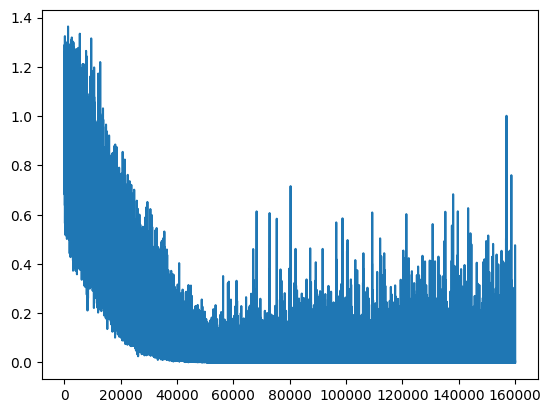

In [28]:
plt.plot(train_losses)

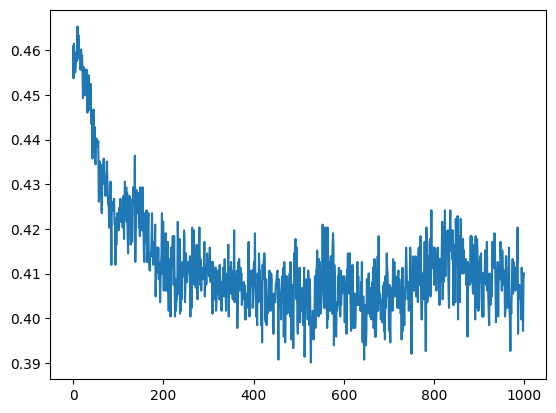

In [29]:
plt.plot(test_accuracy)

In [34]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                           | 0.009615384615384616/10 [00:00<07:27, 44.79s/it]

Train Epoch: 1 [0/5144 (0%)]	Loss: 0.749873


  5%|███▋                                                                        | 0.49038461538461475/10 [00:23<07:24, 46.76s/it]

Train Epoch: 1 [3200/5144 (62%)]	Loss: 0.624637


 10%|███████▋                                                                     | 0.9999999999999976/10 [00:45<05:54, 39.42s/it]


Test Epoch: 1	Accuracy: 705/1556 (45%)



 10%|███████▊                                                                     | 1.0096153846153821/10 [00:46<06:13, 41.50s/it]

Train Epoch: 2 [0/5144 (0%)]	Loss: 0.780621


 15%|███████████▍                                                                 | 1.4903846153846112/10 [01:09<06:37, 46.72s/it]

Train Epoch: 2 [3200/5144 (62%)]	Loss: 1.103087


 20%|███████████████▌                                                              | 1.999999999999994/10 [01:31<05:15, 39.47s/it]


Test Epoch: 2	Accuracy: 715/1556 (46%)



 20%|███████████████▋                                                              | 2.009615384615379/10 [01:32<05:31, 41.49s/it]

Train Epoch: 3 [0/5144 (0%)]	Loss: 0.836339


 25%|███████████████████▋                                                           | 2.49038461538463/10 [01:55<05:51, 46.86s/it]

Train Epoch: 3 [3200/5144 (62%)]	Loss: 1.318826


 30%|███████████████████████                                                      | 3.0000000000000364/10 [02:17<04:36, 39.53s/it]


Test Epoch: 3	Accuracy: 712/1556 (46%)



 30%|███████████████████████▏                                                     | 3.0096153846154214/10 [02:18<04:50, 41.61s/it]

Train Epoch: 4 [0/5144 (0%)]	Loss: 0.673620


 35%|██████████████████████████▉                                                  | 3.4903846153846727/10 [02:41<05:10, 47.68s/it]

Train Epoch: 4 [3200/5144 (62%)]	Loss: 0.647822


 40%|███████████████████████████████▏                                              | 4.000000000000079/10 [03:04<04:04, 40.68s/it]


Test Epoch: 4	Accuracy: 716/1556 (46%)



 40%|███████████████████████████████▎                                              | 4.009615384615464/10 [03:05<04:14, 42.54s/it]

Train Epoch: 5 [0/5144 (0%)]	Loss: 0.875553


 45%|███████████████████████████████████                                           | 4.490384615384715/10 [03:28<04:24, 47.97s/it]

Train Epoch: 5 [3200/5144 (62%)]	Loss: 0.814831


 50%|███████████████████████████████████████                                       | 5.000000000000122/10 [03:51<03:18, 39.63s/it]


Test Epoch: 5	Accuracy: 717/1556 (46%)



 50%|███████████████████████████████████████                                       | 5.009615384615507/10 [03:51<03:27, 41.61s/it]

Train Epoch: 6 [0/5144 (0%)]	Loss: 0.808722


 55%|██████████████████████████████████████████▊                                   | 5.490384615384758/10 [04:15<03:32, 47.06s/it]

Train Epoch: 6 [3200/5144 (62%)]	Loss: 0.967041


 60%|██████████████████████████████████████████████▊                               | 6.000000000000164/10 [04:37<02:37, 39.28s/it]


Test Epoch: 6	Accuracy: 707/1556 (45%)



 60%|██████████████████████████████████████████████▉                               | 6.009615384615549/10 [04:37<02:46, 41.64s/it]

Train Epoch: 7 [0/5144 (0%)]	Loss: 0.765171


 65%|██████████████████████████████████████████████████▋                           | 6.490384615384801/10 [05:00<02:43, 46.57s/it]

Train Epoch: 7 [3200/5144 (62%)]	Loss: 0.741302


 70%|██████████████████████████████████████████████████████▌                       | 7.000000000000207/10 [05:23<01:57, 39.17s/it]


Test Epoch: 7	Accuracy: 696/1556 (45%)



 70%|██████████████████████████████████████████████████████▋                       | 7.009615384615592/10 [05:23<02:03, 41.29s/it]

Train Epoch: 8 [0/5144 (0%)]	Loss: 0.885767


 75%|██████████████████████████████████████████████████████████▍                   | 7.490384615384843/10 [05:46<02:02, 48.79s/it]

Train Epoch: 8 [3200/5144 (62%)]	Loss: 0.715573


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000249/10 [06:09<01:20, 40.04s/it]


Test Epoch: 8	Accuracy: 694/1556 (45%)



 80%|██████████████████████████████████████████████████████████████▍               | 8.009615384615632/10 [06:10<01:22, 41.67s/it]

Train Epoch: 9 [0/5144 (0%)]	Loss: 0.629835


 85%|██████████████████████████████████████████████████████████████████▏           | 8.490384615384794/10 [06:33<01:11, 47.39s/it]

Train Epoch: 9 [3200/5144 (62%)]	Loss: 0.835951


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000107/10 [06:56<00:39, 39.55s/it]


Test Epoch: 9	Accuracy: 680/1556 (44%)



 90%|███████████████████████████████████████████████████████████████████████▏       | 9.00961538461549/10 [06:56<00:41, 41.54s/it]

Train Epoch: 10 [0/5144 (0%)]	Loss: 0.776430


 95%|██████████████████████████████████████████████████████████████████████████    | 9.490384615384652/10 [07:20<00:24, 47.37s/it]

Train Epoch: 10 [3200/5144 (62%)]	Loss: 0.703179


100%|█████████████████████████████████████████████████████████████████████████████▉| 9.999999999999964/10 [07:42<00:00, 46.28s/it]


Test Epoch: 10	Accuracy: 700/1556 (45%)



In [35]:
import torchmetrics
f1score = torchmetrics.F1Score(
    task='multiclass', num_classes=len(labels)
).to(device)
uap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
wap = torchmetrics.Precision(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)    
uar = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='macro'
).to(device)
war = torchmetrics.Recall(
    task='multiclass', num_classes=len(labels), average='micro'
).to(device)
confusion_matrix = torchmetrics.ConfusionMatrix(
    task='multiclass', num_classes=len(labels)
).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    f1score(pred, target)
    uap(pred, target)
    wap(pred, target)
    uar(pred, target)
    war(pred, target)
    confusion_matrix(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
F1 = f1score.compute()
UAP = uap.compute()
WAP = wap.compute()
UAR = uar.compute()
WAR = war.compute()
cm = confusion_matrix.compute()
print(f'F1: {F1}')
print(f'UAP: {UAP}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')
print(f'WAR: {WAR}')
print(cm)

Correct: 705/1556 (0.4531)
F1: 0.458984375
UAP: 0.46460798382759094
WAP: 0.458984375
UAR: 0.45930996537208557
WAR: 0.458984375
tensor([[106,  25,  35,   1,  24,  35],
        [ 45,  98,  22,  40,  33,  26],
        [ 33,   6, 182,   1,  24,  16],
        [ 15,  66,   0, 143,  22,  15],
        [ 27,  33,  79,  20,  90,  12],
        [ 61,  34,  61,   7,  13,  86]], device='cuda:0')


In [36]:
model_path = '../cremad_m13_110epochs_best.pt' 
torch.save(model.state_dict(), model_path)

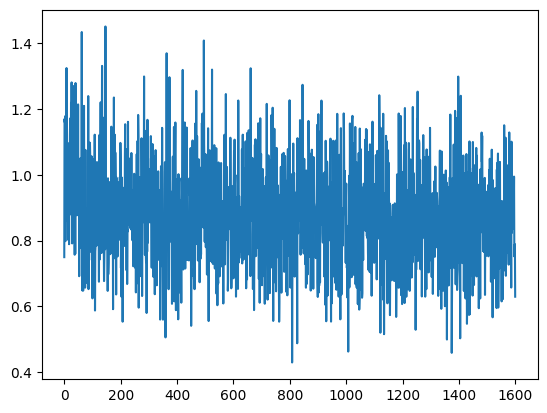

In [37]:
plt.plot(train_losses)

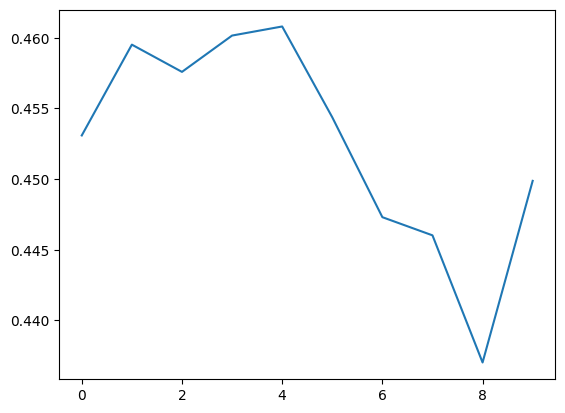

In [38]:
plt.plot(test_accuracy)

In [40]:
from IConNet.visualizer import visualize_model

In [41]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0410],
        [0.0634],
        [0.0869],
       

In [42]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 1.2723e-14],
        [ 5.0088e-15],
        [ 5.5953e-16],
        [ 4.0554e-16],
        [ 3.7449e-15],
        [-5.3688e-15],
        [ 2.4736e-14],
        [ 1.7075e-15],
        [-6.8428e-14],
        [-5.0154e-16],
        [ 4.2239e-17],
        [-1.5575e-17],
        [ 1.3531e-19],
        [-5.2513e-18],
        [ 1.2909e-19],
        [ 0.0000e+00],
        [-7.0350e-15],
        [-1.0504e-13],
        [ 3.9432e-15],
        [ 8.8840e-17],
        [-1.4697e-15],
        [-9.9643e-16],
        [ 6.4295e-16],
        [-3.7755e-15],
        [-4.5849e-14],
        [-6.0769e-18],
        [ 1.9304e-17],
        [ 4.9279e-17],
        [-3.0477e-18],
        [ 5.4824e-16],
        [-1.4699e-18],
        [ 0.0000e+00],
        [-1.1396e-14],
        [ 9.5749e-17],
        [ 3.4365e-14],
        [-9.7948e-14],
        [-3.7128e-13],
        [-7.7343e-14],
        [-3.9705e-16],
        [-2.3872e-15],
        [-5.6218e-15],
        [-7.4712e-17],
        [ 6

[None, None, None]

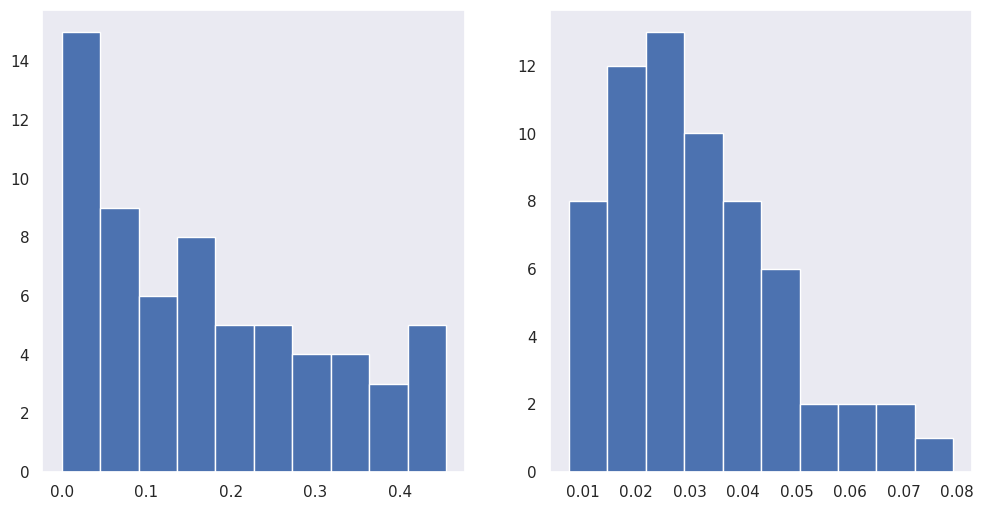

In [43]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

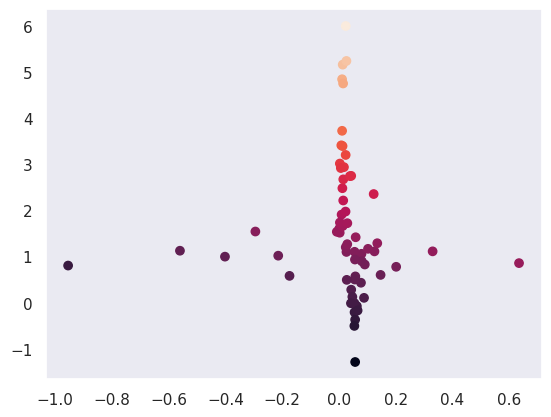

In [44]:
filtviz.visualize_window_params()

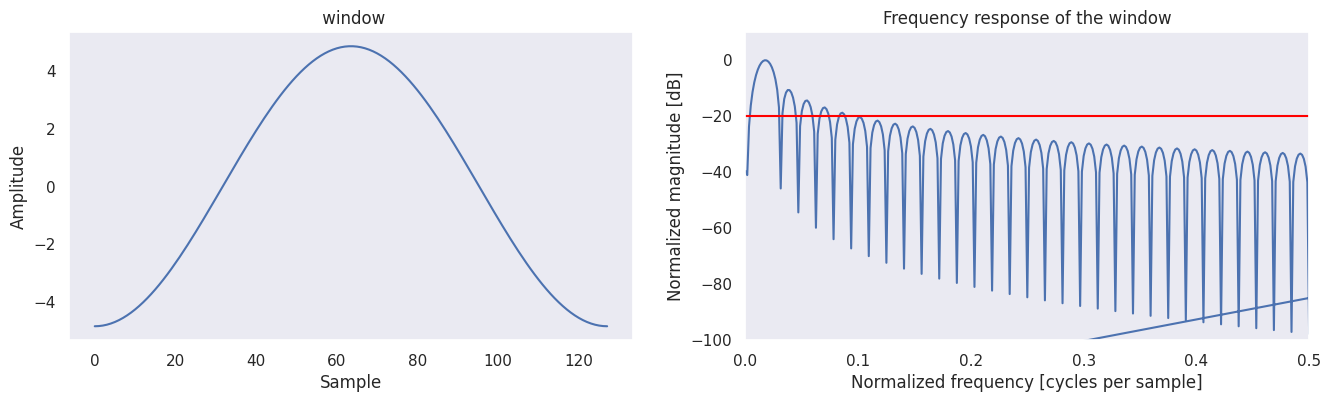

In [45]:
filtviz.visualize_one_window(n_out=10, n_inp=0)

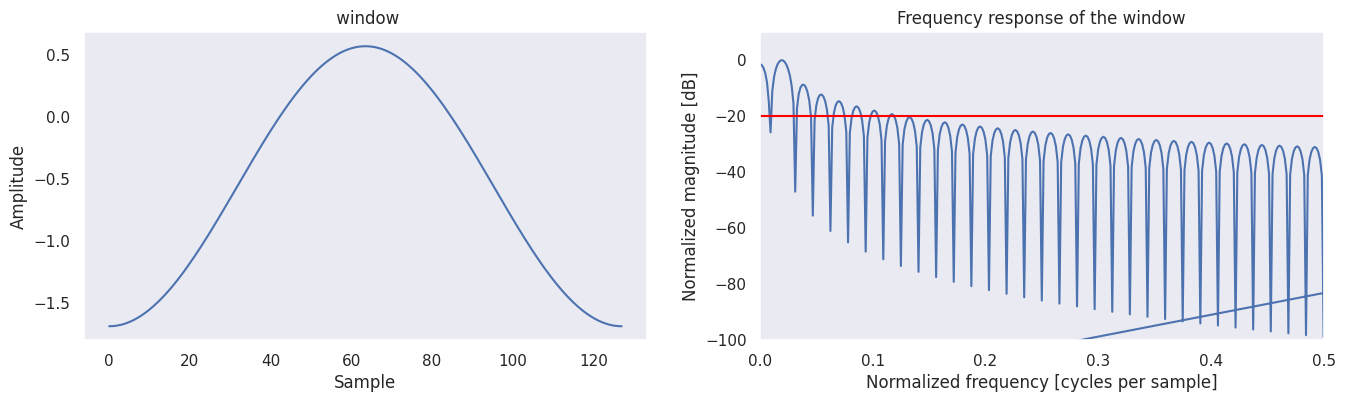

In [49]:
filtviz.visualize_one_window(n_out=1, n_inp=0)

Time domain: Filters' shapes vary by frequency bins


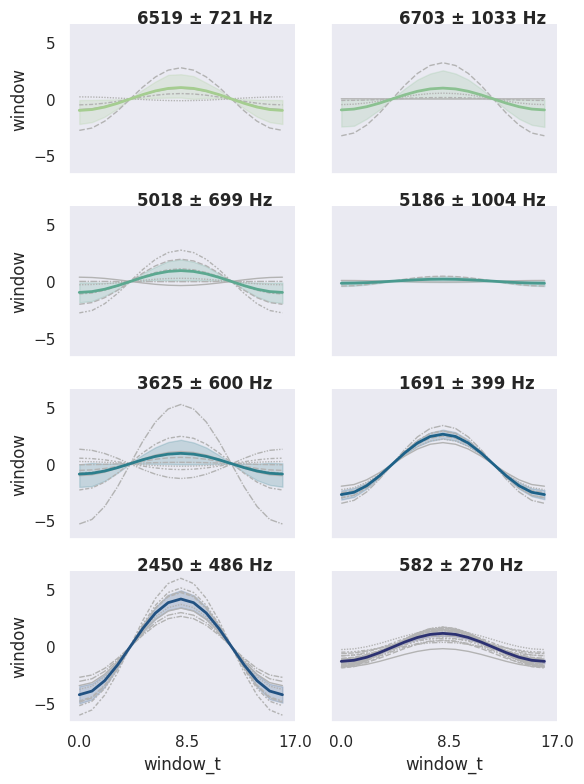

In [50]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


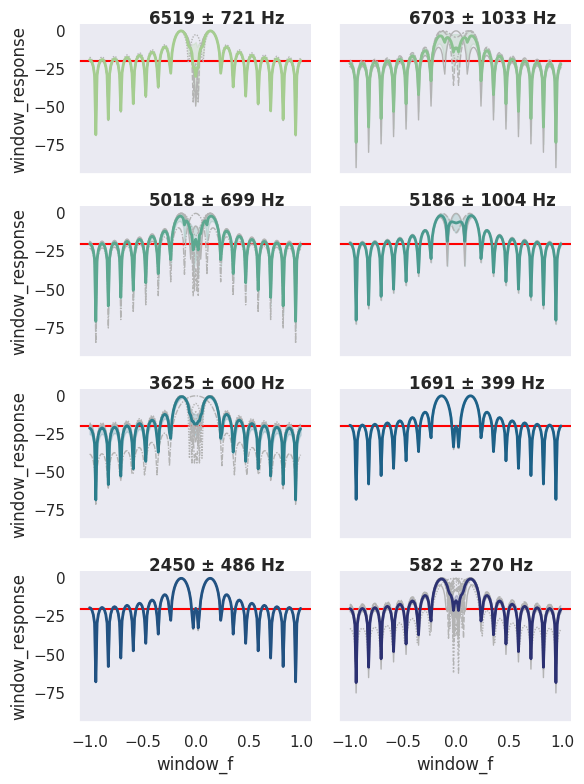

In [51]:
filtviz.visualize_filters(filter_domain='freq')

In [52]:
del model
gc.collect()

27367